<a href="https://colab.research.google.com/github/tchaase/cVAE_autism/blob/main/code/cVAE_autism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contrastive Variational Autoencoder for the ABIDE Data Set

Author - Tobias Haase

## Imports

Firstly I am importaing the necessary modules here, that I will use within the following.



In [4]:
import torch  # The main PyTorch library for tensor computations and neural network operations

import torch.nn as nn  # Provides various neural network layers and functionalities
import torch.nn.functional as F  # Provides functional interfaces to common operations (e.g., activation functions)
import torch.optim as optim  # Contains various optimization algorithms (e.g., SGD, Adam)

import torchvision  # A PyTorch library for computer vision tasks
import torchvision.transforms as transforms  # Provides common image transformations (e.g., resizing, normalization)
from torchvision.transforms import ToTensor  # Transforms PIL images to tensors
from torch.utils.data import Dataset, DataLoader  # Provides tools for creating custom datasets and data loaders
import torch.nn as nn

import numpy as np  # NumPy library for numerical computations and array operations
import matplotlib  # Matplotlib library for data visualization
import matplotlib.pyplot as plt  # Matplotlib's pyplot module for creating plots
from tqdm import tqdm  # Progress bar library for tracking iterations

import os
import requests
import nibabel as nib
import numpy as np
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cpu')

Now, it is very helpful to keep a set seed so my analyes are reproducible.

In [28]:
import random
import numpy as np
import torch

seed_value = 42

# Set seed for Python's random module
random.seed(seed_value)

# Set seed for NumPy
np.random.seed(seed_value)

# Set seed for PyTorch (CPU and CUDA)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Now all random operations in Python, NumPy, and PyTorch will be reproducible

Next, I am loading the project's data. To load the data there are multiple options - one is cyberduck. I deviated from using cyberduck as it was easier to figure out the links for other files via `urllib.request.urlretrieve`. However I am leaving the code here - but commenting it out.

Firstly, to use **CyberDuck**, one would need to install it:


In [ ]:
#!echo -e "deb https://s3.amazonaws.com/repo.deb.cyberduck.io stable main" | sudo tee /etc/apt/sources.list.d/cyberduck.list > /dev/null
#!sudo apt-key adv --keyserver keyserver.ubuntu.com --recv-keys FE7097963FEFBE72
#!sudo apt-get update
#!sudo apt-get install duck

#duck --username anonymous --verbose --download s3:/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/ants/anat_thickness/*_anat_thickness.nii.gz ./drive/MyDrive/MasterThesisData

Executing: /tmp/apt-key-gpghome.UDxYlqxJL7/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys FE7097963FEFBE72
gpg: key F7FAE1F32DA69515: public key "Cyberduck <feedback@cyberduck.io>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:6 https://s3.amazonaws.com/repo.deb.cyberduck.io stable InRelease [3,245 B]
Get:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net

As I want to use a specific atlas, I need to do the transformations myself. For this, I need access to the ANTs pipeline. Thankfully you can load it like below, as explained [here]( https://colab.research.google.com/drive/1g5cnZxj1llRaHmOs4xSglqsXnFkQYuol?usp=sharing#scrollTo=7J9SVgWtVD_D).

In [ ]:
import os
os.environ["LD_PRELOAD"] = "";
os.environ["APPTAINER_BINDPATH"] = "/content"
os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"

!curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
!chmod +x googlecolab_setup.sh
!./googlecolab_setup.sh
os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3338  100  3338    0     0  12029      0 --:--:-- --:--:-- --:--:-- 12007
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
lsb-release is already the newest version (11.1.0ubuntu4).
lsb-release set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
--2023-08-28 07:02:34--  https://ecsft.cern.ch/dist/cvmfs/cvmfs-release/cvmfs-release-latest_all.deb
Resolving ecsft.cern.ch (ecsft.cern.ch)... 188.184.97.7
Connecting to ecsft.cern.ch (ecsft.cern.ch)|188.184.97.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5174 (5.1K)
Saving to: ‘cvmfs-release-latest_all.deb’

cvmfs-release-lates 100%[===================>]   5.05K  --.-KB/s    in 0s      

2023-08-28 07:02:35 (328 MB/s) - ‘cvmfs-release-latest_all.deb’ saved [5174/5174

Now I just load a version of ants!

In [ ]:
import lmod
await lmod.load('ants/2.3.5')

Next, I am mounting the drive so I can use it later to store the data.

In [ ]:
#!ls ./data/anat_thickness/
!rm -rf ./data

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Now, its helpful to have the file with the participant info already.

In [ ]:
# URL to download the CSV file!
csv_url = "https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv"  # Replace with the actual URL

# Directory to store the CSV file
data_directory = "./data/participant_info"

# Create the directory if it does not exist
os.makedirs(data_directory, exist_ok=True)

# File path to save the CSV file
csv_file_path = os.path.join(data_directory, "participant_info.csv")

# Download the CSV file
response = requests.get(csv_url)
if response.status_code == 200:
    with open(csv_file_path, "wb") as f:
        f.write(response.content)
    print("CSV file downloaded successfully.")
else:
    print("Failed to download the CSV file.")


CSV file downloaded successfully.


To get the data transformed later I will also need a template. This is loaded here!

In [ ]:
!pip install templateflow
from templateflow import api as tflow
mni152 = tflow.get('MNI152NLin2009cAsym', desc=None, resolution=1,
                    suffix='T1w', extension='nii.gz')
mni152_path = str(mni152)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.4/455.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=52a56888811d47435c83a60e3ef63a3c540aa1e4b2755afa7101f0abda071ddc
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


100%|██████████| 13.7M/13.7M [00:00<00:00, 53.9MB/s]


Now that we have the template, the pipelines we can actually load the data. But first let's define the relevant directories.

In [ ]:
#!pip install ants
!pip install nipype

import pandas as pd
import os
import shutil
import urllib.request
from nipype.interfaces.ants import ApplyTransforms

# Define paths
data_directory = "./data/participant_info"
transformed_directory = './drive/MyDrive/MasterThesisData/transformed'
temp_directory = '/content/temp_data'  # Temporary directory

# Create directories if they don't exist
os.makedirs(transformed_directory, exist_ok=True)
os.makedirs(temp_directory, exist_ok=True)

# Load the CSV file
csv_file_path = os.path.join(data_directory, "participant_info.csv")
data = pd.read_csv(csv_file_path)

failed_download = []

FileNotFoundError: ignored

Let's attempt this with one participant and see if it works.

In [ ]:
sub_id = "50003"

try:
    # Construct the MRI data file name
    mri_data_file = f"{file_id}_anat_thickness.nii.gz"
    mri_data_path = os.path.join(temp_directory, mri_data_file)

    # Download the MRI data file to the temporary directory
    mri_url = f"https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE/Outputs/mindboggle_swf/mindboggle/ants_subjects/sub-00{sub_id}/antsCorticalThickness.nii.gz"
    urllib.request.urlretrieve(mri_url, mri_data_path)

    # Construct the transformation template file name
    template_file_name = f'sub-00{sub_id}_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5'
    template_destination = os.path.join(temp_directory, template_file_name)

    # Download the transformation template
    template_url = f"https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE/Outputs/fmriprep/fmriprep/sub-00{sub_id}/anat/{template_file_name}"
    urllib.request.urlretrieve(template_url, template_destination)

    # Define paths for the transformed output
    transformed_output_path = os.path.join(transformed_directory, f"sub-00{sub_id}_space-MNI152NLin2009cAsym_desc-corticalthickness.nii.gz")

    from nipype import config, logging
    from nipype.interfaces.base import CommandLine

    # Set the execution plugin to CommandLine
    config.enable_debug_mode()
    config.enable_provenance()
    logging.update_logging(config)

    # Define the antsApplyTransforms interface
    at = ApplyTransforms()
    at.inputs.input_image = mri_data_path
    at.inputs.reference_image = mni152_path
    at.inputs.transforms = template_destination
    at.inputs.output_image = transformed_output_path

    # Execute the antsApplyTransforms command
    cmdline = at.cmdline
    cl = CommandLine(command=cmdline)
    cl.run()

    # Clean up: Delete the input data and template
    !rm /content/temp_data/*

    print(f"Transformed and saved for FILE_ID: {file_id}")

except Exception as e:
    print(f"Failed for FILE_ID: {file_id}. Error: {e}")


230811-22:38:05,222 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230811-22:38:05,248 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230811-22:38:05,271 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050014_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050014_anat_thickness.nii.gz


230811-22:38:05,292 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050014


Great! Now onto all the other participants.

In [ ]:
for index, row in data.iterrows():
    file_id = row['FILE_ID']
    sub_id = row['SUB_ID']

    try:
        # Construct the MRI data file name
        mri_data_file = f"{file_id}_anat_thickness.nii.gz"
        mri_data_path = os.path.join(temp_directory, mri_data_file)

        # Download the MRI data file to the temporary directory
        mri_url = f"https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE/Outputs/mindboggle_swf/mindboggle/ants_subjects/sub-00{sub_id}/antsCorticalThickness.nii.gz"
        urllib.request.urlretrieve(mri_url, mri_data_path)

        # Construct the transformation template file name
        template_file_name = f'sub-00{sub_id}_from-T1w_to-MNI152NLin2009cAsym_mode-image_xfm.h5'
        template_destination = os.path.join(temp_directory, template_file_name)

        # Download the transformation template
        template_url = f"https://fcp-indi.s3.amazonaws.com/data/Projects/ABIDE/Outputs/fmriprep/fmriprep/sub-00{sub_id}/anat/{template_file_name}"
        urllib.request.urlretrieve(template_url, template_destination)

        # Define paths for the transformed output
        transformed_output_path = os.path.join(transformed_directory, f"sub-00{sub_id}_space-MNI152NLin2009cAsym_desc-corticalthickness.nii.gz")

        from nipype import config, logging
        from nipype.interfaces.base import CommandLine

        # Set the execution plugin to CommandLine
        config.enable_debug_mode()
        config.enable_provenance()
        logging.update_logging(config)

        # Define the antsApplyTransforms interface
        at = ApplyTransforms()
        at.inputs.input_image = mri_data_path
        at.inputs.reference_image = mni152_path
        at.inputs.transforms = template_destination
        at.inputs.output_image = transformed_output_path

        # Execute the antsApplyTransforms command
        cmdline = at.cmdline
        cl = CommandLine(command=cmdline)
        cl.run()

        # Clean up: Delete the input data and template
        !rm "./temp_data/*"

        print(f"Transformed and saved for FILE_ID: {file_id}")

    except Exception as e:
        print(f"Failed for FILE_ID: {file_id}. Error: {e}")

print("Processing completed.")


230828-07:05:27,510 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:05:27,515 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:05:27,523 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-07:05:27,534 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-07:05:41,650 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:05:41,660 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:05:41,665 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050003_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050003_anat_thickness.nii.gz


230828-07:05:41,669 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050003
230828-07:05:47,932 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:05:47,939 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:05:47,945 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050004_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050004_anat_thickness.nii.gz


230828-07:05:47,947 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050004
230828-07:05:55,955 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:05:55,959 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:05:55,962 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050005_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050005_anat_thickness.nii.gz


230828-07:05:55,965 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050005
230828-07:06:02,116 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:06:02,122 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:06:02,126 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050006_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050006_anat_thickness.nii.gz


230828-07:06:02,129 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050006
230828-07:06:09,408 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:06:09,418 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:06:09,424 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050007_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050007_anat_thickness.nii.gz


230828-07:06:09,426 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050007
230828-07:06:15,435 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:06:15,437 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:06:15,446 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050008_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050008_anat_thickness.nii.gz


230828-07:06:15,449 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050008
230828-07:06:21,473 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:06:21,483 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:06:21,488 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050009_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050009_anat_thickness.nii.gz


230828-07:06:21,490 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050009
230828-07:06:28,573 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:06:28,579 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:06:28,583 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050010_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050010_anat_thickness.nii.gz


230828-07:06:28,587 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050010
230828-07:06:34,854 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:06:34,860 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:06:34,864 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050011_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050011_anat_thickness.nii.gz


230828-07:06:34,866 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050011
230828-07:06:41,458 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:06:41,465 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:06:41,470 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050012_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050012_anat_thickness.nii.gz


230828-07:06:41,472 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050012
230828-07:06:47,949 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:06:47,952 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:06:47,958 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050013_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050013_anat_thickness.nii.gz


230828-07:06:47,961 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050013
230828-07:06:54,22 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:06:54,28 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:06:54,33 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050014_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050014_anat_thickness.nii.gz


230828-07:06:54,38 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050014
230828-07:07:00,915 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:07:00,917 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:07:00,923 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050015_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050015_anat_thickness.nii.gz


230828-07:07:00,927 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050015
230828-07:07:07,263 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:07:07,269 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:07:07,272 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050016_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050016_anat_thickness.nii.gz


230828-07:07:07,276 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050016
230828-07:07:13,386 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:07:13,393 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:07:13,397 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050017_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050017_anat_thickness.nii.gz


230828-07:07:13,403 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050017
230828-07:07:20,242 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:07:20,245 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:07:20,250 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050019_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050019_anat_thickness.nii.gz


230828-07:07:20,254 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050019
230828-07:07:26,4 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:07:26,8 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:07:26,12 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050020_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050020_anat_thickness.nii.gz


230828-07:07:26,14 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050020
230828-07:07:34,24 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:07:34,31 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:07:34,39 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050022_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050022_anat_thickness.nii.gz


230828-07:07:34,41 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050022
230828-07:07:40,355 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:07:40,357 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:07:40,363 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050023_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050023_anat_thickness.nii.gz


230828-07:07:40,369 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050023
230828-07:07:46,418 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:07:46,426 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:07:46,429 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050024_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050024_anat_thickness.nii.gz


230828-07:07:46,432 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050024
230828-07:07:52,920 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:07:52,924 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:07:52,931 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050025_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050025_anat_thickness.nii.gz


230828-07:07:52,938 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050025
230828-07:07:59,439 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:07:59,443 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:07:59,449 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050026_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050026_anat_thickness.nii.gz


230828-07:07:59,452 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050026
230828-07:08:06,176 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:08:06,182 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:08:06,185 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050027_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050027_anat_thickness.nii.gz


230828-07:08:06,189 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050027
230828-07:08:12,968 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:08:12,976 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:08:12,982 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050028_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050028_anat_thickness.nii.gz


230828-07:08:12,987 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050028
230828-07:08:19,644 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:08:19,647 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:08:19,654 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050029_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050029_anat_thickness.nii.gz


230828-07:08:19,661 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050029
230828-07:08:26,546 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:08:26,553 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:08:26,559 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050030_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050030_anat_thickness.nii.gz


230828-07:08:26,563 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050030
230828-07:08:32,905 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:08:32,911 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:08:32,918 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050031_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050031_anat_thickness.nii.gz


230828-07:08:32,922 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050031
230828-07:08:40,287 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:08:40,294 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:08:40,297 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050032_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050032_anat_thickness.nii.gz


230828-07:08:40,300 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050032
230828-07:08:46,947 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:08:46,956 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:08:46,960 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050033_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050033_anat_thickness.nii.gz


230828-07:08:46,963 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050033
230828-07:08:52,601 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:08:52,611 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:08:52,617 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050034_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050034_anat_thickness.nii.gz


230828-07:08:52,620 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050034
230828-07:09:00,9 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:09:00,14 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:09:00,21 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050035_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050035_anat_thickness.nii.gz


230828-07:09:00,23 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050035
230828-07:09:05,988 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:09:05,990 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:09:05,994 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050036_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050036_anat_thickness.nii.gz


230828-07:09:05,998 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050036
230828-07:09:12,211 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:09:12,220 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:09:12,223 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050037_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050037_anat_thickness.nii.gz


230828-07:09:12,231 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050037
230828-07:09:19,96 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:09:19,102 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:09:19,107 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050038_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050038_anat_thickness.nii.gz


230828-07:09:19,109 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050038
230828-07:09:25,342 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:09:25,346 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:09:25,350 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050039_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050039_anat_thickness.nii.gz


230828-07:09:25,352 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050039
230828-07:09:32,423 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:09:32,427 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:09:32,435 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050040_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050040_anat_thickness.nii.gz


230828-07:09:32,440 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050040
230828-07:09:38,348 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:09:38,355 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:09:38,361 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050041_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050041_anat_thickness.nii.gz


230828-07:09:38,369 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050041
230828-07:09:44,581 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:09:44,585 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:09:44,589 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050042_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050042_anat_thickness.nii.gz


230828-07:09:44,591 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050042
230828-07:09:52,8 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:09:52,14 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:09:52,18 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050043_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050043_anat_thickness.nii.gz


230828-07:09:52,22 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050043
230828-07:09:58,480 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:09:58,488 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:09:58,493 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050044_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050044_anat_thickness.nii.gz


230828-07:09:58,497 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050044
230828-07:10:06,463 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:10:06,473 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:10:06,476 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050045_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050045_anat_thickness.nii.gz


230828-07:10:06,480 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050045
230828-07:10:12,421 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:10:12,423 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:10:12,432 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050046_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050046_anat_thickness.nii.gz


230828-07:10:12,436 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050046
230828-07:10:19,833 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:10:19,836 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:10:19,841 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050047_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050047_anat_thickness.nii.gz


230828-07:10:19,843 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050047
230828-07:10:26,513 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:10:26,515 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:10:26,519 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050048_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050048_anat_thickness.nii.gz


230828-07:10:26,527 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050048
Failed for FILE_ID: Pitt_0050049. Error: HTTP Error 404: Not Found
230828-07:10:32,646 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:10:32,650 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:10:32,653 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050050_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050050_anat_thickness.nii.gz


230828-07:10:32,655 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050050
230828-07:10:40,396 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:10:40,400 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:10:40,408 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050051_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050051_anat_thickness.nii.gz


230828-07:10:40,412 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050051
230828-07:10:47,469 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:10:47,473 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:10:47,478 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050052_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050052_anat_thickness.nii.gz


230828-07:10:47,480 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050052
230828-07:10:54,610 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:10:54,613 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:10:54,623 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050053_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050053_anat_thickness.nii.gz


230828-07:10:54,625 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050053
230828-07:11:01,15 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:11:01,24 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:11:01,31 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050054_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050054_anat_thickness.nii.gz


230828-07:11:01,34 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050054
230828-07:11:07,58 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:11:07,61 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:11:07,68 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050055_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050055_anat_thickness.nii.gz


230828-07:11:07,70 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050055
230828-07:11:14,713 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:11:14,715 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:11:14,719 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050056_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050056_anat_thickness.nii.gz


230828-07:11:14,721 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050056
230828-07:11:21,673 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:11:21,676 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:11:21,682 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050057_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050057_anat_thickness.nii.gz


230828-07:11:21,687 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050057
230828-07:11:28,409 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:11:28,413 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:11:28,422 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050058_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050058_anat_thickness.nii.gz


230828-07:11:28,425 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050058
230828-07:11:35,308 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:11:35,312 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:11:35,315 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050059_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050059_anat_thickness.nii.gz


230828-07:11:35,318 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050059
230828-07:11:41,193 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:11:41,197 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:11:41,202 nipype.interface DEBUG:
	 input_image_temp_data/Pitt_0050060_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Pitt_0050060_anat_thickness.nii.gz


230828-07:11:41,207 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Pitt_0050060
230828-07:11:48,208 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:11:48,216 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:11:48,223 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050102_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050102_anat_thickness.nii.gz


230828-07:11:48,226 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050102
230828-07:11:54,911 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:11:54,926 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:11:54,936 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050103_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050103_anat_thickness.nii.gz


230828-07:11:54,938 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050103
230828-07:12:02,855 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:12:02,864 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:12:02,869 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050104_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050104_anat_thickness.nii.gz


230828-07:12:02,872 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050104
230828-07:12:09,380 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:12:09,384 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:12:09,391 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050105_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050105_anat_thickness.nii.gz


230828-07:12:09,393 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050105
230828-07:12:16,336 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:12:16,340 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:12:16,345 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050106_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050106_anat_thickness.nii.gz


230828-07:12:16,350 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050106
230828-07:12:22,749 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:12:22,756 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:12:22,759 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050107_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050107_anat_thickness.nii.gz


230828-07:12:22,761 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050107
230828-07:12:29,584 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:12:29,589 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:12:29,592 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-07:12:29,594 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-07:12:36,729 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:12:36,731 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:12:36,734 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050109_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050109_anat_thickness.nii.gz


230828-07:12:36,738 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050109
230828-07:12:43,53 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:12:43,61 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:12:43,65 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050110_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050110_anat_thickness.nii.gz


230828-07:12:43,69 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050110
230828-07:12:49,807 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:12:49,810 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:12:49,816 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050111_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050111_anat_thickness.nii.gz


230828-07:12:49,820 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050111
230828-07:12:55,516 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:12:55,526 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:12:55,529 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050112_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050112_anat_thickness.nii.gz


230828-07:12:55,532 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050112
230828-07:13:01,403 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:13:01,407 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:13:01,412 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050113_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050113_anat_thickness.nii.gz


230828-07:13:01,413 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050113
230828-07:13:09,473 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:13:09,481 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:13:09,485 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050114_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050114_anat_thickness.nii.gz


230828-07:13:09,491 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050114
230828-07:13:15,585 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:13:15,587 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:13:15,593 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050115_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050115_anat_thickness.nii.gz


230828-07:13:15,595 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050115
230828-07:13:22,450 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:13:22,454 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:13:22,458 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050116_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050116_anat_thickness.nii.gz


230828-07:13:22,462 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050116
230828-07:13:28,871 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:13:28,874 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:13:28,877 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050117_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050117_anat_thickness.nii.gz


230828-07:13:28,880 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050117
230828-07:13:34,700 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:13:34,704 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:13:34,710 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050118_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050118_anat_thickness.nii.gz


230828-07:13:34,712 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050118
230828-07:13:42,576 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:13:42,580 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:13:42,583 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050119_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050119_anat_thickness.nii.gz


230828-07:13:42,586 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050119
230828-07:13:48,556 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:13:48,563 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:13:48,572 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050120_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050120_anat_thickness.nii.gz


230828-07:13:48,577 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050120
230828-07:13:55,381 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:13:55,388 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:13:55,393 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050121_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050121_anat_thickness.nii.gz


230828-07:13:55,396 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050121
230828-07:14:02,293 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:14:02,295 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:14:02,301 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050122_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050122_anat_thickness.nii.gz


230828-07:14:02,303 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050122
230828-07:14:09,129 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:14:09,133 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:14:09,136 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050123_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050123_anat_thickness.nii.gz


230828-07:14:09,140 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050123
230828-07:14:16,379 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:14:16,388 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:14:16,395 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050124_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050124_anat_thickness.nii.gz


230828-07:14:16,399 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050124
230828-07:14:22,341 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:14:22,349 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:14:22,352 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050125_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050125_anat_thickness.nii.gz


230828-07:14:22,356 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050125
230828-07:14:29,949 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:14:29,953 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:14:29,956 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050126_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050126_anat_thickness.nii.gz


230828-07:14:29,959 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050126
230828-07:14:35,881 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:14:35,889 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:14:35,893 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050127_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050127_anat_thickness.nii.gz


230828-07:14:35,898 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050127
230828-07:14:41,820 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:14:41,827 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:14:41,831 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050128_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050128_anat_thickness.nii.gz


230828-07:14:41,837 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050128
230828-07:14:49,631 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:14:49,640 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:14:49,646 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050129_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050129_anat_thickness.nii.gz


230828-07:14:49,649 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050129
230828-07:14:56,228 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:14:56,232 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:14:56,236 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050130_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050130_anat_thickness.nii.gz


230828-07:14:56,239 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050130
230828-07:15:03,436 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:15:03,443 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:15:03,446 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050131_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050131_anat_thickness.nii.gz


230828-07:15:03,453 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050131
230828-07:15:09,713 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:15:09,721 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:15:09,724 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050132_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050132_anat_thickness.nii.gz


230828-07:15:09,727 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050132
230828-07:15:15,391 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:15:15,396 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:15:15,400 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050133_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050133_anat_thickness.nii.gz


230828-07:15:15,406 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050133
230828-07:15:22,555 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:15:22,559 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:15:22,566 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050134_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050134_anat_thickness.nii.gz


230828-07:15:22,572 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050134
230828-07:15:28,391 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:15:28,394 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:15:28,398 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050135_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050135_anat_thickness.nii.gz


230828-07:15:28,402 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050135
230828-07:15:34,536 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:15:34,540 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:15:34,543 nipype.interface DEBUG:
	 input_image_temp_data/Olin_0050136_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Olin_0050136_anat_thickness.nii.gz


230828-07:15:34,545 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Olin_0050136
230828-07:15:41,593 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:15:41,595 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:15:41,603 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-07:15:41,608 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-07:15:48,442 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:15:48,451 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:15:48,457 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050142_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050142_anat_thickness.nii.gz


230828-07:15:48,459 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050142
230828-07:15:55,540 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:15:55,544 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:15:55,547 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050143_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050143_anat_thickness.nii.gz


230828-07:15:55,550 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050143
230828-07:16:01,59 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:16:01,62 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:16:01,70 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050144_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050144_anat_thickness.nii.gz


230828-07:16:01,72 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050144
230828-07:16:07,450 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:16:07,453 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:16:07,461 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050145_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050145_anat_thickness.nii.gz


230828-07:16:07,463 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050145
230828-07:16:14,866 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:16:14,874 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:16:14,881 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050146_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050146_anat_thickness.nii.gz


230828-07:16:14,885 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050146
230828-07:16:21,532 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:16:21,540 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:16:21,543 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050147_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050147_anat_thickness.nii.gz


230828-07:16:21,545 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050147
230828-07:16:28,801 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:16:28,808 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:16:28,811 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050148_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050148_anat_thickness.nii.gz


230828-07:16:28,818 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050148
230828-07:16:35,172 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:16:35,179 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:16:35,184 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050149_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050149_anat_thickness.nii.gz


230828-07:16:35,187 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050149
230828-07:16:41,579 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:16:41,581 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:16:41,587 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050150_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050150_anat_thickness.nii.gz


230828-07:16:41,590 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050150
230828-07:16:48,315 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:16:48,322 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:16:48,325 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050152_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050152_anat_thickness.nii.gz


230828-07:16:48,331 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050152
230828-07:16:55,70 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:16:55,74 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:16:55,79 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050153_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050153_anat_thickness.nii.gz


230828-07:16:55,81 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050153
230828-07:17:02,971 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:17:02,974 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:17:02,977 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-07:17:02,980 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-07:17:09,488 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:17:09,495 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:17:09,502 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050156_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050156_anat_thickness.nii.gz


230828-07:17:09,507 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050156
230828-07:17:17,788 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:17:17,795 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:17:17,802 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050157_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050157_anat_thickness.nii.gz


230828-07:17:17,806 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050157
230828-07:17:24,283 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:17:24,287 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:17:24,290 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050158_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050158_anat_thickness.nii.gz


230828-07:17:24,292 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050158
230828-07:17:30,940 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:17:30,944 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:17:30,947 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050159_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050159_anat_thickness.nii.gz


230828-07:17:30,950 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050159
230828-07:17:38,45 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:17:38,48 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:17:38,52 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050160_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050160_anat_thickness.nii.gz


230828-07:17:38,55 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050160
230828-07:17:44,985 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:17:44,994 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:17:44,997 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050161_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050161_anat_thickness.nii.gz


230828-07:17:45,3 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050161
230828-07:17:52,721 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:17:52,723 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:17:52,730 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050162_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050162_anat_thickness.nii.gz


230828-07:17:52,732 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050162
230828-07:17:58,902 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:17:58,906 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:17:58,909 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050163_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050163_anat_thickness.nii.gz


230828-07:17:58,911 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050163
230828-07:18:05,829 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:18:05,834 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:18:05,837 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050164_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050164_anat_thickness.nii.gz


230828-07:18:05,842 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050164
230828-07:18:12,545 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:18:12,548 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:18:12,551 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-07:18:12,554 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-07:18:18,978 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:18:18,982 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:18:18,985 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050166_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050166_anat_thickness.nii.gz


230828-07:18:18,988 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050166
230828-07:18:26,684 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:18:26,687 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:18:26,691 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050167_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050167_anat_thickness.nii.gz


230828-07:18:26,693 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050167
230828-07:18:33,108 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:18:33,111 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:18:33,115 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050168_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050168_anat_thickness.nii.gz


230828-07:18:33,122 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050168
230828-07:18:40,710 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:18:40,723 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:18:40,726 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050169_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050169_anat_thickness.nii.gz


230828-07:18:40,731 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050169
Failed for FILE_ID: OHSU_0050170. Error: HTTP Error 404: Not Found
230828-07:18:48,94 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:18:48,98 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:18:48,105 nipype.interface DEBUG:
	 input_image_temp_data/OHSU_0050171_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/OHSU_0050171_anat_thickness.nii.gz


230828-07:18:48,111 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: OHSU_0050171
230828-07:18:54,597 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:18:54,604 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:18:54,609 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050182_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050182_anat_thickness.nii.gz


230828-07:18:54,612 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050182
230828-07:19:01,677 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:19:01,684 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:19:01,687 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050183_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050183_anat_thickness.nii.gz


230828-07:19:01,693 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050183
230828-07:19:08,175 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:19:08,184 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:19:08,187 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050184_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050184_anat_thickness.nii.gz


230828-07:19:08,193 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050184
230828-07:19:15,368 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:19:15,374 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:19:15,382 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050185_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050185_anat_thickness.nii.gz


230828-07:19:15,387 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050185
230828-07:19:21,976 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:19:21,983 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:19:21,988 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050186_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050186_anat_thickness.nii.gz


230828-07:19:21,992 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050186
230828-07:19:28,650 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:19:28,660 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:19:28,667 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050187_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050187_anat_thickness.nii.gz


230828-07:19:28,672 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050187
230828-07:19:36,874 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:19:36,879 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:19:36,884 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050188_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050188_anat_thickness.nii.gz


230828-07:19:36,888 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050188
230828-07:19:43,201 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:19:43,206 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:19:43,215 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050189_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050189_anat_thickness.nii.gz


230828-07:19:43,217 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050189
230828-07:19:50,653 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:19:50,657 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:19:50,661 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050190_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050190_anat_thickness.nii.gz


230828-07:19:50,663 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050190
230828-07:19:57,412 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:19:57,420 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:19:57,423 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050191_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050191_anat_thickness.nii.gz


230828-07:19:57,426 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050191
230828-07:20:05,440 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:20:05,446 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:20:05,450 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050192_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050192_anat_thickness.nii.gz


230828-07:20:05,455 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050192
230828-07:20:11,314 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:20:11,317 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:20:11,321 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050193_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050193_anat_thickness.nii.gz


230828-07:20:11,324 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050193
230828-07:20:18,744 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:20:18,752 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:20:18,754 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050194_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050194_anat_thickness.nii.gz


230828-07:20:18,760 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050194
230828-07:20:25,316 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:20:25,320 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:20:25,327 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050195_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050195_anat_thickness.nii.gz


230828-07:20:25,330 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050195
230828-07:20:32,46 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:20:32,54 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:20:32,58 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050196_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050196_anat_thickness.nii.gz


230828-07:20:32,67 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050196
Failed for FILE_ID: SDSU_0050197. Error: HTTP Error 404: Not Found
230828-07:20:39,822 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:20:39,825 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:20:39,828 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050198_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050198_anat_thickness.nii.gz


230828-07:20:39,830 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050198
230828-07:20:45,902 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:20:45,906 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:20:45,911 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050199_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050199_anat_thickness.nii.gz


230828-07:20:45,913 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050199
230828-07:20:54,115 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:20:54,123 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:20:54,127 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050200_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050200_anat_thickness.nii.gz


230828-07:20:54,128 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050200
230828-07:21:00,682 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:21:00,690 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:21:00,693 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050201_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050201_anat_thickness.nii.gz


230828-07:21:00,697 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050201
230828-07:21:07,55 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:21:07,61 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:21:07,66 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050202_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050202_anat_thickness.nii.gz


230828-07:21:07,71 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050202
230828-07:21:14,97 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:21:14,100 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:21:14,103 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050203_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050203_anat_thickness.nii.gz


230828-07:21:14,106 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050203
230828-07:21:20,651 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:21:20,658 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:21:20,664 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050204_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050204_anat_thickness.nii.gz


230828-07:21:20,666 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050204
230828-07:21:28,347 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:21:28,354 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:21:28,357 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050205_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050205_anat_thickness.nii.gz


230828-07:21:28,359 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050205
230828-07:21:34,722 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:21:34,729 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:21:34,735 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050206_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050206_anat_thickness.nii.gz


230828-07:21:34,741 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050206
230828-07:21:41,635 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:21:41,646 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:21:41,655 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050207_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050207_anat_thickness.nii.gz


230828-07:21:41,657 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050207
230828-07:21:48,637 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:21:48,644 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:21:48,648 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050208_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050208_anat_thickness.nii.gz


230828-07:21:48,651 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050208
230828-07:21:55,483 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:21:55,491 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:21:55,496 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050209_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050209_anat_thickness.nii.gz


230828-07:21:55,499 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050209
230828-07:22:03,811 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:22:03,814 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:22:03,821 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050210_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050210_anat_thickness.nii.gz


230828-07:22:03,824 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050210
Failed for FILE_ID: SDSU_0050211. Error: HTTP Error 404: Not Found
230828-07:22:09,693 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:22:09,697 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:22:09,701 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050212_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050212_anat_thickness.nii.gz


230828-07:22:09,703 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050212
230828-07:22:16,484 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:22:16,492 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:22:16,496 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050213_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050213_anat_thickness.nii.gz


230828-07:22:16,500 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050213
230828-07:22:23,255 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:22:23,260 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:22:23,266 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050214_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050214_anat_thickness.nii.gz


230828-07:22:23,268 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050214
230828-07:22:28,794 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:22:28,798 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:22:28,809 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050215_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050215_anat_thickness.nii.gz


230828-07:22:28,811 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050215
230828-07:22:36,805 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:22:36,808 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:22:36,813 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050216_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050216_anat_thickness.nii.gz


230828-07:22:36,817 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050216
230828-07:22:43,545 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:22:43,548 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:22:43,551 nipype.interface DEBUG:
	 input_image_temp_data/SDSU_0050217_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SDSU_0050217_anat_thickness.nii.gz


230828-07:22:43,554 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SDSU_0050217
230828-07:22:50,510 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:22:50,514 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:22:50,518 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050232_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050232_anat_thickness.nii.gz


230828-07:22:50,520 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050232
230828-07:22:57,71 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:22:57,75 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:22:57,79 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050233_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050233_anat_thickness.nii.gz


230828-07:22:57,83 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050233
230828-07:23:03,843 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:23:03,852 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:23:03,855 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050234_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050234_anat_thickness.nii.gz


230828-07:23:03,857 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050234
230828-07:23:11,447 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:23:11,450 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:23:11,454 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050235_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050235_anat_thickness.nii.gz


230828-07:23:11,457 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050235
230828-07:23:17,820 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:23:17,822 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:23:17,826 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050236_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050236_anat_thickness.nii.gz


230828-07:23:17,834 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050236
230828-07:23:26,129 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:23:26,135 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:23:26,140 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050237_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050237_anat_thickness.nii.gz


230828-07:23:26,143 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050237
230828-07:23:32,654 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:23:32,656 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:23:32,660 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-07:23:32,664 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-07:23:38,551 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:23:38,556 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:23:38,561 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050239_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050239_anat_thickness.nii.gz


230828-07:23:38,563 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050239
230828-07:23:45,915 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:23:45,923 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:23:45,929 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050240_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050240_anat_thickness.nii.gz


230828-07:23:45,933 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050240
230828-07:23:51,685 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:23:51,688 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:23:51,697 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050241_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050241_anat_thickness.nii.gz


230828-07:23:51,700 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050241
230828-07:23:59,53 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:23:59,62 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:23:59,68 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050242_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050242_anat_thickness.nii.gz


230828-07:23:59,71 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050242
230828-07:24:05,930 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:24:05,937 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:24:05,944 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050243_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050243_anat_thickness.nii.gz


230828-07:24:05,948 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050243
230828-07:24:11,916 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:24:11,920 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:24:11,927 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-07:24:11,929 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-07:24:19,805 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:24:19,813 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:24:19,819 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050245_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050245_anat_thickness.nii.gz


230828-07:24:19,824 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050245
230828-07:24:26,625 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:24:26,629 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:24:26,632 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050246_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050246_anat_thickness.nii.gz


230828-07:24:26,634 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050246
230828-07:24:34,21 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:24:34,25 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:24:34,28 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050247_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050247_anat_thickness.nii.gz


230828-07:24:34,30 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050247
230828-07:24:40,151 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:24:40,155 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:24:40,158 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050248_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050248_anat_thickness.nii.gz


230828-07:24:40,161 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050248
230828-07:24:46,180 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:24:46,187 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:24:46,190 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050249_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050249_anat_thickness.nii.gz


230828-07:24:46,192 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050249
230828-07:24:54,174 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:24:54,181 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:24:54,184 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050250_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050250_anat_thickness.nii.gz


230828-07:24:54,190 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050250
230828-07:25:00,528 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:25:00,534 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:25:00,540 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050251_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050251_anat_thickness.nii.gz


230828-07:25:00,543 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050251
230828-07:25:08,39 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:25:08,42 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:25:08,51 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050252_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050252_anat_thickness.nii.gz


230828-07:25:08,55 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050252
230828-07:25:14,567 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:25:14,570 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:25:14,573 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050253_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050253_anat_thickness.nii.gz


230828-07:25:14,576 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050253
230828-07:25:20,762 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:25:20,775 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:25:20,786 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050254_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050254_anat_thickness.nii.gz


230828-07:25:20,798 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050254
230828-07:25:31,764 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:25:31,768 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:25:31,772 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050255_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050255_anat_thickness.nii.gz


230828-07:25:31,776 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050255
230828-07:25:37,742 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:25:37,748 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:25:37,754 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050257_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050257_anat_thickness.nii.gz


230828-07:25:37,756 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050257
230828-07:25:45,227 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:25:45,230 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:25:45,234 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050259_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050259_anat_thickness.nii.gz


230828-07:25:45,237 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050259
230828-07:25:51,545 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:25:51,549 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:25:51,552 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050260_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050260_anat_thickness.nii.gz


230828-07:25:51,555 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050260
230828-07:26:00,843 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:26:00,850 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:26:00,854 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050261_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050261_anat_thickness.nii.gz


230828-07:26:00,860 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050261
230828-07:26:09,316 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:26:09,320 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:26:09,324 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050262_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050262_anat_thickness.nii.gz


230828-07:26:09,326 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050262
230828-07:26:14,991 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:26:15,1 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:26:15,7 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050263_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050263_anat_thickness.nii.gz


230828-07:26:15,15 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050263
230828-07:26:25,173 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:26:25,178 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:26:25,181 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050264_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050264_anat_thickness.nii.gz


230828-07:26:25,184 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050264
230828-07:26:31,170 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:26:31,176 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:26:31,186 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050265_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050265_anat_thickness.nii.gz


230828-07:26:31,188 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050265
230828-07:26:40,896 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:26:40,899 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:26:40,904 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050266_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050266_anat_thickness.nii.gz


230828-07:26:40,906 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050266
230828-07:26:47,324 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:26:47,337 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:26:47,341 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050267_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050267_anat_thickness.nii.gz


230828-07:26:47,344 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050267
230828-07:26:55,294 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:26:55,298 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:26:55,301 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050268_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050268_anat_thickness.nii.gz


230828-07:26:55,307 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050268
230828-07:27:01,826 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:27:01,830 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:27:01,834 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050269_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050269_anat_thickness.nii.gz


230828-07:27:01,837 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050269
230828-07:27:08,45 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:27:08,48 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:27:08,51 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050270_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050270_anat_thickness.nii.gz


230828-07:27:08,53 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050270
230828-07:27:18,187 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:27:18,195 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:27:18,222 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0050271_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0050271_anat_thickness.nii.gz


230828-07:27:18,226 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0050271
230828-07:27:25,340 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:27:25,350 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:27:25,353 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050272_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050272_anat_thickness.nii.gz


230828-07:27:25,356 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050272
230828-07:27:32,742 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:27:32,748 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:27:32,754 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050273_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050273_anat_thickness.nii.gz


230828-07:27:32,758 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050273
230828-07:27:39,11 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:27:39,14 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:27:39,19 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050274_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050274_anat_thickness.nii.gz


230828-07:27:39,21 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050274
230828-07:27:45,178 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:27:45,186 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:27:45,192 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050275_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050275_anat_thickness.nii.gz


230828-07:27:45,194 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050275
230828-07:27:52,135 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:27:52,138 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:27:52,140 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050276_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050276_anat_thickness.nii.gz


230828-07:27:52,144 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050276
230828-07:27:58,323 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:27:58,325 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:27:58,331 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050277_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050277_anat_thickness.nii.gz


230828-07:27:58,334 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050277
230828-07:28:04,625 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:28:04,632 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:28:04,637 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050278_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050278_anat_thickness.nii.gz


230828-07:28:04,639 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050278
230828-07:28:11,875 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:28:11,881 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:28:11,890 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050279_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050279_anat_thickness.nii.gz


230828-07:28:11,892 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050279
230828-07:28:18,420 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:28:18,423 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:28:18,430 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050280_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050280_anat_thickness.nii.gz


230828-07:28:18,437 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050280
230828-07:28:25,538 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:28:25,562 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:28:25,571 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050281_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050281_anat_thickness.nii.gz


230828-07:28:25,578 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050281
230828-07:28:32,370 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:28:32,374 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:28:32,378 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050282_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050282_anat_thickness.nii.gz


230828-07:28:32,380 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050282
230828-07:28:38,590 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:28:38,596 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:28:38,599 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050283_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050283_anat_thickness.nii.gz


230828-07:28:38,603 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050283
230828-07:28:45,273 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:28:45,279 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:28:45,284 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050284_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050284_anat_thickness.nii.gz


230828-07:28:45,289 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050284
230828-07:28:51,449 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:28:51,452 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:28:51,456 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050285_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050285_anat_thickness.nii.gz


230828-07:28:51,459 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050285
230828-07:28:58,605 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:28:58,611 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:28:58,616 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050286_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050286_anat_thickness.nii.gz


230828-07:28:58,618 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050286
230828-07:29:05,332 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:29:05,335 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:29:05,342 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050287_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050287_anat_thickness.nii.gz


230828-07:29:05,346 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050287
230828-07:29:11,778 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:29:11,785 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:29:11,790 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050288_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050288_anat_thickness.nii.gz


230828-07:29:11,792 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050288
230828-07:29:18,874 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:29:18,878 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:29:18,881 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050289_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050289_anat_thickness.nii.gz


230828-07:29:18,884 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050289
230828-07:29:24,830 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:29:24,832 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:29:24,838 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050290_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050290_anat_thickness.nii.gz


230828-07:29:24,841 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050290
230828-07:29:31,656 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:29:31,660 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:29:31,665 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050291_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050291_anat_thickness.nii.gz


230828-07:29:31,666 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050291
230828-07:29:38,351 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:29:38,353 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:29:38,357 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050292_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050292_anat_thickness.nii.gz


230828-07:29:38,359 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050292
230828-07:29:44,449 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:29:44,461 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:29:44,464 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050293_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050293_anat_thickness.nii.gz


230828-07:29:44,466 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050293
230828-07:29:51,359 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:29:51,362 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:29:51,366 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050294_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050294_anat_thickness.nii.gz


230828-07:29:51,369 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050294
230828-07:29:57,141 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:29:57,145 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:29:57,154 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050295_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050295_anat_thickness.nii.gz


230828-07:29:57,157 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050295
230828-07:30:03,967 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:30:03,969 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:30:03,976 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050296_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050296_anat_thickness.nii.gz


230828-07:30:03,979 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050296
230828-07:30:11,912 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:30:11,915 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:30:11,919 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050297_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050297_anat_thickness.nii.gz


230828-07:30:11,921 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050297
230828-07:30:18,604 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:30:18,611 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:30:18,616 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050298_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050298_anat_thickness.nii.gz


230828-07:30:18,620 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050298
230828-07:30:25,953 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:30:25,956 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:30:25,962 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050299_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050299_anat_thickness.nii.gz


230828-07:30:25,965 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050299
230828-07:30:32,309 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:30:32,314 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:30:32,316 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050300_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050300_anat_thickness.nii.gz


230828-07:30:32,320 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050300
230828-07:30:39,743 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:30:39,748 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:30:39,754 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050301_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050301_anat_thickness.nii.gz


230828-07:30:39,760 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050301
230828-07:30:45,725 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:30:45,728 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:30:45,732 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050302_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050302_anat_thickness.nii.gz


230828-07:30:45,734 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050302
Failed for FILE_ID: UM_1_0050303. Error: HTTP Error 404: Not Found
230828-07:30:52,39 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:30:52,42 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:30:52,46 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050304_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050304_anat_thickness.nii.gz


230828-07:30:52,49 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050304
Failed for FILE_ID: UM_1_0050305. Error: HTTP Error 404: Not Found
230828-07:30:59,390 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:30:59,402 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:30:59,411 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050306_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050306_anat_thickness.nii.gz


230828-07:30:59,415 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050306
230828-07:31:04,922 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:31:04,929 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:31:04,936 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050307_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050307_anat_thickness.nii.gz


230828-07:31:04,939 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050307
230828-07:31:11,798 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:31:11,803 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:31:11,809 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050308_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050308_anat_thickness.nii.gz


230828-07:31:11,811 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050308
Failed for FILE_ID: no_filename. Error: HTTP Error 404: Not Found
230828-07:31:18,512 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:31:18,515 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:31:18,526 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050310_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050310_anat_thickness.nii.gz


230828-07:31:18,529 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050310
230828-07:31:24,693 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:31:24,702 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:31:24,705 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050311_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050311_anat_thickness.nii.gz


230828-07:31:24,710 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050311
230828-07:31:31,768 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:31:31,776 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:31:31,781 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050312_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050312_anat_thickness.nii.gz


230828-07:31:31,787 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050312
230828-07:31:37,379 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:31:37,384 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:31:37,387 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050313_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050313_anat_thickness.nii.gz


230828-07:31:37,395 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050313
230828-07:31:43,874 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:31:43,879 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:31:43,881 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050314_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050314_anat_thickness.nii.gz


230828-07:31:43,884 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050314
230828-07:31:51,29 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:31:51,32 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:31:51,35 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050315_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050315_anat_thickness.nii.gz


230828-07:31:51,39 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050315
230828-07:31:57,558 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:31:57,566 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:31:57,570 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050316_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050316_anat_thickness.nii.gz


230828-07:31:57,573 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050316
230828-07:32:04,486 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:32:04,490 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:32:04,493 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050317_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050317_anat_thickness.nii.gz


230828-07:32:04,496 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050317
230828-07:32:10,409 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:32:10,416 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:32:10,420 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050318_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050318_anat_thickness.nii.gz


230828-07:32:10,423 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050318
230828-07:32:17,333 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:32:17,338 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:32:17,341 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050319_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050319_anat_thickness.nii.gz


230828-07:32:17,345 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050319
230828-07:32:24,885 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:32:24,888 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:32:24,892 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050320_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050320_anat_thickness.nii.gz


230828-07:32:24,895 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050320
230828-07:32:30,4 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:32:30,10 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:32:30,12 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050321_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050321_anat_thickness.nii.gz


230828-07:32:30,15 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050321
230828-07:32:37,111 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:32:37,115 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:32:37,118 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050322_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050322_anat_thickness.nii.gz


230828-07:32:37,123 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050322
Failed for FILE_ID: no_filename. Error: HTTP Error 404: Not Found
230828-07:32:43,394 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:32:43,397 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:32:43,400 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050324_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050324_anat_thickness.nii.gz


230828-07:32:43,404 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050324
230828-07:32:49,431 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:32:49,437 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:32:49,442 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050325_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050325_anat_thickness.nii.gz


230828-07:32:49,445 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050325
230828-07:32:56,627 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:32:56,630 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:32:56,631 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050326_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050326_anat_thickness.nii.gz


230828-07:32:56,641 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050326
230828-07:33:02,682 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:33:02,686 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:33:02,689 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050327_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050327_anat_thickness.nii.gz


230828-07:33:02,692 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050327
230828-07:33:09,497 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:33:09,504 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:33:09,508 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-07:33:09,510 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-07:33:15,474 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:33:15,478 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:33:15,485 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050329_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050329_anat_thickness.nii.gz


230828-07:33:15,487 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050329
230828-07:33:21,587 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:33:21,591 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:33:21,594 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050330_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050330_anat_thickness.nii.gz


230828-07:33:21,597 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050330
230828-07:33:28,659 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:33:28,662 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:33:28,666 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050331_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050331_anat_thickness.nii.gz


230828-07:33:28,668 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050331
230828-07:33:34,714 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:33:34,718 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:33:34,720 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050332_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050332_anat_thickness.nii.gz


230828-07:33:34,723 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050332
230828-07:33:40,406 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:33:40,415 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:33:40,420 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050333_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050333_anat_thickness.nii.gz


230828-07:33:40,425 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050333
230828-07:33:47,672 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:33:47,675 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:33:47,678 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050334_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050334_anat_thickness.nii.gz


230828-07:33:47,681 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050334
230828-07:33:53,589 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:33:53,594 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:33:53,597 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050335_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050335_anat_thickness.nii.gz


230828-07:33:53,600 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050335
230828-07:34:00,577 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:34:00,581 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:34:00,588 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050336_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050336_anat_thickness.nii.gz


230828-07:34:00,593 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050336
230828-07:34:06,870 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:34:06,880 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:34:06,883 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050337_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050337_anat_thickness.nii.gz


230828-07:34:06,886 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050337
230828-07:34:12,559 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:34:12,567 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:34:12,570 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050338_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050338_anat_thickness.nii.gz


230828-07:34:12,573 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050338
230828-07:34:19,679 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:34:19,684 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:34:19,686 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050339_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050339_anat_thickness.nii.gz


230828-07:34:19,689 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050339
230828-07:34:25,387 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:34:25,392 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:34:25,396 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050340_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050340_anat_thickness.nii.gz


230828-07:34:25,399 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050340
230828-07:34:31,677 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:34:31,686 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:34:31,689 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050341_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050341_anat_thickness.nii.gz


230828-07:34:31,695 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050341
230828-07:34:39,209 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:34:39,213 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:34:39,223 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050342_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050342_anat_thickness.nii.gz


230828-07:34:39,225 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050342
230828-07:34:46,73 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:34:46,83 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:34:46,88 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050343_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050343_anat_thickness.nii.gz


230828-07:34:46,91 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050343
230828-07:34:53,733 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:34:53,743 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:34:53,749 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050344_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050344_anat_thickness.nii.gz


230828-07:34:53,757 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050344
230828-07:35:01,736 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:35:01,744 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:35:01,747 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050345_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050345_anat_thickness.nii.gz


230828-07:35:01,752 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050345
230828-07:35:10,44 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:35:10,55 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:35:10,62 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050346_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050346_anat_thickness.nii.gz


230828-07:35:10,67 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050346
230828-07:35:15,789 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:35:15,792 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:35:15,795 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050347_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050347_anat_thickness.nii.gz


230828-07:35:15,798 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050347
230828-07:35:22,542 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:35:22,547 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:35:22,550 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050348_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050348_anat_thickness.nii.gz


230828-07:35:22,552 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050348
230828-07:35:29,972 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:35:29,975 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:35:29,978 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050349_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050349_anat_thickness.nii.gz


230828-07:35:29,982 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050349
230828-07:35:36,413 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:35:36,418 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:35:36,422 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050350_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050350_anat_thickness.nii.gz


230828-07:35:36,424 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050350
230828-07:35:41,881 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:35:41,888 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:35:41,892 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050351_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050351_anat_thickness.nii.gz


230828-07:35:41,896 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050351
230828-07:35:49,773 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:35:49,784 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:35:49,787 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050352_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050352_anat_thickness.nii.gz


230828-07:35:49,790 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050352
230828-07:35:56,51 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:35:56,58 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:35:56,63 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050353_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050353_anat_thickness.nii.gz


230828-07:35:56,65 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050353
230828-07:36:02,902 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:36:02,906 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:36:02,912 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050354_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050354_anat_thickness.nii.gz


230828-07:36:02,914 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050354
230828-07:36:08,647 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:36:08,652 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:36:08,658 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050355_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050355_anat_thickness.nii.gz


230828-07:36:08,662 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050355
230828-07:36:14,501 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:36:14,505 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:36:14,510 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050356_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050356_anat_thickness.nii.gz


230828-07:36:14,515 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050356
230828-07:36:22,85 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:36:22,93 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:36:22,97 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050357_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050357_anat_thickness.nii.gz


230828-07:36:22,102 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050357
230828-07:36:27,476 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:36:27,483 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:36:27,489 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050358_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050358_anat_thickness.nii.gz


230828-07:36:27,493 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050358
230828-07:36:33,764 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:36:33,768 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:36:33,773 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050359_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050359_anat_thickness.nii.gz


230828-07:36:33,775 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050359
230828-07:36:40,15 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:36:40,22 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:36:40,25 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050360_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050360_anat_thickness.nii.gz


230828-07:36:40,28 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050360
230828-07:36:46,149 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:36:46,153 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:36:46,156 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050361_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050361_anat_thickness.nii.gz


230828-07:36:46,161 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050361
230828-07:36:52,998 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:36:53,1 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:36:53,6 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050362_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050362_anat_thickness.nii.gz


230828-07:36:53,11 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050362
230828-07:36:58,875 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:36:58,878 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:36:58,881 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050363_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050363_anat_thickness.nii.gz


230828-07:36:58,888 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050363
230828-07:37:04,989 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:37:04,999 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:37:05,2 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050364_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050364_anat_thickness.nii.gz


230828-07:37:05,4 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050364
230828-07:37:11,642 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:37:11,653 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:37:11,661 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050365_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050365_anat_thickness.nii.gz


230828-07:37:11,663 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050365
230828-07:37:17,846 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:37:17,850 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:37:17,858 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050366_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050366_anat_thickness.nii.gz


230828-07:37:17,864 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050366
230828-07:37:25,409 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:37:25,415 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:37:25,420 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050367_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050367_anat_thickness.nii.gz


230828-07:37:25,425 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050367
230828-07:37:31,443 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:37:31,446 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:37:31,451 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050368_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050368_anat_thickness.nii.gz


230828-07:37:31,455 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050368
230828-07:37:37,542 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:37:37,553 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:37:37,560 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050369_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050369_anat_thickness.nii.gz


230828-07:37:37,565 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050369
230828-07:37:46,447 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:37:46,451 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:37:46,463 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050370_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050370_anat_thickness.nii.gz


230828-07:37:46,465 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050370
230828-07:37:52,723 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:37:52,735 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:37:52,743 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050371_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050371_anat_thickness.nii.gz


230828-07:37:52,748 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050371
230828-07:37:58,834 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:37:58,840 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:37:58,845 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050372_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050372_anat_thickness.nii.gz


230828-07:37:58,850 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050372
230828-07:38:06,3 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:38:06,7 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:38:06,10 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050373_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050373_anat_thickness.nii.gz


230828-07:38:06,18 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050373
230828-07:38:13,161 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:38:13,165 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:38:13,169 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050374_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050374_anat_thickness.nii.gz


230828-07:38:13,171 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050374
230828-07:38:19,607 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:38:19,610 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:38:19,613 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050375_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050375_anat_thickness.nii.gz


230828-07:38:19,616 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050375
230828-07:38:25,601 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:38:25,605 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:38:25,610 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050376_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050376_anat_thickness.nii.gz


230828-07:38:25,616 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050376
230828-07:38:32,372 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:38:32,377 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:38:32,382 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050377_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050377_anat_thickness.nii.gz


230828-07:38:32,385 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050377
230828-07:38:38,725 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:38:38,733 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:38:38,736 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-07:38:38,738 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-07:38:44,637 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:38:44,647 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:38:44,651 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050379_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050379_anat_thickness.nii.gz


230828-07:38:44,652 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050379
230828-07:38:51,436 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:38:51,440 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:38:51,442 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050380_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050380_anat_thickness.nii.gz


230828-07:38:51,445 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050380
230828-07:38:57,696 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:38:57,707 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:38:57,710 nipype.interface DEBUG:
	 input_image_temp_data/UM_1_0050381_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_1_0050381_anat_thickness.nii.gz


230828-07:38:57,712 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_1_0050381
230828-07:39:03,918 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:39:03,925 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:39:03,931 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050382_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050382_anat_thickness.nii.gz


230828-07:39:03,934 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050382
230828-07:39:10,757 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:39:10,761 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:39:10,764 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050383_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050383_anat_thickness.nii.gz


230828-07:39:10,767 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050383
230828-07:39:17,61 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:39:17,70 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:39:17,81 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050385_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050385_anat_thickness.nii.gz


230828-07:39:17,85 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050385
230828-07:39:23,308 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:39:23,320 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:39:23,325 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050386_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050386_anat_thickness.nii.gz


230828-07:39:23,329 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050386
230828-07:39:30,40 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:39:30,48 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:39:30,52 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050387_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050387_anat_thickness.nii.gz


230828-07:39:30,57 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050387
230828-07:39:36,89 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:39:36,92 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:39:36,96 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050388_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050388_anat_thickness.nii.gz


230828-07:39:36,99 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050388
230828-07:39:43,58 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:39:43,60 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:39:43,66 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050390_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050390_anat_thickness.nii.gz


230828-07:39:43,68 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050390
230828-07:39:49,54 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:39:49,59 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:39:49,61 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050391_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050391_anat_thickness.nii.gz


230828-07:39:49,64 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050391
230828-07:39:55,72 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:39:55,76 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:39:55,79 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050397_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050397_anat_thickness.nii.gz


230828-07:39:55,84 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050397
230828-07:40:02,320 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:40:02,328 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:40:02,336 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050399_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050399_anat_thickness.nii.gz


230828-07:40:02,341 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050399
230828-07:40:08,132 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:40:08,136 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:40:08,139 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050402_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050402_anat_thickness.nii.gz


230828-07:40:08,142 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050402
230828-07:40:14,703 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:40:14,709 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:40:14,714 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050403_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050403_anat_thickness.nii.gz


230828-07:40:14,719 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050403
230828-07:40:21,375 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:40:21,385 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:40:21,391 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050404_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050404_anat_thickness.nii.gz


230828-07:40:21,394 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050404
230828-07:40:27,128 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:40:27,132 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:40:27,135 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050405_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050405_anat_thickness.nii.gz


230828-07:40:27,141 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050405
230828-07:40:34,144 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:40:34,155 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:40:34,159 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050406_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050406_anat_thickness.nii.gz


230828-07:40:34,162 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050406
230828-07:40:39,944 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:40:39,947 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:40:39,959 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050407_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050407_anat_thickness.nii.gz


230828-07:40:39,962 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050407
230828-07:40:45,851 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:40:45,858 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:40:45,861 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050408_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050408_anat_thickness.nii.gz


230828-07:40:45,863 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050408
230828-07:40:52,884 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:40:52,890 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:40:52,899 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050410_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050410_anat_thickness.nii.gz


230828-07:40:52,902 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050410
230828-07:40:58,863 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:40:58,871 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:40:58,876 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050411_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050411_anat_thickness.nii.gz


230828-07:40:58,880 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050411
230828-07:41:05,291 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:41:05,294 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:41:05,300 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050412_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050412_anat_thickness.nii.gz


230828-07:41:05,306 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050412
230828-07:41:11,437 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:41:11,442 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:41:11,448 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050413_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050413_anat_thickness.nii.gz


230828-07:41:11,454 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050413
230828-07:41:17,615 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:41:17,622 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:41:17,627 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050414_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050414_anat_thickness.nii.gz


230828-07:41:17,630 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050414
230828-07:41:24,382 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:41:24,384 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:41:24,390 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050415_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050415_anat_thickness.nii.gz


230828-07:41:24,394 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050415
230828-07:41:30,987 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:41:30,991 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:41:30,995 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050416_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050416_anat_thickness.nii.gz


230828-07:41:30,998 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050416
230828-07:41:36,802 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:41:36,810 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:41:36,814 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050417_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050417_anat_thickness.nii.gz


230828-07:41:36,818 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050417
230828-07:41:43,866 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:41:43,872 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:41:43,875 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050418_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050418_anat_thickness.nii.gz


230828-07:41:43,878 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050418
230828-07:41:49,552 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:41:49,557 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:41:49,560 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050419_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050419_anat_thickness.nii.gz


230828-07:41:49,564 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050419
230828-07:41:56,486 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:41:56,490 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:41:56,496 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050421_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050421_anat_thickness.nii.gz


230828-07:41:56,498 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050421
230828-07:42:02,857 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:42:02,863 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:42:02,872 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050422_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050422_anat_thickness.nii.gz


230828-07:42:02,876 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050422
Failed for FILE_ID: no_filename. Error: HTTP Error 404: Not Found
230828-07:42:09,51 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:42:09,62 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:42:09,68 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050424_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050424_anat_thickness.nii.gz


230828-07:42:09,74 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050424
230828-07:42:16,678 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:42:16,680 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:42:16,685 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050425_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050425_anat_thickness.nii.gz


230828-07:42:16,687 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050425
230828-07:42:23,195 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:42:23,203 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:42:23,208 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050426_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050426_anat_thickness.nii.gz


230828-07:42:23,213 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050426
230828-07:42:29,827 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:42:29,833 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:42:29,836 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050427_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050427_anat_thickness.nii.gz


230828-07:42:29,841 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050427
230828-07:42:36,74 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:42:36,76 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:42:36,80 nipype.interface DEBUG:
	 input_image_temp_data/UM_2_0050428_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UM_2_0050428_anat_thickness.nii.gz


230828-07:42:36,82 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UM_2_0050428
Failed for FILE_ID: no_filename. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050433. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050434. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050435. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050436. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050437. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050438. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050439. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050440. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050441. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050442. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050443. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050444. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050445. Error: HTTP E

DEBUG:nipype.interface:default_value_0.0


230828-07:42:47,617 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:42:47,619 nipype.interface DEBUG:
	 input_image_temp_data/USM_0050487_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/USM_0050487_anat_thickness.nii.gz


230828-07:42:47,623 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: USM_0050487
Failed for FILE_ID: USM_0050488. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050489. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050490. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050491. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050492. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050493. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050494. Error: HTTP Error 404: Not Found
Failed for FILE_ID: no_filename. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050496. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050497. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050498. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050499. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050500. Error: HTTP Error 404: Not Found
Failed for FILE_ID: USM_0050501. Error: HTTP Er

DEBUG:nipype.interface:default_value_0.0


230828-07:42:58,222 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:42:58,225 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050551_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050551_anat_thickness.nii.gz


230828-07:42:58,229 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050551
230828-07:43:05,480 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:43:05,483 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:43:05,486 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050552_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050552_anat_thickness.nii.gz


230828-07:43:05,489 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050552
230828-07:43:11,248 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:43:11,255 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:43:11,258 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050553_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050553_anat_thickness.nii.gz


230828-07:43:11,267 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050553
230828-07:43:17,173 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:43:17,176 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:43:17,181 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050554_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050554_anat_thickness.nii.gz


230828-07:43:17,183 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050554
230828-07:43:25,23 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:43:25,30 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:43:25,34 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050555_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050555_anat_thickness.nii.gz


230828-07:43:25,36 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050555
230828-07:43:31,413 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:43:31,432 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:43:31,437 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050556_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050556_anat_thickness.nii.gz


230828-07:43:31,444 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050556
230828-07:43:41,59 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:43:41,63 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:43:41,66 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050557_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050557_anat_thickness.nii.gz


230828-07:43:41,68 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050557
230828-07:43:47,142 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:43:47,149 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:43:47,162 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050558_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050558_anat_thickness.nii.gz


230828-07:43:47,167 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050558
230828-07:43:54,118 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:43:54,124 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:43:54,128 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050559_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050559_anat_thickness.nii.gz


230828-07:43:54,133 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050559
230828-07:44:02,343 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:44:02,347 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:44:02,350 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050560_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050560_anat_thickness.nii.gz


230828-07:44:02,353 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050560
230828-07:44:08,378 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:44:08,386 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:44:08,389 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050561_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050561_anat_thickness.nii.gz


230828-07:44:08,394 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050561
230828-07:44:15,848 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:44:15,853 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:44:15,859 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050562_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050562_anat_thickness.nii.gz


230828-07:44:15,862 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050562
230828-07:44:22,198 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:44:22,200 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:44:22,204 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050563_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050563_anat_thickness.nii.gz


230828-07:44:22,207 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050563
230828-07:44:28,314 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:44:28,321 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:44:28,327 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050564_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050564_anat_thickness.nii.gz


230828-07:44:28,329 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050564
230828-07:44:35,600 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:44:35,607 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:44:35,610 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050565_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050565_anat_thickness.nii.gz


230828-07:44:35,613 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050565
230828-07:44:41,185 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:44:41,191 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:44:41,195 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050566_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050566_anat_thickness.nii.gz


230828-07:44:41,199 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050566
230828-07:44:48,199 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:44:48,203 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:44:48,205 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050567_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050567_anat_thickness.nii.gz


230828-07:44:48,207 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050567
230828-07:44:53,803 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:44:53,805 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:44:53,807 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050568_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050568_anat_thickness.nii.gz


230828-07:44:53,813 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050568
230828-07:44:59,797 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:44:59,804 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:44:59,809 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050569_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050569_anat_thickness.nii.gz


230828-07:44:59,812 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050569
230828-07:45:07,34 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:45:07,38 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:45:07,41 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050570_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050570_anat_thickness.nii.gz


230828-07:45:07,44 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050570
230828-07:45:12,917 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:45:12,924 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:45:12,933 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050571_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050571_anat_thickness.nii.gz


230828-07:45:12,937 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050571
230828-07:45:18,977 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:45:18,983 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:45:18,989 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050572_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050572_anat_thickness.nii.gz


230828-07:45:18,992 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050572
230828-07:45:25,665 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:45:25,671 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:45:25,675 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050573_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050573_anat_thickness.nii.gz


230828-07:45:25,677 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050573
230828-07:45:31,443 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:45:31,446 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:45:31,454 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050574_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050574_anat_thickness.nii.gz


230828-07:45:31,456 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050574
230828-07:45:39,58 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:45:39,67 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:45:39,71 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050575_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050575_anat_thickness.nii.gz


230828-07:45:39,73 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050575
230828-07:45:44,698 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:45:44,705 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:45:44,712 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050576_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050576_anat_thickness.nii.gz


230828-07:45:44,715 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050576
230828-07:45:50,846 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:45:50,853 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:45:50,856 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050577_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050577_anat_thickness.nii.gz


230828-07:45:50,863 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050577
230828-07:45:58,186 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:45:58,189 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:45:58,193 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050578_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050578_anat_thickness.nii.gz


230828-07:45:58,195 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050578
230828-07:46:04,305 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:46:04,314 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:46:04,320 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050601_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050601_anat_thickness.nii.gz


230828-07:46:04,322 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050601
230828-07:46:10,122 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:46:10,127 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:46:10,129 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050602_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050602_anat_thickness.nii.gz


230828-07:46:10,133 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050602
230828-07:46:16,761 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:46:16,764 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:46:16,767 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050603_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050603_anat_thickness.nii.gz


230828-07:46:16,770 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050603
230828-07:46:22,856 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:46:22,858 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:46:22,863 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050604_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050604_anat_thickness.nii.gz


230828-07:46:22,871 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050604
230828-07:46:29,821 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:46:29,825 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:46:29,827 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050605_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050605_anat_thickness.nii.gz


230828-07:46:29,830 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050605
230828-07:46:36,191 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:46:36,195 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:46:36,202 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050606_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050606_anat_thickness.nii.gz


230828-07:46:36,209 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050606
230828-07:46:42,528 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:46:42,536 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:46:42,539 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050607_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050607_anat_thickness.nii.gz


230828-07:46:42,544 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050607
230828-07:46:49,809 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:46:49,811 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:46:49,813 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050608_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050608_anat_thickness.nii.gz


230828-07:46:49,821 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050608
230828-07:46:56,418 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:46:56,421 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:46:56,423 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050609_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050609_anat_thickness.nii.gz


230828-07:46:56,426 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050609
230828-07:47:04,158 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:47:04,168 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:47:04,171 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050610_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050610_anat_thickness.nii.gz


230828-07:47:04,173 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050610
230828-07:47:10,608 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:47:10,612 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:47:10,615 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050611_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050611_anat_thickness.nii.gz


230828-07:47:10,619 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050611
230828-07:47:16,320 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:47:16,328 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:47:16,335 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050612_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050612_anat_thickness.nii.gz


230828-07:47:16,337 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050612
230828-07:47:24,563 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:47:24,565 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:47:24,569 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050613_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050613_anat_thickness.nii.gz


230828-07:47:24,572 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050613
230828-07:47:30,320 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:47:30,328 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:47:30,337 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050614_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050614_anat_thickness.nii.gz


230828-07:47:30,343 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050614
230828-07:47:36,924 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:47:36,931 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:47:36,934 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050615_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050615_anat_thickness.nii.gz


230828-07:47:36,940 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050615
230828-07:47:43,356 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:47:43,358 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:47:43,360 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050616_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050616_anat_thickness.nii.gz


230828-07:47:43,364 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050616
230828-07:47:49,175 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:47:49,182 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:47:49,185 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050617_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050617_anat_thickness.nii.gz


230828-07:47:49,190 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050617
230828-07:47:56,239 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:47:56,242 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:47:56,246 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050618_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050618_anat_thickness.nii.gz


230828-07:47:56,248 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050618
230828-07:48:01,728 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:48:01,732 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:48:01,736 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050619_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050619_anat_thickness.nii.gz


230828-07:48:01,738 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050619
230828-07:48:07,580 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:48:07,586 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:48:07,592 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050620_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050620_anat_thickness.nii.gz


230828-07:48:07,595 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050620
230828-07:48:14,948 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:48:14,951 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:48:14,954 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050621_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050621_anat_thickness.nii.gz


230828-07:48:14,958 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050621
230828-07:48:20,603 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:48:20,609 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:48:20,617 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050622_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050622_anat_thickness.nii.gz


230828-07:48:20,620 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050622
230828-07:48:26,583 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:48:26,586 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:48:26,591 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050623_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050623_anat_thickness.nii.gz


230828-07:48:26,596 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050623
230828-07:48:33,10 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:48:33,14 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:48:33,17 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050624_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050624_anat_thickness.nii.gz


230828-07:48:33,20 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050624
230828-07:48:38,523 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:48:38,526 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:48:38,535 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050625_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050625_anat_thickness.nii.gz


230828-07:48:38,537 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050625
230828-07:48:45,590 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:48:45,597 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:48:45,602 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050626_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050626_anat_thickness.nii.gz


230828-07:48:45,605 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050626
230828-07:48:51,684 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:48:51,687 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:48:51,691 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050627_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050627_anat_thickness.nii.gz


230828-07:48:51,693 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050627
230828-07:48:57,602 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:48:57,608 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:48:57,613 nipype.interface DEBUG:
	 input_image_temp_data/Yale_0050628_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Yale_0050628_anat_thickness.nii.gz


230828-07:48:57,619 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Yale_0050628
230828-07:49:04,86 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:49:04,92 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:49:04,95 nipype.interface DEBUG:
	 input_image_temp_data/CMU_a_0050642_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_a_0050642_anat_thickness.nii.gz


230828-07:49:04,97 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_a_0050642
230828-07:49:10,25 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:49:10,32 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:49:10,37 nipype.interface DEBUG:
	 input_image_temp_data/CMU_b_0050643_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_b_0050643_anat_thickness.nii.gz


230828-07:49:10,43 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_b_0050643
230828-07:49:15,913 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:49:15,921 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:49:15,928 nipype.interface DEBUG:
	 input_image_temp_data/CMU_b_0050644_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_b_0050644_anat_thickness.nii.gz


230828-07:49:15,932 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_b_0050644
230828-07:49:23,782 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:49:23,788 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:49:23,794 nipype.interface DEBUG:
	 input_image_temp_data/CMU_b_0050645_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_b_0050645_anat_thickness.nii.gz


230828-07:49:23,796 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_b_0050645
230828-07:49:31,583 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:49:31,587 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:49:31,591 nipype.interface DEBUG:
	 input_image_temp_data/CMU_a_0050646_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_a_0050646_anat_thickness.nii.gz


230828-07:49:31,593 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_a_0050646
230828-07:49:39,152 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:49:39,156 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:49:39,161 nipype.interface DEBUG:
	 input_image_temp_data/CMU_a_0050647_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_a_0050647_anat_thickness.nii.gz


230828-07:49:39,163 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_a_0050647
230828-07:49:46,731 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:49:46,735 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:49:46,739 nipype.interface DEBUG:
	 input_image_temp_data/CMU_b_0050648_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_b_0050648_anat_thickness.nii.gz


230828-07:49:46,742 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_b_0050648
230828-07:49:53,480 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:49:53,489 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:49:53,492 nipype.interface DEBUG:
	 input_image_temp_data/CMU_a_0050649_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_a_0050649_anat_thickness.nii.gz


230828-07:49:53,498 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_a_0050649
230828-07:50:01,209 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:50:01,213 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:50:01,215 nipype.interface DEBUG:
	 input_image_temp_data/CMU_b_0050650_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_b_0050650_anat_thickness.nii.gz


230828-07:50:01,218 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_b_0050650
230828-07:50:08,671 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:50:08,675 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:50:08,678 nipype.interface DEBUG:
	 input_image_temp_data/CMU_b_0050651_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_b_0050651_anat_thickness.nii.gz


230828-07:50:08,684 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_b_0050651
230828-07:50:15,797 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:50:15,805 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:50:15,808 nipype.interface DEBUG:
	 input_image_temp_data/CMU_b_0050652_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_b_0050652_anat_thickness.nii.gz


230828-07:50:15,810 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_b_0050652
230828-07:50:21,983 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:50:21,991 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:50:21,994 nipype.interface DEBUG:
	 input_image_temp_data/CMU_a_0050653_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_a_0050653_anat_thickness.nii.gz


230828-07:50:21,997 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_a_0050653
230828-07:50:29,202 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:50:29,206 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:50:29,212 nipype.interface DEBUG:
	 input_image_temp_data/CMU_a_0050654_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_a_0050654_anat_thickness.nii.gz


230828-07:50:29,220 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_a_0050654
230828-07:50:35,946 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:50:35,954 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:50:35,960 nipype.interface DEBUG:
	 input_image_temp_data/CMU_b_0050655_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_b_0050655_anat_thickness.nii.gz


230828-07:50:35,962 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_b_0050655
230828-07:50:42,854 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:50:42,857 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:50:42,863 nipype.interface DEBUG:
	 input_image_temp_data/CMU_a_0050656_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_a_0050656_anat_thickness.nii.gz


230828-07:50:42,867 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_a_0050656
230828-07:50:48,676 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:50:48,685 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:50:48,691 nipype.interface DEBUG:
	 input_image_temp_data/CMU_b_0050657_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_b_0050657_anat_thickness.nii.gz


230828-07:50:48,696 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_b_0050657
230828-07:50:54,475 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:50:54,481 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:50:54,488 nipype.interface DEBUG:
	 input_image_temp_data/CMU_b_0050658_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_b_0050658_anat_thickness.nii.gz


230828-07:50:54,490 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_b_0050658
230828-07:51:01,506 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:51:01,508 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:51:01,515 nipype.interface DEBUG:
	 input_image_temp_data/CMU_a_0050659_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_a_0050659_anat_thickness.nii.gz


230828-07:51:01,519 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_a_0050659
230828-07:51:07,411 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:51:07,420 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:51:07,426 nipype.interface DEBUG:
	 input_image_temp_data/CMU_a_0050660_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_a_0050660_anat_thickness.nii.gz


230828-07:51:07,430 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_a_0050660
230828-07:51:14,796 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:51:14,800 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:51:14,806 nipype.interface DEBUG:
	 input_image_temp_data/CMU_b_0050661_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_b_0050661_anat_thickness.nii.gz


230828-07:51:14,808 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_b_0050661
230828-07:51:22,379 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:51:22,384 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:51:22,386 nipype.interface DEBUG:
	 input_image_temp_data/CMU_a_0050663_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_a_0050663_anat_thickness.nii.gz


230828-07:51:22,390 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_a_0050663
230828-07:51:29,632 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:51:29,638 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:51:29,646 nipype.interface DEBUG:
	 input_image_temp_data/CMU_a_0050664_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_a_0050664_anat_thickness.nii.gz


230828-07:51:29,651 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_a_0050664
230828-07:51:36,752 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:51:36,760 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:51:36,763 nipype.interface DEBUG:
	 input_image_temp_data/CMU_a_0050665_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_a_0050665_anat_thickness.nii.gz


230828-07:51:36,768 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_a_0050665
230828-07:51:44,975 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:51:44,979 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:51:44,985 nipype.interface DEBUG:
	 input_image_temp_data/CMU_a_0050666_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_a_0050666_anat_thickness.nii.gz


230828-07:51:44,990 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_a_0050666
230828-07:51:51,881 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:51:51,885 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:51:51,891 nipype.interface DEBUG:
	 input_image_temp_data/CMU_b_0050667_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_b_0050667_anat_thickness.nii.gz


230828-07:51:51,897 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_b_0050667
230828-07:51:59,561 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:51:59,568 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:51:59,571 nipype.interface DEBUG:
	 input_image_temp_data/CMU_a_0050668_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_a_0050668_anat_thickness.nii.gz


230828-07:51:59,575 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_a_0050668
230828-07:52:07,339 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:52:07,343 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:52:07,350 nipype.interface DEBUG:
	 input_image_temp_data/CMU_b_0050669_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/CMU_b_0050669_anat_thickness.nii.gz


230828-07:52:07,352 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: CMU_b_0050669
230828-07:52:13,359 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:52:13,368 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:52:13,370 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050682_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050682_anat_thickness.nii.gz


230828-07:52:13,372 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050682
230828-07:52:19,630 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:52:19,636 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:52:19,643 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050683_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050683_anat_thickness.nii.gz


230828-07:52:19,647 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050683
230828-07:52:26,494 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:52:26,502 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:52:26,505 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050685_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050685_anat_thickness.nii.gz


230828-07:52:26,508 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050685
230828-07:52:32,962 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:52:32,968 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:52:32,973 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050686_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050686_anat_thickness.nii.gz


230828-07:52:32,976 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050686
230828-07:52:40,158 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:52:40,165 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:52:40,168 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050687_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050687_anat_thickness.nii.gz


230828-07:52:40,172 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050687
230828-07:52:46,508 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:52:46,515 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:52:46,524 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050688_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050688_anat_thickness.nii.gz


230828-07:52:46,527 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050688
230828-07:52:52,137 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:52:52,145 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:52:52,160 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050689_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050689_anat_thickness.nii.gz


230828-07:52:52,162 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050689
230828-07:52:59,47 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:52:59,51 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:52:59,54 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050690_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050690_anat_thickness.nii.gz


230828-07:52:59,57 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050690
230828-07:53:05,785 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:53:05,794 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:53:05,802 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050691_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050691_anat_thickness.nii.gz


230828-07:53:05,805 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050691
230828-07:53:12,519 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:53:12,522 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:53:12,524 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050692_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050692_anat_thickness.nii.gz


230828-07:53:12,528 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050692
230828-07:53:18,378 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:53:18,382 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:53:18,387 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050693_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050693_anat_thickness.nii.gz


230828-07:53:18,390 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050693
230828-07:53:24,273 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:53:24,277 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:53:24,282 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050694_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050694_anat_thickness.nii.gz


230828-07:53:24,284 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050694
230828-07:53:31,313 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:53:31,320 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:53:31,327 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050695_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050695_anat_thickness.nii.gz


230828-07:53:31,329 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050695
230828-07:53:37,587 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:53:37,589 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:53:37,594 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050696_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050696_anat_thickness.nii.gz


230828-07:53:37,597 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050696
230828-07:53:43,653 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:53:43,659 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:53:43,664 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050697_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050697_anat_thickness.nii.gz


230828-07:53:43,666 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050697
230828-07:53:51,585 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:53:51,589 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:53:51,591 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050698_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050698_anat_thickness.nii.gz


230828-07:53:51,596 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050698
230828-07:53:58,196 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:53:58,201 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:53:58,207 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050699_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050699_anat_thickness.nii.gz


230828-07:53:58,209 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050699
230828-07:54:06,45 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:54:06,47 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:54:06,49 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050700_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050700_anat_thickness.nii.gz


230828-07:54:06,57 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050700
230828-07:54:13,406 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:54:13,409 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:54:13,412 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050701_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050701_anat_thickness.nii.gz


230828-07:54:13,415 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050701
230828-07:54:20,152 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:54:20,155 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:54:20,160 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050702_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050702_anat_thickness.nii.gz


230828-07:54:20,163 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050702
230828-07:54:27,991 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:54:27,995 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:54:27,999 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050703_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050703_anat_thickness.nii.gz


230828-07:54:28,3 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050703
230828-07:54:35,902 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:54:35,905 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:54:35,907 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050704_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050704_anat_thickness.nii.gz


230828-07:54:35,909 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050704
230828-07:54:43,713 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:54:43,721 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:54:43,724 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050705_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050705_anat_thickness.nii.gz


230828-07:54:43,726 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050705
230828-07:54:52,74 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:54:52,78 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:54:52,83 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050706_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050706_anat_thickness.nii.gz


230828-07:54:52,87 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050706
230828-07:54:59,701 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:54:59,714 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:54:59,721 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050707_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050707_anat_thickness.nii.gz


230828-07:54:59,727 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050707
230828-07:55:07,237 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:55:07,239 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:55:07,241 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050708_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050708_anat_thickness.nii.gz


230828-07:55:07,244 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050708
230828-07:55:15,48 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:55:15,54 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:55:15,65 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050709_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050709_anat_thickness.nii.gz


230828-07:55:15,69 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050709
230828-07:55:21,472 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:55:21,476 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:55:21,479 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050710_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050710_anat_thickness.nii.gz


230828-07:55:21,482 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050710
230828-07:55:27,174 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:55:27,177 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:55:27,183 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_1_0050711_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_1_0050711_anat_thickness.nii.gz


230828-07:55:27,185 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_1_0050711
Failed for FILE_ID: Leuven_2_0050722. Error: HTTP Error 404: Not Found
230828-07:55:34,427 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:55:34,434 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:55:34,441 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050723_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050723_anat_thickness.nii.gz


230828-07:55:34,446 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050723
230828-07:55:40,48 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:55:40,51 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:55:40,55 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050724_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050724_anat_thickness.nii.gz


230828-07:55:40,58 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050724
230828-07:55:46,184 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:55:46,190 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:55:46,194 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050725_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050725_anat_thickness.nii.gz


230828-07:55:46,196 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050725
230828-07:55:53,216 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:55:53,219 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:55:53,223 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050726_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050726_anat_thickness.nii.gz


230828-07:55:53,226 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050726
230828-07:55:59,308 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:55:59,316 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:55:59,323 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050727_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050727_anat_thickness.nii.gz


230828-07:55:59,327 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050727
230828-07:56:05,925 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:56:05,930 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:56:05,933 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050728_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050728_anat_thickness.nii.gz


230828-07:56:05,937 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050728
230828-07:56:12,428 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:56:12,432 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:56:12,436 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050730_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050730_anat_thickness.nii.gz


230828-07:56:12,441 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050730
230828-07:56:18,458 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:56:18,463 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:56:18,467 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050731_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050731_anat_thickness.nii.gz


230828-07:56:18,469 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050731
230828-07:56:25,681 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:56:25,684 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:56:25,692 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050732_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050732_anat_thickness.nii.gz


230828-07:56:25,695 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050732
230828-07:56:31,237 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:56:31,241 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:56:31,244 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050733_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050733_anat_thickness.nii.gz


230828-07:56:31,246 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050733
230828-07:56:38,113 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:56:38,124 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:56:38,130 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-07:56:38,133 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-07:56:45,341 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:56:45,347 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:56:45,350 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050735_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050735_anat_thickness.nii.gz


230828-07:56:45,355 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050735
230828-07:56:52,935 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:56:52,943 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:56:52,945 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050736_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050736_anat_thickness.nii.gz


230828-07:56:52,947 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050736
230828-07:57:00,779 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:57:00,783 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:57:00,789 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050737_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050737_anat_thickness.nii.gz


230828-07:57:00,794 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050737
230828-07:57:08,645 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:57:08,650 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:57:08,653 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050738_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050738_anat_thickness.nii.gz


230828-07:57:08,659 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050738
230828-07:57:16,404 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:57:16,410 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:57:16,426 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050739_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050739_anat_thickness.nii.gz


230828-07:57:16,432 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050739
230828-07:57:22,944 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:57:22,946 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:57:22,950 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050740_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050740_anat_thickness.nii.gz


230828-07:57:22,953 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050740
230828-07:57:29,763 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:57:29,768 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:57:29,773 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050741_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050741_anat_thickness.nii.gz


230828-07:57:29,776 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050741
230828-07:57:36,53 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:57:36,59 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:57:36,61 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050742_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050742_anat_thickness.nii.gz


230828-07:57:36,68 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050742
230828-07:57:43,303 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:57:43,309 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:57:43,312 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050743_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050743_anat_thickness.nii.gz


230828-07:57:43,318 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050743
230828-07:57:49,388 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:57:49,392 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:57:49,398 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050744_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050744_anat_thickness.nii.gz


230828-07:57:49,401 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050744
230828-07:57:56,53 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:57:56,56 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:57:56,60 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050745_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050745_anat_thickness.nii.gz


230828-07:57:56,66 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050745
230828-07:58:04,124 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:58:04,129 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:58:04,137 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050746_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050746_anat_thickness.nii.gz


230828-07:58:04,140 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050746
230828-07:58:11,306 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:58:11,308 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:58:11,311 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050747_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050747_anat_thickness.nii.gz


230828-07:58:11,314 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050747
230828-07:58:19,453 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:58:19,457 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:58:19,465 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050748_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050748_anat_thickness.nii.gz


230828-07:58:19,467 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050748
230828-07:58:27,143 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:58:27,146 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:58:27,151 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050749_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050749_anat_thickness.nii.gz


230828-07:58:27,153 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050749
230828-07:58:33,677 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:58:33,681 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:58:33,687 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050750_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050750_anat_thickness.nii.gz


230828-07:58:33,689 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050750
230828-07:58:39,813 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:58:39,815 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:58:39,822 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050751_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050751_anat_thickness.nii.gz


230828-07:58:39,824 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050751
230828-07:58:46,458 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:58:46,461 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:58:46,464 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050752_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050752_anat_thickness.nii.gz


230828-07:58:46,467 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050752
230828-07:58:52,149 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:58:52,152 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:58:52,155 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050753_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050753_anat_thickness.nii.gz


230828-07:58:52,158 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050753
230828-07:58:58,732 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:58:58,737 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:58:58,745 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050754_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050754_anat_thickness.nii.gz


230828-07:58:58,747 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050754
230828-07:59:05,455 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:59:05,457 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:59:05,467 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050755_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050755_anat_thickness.nii.gz


230828-07:59:05,470 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050755
230828-07:59:11,268 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:59:11,276 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:59:11,279 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050756_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050756_anat_thickness.nii.gz


230828-07:59:11,281 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050756
230828-07:59:18,559 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:59:18,563 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:59:18,567 nipype.interface DEBUG:
	 input_image_temp_data/Leuven_2_0050757_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Leuven_2_0050757_anat_thickness.nii.gz


230828-07:59:18,570 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Leuven_2_0050757
230828-07:59:24,921 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:59:24,932 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:59:24,939 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050772_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050772_anat_thickness.nii.gz


230828-07:59:24,943 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050772
230828-07:59:30,933 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:59:30,937 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:59:30,940 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050773_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050773_anat_thickness.nii.gz


230828-07:59:30,942 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050773
230828-07:59:38,578 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:59:38,586 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:59:38,589 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050774_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050774_anat_thickness.nii.gz


230828-07:59:38,595 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050774
230828-07:59:44,218 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:59:44,223 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:59:44,228 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050775_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050775_anat_thickness.nii.gz


230828-07:59:44,231 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050775
230828-07:59:51,246 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:59:51,249 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:59:51,252 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050776_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050776_anat_thickness.nii.gz


230828-07:59:51,256 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050776
230828-07:59:57,529 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-07:59:57,536 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-07:59:57,540 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050777_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050777_anat_thickness.nii.gz


230828-07:59:57,543 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050777
230828-08:00:04,190 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:00:04,199 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:00:04,202 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050778_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050778_anat_thickness.nii.gz


230828-08:00:04,208 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050778
230828-08:00:11,146 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:00:11,155 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:00:11,163 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050779_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050779_anat_thickness.nii.gz


230828-08:00:11,166 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050779
230828-08:00:17,833 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:00:17,837 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:00:17,843 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050780_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050780_anat_thickness.nii.gz


230828-08:00:17,845 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050780
230828-08:00:24,472 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:00:24,478 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:00:24,483 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050781_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050781_anat_thickness.nii.gz


230828-08:00:24,488 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050781
230828-08:00:31,17 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:00:31,24 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:00:31,27 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050782_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050782_anat_thickness.nii.gz


230828-08:00:31,33 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050782
230828-08:00:38,148 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:00:38,155 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:00:38,158 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050783_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050783_anat_thickness.nii.gz


230828-08:00:38,165 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050783
230828-08:00:45,736 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:00:45,743 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:00:45,746 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050784_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050784_anat_thickness.nii.gz


230828-08:00:45,751 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050784
230828-08:00:51,851 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:00:51,855 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:00:51,858 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050785_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050785_anat_thickness.nii.gz


230828-08:00:51,861 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050785
230828-08:00:58,388 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:00:58,395 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:00:58,399 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050786_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050786_anat_thickness.nii.gz


230828-08:00:58,401 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050786
230828-08:01:04,847 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:01:04,854 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:01:04,857 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050787_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050787_anat_thickness.nii.gz


230828-08:01:04,860 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050787
230828-08:01:11,387 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:01:11,391 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:01:11,396 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050788_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050788_anat_thickness.nii.gz


230828-08:01:11,398 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050788
230828-08:01:19,401 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:01:19,404 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:01:19,407 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050789_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050789_anat_thickness.nii.gz


230828-08:01:19,410 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050789
230828-08:01:25,641 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:01:25,645 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:01:25,650 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050790_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050790_anat_thickness.nii.gz


230828-08:01:25,653 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050790
230828-08:01:32,143 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:01:32,147 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:01:32,151 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050791_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050791_anat_thickness.nii.gz


230828-08:01:32,154 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050791
230828-08:01:39,292 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:01:39,294 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:01:39,298 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050792_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050792_anat_thickness.nii.gz


230828-08:01:39,301 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050792
230828-08:01:45,424 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:01:45,432 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:01:45,435 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050793_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050793_anat_thickness.nii.gz


230828-08:01:45,441 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050793
230828-08:01:53,528 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:01:53,531 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:01:53,535 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050794_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050794_anat_thickness.nii.gz


230828-08:01:53,538 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050794
230828-08:02:00,81 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:02:00,83 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:02:00,92 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050795_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050795_anat_thickness.nii.gz


230828-08:02:00,95 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050795
230828-08:02:07,138 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:02:07,143 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:02:07,145 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050796_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050796_anat_thickness.nii.gz


230828-08:02:07,149 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050796
230828-08:02:14,88 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:02:14,97 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:02:14,103 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050797_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050797_anat_thickness.nii.gz


230828-08:02:14,108 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050797
230828-08:02:21,661 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:02:21,664 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:02:21,669 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050798_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050798_anat_thickness.nii.gz


230828-08:02:21,672 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050798
230828-08:02:28,685 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:02:28,688 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:02:28,692 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050799_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050799_anat_thickness.nii.gz


230828-08:02:28,695 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050799
230828-08:02:35,417 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:02:35,421 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:02:35,424 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050800_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050800_anat_thickness.nii.gz


230828-08:02:35,430 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050800
230828-08:02:42,961 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:02:42,965 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:02:42,968 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050801_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050801_anat_thickness.nii.gz


230828-08:02:42,970 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050801
230828-08:02:49,306 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:02:49,310 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:02:49,313 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050802_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050802_anat_thickness.nii.gz


230828-08:02:49,316 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050802
230828-08:02:55,561 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:02:55,566 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:02:55,569 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050803_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050803_anat_thickness.nii.gz


230828-08:02:55,573 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050803
230828-08:03:03,490 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:03:03,494 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:03:03,502 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050804_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050804_anat_thickness.nii.gz


230828-08:03:03,508 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050804
230828-08:03:09,468 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:03:09,479 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:03:09,491 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:03:09,499 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:03:17,625 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:03:17,628 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:03:17,632 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:03:17,634 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:03:23,828 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:03:23,835 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:03:23,842 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050807_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050807_anat_thickness.nii.gz


230828-08:03:23,845 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050807
230828-08:03:30,522 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:03:30,528 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:03:30,533 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:03:30,536 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:03:37,329 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:03:37,332 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:03:37,336 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:03:37,339 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:03:43,545 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:03:43,555 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:03:43,558 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:03:43,560 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:03:51,56 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:03:51,62 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:03:51,67 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:03:51,71 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:03:57,142 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:03:57,146 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:03:57,149 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050812_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050812_anat_thickness.nii.gz


230828-08:03:57,152 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050812
230828-08:04:03,733 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:04:03,739 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:04:03,744 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:04:03,747 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:04:10,187 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:04:10,190 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:04:10,195 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050814_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050814_anat_thickness.nii.gz


230828-08:04:10,200 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050814
230828-08:04:16,623 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:04:16,627 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:04:16,633 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050815_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050815_anat_thickness.nii.gz


230828-08:04:16,635 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050815
230828-08:04:24,82 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:04:24,85 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:04:24,90 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050816_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050816_anat_thickness.nii.gz


230828-08:04:24,93 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050816
230828-08:04:30,457 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:04:30,464 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:04:30,471 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050817_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050817_anat_thickness.nii.gz


230828-08:04:30,475 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050817
230828-08:04:36,428 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:04:36,437 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:04:36,440 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050818_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050818_anat_thickness.nii.gz


230828-08:04:36,446 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050818
230828-08:04:43,680 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:04:43,690 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:04:43,694 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050819_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050819_anat_thickness.nii.gz


230828-08:04:43,696 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050819
230828-08:04:49,646 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:04:49,649 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:04:49,652 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050820_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050820_anat_thickness.nii.gz


230828-08:04:49,656 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050820
230828-08:04:56,259 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:04:56,263 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:04:56,267 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050821_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050821_anat_thickness.nii.gz


230828-08:04:56,271 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050821
230828-08:05:02,854 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:05:02,859 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:05:02,864 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050822_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050822_anat_thickness.nii.gz


230828-08:05:02,866 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050822
230828-08:05:09,145 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:05:09,150 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:05:09,153 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050823_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050823_anat_thickness.nii.gz


230828-08:05:09,155 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050823
230828-08:05:16,132 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:05:16,135 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:05:16,144 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050824_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050824_anat_thickness.nii.gz


230828-08:05:16,149 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050824
230828-08:05:22,896 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:05:22,904 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:05:22,908 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050825_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050825_anat_thickness.nii.gz


230828-08:05:22,913 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050825
230828-08:05:28,957 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:05:28,964 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:05:28,970 nipype.interface DEBUG:
	 input_image_temp_data/KKI_0050826_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/KKI_0050826_anat_thickness.nii.gz


230828-08:05:28,972 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: KKI_0050826
230828-08:05:36,660 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:05:36,668 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:05:36,675 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050952_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050952_anat_thickness.nii.gz


230828-08:05:36,678 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050952
230828-08:05:42,613 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:05:42,616 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:05:42,620 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:05:42,623 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:05:50,156 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:05:50,162 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:05:50,166 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050954_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050954_anat_thickness.nii.gz


230828-08:05:50,168 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050954
230828-08:05:56,980 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:05:56,987 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:05:56,990 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050955_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050955_anat_thickness.nii.gz


230828-08:05:56,997 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050955
230828-08:06:03,263 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:06:03,267 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:06:03,270 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050956_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050956_anat_thickness.nii.gz


230828-08:06:03,273 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050956
230828-08:06:09,962 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:06:09,964 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:06:09,966 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050957_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050957_anat_thickness.nii.gz


230828-08:06:09,975 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050957
230828-08:06:16,560 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:06:16,567 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:06:16,572 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050958_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050958_anat_thickness.nii.gz


230828-08:06:16,575 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050958
230828-08:06:23,953 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:06:23,961 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:06:23,968 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050959_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050959_anat_thickness.nii.gz


230828-08:06:23,973 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050959
230828-08:06:29,934 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:06:29,941 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:06:29,950 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050960_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050960_anat_thickness.nii.gz


230828-08:06:29,953 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050960
230828-08:06:35,554 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:06:35,557 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:06:35,562 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050961_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050961_anat_thickness.nii.gz


230828-08:06:35,566 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050961
230828-08:06:42,516 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:06:42,519 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:06:42,523 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050962_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050962_anat_thickness.nii.gz


230828-08:06:42,526 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050962
230828-08:06:48,269 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:06:48,276 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:06:48,279 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050964_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050964_anat_thickness.nii.gz


230828-08:06:48,281 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050964
230828-08:06:54,658 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:06:54,665 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:06:54,670 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050965_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050965_anat_thickness.nii.gz


230828-08:06:54,673 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050965
230828-08:07:01,494 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:07:01,502 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:07:01,509 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050966_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050966_anat_thickness.nii.gz


230828-08:07:01,513 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050966
230828-08:07:07,697 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:07:07,705 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:07:07,710 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050967_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050967_anat_thickness.nii.gz


230828-08:07:07,712 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050967
230828-08:07:14,930 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:07:14,937 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:07:14,947 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050968_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050968_anat_thickness.nii.gz


230828-08:07:14,950 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050968
230828-08:07:21,572 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:07:21,576 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:07:21,580 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050969_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050969_anat_thickness.nii.gz


230828-08:07:21,582 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050969
230828-08:07:27,770 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:07:27,773 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:07:27,775 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050970_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050970_anat_thickness.nii.gz


230828-08:07:27,783 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050970
230828-08:07:34,454 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:07:34,461 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:07:34,466 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:07:34,469 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:07:40,385 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:07:40,388 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:07:40,391 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050972_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050972_anat_thickness.nii.gz


230828-08:07:40,394 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050972
230828-08:07:47,799 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:07:47,802 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:07:47,807 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050973_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050973_anat_thickness.nii.gz


230828-08:07:47,810 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050973
230828-08:07:53,618 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:07:53,626 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:07:53,632 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050974_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050974_anat_thickness.nii.gz


230828-08:07:53,635 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050974
230828-08:07:59,926 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:07:59,934 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:07:59,937 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:07:59,942 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:08:07,333 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:08:07,343 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:08:07,347 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050976_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050976_anat_thickness.nii.gz


230828-08:08:07,353 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050976
230828-08:08:13,311 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:08:13,315 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:08:13,318 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050977_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050977_anat_thickness.nii.gz


230828-08:08:13,321 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050977
230828-08:08:19,988 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:08:19,994 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:08:19,999 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050978_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050978_anat_thickness.nii.gz


230828-08:08:20,4 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050978
230828-08:08:26,736 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:08:26,741 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:08:26,747 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050979_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050979_anat_thickness.nii.gz


230828-08:08:26,751 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050979
230828-08:08:33,634 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:08:33,641 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:08:33,647 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:08:33,649 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:08:40,782 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:08:40,784 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:08:40,791 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050981_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050981_anat_thickness.nii.gz


230828-08:08:40,793 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050981
230828-08:08:46,855 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:08:46,859 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:08:46,864 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050982_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050982_anat_thickness.nii.gz


230828-08:08:46,869 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050982
230828-08:08:53,226 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:08:53,234 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:08:53,238 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050983_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050983_anat_thickness.nii.gz


230828-08:08:53,240 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050983
230828-08:08:59,751 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:08:59,755 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:08:59,758 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050984_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050984_anat_thickness.nii.gz


230828-08:08:59,762 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050984
230828-08:09:05,608 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:09:05,614 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:09:05,617 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050985_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050985_anat_thickness.nii.gz


230828-08:09:05,620 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050985
230828-08:09:16,56 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:09:16,58 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:09:16,60 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050986_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050986_anat_thickness.nii.gz


230828-08:09:16,66 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050986
230828-08:09:22,802 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:09:22,804 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:09:22,809 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050987_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050987_anat_thickness.nii.gz


230828-08:09:22,813 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050987
230828-08:09:30,170 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:09:30,173 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:09:30,176 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050988_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050988_anat_thickness.nii.gz


230828-08:09:30,179 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050988
230828-08:09:35,750 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:09:35,753 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:09:35,759 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050989_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050989_anat_thickness.nii.gz


230828-08:09:35,762 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050989
230828-08:09:42,78 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:09:42,84 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:09:42,89 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050990_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050990_anat_thickness.nii.gz


230828-08:09:42,92 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050990
230828-08:09:49,53 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:09:49,57 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:09:49,60 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050991_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050991_anat_thickness.nii.gz


230828-08:09:49,64 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050991
230828-08:09:55,324 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:09:55,328 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:09:55,331 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050992_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050992_anat_thickness.nii.gz


230828-08:09:55,334 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050992
230828-08:10:02,213 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:10:02,217 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:10:02,225 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050993_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050993_anat_thickness.nii.gz


230828-08:10:02,229 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050993
230828-08:10:08,958 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:10:08,962 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:10:08,965 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050994_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050994_anat_thickness.nii.gz


230828-08:10:08,969 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050994
230828-08:10:15,207 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:10:15,213 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:10:15,222 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050995_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050995_anat_thickness.nii.gz


230828-08:10:15,225 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050995
230828-08:10:22,444 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:10:22,452 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:10:22,454 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050996_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050996_anat_thickness.nii.gz


230828-08:10:22,457 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050996
230828-08:10:28,458 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:10:28,461 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:10:28,464 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050997_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050997_anat_thickness.nii.gz


230828-08:10:28,470 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050997
230828-08:10:34,672 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:10:34,674 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:10:34,682 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050998_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050998_anat_thickness.nii.gz


230828-08:10:34,685 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050998
230828-08:10:42,527 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:10:42,530 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:10:42,533 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0050999_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0050999_anat_thickness.nii.gz


230828-08:10:42,536 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0050999
230828-08:10:49,221 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:10:49,225 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:10:49,228 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051000_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051000_anat_thickness.nii.gz


230828-08:10:49,231 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051000
230828-08:10:55,996 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:10:56,0 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:10:56,3 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051001_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051001_anat_thickness.nii.gz


230828-08:10:56,6 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051001
230828-08:11:02,299 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:11:02,303 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:11:02,307 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051002_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051002_anat_thickness.nii.gz


230828-08:11:02,309 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051002
230828-08:11:08,509 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:11:08,513 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:11:08,516 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051003_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051003_anat_thickness.nii.gz


230828-08:11:08,519 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051003
230828-08:11:15,151 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:11:15,153 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:11:15,158 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051006_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051006_anat_thickness.nii.gz


230828-08:11:15,161 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051006
230828-08:11:21,648 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:11:21,651 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:11:21,656 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051007_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051007_anat_thickness.nii.gz


230828-08:11:21,659 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051007
230828-08:11:29,374 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:11:29,384 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:11:29,393 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051008_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051008_anat_thickness.nii.gz


230828-08:11:29,399 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051008
230828-08:11:35,393 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:11:35,399 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:11:35,405 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051009_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051009_anat_thickness.nii.gz


230828-08:11:35,410 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051009
230828-08:11:41,946 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:11:41,950 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:11:41,953 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051010_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051010_anat_thickness.nii.gz


230828-08:11:41,956 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051010
230828-08:11:48,476 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:11:48,484 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:11:48,488 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051011_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051011_anat_thickness.nii.gz


230828-08:11:48,492 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051011
230828-08:11:54,451 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:11:54,458 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:11:54,465 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051012_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051012_anat_thickness.nii.gz


230828-08:11:54,469 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051012
230828-08:12:02,102 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:12:02,110 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:12:02,113 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051013_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051013_anat_thickness.nii.gz


230828-08:12:02,119 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051013
230828-08:12:08,173 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:12:08,183 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:12:08,189 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051014_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051014_anat_thickness.nii.gz


230828-08:12:08,193 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051014
230828-08:12:14,648 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:12:14,656 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:12:14,658 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051015_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051015_anat_thickness.nii.gz


230828-08:12:14,661 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051015
230828-08:12:22,115 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:12:22,117 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:12:22,120 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051016_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051016_anat_thickness.nii.gz


230828-08:12:22,125 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051016
230828-08:12:29,265 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:12:29,268 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:12:29,276 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051017_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051017_anat_thickness.nii.gz


230828-08:12:29,280 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051017
230828-08:12:36,984 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:12:36,993 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:12:37,2 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051018_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051018_anat_thickness.nii.gz


230828-08:12:37,4 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051018
230828-08:12:45,658 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:12:45,664 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:12:45,668 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051019_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051019_anat_thickness.nii.gz


230828-08:12:45,673 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051019
230828-08:12:52,907 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:12:52,915 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:12:52,921 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051020_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051020_anat_thickness.nii.gz


230828-08:12:52,926 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051020
230828-08:13:00,322 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:13:00,330 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:13:00,333 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051021_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051021_anat_thickness.nii.gz


230828-08:13:00,338 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051021
230828-08:13:08,707 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:13:08,711 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:13:08,720 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051023_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051023_anat_thickness.nii.gz


230828-08:13:08,721 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051023
230828-08:13:16,296 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:13:16,298 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:13:16,301 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051024_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051024_anat_thickness.nii.gz


230828-08:13:16,305 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051024
230828-08:13:24,788 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:13:24,790 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:13:24,798 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051025_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051025_anat_thickness.nii.gz


230828-08:13:24,801 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051025
230828-08:13:31,941 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:13:31,947 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:13:31,950 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051026_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051026_anat_thickness.nii.gz


230828-08:13:31,956 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051026
230828-08:13:38,670 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:13:38,677 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:13:38,683 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051027_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051027_anat_thickness.nii.gz


230828-08:13:38,685 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051027
230828-08:13:45,950 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:13:45,953 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:13:45,964 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051028_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051028_anat_thickness.nii.gz


230828-08:13:45,969 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051028
230828-08:13:57,736 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:13:57,739 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:13:57,745 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051029_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051029_anat_thickness.nii.gz


230828-08:13:57,746 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051029
230828-08:14:04,583 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:14:04,590 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:14:04,596 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051030_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051030_anat_thickness.nii.gz


230828-08:14:04,600 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051030
230828-08:14:10,722 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:14:10,728 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:14:10,733 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051032_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051032_anat_thickness.nii.gz


230828-08:14:10,735 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051032
230828-08:14:17,961 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:14:17,970 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:14:17,973 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051033_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051033_anat_thickness.nii.gz


230828-08:14:17,977 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051033
230828-08:14:24,13 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:14:24,16 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:14:24,19 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051034_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051034_anat_thickness.nii.gz


230828-08:14:24,23 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051034
230828-08:14:29,788 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:14:29,796 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:14:29,799 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051035_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051035_anat_thickness.nii.gz


230828-08:14:29,802 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051035
230828-08:14:37,834 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:14:37,842 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:14:37,849 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051036_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051036_anat_thickness.nii.gz


230828-08:14:37,853 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051036
230828-08:14:43,566 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:14:43,568 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:14:43,576 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051038_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051038_anat_thickness.nii.gz


230828-08:14:43,579 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051038
230828-08:14:50,877 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:14:50,881 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:14:50,883 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051039_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051039_anat_thickness.nii.gz


230828-08:14:50,887 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051039
230828-08:14:57,68 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:14:57,76 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:14:57,83 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051040_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051040_anat_thickness.nii.gz


230828-08:14:57,87 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051040
230828-08:15:02,753 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:15:02,758 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:15:02,761 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051041_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051041_anat_thickness.nii.gz


230828-08:15:02,764 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051041
230828-08:15:10,625 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:15:10,633 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:15:10,639 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051042_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051042_anat_thickness.nii.gz


230828-08:15:10,644 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051042
230828-08:15:17,811 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:15:17,814 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:15:17,818 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051044_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051044_anat_thickness.nii.gz


230828-08:15:17,821 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051044
230828-08:15:25,249 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:15:25,254 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:15:25,259 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051045_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051045_anat_thickness.nii.gz


230828-08:15:25,265 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051045
230828-08:15:31,600 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:15:31,602 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:15:31,609 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051046_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051046_anat_thickness.nii.gz


230828-08:15:31,611 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051046
230828-08:15:37,334 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:15:37,344 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:15:37,347 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051047_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051047_anat_thickness.nii.gz


230828-08:15:37,353 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051047
230828-08:15:44,353 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:15:44,361 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:15:44,368 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051048_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051048_anat_thickness.nii.gz


230828-08:15:44,372 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051048
230828-08:15:50,283 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:15:50,286 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:15:50,293 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051049_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051049_anat_thickness.nii.gz


230828-08:15:50,297 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051049
230828-08:15:56,275 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:15:56,279 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:15:56,283 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051050_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051050_anat_thickness.nii.gz


230828-08:15:56,286 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051050
230828-08:16:02,968 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:16:02,971 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:16:02,974 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051051_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051051_anat_thickness.nii.gz


230828-08:16:02,977 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051051
230828-08:16:09,639 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:16:09,646 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:16:09,648 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051052_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051052_anat_thickness.nii.gz


230828-08:16:09,651 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051052
230828-08:16:17,311 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:16:17,323 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:16:17,326 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051053_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051053_anat_thickness.nii.gz


230828-08:16:17,329 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051053
230828-08:16:23,577 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:16:23,584 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:16:23,591 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051054_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051054_anat_thickness.nii.gz


230828-08:16:23,596 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051054
230828-08:16:29,505 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:16:29,508 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:16:29,512 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051055_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051055_anat_thickness.nii.gz


230828-08:16:29,517 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051055
230828-08:16:36,994 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:16:36,997 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:16:37,3 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051056_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051056_anat_thickness.nii.gz


230828-08:16:37,8 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051056
230828-08:16:43,123 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:16:43,127 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:16:43,133 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051057_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051057_anat_thickness.nii.gz


230828-08:16:43,135 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051057
230828-08:16:50,648 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:16:50,650 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:16:50,653 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051058_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051058_anat_thickness.nii.gz


230828-08:16:50,658 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051058
230828-08:16:56,962 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:16:56,967 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:16:56,970 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051059_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051059_anat_thickness.nii.gz


230828-08:16:56,977 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051059
230828-08:17:02,548 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:17:02,562 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:17:02,571 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051060_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051060_anat_thickness.nii.gz


230828-08:17:02,575 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051060
230828-08:17:10,105 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:17:10,110 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:17:10,114 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051061_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051061_anat_thickness.nii.gz


230828-08:17:10,117 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051061
230828-08:17:16,454 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:17:16,457 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:17:16,465 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051062_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051062_anat_thickness.nii.gz


230828-08:17:16,469 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051062
230828-08:17:22,907 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:17:22,911 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:17:22,915 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051063_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051063_anat_thickness.nii.gz


230828-08:17:22,918 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051063
230828-08:17:29,656 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:17:29,664 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:17:29,671 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051064_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051064_anat_thickness.nii.gz


230828-08:17:29,676 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051064
230828-08:17:36,45 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:17:36,53 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:17:36,56 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051065_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051065_anat_thickness.nii.gz


230828-08:17:36,58 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051065
230828-08:17:43,478 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:17:43,481 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:17:43,485 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051066_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051066_anat_thickness.nii.gz


230828-08:17:43,489 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051066
230828-08:17:49,820 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:17:49,824 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:17:49,827 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051067_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051067_anat_thickness.nii.gz


230828-08:17:49,829 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051067
230828-08:17:55,693 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:17:55,698 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:17:55,705 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051068_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051068_anat_thickness.nii.gz


230828-08:17:55,707 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051068
230828-08:18:03,93 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:18:03,96 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:18:03,99 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051069_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051069_anat_thickness.nii.gz


230828-08:18:03,102 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051069
230828-08:18:09,126 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:18:09,130 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:18:09,133 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051070_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051070_anat_thickness.nii.gz


230828-08:18:09,137 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051070
230828-08:18:16,632 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:18:16,639 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:18:16,644 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051071_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051071_anat_thickness.nii.gz


230828-08:18:16,648 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051071
230828-08:18:22,805 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:18:22,812 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:18:22,820 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051072_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051072_anat_thickness.nii.gz


230828-08:18:22,823 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051072
230828-08:18:29,113 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:18:29,123 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:18:29,127 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051073_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051073_anat_thickness.nii.gz


230828-08:18:29,132 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051073
230828-08:18:36,157 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:18:36,161 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:18:36,163 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051074_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051074_anat_thickness.nii.gz


230828-08:18:36,166 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051074
230828-08:18:41,924 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:18:41,929 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:18:41,933 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051075_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051075_anat_thickness.nii.gz


230828-08:18:41,935 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051075
230828-08:18:48,763 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:18:48,766 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:18:48,772 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051076_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051076_anat_thickness.nii.gz


230828-08:18:48,776 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051076
230828-08:18:54,989 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:18:54,993 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:18:54,998 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051077_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051077_anat_thickness.nii.gz


230828-08:18:55,2 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051077
230828-08:19:01,240 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:19:01,242 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:19:01,247 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051078_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051078_anat_thickness.nii.gz


230828-08:19:01,251 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051078
230828-08:19:08,696 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:19:08,703 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:19:08,710 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051079_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051079_anat_thickness.nii.gz


230828-08:19:08,714 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051079
230828-08:19:14,898 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:19:14,903 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:19:14,906 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051080_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051080_anat_thickness.nii.gz


230828-08:19:14,911 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051080
230828-08:19:21,296 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:19:21,304 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:19:21,311 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051081_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051081_anat_thickness.nii.gz


230828-08:19:21,314 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051081
230828-08:19:29,572 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:19:29,576 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:19:29,585 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051082_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051082_anat_thickness.nii.gz


230828-08:19:29,588 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051082
230828-08:19:35,662 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:19:35,666 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:19:35,669 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051083_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051083_anat_thickness.nii.gz


230828-08:19:35,672 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051083
230828-08:19:46,76 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:19:46,83 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:19:46,89 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051084_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051084_anat_thickness.nii.gz


230828-08:19:46,93 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051084
230828-08:19:52,467 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:19:52,474 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:19:52,480 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051085_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051085_anat_thickness.nii.gz


230828-08:19:52,483 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051085
230828-08:19:59,557 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:19:59,561 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:19:59,563 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051086_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051086_anat_thickness.nii.gz


230828-08:19:59,567 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051086
230828-08:20:05,596 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:20:05,604 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:20:05,610 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051087_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051087_anat_thickness.nii.gz


230828-08:20:05,614 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051087
230828-08:20:11,949 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:20:11,956 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:20:11,961 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051088_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051088_anat_thickness.nii.gz


230828-08:20:11,964 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051088
230828-08:20:18,860 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:20:18,868 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:20:18,871 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051089_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051089_anat_thickness.nii.gz


230828-08:20:18,874 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051089
230828-08:20:24,881 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:20:24,885 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:20:24,888 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051090_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051090_anat_thickness.nii.gz


230828-08:20:24,890 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051090
230828-08:20:32,154 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:20:32,156 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:20:32,160 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051091_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051091_anat_thickness.nii.gz


230828-08:20:32,165 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051091
230828-08:20:38,920 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:20:38,922 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:20:38,926 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051093_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051093_anat_thickness.nii.gz


230828-08:20:38,935 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051093
230828-08:20:44,877 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:20:44,880 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:20:44,884 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051094_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051094_anat_thickness.nii.gz


230828-08:20:44,886 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051094
230828-08:20:53,516 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:20:53,519 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:20:53,525 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051095_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051095_anat_thickness.nii.gz


230828-08:20:53,528 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051095
230828-08:21:00,491 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:21:00,495 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:21:00,500 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051096_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051096_anat_thickness.nii.gz


230828-08:21:00,503 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051096
230828-08:21:07,484 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:21:07,492 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:21:07,497 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051097_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051097_anat_thickness.nii.gz


230828-08:21:07,501 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051097
230828-08:21:13,624 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:21:13,627 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:21:13,629 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051098_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051098_anat_thickness.nii.gz


230828-08:21:13,631 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051098
230828-08:21:19,932 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:21:19,937 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:21:19,943 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051099_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051099_anat_thickness.nii.gz


230828-08:21:19,947 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051099
230828-08:21:27,120 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:21:27,129 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:21:27,133 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051100_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051100_anat_thickness.nii.gz


230828-08:21:27,136 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051100
230828-08:21:32,915 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:21:32,922 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:21:32,925 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051101_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051101_anat_thickness.nii.gz


230828-08:21:32,928 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051101
230828-08:21:40,544 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:21:40,551 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:21:40,557 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051102_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051102_anat_thickness.nii.gz


230828-08:21:40,562 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051102
230828-08:21:46,384 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:21:46,389 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:21:46,393 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051103_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051103_anat_thickness.nii.gz


230828-08:21:46,395 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051103
230828-08:21:52,642 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:21:52,647 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:21:52,649 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051104_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051104_anat_thickness.nii.gz


230828-08:21:52,654 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051104
230828-08:22:00,147 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:22:00,149 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:22:00,155 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051105_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051105_anat_thickness.nii.gz


230828-08:22:00,157 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051105
230828-08:22:06,930 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:22:06,933 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:22:06,936 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051106_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051106_anat_thickness.nii.gz


230828-08:22:06,939 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051106
230828-08:22:15,238 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:22:15,245 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:22:15,252 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051107_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051107_anat_thickness.nii.gz


230828-08:22:15,256 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051107
230828-08:22:21,535 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:22:21,540 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:22:21,544 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:22:21,549 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:22:27,256 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:22:27,271 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:22:27,274 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051109_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051109_anat_thickness.nii.gz


230828-08:22:27,279 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051109
230828-08:22:34,470 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:22:34,473 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:22:34,476 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051110_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051110_anat_thickness.nii.gz


230828-08:22:34,480 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051110
230828-08:22:40,718 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:22:40,725 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:22:40,728 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051111_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051111_anat_thickness.nii.gz


230828-08:22:40,731 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051111
230828-08:22:47,649 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:22:47,653 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:22:47,658 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051112_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051112_anat_thickness.nii.gz


230828-08:22:47,666 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051112
230828-08:22:54,624 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:22:54,627 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:22:54,630 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051113_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051113_anat_thickness.nii.gz


230828-08:22:54,633 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051113
230828-08:23:00,541 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:23:00,547 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:23:00,553 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051114_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051114_anat_thickness.nii.gz


230828-08:23:00,559 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051114
230828-08:23:07,399 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:23:07,402 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:23:07,406 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:23:07,409 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:23:13,635 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:23:13,638 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:23:13,648 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051116_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051116_anat_thickness.nii.gz


230828-08:23:13,650 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051116
230828-08:23:20,380 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:23:20,389 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:23:20,393 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051117_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051117_anat_thickness.nii.gz


230828-08:23:20,398 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051117
230828-08:23:26,947 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:23:26,954 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:23:26,959 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051118_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051118_anat_thickness.nii.gz


230828-08:23:26,962 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051118
230828-08:23:33,33 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:23:33,42 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:23:33,47 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:23:33,49 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:23:40,634 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:23:40,642 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:23:40,646 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:23:40,648 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:23:46,716 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:23:46,724 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:23:46,726 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051121_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051121_anat_thickness.nii.gz


230828-08:23:46,731 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051121
230828-08:23:53,163 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:23:53,169 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:23:53,174 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051122_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051122_anat_thickness.nii.gz


230828-08:23:53,177 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051122
230828-08:24:08,241 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:24:08,244 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:24:08,246 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051123_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051123_anat_thickness.nii.gz


230828-08:24:08,249 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051123
230828-08:24:15,440 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:24:15,444 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:24:15,447 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051124_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051124_anat_thickness.nii.gz


230828-08:24:15,450 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051124
230828-08:24:21,87 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:24:21,89 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:24:21,95 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:24:21,99 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:24:27,830 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:24:27,833 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:24:27,836 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051126_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051126_anat_thickness.nii.gz


230828-08:24:27,840 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051126
230828-08:24:34,536 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:24:34,543 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:24:34,548 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051127_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051127_anat_thickness.nii.gz


230828-08:24:34,551 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051127
230828-08:24:40,538 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:24:40,541 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:24:40,544 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051128_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051128_anat_thickness.nii.gz


230828-08:24:40,548 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051128
230828-08:24:47,959 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:24:47,962 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:24:47,966 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051129_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051129_anat_thickness.nii.gz


230828-08:24:47,969 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051129
230828-08:24:54,62 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:24:54,66 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:24:54,69 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051130_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051130_anat_thickness.nii.gz


230828-08:24:54,78 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051130
230828-08:25:00,289 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:25:00,294 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:25:00,298 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051131_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051131_anat_thickness.nii.gz


230828-08:25:00,305 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051131
230828-08:25:07,552 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:25:07,559 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:25:07,566 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0051132_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0051132_anat_thickness.nii.gz


230828-08:25:07,572 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0051132
230828-08:25:13,879 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:25:13,883 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:25:13,886 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0051133_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0051133_anat_thickness.nii.gz


230828-08:25:13,889 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0051133
230828-08:25:21,513 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:25:21,521 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:25:21,528 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0051134_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0051134_anat_thickness.nii.gz


230828-08:25:21,532 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0051134
230828-08:25:27,952 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:25:27,955 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:25:27,958 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0051135_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0051135_anat_thickness.nii.gz


230828-08:25:27,961 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0051135
230828-08:25:34,80 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:25:34,87 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:25:34,92 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0051136_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0051136_anat_thickness.nii.gz


230828-08:25:34,98 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0051136
230828-08:25:41,103 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:25:41,105 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:25:41,109 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0051137_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0051137_anat_thickness.nii.gz


230828-08:25:41,113 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0051137
230828-08:25:47,727 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:25:47,733 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:25:47,737 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0051138_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0051138_anat_thickness.nii.gz


230828-08:25:47,742 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0051138
230828-08:25:55,569 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:25:55,571 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:25:55,575 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0051139_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0051139_anat_thickness.nii.gz


230828-08:25:55,578 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0051139
230828-08:26:01,713 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:26:01,718 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:26:01,721 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0051140_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0051140_anat_thickness.nii.gz


230828-08:26:01,724 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0051140
230828-08:26:07,595 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:26:07,603 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:26:07,609 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0051141_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0051141_anat_thickness.nii.gz


230828-08:26:07,611 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0051141
230828-08:26:14,491 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:26:14,500 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:26:14,503 nipype.interface DEBUG:
	 input_image_temp_data/Trinity_0051142_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Trinity_0051142_anat_thickness.nii.gz


230828-08:26:14,507 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Trinity_0051142
230828-08:26:20,884 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:26:20,892 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:26:20,897 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051146_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051146_anat_thickness.nii.gz


230828-08:26:20,903 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051146
230828-08:26:28,429 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:26:28,432 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:26:28,436 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051147_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051147_anat_thickness.nii.gz


230828-08:26:28,441 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051147
230828-08:26:34,749 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:26:34,755 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:26:34,759 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051148_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051148_anat_thickness.nii.gz


230828-08:26:34,762 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051148
230828-08:26:40,836 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:26:40,838 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:26:40,841 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051149_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051149_anat_thickness.nii.gz


230828-08:26:40,843 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051149
230828-08:26:48,701 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:26:48,703 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:26:48,706 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051150_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051150_anat_thickness.nii.gz


230828-08:26:48,713 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051150
230828-08:26:56,407 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:26:56,413 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:26:56,418 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051151_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051151_anat_thickness.nii.gz


230828-08:26:56,421 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051151
230828-08:27:04,536 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:27:04,542 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:27:04,547 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051152_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051152_anat_thickness.nii.gz


230828-08:27:04,549 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051152
230828-08:27:12,150 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:27:12,155 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:27:12,157 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051153_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051153_anat_thickness.nii.gz


230828-08:27:12,160 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051153
230828-08:27:19,361 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:27:19,364 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:27:19,370 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051154_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051154_anat_thickness.nii.gz


230828-08:27:19,375 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051154
230828-08:27:27,143 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:27:27,146 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:27:27,149 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051155_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051155_anat_thickness.nii.gz


230828-08:27:27,153 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051155
230828-08:27:34,28 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:27:34,31 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:27:34,35 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051156_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051156_anat_thickness.nii.gz


230828-08:27:34,37 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051156
230828-08:27:39,896 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:27:39,905 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:27:39,908 nipype.interface DEBUG:
	 input_image_temp_data/NYU_0051159_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/NYU_0051159_anat_thickness.nii.gz


230828-08:27:39,911 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: NYU_0051159
Failed for FILE_ID: Stanford_0051160. Error: HTTP Error 404: Not Found
230828-08:27:47,595 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:27:47,602 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:27:47,608 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051161_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051161_anat_thickness.nii.gz


230828-08:27:47,613 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051161
230828-08:27:53,876 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:27:53,880 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:27:53,884 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051162_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051162_anat_thickness.nii.gz


230828-08:27:53,889 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051162
230828-08:28:01,361 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:28:01,371 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:28:01,374 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051163_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051163_anat_thickness.nii.gz


230828-08:28:01,376 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051163
230828-08:28:07,726 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:28:07,731 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:28:07,735 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051164_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051164_anat_thickness.nii.gz


230828-08:28:07,738 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051164
230828-08:28:13,617 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:28:13,619 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:28:13,623 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051165_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051165_anat_thickness.nii.gz


230828-08:28:13,627 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051165
230828-08:28:20,695 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:28:20,701 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:28:20,706 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051166_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051166_anat_thickness.nii.gz


230828-08:28:20,711 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051166
230828-08:28:26,952 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:28:26,960 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:28:26,967 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051167_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051167_anat_thickness.nii.gz


230828-08:28:26,969 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051167
230828-08:28:32,869 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:28:32,875 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:28:32,884 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051168_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051168_anat_thickness.nii.gz


230828-08:28:32,886 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051168
230828-08:28:39,655 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:28:39,658 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:28:39,663 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051169_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051169_anat_thickness.nii.gz


230828-08:28:39,668 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051169
230828-08:28:45,840 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:28:45,845 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:28:45,851 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051170_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051170_anat_thickness.nii.gz


230828-08:28:45,855 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051170
230828-08:28:52,167 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:28:52,172 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:28:52,176 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051171_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051171_anat_thickness.nii.gz


230828-08:28:52,181 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051171
230828-08:28:59,261 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:28:59,263 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:28:59,272 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051172_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051172_anat_thickness.nii.gz


230828-08:28:59,275 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051172
230828-08:29:05,488 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:29:05,496 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:29:05,499 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051173_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051173_anat_thickness.nii.gz


230828-08:29:05,504 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051173
230828-08:29:12,440 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:29:12,447 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:29:12,450 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051174_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051174_anat_thickness.nii.gz


230828-08:29:12,456 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051174
230828-08:29:19,66 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:29:19,74 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:29:19,81 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051175_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051175_anat_thickness.nii.gz


230828-08:29:19,86 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051175
230828-08:29:25,345 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:29:25,351 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:29:25,354 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:29:25,361 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:29:33,370 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:29:33,378 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:29:33,385 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051177_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051177_anat_thickness.nii.gz


230828-08:29:33,389 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051177
230828-08:29:39,161 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:29:39,164 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:29:39,170 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051178_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051178_anat_thickness.nii.gz


230828-08:29:39,172 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051178
230828-08:29:46,268 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:29:46,273 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:29:46,279 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051179_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051179_anat_thickness.nii.gz


230828-08:29:46,284 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051179
230828-08:29:52,759 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:29:52,767 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:29:52,770 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051180_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051180_anat_thickness.nii.gz


230828-08:29:52,774 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051180
230828-08:29:58,946 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:29:58,954 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:29:58,957 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051181_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051181_anat_thickness.nii.gz


230828-08:29:58,962 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051181
230828-08:30:06,32 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:30:06,38 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:30:06,43 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051182_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051182_anat_thickness.nii.gz


230828-08:30:06,46 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051182
230828-08:30:12,253 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:30:12,261 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:30:12,266 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051183_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051183_anat_thickness.nii.gz


230828-08:30:12,269 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051183
230828-08:30:19,583 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:30:19,587 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:30:19,594 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051184_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051184_anat_thickness.nii.gz


230828-08:30:19,598 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051184
230828-08:30:26,505 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:30:26,512 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:30:26,521 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051185_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051185_anat_thickness.nii.gz


230828-08:30:26,523 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051185
230828-08:30:33,123 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:30:33,128 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:30:33,131 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051186_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051186_anat_thickness.nii.gz


230828-08:30:33,134 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051186
230828-08:30:40,445 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:30:40,447 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:30:40,452 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051187_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051187_anat_thickness.nii.gz


230828-08:30:40,455 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051187
230828-08:30:46,290 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:30:46,298 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:30:46,301 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051188_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051188_anat_thickness.nii.gz


230828-08:30:46,306 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051188
230828-08:30:53,571 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:30:53,579 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:30:53,587 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051189_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051189_anat_thickness.nii.gz


230828-08:30:53,593 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051189
230828-08:31:00,764 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:31:00,768 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:31:00,772 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051190_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051190_anat_thickness.nii.gz


230828-08:31:00,775 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051190
Failed for FILE_ID: Stanford_0051191. Error: HTTP Error 404: Not Found
230828-08:31:07,277 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:31:07,281 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:31:07,285 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051192_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051192_anat_thickness.nii.gz


230828-08:31:07,288 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051192
230828-08:31:15,144 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:31:15,147 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:31:15,150 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051193_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051193_anat_thickness.nii.gz


230828-08:31:15,152 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051193
230828-08:31:22,13 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:31:22,15 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:31:22,20 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051194_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051194_anat_thickness.nii.gz


230828-08:31:22,22 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051194
230828-08:31:28,461 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:31:28,465 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:31:28,467 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051195_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051195_anat_thickness.nii.gz


230828-08:31:28,472 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051195
230828-08:31:36,924 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:31:36,927 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:31:36,939 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051196_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051196_anat_thickness.nii.gz


230828-08:31:36,945 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051196
230828-08:31:44,320 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:31:44,328 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:31:44,331 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051197_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051197_anat_thickness.nii.gz


230828-08:31:44,333 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051197
230828-08:31:50,847 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:31:50,851 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:31:50,854 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051198_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051198_anat_thickness.nii.gz


230828-08:31:50,861 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051198
230828-08:31:57,900 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:31:57,910 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:31:57,914 nipype.interface DEBUG:
	 input_image_temp_data/Stanford_0051199_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Stanford_0051199_anat_thickness.nii.gz


230828-08:31:57,916 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Stanford_0051199
230828-08:32:03,609 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:32:03,611 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:32:03,615 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051201_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051201_anat_thickness.nii.gz


230828-08:32:03,618 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051201
230828-08:32:10,673 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:32:10,681 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:32:10,686 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051202_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051202_anat_thickness.nii.gz


230828-08:32:10,688 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051202
230828-08:32:16,903 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:32:16,905 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:32:16,909 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051203_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051203_anat_thickness.nii.gz


230828-08:32:16,912 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051203
230828-08:32:22,729 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:32:22,733 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:32:22,737 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051204_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051204_anat_thickness.nii.gz


230828-08:32:22,740 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051204
230828-08:32:30,617 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:32:30,621 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:32:30,630 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051205_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051205_anat_thickness.nii.gz


230828-08:32:30,633 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051205
230828-08:32:36,374 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:32:36,377 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:32:36,381 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051206_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051206_anat_thickness.nii.gz


230828-08:32:36,384 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051206
230828-08:32:42,499 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:32:42,504 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:32:42,507 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051207_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051207_anat_thickness.nii.gz


230828-08:32:42,511 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051207
230828-08:32:49,363 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:32:49,369 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:32:49,372 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051208_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051208_anat_thickness.nii.gz


230828-08:32:49,381 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051208
230828-08:32:55,738 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:32:55,742 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:32:55,745 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051209_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051209_anat_thickness.nii.gz


230828-08:32:55,752 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051209
230828-08:33:02,973 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:33:02,977 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:33:02,981 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051210_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051210_anat_thickness.nii.gz


230828-08:33:02,984 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051210
230828-08:33:09,623 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:33:09,630 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:33:09,635 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051211_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051211_anat_thickness.nii.gz


230828-08:33:09,642 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051211
230828-08:33:15,760 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:33:15,765 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:33:15,771 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051212_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051212_anat_thickness.nii.gz


230828-08:33:15,776 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051212
230828-08:33:22,783 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:33:22,786 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:33:22,789 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051213_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051213_anat_thickness.nii.gz


230828-08:33:22,798 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051213
230828-08:33:29,85 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:33:29,93 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:33:29,100 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051214_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051214_anat_thickness.nii.gz


230828-08:33:29,104 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051214
230828-08:33:35,787 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:33:35,793 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:33:35,797 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051215_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051215_anat_thickness.nii.gz


230828-08:33:35,801 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051215
230828-08:33:42,469 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:33:42,477 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:33:42,479 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051216_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051216_anat_thickness.nii.gz


230828-08:33:42,482 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051216
230828-08:33:48,690 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:33:48,697 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:33:48,702 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051217_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051217_anat_thickness.nii.gz


230828-08:33:48,704 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051217
230828-08:33:57,565 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:33:57,568 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:33:57,571 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051218_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051218_anat_thickness.nii.gz


230828-08:33:57,574 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051218
230828-08:34:04,1 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:34:04,10 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:34:04,19 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051219_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051219_anat_thickness.nii.gz


230828-08:34:04,21 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051219
230828-08:34:11,526 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:34:11,532 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:34:11,537 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051220_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051220_anat_thickness.nii.gz


230828-08:34:11,539 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051220
230828-08:34:17,662 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:34:17,667 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:34:17,670 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051221_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051221_anat_thickness.nii.gz


230828-08:34:17,675 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051221
230828-08:34:23,855 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:34:23,862 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:34:23,865 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051222_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051222_anat_thickness.nii.gz


230828-08:34:23,868 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051222
230828-08:34:31,355 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:34:31,365 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:34:31,370 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051223_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051223_anat_thickness.nii.gz


230828-08:34:31,373 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051223
230828-08:34:37,350 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:34:37,357 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:34:37,363 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051224_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051224_anat_thickness.nii.gz


230828-08:34:37,368 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051224
230828-08:34:43,767 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:34:43,774 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:34:43,779 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051225_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051225_anat_thickness.nii.gz


230828-08:34:43,781 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051225
230828-08:34:50,930 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:34:50,933 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:34:50,936 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051226_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051226_anat_thickness.nii.gz


230828-08:34:50,942 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051226
230828-08:34:57,671 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:34:57,681 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:34:57,684 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051227_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051227_anat_thickness.nii.gz


230828-08:34:57,686 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051227
230828-08:35:05,218 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:35:05,225 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:35:05,229 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051228_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051228_anat_thickness.nii.gz


230828-08:35:05,232 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051228
230828-08:35:11,291 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:35:11,299 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:35:11,306 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051229_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051229_anat_thickness.nii.gz


230828-08:35:11,310 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051229
230828-08:35:17,563 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:35:17,567 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:35:17,570 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051230_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051230_anat_thickness.nii.gz


230828-08:35:17,573 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051230
230828-08:35:25,45 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:35:25,47 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:35:25,51 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051231_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051231_anat_thickness.nii.gz


230828-08:35:25,54 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051231
Failed for FILE_ID: no_filename. Error: HTTP Error 404: Not Found
Failed for FILE_ID: no_filename. Error: HTTP Error 404: Not Found
230828-08:35:31,197 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:35:31,201 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:35:31,206 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051234_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051234_anat_thickness.nii.gz


230828-08:35:31,209 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051234
230828-08:35:38,636 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:35:38,643 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:35:38,650 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051235_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051235_anat_thickness.nii.gz


230828-08:35:38,652 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051235
230828-08:35:44,299 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:35:44,302 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:35:44,308 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051236_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051236_anat_thickness.nii.gz


230828-08:35:44,314 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051236
230828-08:35:50,348 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:35:50,353 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:35:50,356 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051237_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051237_anat_thickness.nii.gz


230828-08:35:50,361 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051237
230828-08:35:57,864 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:35:57,868 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:35:57,871 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051238_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051238_anat_thickness.nii.gz


230828-08:35:57,874 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051238
230828-08:36:04,175 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:36:04,178 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:36:04,183 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051239_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051239_anat_thickness.nii.gz


230828-08:36:04,185 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051239
230828-08:36:10,693 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:36:10,697 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:36:10,700 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051240_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051240_anat_thickness.nii.gz


230828-08:36:10,704 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051240
230828-08:36:18,750 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:36:18,754 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:36:18,763 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051241_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051241_anat_thickness.nii.gz


230828-08:36:18,765 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051241
Failed for FILE_ID: no_filename. Error: HTTP Error 404: Not Found
Failed for FILE_ID: no_filename. Error: HTTP Error 404: Not Found
Failed for FILE_ID: no_filename. Error: HTTP Error 404: Not Found
Failed for FILE_ID: no_filename. Error: HTTP Error 404: Not Found
Failed for FILE_ID: no_filename. Error: HTTP Error 404: Not Found
Failed for FILE_ID: no_filename. Error: HTTP Error 404: Not Found
230828-08:36:26,376 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:36:26,382 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:36:26,387 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051248_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051248_anat_thickness.nii.gz


230828-08:36:26,393 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051248
230828-08:36:34,558 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:36:34,563 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:36:34,569 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051249_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051249_anat_thickness.nii.gz


230828-08:36:34,571 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051249
230828-08:36:42,690 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:36:42,699 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:36:42,706 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051250_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051250_anat_thickness.nii.gz


230828-08:36:42,708 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051250
230828-08:36:50,320 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:36:50,323 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:36:50,325 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051251_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051251_anat_thickness.nii.gz


230828-08:36:50,329 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051251
230828-08:36:58,82 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:36:58,88 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:36:58,94 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051252_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051252_anat_thickness.nii.gz


230828-08:36:58,96 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051252
230828-08:37:06,287 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:37:06,293 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:37:06,295 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051253_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051253_anat_thickness.nii.gz


230828-08:37:06,297 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051253
230828-08:37:13,718 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:37:13,721 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:37:13,723 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051254_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051254_anat_thickness.nii.gz


230828-08:37:13,726 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051254
230828-08:37:20,991 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:37:20,995 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:37:21,0 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051255_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051255_anat_thickness.nii.gz


230828-08:37:21,4 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051255
230828-08:37:29,73 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:37:29,76 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:37:29,82 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051256_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051256_anat_thickness.nii.gz


230828-08:37:29,85 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051256
230828-08:37:36,520 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:37:36,526 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:37:36,528 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051257_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051257_anat_thickness.nii.gz


230828-08:37:36,530 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051257
230828-08:37:43,998 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:37:44,4 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:37:44,11 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051258_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051258_anat_thickness.nii.gz


230828-08:37:44,15 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051258
230828-08:37:52,7 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:37:52,15 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:37:52,18 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:37:52,24 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:37:59,309 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:37:59,319 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:37:59,322 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051260_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051260_anat_thickness.nii.gz


230828-08:37:59,325 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051260
230828-08:38:07,191 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:38:07,195 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:38:07,205 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051261_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051261_anat_thickness.nii.gz


230828-08:38:07,211 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051261
230828-08:38:15,64 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:38:15,68 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:38:15,71 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051262_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051262_anat_thickness.nii.gz


230828-08:38:15,73 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051262
230828-08:38:22,688 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:38:22,692 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:38:22,695 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051263_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051263_anat_thickness.nii.gz


230828-08:38:22,698 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051263
230828-08:38:30,710 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:38:30,722 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:38:30,733 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051264_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051264_anat_thickness.nii.gz


230828-08:38:30,737 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051264
230828-08:38:38,496 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:38:38,503 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:38:38,506 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051265_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051265_anat_thickness.nii.gz


230828-08:38:38,511 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051265
230828-08:38:45,772 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:38:45,777 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:38:45,780 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051266_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051266_anat_thickness.nii.gz


230828-08:38:45,783 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051266
230828-08:38:52,771 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:38:52,776 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:38:52,780 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051267_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051267_anat_thickness.nii.gz


230828-08:38:52,782 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051267
230828-08:38:58,883 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:38:58,895 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:38:58,902 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051268_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051268_anat_thickness.nii.gz


230828-08:38:58,906 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051268
230828-08:39:05,270 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:39:05,274 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:39:05,277 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051269_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051269_anat_thickness.nii.gz


230828-08:39:05,280 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051269
Failed for FILE_ID: no_filename. Error: HTTP Error 404: Not Found
230828-08:39:12,425 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:39:12,429 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:39:12,432 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051271_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051271_anat_thickness.nii.gz


230828-08:39:12,445 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051271
230828-08:39:18,397 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:39:18,404 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:39:18,409 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051272_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051272_anat_thickness.nii.gz


230828-08:39:18,413 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051272
230828-08:39:26,475 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:39:26,479 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:39:26,482 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051273_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051273_anat_thickness.nii.gz


230828-08:39:26,485 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051273
230828-08:39:33,246 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:39:33,248 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:39:33,252 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051274_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051274_anat_thickness.nii.gz


230828-08:39:33,255 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051274
230828-08:39:40,254 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:39:40,258 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:39:40,264 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051275_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051275_anat_thickness.nii.gz


230828-08:39:40,266 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051275
230828-08:39:46,857 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:39:46,860 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:39:46,869 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051276_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051276_anat_thickness.nii.gz


230828-08:39:46,873 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051276
230828-08:39:53,576 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:39:53,579 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:39:53,581 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051277_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051277_anat_thickness.nii.gz


230828-08:39:53,587 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051277
230828-08:40:01,118 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:40:01,122 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:40:01,126 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051278_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051278_anat_thickness.nii.gz


230828-08:40:01,130 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051278
230828-08:40:06,912 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:40:06,918 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:40:06,922 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051279_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051279_anat_thickness.nii.gz


230828-08:40:06,924 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051279
230828-08:40:14,128 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:40:14,136 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:40:14,140 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051280_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051280_anat_thickness.nii.gz


230828-08:40:14,145 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051280
230828-08:40:19,916 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:40:19,928 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:40:19,935 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051281_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051281_anat_thickness.nii.gz


230828-08:40:19,944 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051281
230828-08:40:26,205 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:40:26,209 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:40:26,217 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_1_0051282_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_1_0051282_anat_thickness.nii.gz


230828-08:40:26,219 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_1_0051282
230828-08:40:33,162 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:40:33,173 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:40:33,178 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051291_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051291_anat_thickness.nii.gz


230828-08:40:33,182 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051291
230828-08:40:39,286 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:40:39,288 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:40:39,292 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051292_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051292_anat_thickness.nii.gz


230828-08:40:39,296 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051292
230828-08:40:46,324 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:40:46,330 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:40:46,333 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051293_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051293_anat_thickness.nii.gz


230828-08:40:46,339 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051293
230828-08:40:51,962 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:40:51,967 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:40:51,971 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051294_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051294_anat_thickness.nii.gz


230828-08:40:51,975 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051294
230828-08:40:58,64 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:40:58,72 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:40:58,75 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051295_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051295_anat_thickness.nii.gz


230828-08:40:58,77 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051295
230828-08:41:05,345 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:41:05,352 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:41:05,362 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051296_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051296_anat_thickness.nii.gz


230828-08:41:05,364 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051296
230828-08:41:12,99 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:41:12,104 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:41:12,112 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051297_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051297_anat_thickness.nii.gz


230828-08:41:12,116 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051297
230828-08:41:18,702 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:41:18,706 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:41:18,711 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051298_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051298_anat_thickness.nii.gz


230828-08:41:18,716 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051298
230828-08:41:25,526 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:41:25,530 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:41:25,534 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051299_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051299_anat_thickness.nii.gz


230828-08:41:25,537 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051299
230828-08:41:31,864 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:41:31,870 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:41:31,878 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051300_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051300_anat_thickness.nii.gz


230828-08:41:31,880 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051300
230828-08:41:39,177 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:41:39,179 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:41:39,183 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051301_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051301_anat_thickness.nii.gz


230828-08:41:39,186 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051301
230828-08:41:45,503 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:41:45,507 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:41:45,510 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051302_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051302_anat_thickness.nii.gz


230828-08:41:45,512 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051302
230828-08:41:53,652 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:41:53,659 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:41:53,662 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051303_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051303_anat_thickness.nii.gz


230828-08:41:53,668 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051303
230828-08:41:59,552 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:41:59,556 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:41:59,559 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051304_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051304_anat_thickness.nii.gz


230828-08:41:59,562 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051304
230828-08:42:06,73 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:42:06,80 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:42:06,86 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051305_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051305_anat_thickness.nii.gz


230828-08:42:06,88 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051305
230828-08:42:12,961 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:42:12,966 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:42:12,974 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051306_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051306_anat_thickness.nii.gz


230828-08:42:12,977 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051306
230828-08:42:19,985 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:42:19,992 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:42:19,997 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051307_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051307_anat_thickness.nii.gz


230828-08:42:20,2 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051307
230828-08:42:26,918 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:42:26,922 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:42:26,926 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051308_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051308_anat_thickness.nii.gz


230828-08:42:26,928 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051308
230828-08:42:33,202 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:42:33,206 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:42:33,210 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051309_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051309_anat_thickness.nii.gz


230828-08:42:33,212 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051309
Failed for FILE_ID: no_filename. Error: HTTP Error 404: Not Found
230828-08:42:39,768 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:42:39,775 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:42:39,779 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051311_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051311_anat_thickness.nii.gz


230828-08:42:39,783 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051311
230828-08:42:45,767 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:42:45,775 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:42:45,778 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051312_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051312_anat_thickness.nii.gz


230828-08:42:45,781 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051312
230828-08:42:51,692 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:42:51,696 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:42:51,703 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051313_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051313_anat_thickness.nii.gz


230828-08:42:51,709 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051313
230828-08:43:06,515 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:43:06,520 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:43:06,523 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051314_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051314_anat_thickness.nii.gz


230828-08:43:06,526 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051314
230828-08:43:12,612 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:43:12,616 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:43:12,619 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051315_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051315_anat_thickness.nii.gz


230828-08:43:12,623 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051315
230828-08:43:19,403 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:43:19,407 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:43:19,410 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051316_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051316_anat_thickness.nii.gz


230828-08:43:19,414 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051316
230828-08:43:25,513 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:43:25,517 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:43:25,522 nipype.interface DEBUG:
	 input_image_temp_data/UCLA_2_0051317_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/UCLA_2_0051317_anat_thickness.nii.gz


230828-08:43:25,526 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: UCLA_2_0051317
230828-08:43:32,966 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:43:32,970 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:43:32,974 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_a_0051318_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_a_0051318_anat_thickness.nii.gz


230828-08:43:32,976 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_a_0051318
230828-08:43:39,637 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:43:39,641 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:43:39,646 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_a_0051319_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_a_0051319_anat_thickness.nii.gz


230828-08:43:39,649 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_a_0051319
230828-08:43:46,352 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:43:46,366 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:43:46,376 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_a_0051320_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_a_0051320_anat_thickness.nii.gz


230828-08:43:46,383 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_a_0051320
230828-08:43:53,285 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:43:53,288 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:43:53,294 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_a_0051321_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_a_0051321_anat_thickness.nii.gz


230828-08:43:53,297 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_a_0051321
230828-08:43:58,739 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:43:58,749 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:43:58,756 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_b_0051322_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_b_0051322_anat_thickness.nii.gz


230828-08:43:58,758 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_b_0051322
230828-08:44:06,121 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:44:06,125 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:44:06,129 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_b_0051323_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_b_0051323_anat_thickness.nii.gz


230828-08:44:06,132 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_b_0051323
230828-08:44:11,924 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:44:11,936 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:44:11,944 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_b_0051324_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_b_0051324_anat_thickness.nii.gz


230828-08:44:11,950 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_b_0051324
230828-08:44:17,541 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:44:17,548 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:44:17,554 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_b_0051325_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_b_0051325_anat_thickness.nii.gz


230828-08:44:17,556 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_b_0051325
230828-08:44:25,838 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:44:25,846 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:44:25,853 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_b_0051326_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_b_0051326_anat_thickness.nii.gz


230828-08:44:25,855 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_b_0051326
230828-08:44:32,252 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:44:32,255 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:44:32,258 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_b_0051327_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_b_0051327_anat_thickness.nii.gz


230828-08:44:32,263 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_b_0051327
230828-08:44:40,152 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:44:40,156 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:44:40,160 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_c_0051328_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_c_0051328_anat_thickness.nii.gz


230828-08:44:40,162 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_c_0051328
230828-08:44:46,14 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:44:46,16 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:44:46,21 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_d_0051329_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_d_0051329_anat_thickness.nii.gz


230828-08:44:46,24 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_d_0051329
230828-08:44:52,179 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:44:52,186 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:44:52,191 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_d_0051330_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_d_0051330_anat_thickness.nii.gz


230828-08:44:52,194 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_d_0051330
230828-08:44:59,929 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:44:59,931 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:44:59,933 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_d_0051331_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_d_0051331_anat_thickness.nii.gz


230828-08:44:59,940 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_d_0051331
230828-08:45:06,993 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:45:07,1 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:45:07,7 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_c_0051332_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_c_0051332_anat_thickness.nii.gz


230828-08:45:07,11 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_c_0051332
230828-08:45:14,901 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:45:14,905 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:45:14,912 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_c_0051333_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_c_0051333_anat_thickness.nii.gz


230828-08:45:14,914 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_c_0051333
Failed for FILE_ID: MaxMun_c_0051334. Error: HTTP Error 404: Not Found
230828-08:45:23,543 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:45:23,550 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:45:23,553 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_c_0051335_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_c_0051335_anat_thickness.nii.gz


230828-08:45:23,555 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_c_0051335
230828-08:45:31,753 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:45:31,763 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:45:31,775 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_c_0051336_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_c_0051336_anat_thickness.nii.gz


230828-08:45:31,781 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_c_0051336
230828-08:45:39,165 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:45:39,168 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:45:39,175 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_c_0051338_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_c_0051338_anat_thickness.nii.gz


230828-08:45:39,177 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_c_0051338
230828-08:45:45,528 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:45:45,531 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:45:45,537 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_c_0051339_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_c_0051339_anat_thickness.nii.gz


230828-08:45:45,540 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_c_0051339
230828-08:45:52,181 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:45:52,188 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:45:52,194 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_c_0051340_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_c_0051340_anat_thickness.nii.gz


230828-08:45:52,198 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_c_0051340
230828-08:45:58,761 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:45:58,765 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:45:58,768 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_c_0051341_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_c_0051341_anat_thickness.nii.gz


230828-08:45:58,772 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_c_0051341
230828-08:46:05,640 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:46:05,650 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:46:05,654 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_c_0051342_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_c_0051342_anat_thickness.nii.gz


230828-08:46:05,656 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_c_0051342
230828-08:46:13,88 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:46:13,90 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:46:13,94 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_c_0051343_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_c_0051343_anat_thickness.nii.gz


230828-08:46:13,101 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_c_0051343
230828-08:46:19,390 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:46:19,396 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:46:19,399 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_c_0051344_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_c_0051344_anat_thickness.nii.gz


230828-08:46:19,402 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_c_0051344
230828-08:46:27,97 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:46:27,99 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:46:27,103 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_c_0051345_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_c_0051345_anat_thickness.nii.gz


230828-08:46:27,107 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_c_0051345
230828-08:46:33,366 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:46:33,370 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:46:33,374 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_c_0051346_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_c_0051346_anat_thickness.nii.gz


230828-08:46:33,377 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_c_0051346
230828-08:46:39,60 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:46:39,66 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:46:39,72 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_c_0051347_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_c_0051347_anat_thickness.nii.gz


230828-08:46:39,79 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_c_0051347
230828-08:46:45,874 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:46:45,885 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:46:45,893 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_c_0051348_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_c_0051348_anat_thickness.nii.gz


230828-08:46:45,896 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_c_0051348
230828-08:46:51,562 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:46:51,568 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:46:51,571 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_d_0051349_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_d_0051349_anat_thickness.nii.gz


230828-08:46:51,576 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_d_0051349
230828-08:46:58,6 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:46:58,16 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:46:58,19 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_d_0051350_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_d_0051350_anat_thickness.nii.gz


230828-08:46:58,23 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_d_0051350
230828-08:47:04,933 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:47:04,935 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:47:04,939 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_d_0051351_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_d_0051351_anat_thickness.nii.gz


230828-08:47:04,942 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_d_0051351
Failed for FILE_ID: MaxMun_d_0051352. Error: HTTP Error 404: Not Found
Failed for FILE_ID: MaxMun_d_0051353. Error: HTTP Error 404: Not Found
230828-08:47:11,507 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:47:11,514 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:47:11,517 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_d_0051354_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_d_0051354_anat_thickness.nii.gz


230828-08:47:11,523 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_d_0051354
230828-08:47:18,689 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:47:18,693 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:47:18,697 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_d_0051355_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_d_0051355_anat_thickness.nii.gz


230828-08:47:18,699 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_d_0051355
230828-08:47:25,218 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:47:25,223 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:47:25,227 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_d_0051356_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_d_0051356_anat_thickness.nii.gz


230828-08:47:25,230 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_d_0051356
230828-08:47:32,390 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:47:32,398 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:47:32,402 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_d_0051357_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_d_0051357_anat_thickness.nii.gz


230828-08:47:32,403 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_d_0051357
230828-08:47:38,312 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:47:38,322 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:47:38,324 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_d_0051358_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_d_0051358_anat_thickness.nii.gz


230828-08:47:38,329 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_d_0051358
230828-08:47:44,829 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:47:44,835 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:47:44,837 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_d_0051359_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_d_0051359_anat_thickness.nii.gz


230828-08:47:44,845 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_d_0051359
230828-08:47:52,112 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:47:52,121 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:47:52,125 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_d_0051360_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_d_0051360_anat_thickness.nii.gz


230828-08:47:52,127 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_d_0051360
230828-08:47:58,332 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:47:58,336 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:47:58,339 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_d_0051361_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_d_0051361_anat_thickness.nii.gz


230828-08:47:58,342 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_d_0051361
230828-08:48:05,267 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:48:05,270 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:48:05,274 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_a_0051362_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_a_0051362_anat_thickness.nii.gz


230828-08:48:05,277 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_a_0051362
230828-08:48:11,284 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:48:11,291 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:48:11,295 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_a_0051363_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_a_0051363_anat_thickness.nii.gz


230828-08:48:11,297 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_a_0051363
230828-08:48:17,393 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:48:17,400 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:48:17,405 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_a_0051364_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_a_0051364_anat_thickness.nii.gz


230828-08:48:17,408 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_a_0051364
230828-08:48:24,583 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:48:24,588 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:48:24,593 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_a_0051365_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_a_0051365_anat_thickness.nii.gz


230828-08:48:24,596 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_a_0051365
230828-08:48:30,679 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:48:30,682 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:48:30,687 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:48:30,689 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:48:37,158 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:48:37,161 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:48:37,164 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:48:37,166 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:48:43,269 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:48:43,277 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:48:43,282 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:48:43,285 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:48:49,228 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:48:49,241 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:48:49,251 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_a_0051369_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_a_0051369_anat_thickness.nii.gz


230828-08:48:49,255 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_a_0051369
230828-08:48:56,386 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:48:56,390 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:48:56,394 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_a_0051370_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_a_0051370_anat_thickness.nii.gz


230828-08:48:56,397 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_a_0051370
230828-08:49:02,394 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:49:02,397 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:49:02,400 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:49:02,406 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:49:09,156 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:49:09,164 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:49:09,170 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:49:09,174 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:49:16,708 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:49:16,712 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:49:16,715 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_a_0051373_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_a_0051373_anat_thickness.nii.gz


230828-08:49:16,719 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_a_0051373
230828-08:49:22,313 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:49:22,316 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:49:22,318 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051456_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051456_anat_thickness.nii.gz


230828-08:49:22,321 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051456
230828-08:49:29,465 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:49:29,474 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:49:29,482 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051457_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051457_anat_thickness.nii.gz


230828-08:49:29,484 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051457
230828-08:49:35,748 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:49:35,755 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:49:35,758 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051458_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051458_anat_thickness.nii.gz


230828-08:49:35,763 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051458
230828-08:49:41,964 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:49:41,971 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:49:41,977 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051459_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051459_anat_thickness.nii.gz


230828-08:49:41,979 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051459
230828-08:49:48,256 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:49:48,259 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:49:48,269 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051460_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051460_anat_thickness.nii.gz


230828-08:49:48,271 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051460
230828-08:49:54,242 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:49:54,246 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:49:54,250 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051461_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051461_anat_thickness.nii.gz


230828-08:49:54,252 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051461
230828-08:50:01,490 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:50:01,495 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:50:01,506 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051462_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051462_anat_thickness.nii.gz


230828-08:50:01,509 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051462
230828-08:50:07,284 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:50:07,289 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:50:07,292 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051463_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051463_anat_thickness.nii.gz


230828-08:50:07,295 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051463
230828-08:50:12,759 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:50:12,762 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:50:12,766 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051464_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051464_anat_thickness.nii.gz


230828-08:50:12,768 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051464
230828-08:50:20,580 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:50:20,588 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:50:20,592 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051465_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051465_anat_thickness.nii.gz


230828-08:50:20,595 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051465
230828-08:50:26,856 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:50:26,861 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:50:26,870 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051466_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051466_anat_thickness.nii.gz


230828-08:50:26,872 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051466
230828-08:50:35,31 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:50:35,39 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:50:35,47 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051467_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051467_anat_thickness.nii.gz


230828-08:50:35,53 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051467
230828-08:50:42,482 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:50:42,484 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:50:42,486 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051468_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051468_anat_thickness.nii.gz


230828-08:50:42,489 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051468
230828-08:50:49,526 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:50:49,535 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:50:49,544 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051469_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051469_anat_thickness.nii.gz


230828-08:50:49,549 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051469
230828-08:50:56,611 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:50:56,617 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:50:56,619 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051470_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051470_anat_thickness.nii.gz


230828-08:50:56,622 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051470
230828-08:51:02,740 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:51:02,743 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:51:02,746 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051471_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051471_anat_thickness.nii.gz


230828-08:51:02,757 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051471
230828-08:51:08,942 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:51:08,949 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:51:08,955 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051472_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051472_anat_thickness.nii.gz


230828-08:51:08,965 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051472
230828-08:51:16,683 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:51:16,691 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:51:16,697 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051473_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051473_anat_thickness.nii.gz


230828-08:51:16,700 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051473
230828-08:51:23,506 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:51:23,513 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:51:23,520 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051474_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051474_anat_thickness.nii.gz


230828-08:51:23,522 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051474
230828-08:51:30,443 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:51:30,450 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:51:30,453 nipype.interface DEBUG:
	 input_image_temp_data/no_filename_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/no_filename_anat_thickness.nii.gz


230828-08:51:30,455 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: no_filename
230828-08:51:36,344 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:51:36,347 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:51:36,350 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051476_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051476_anat_thickness.nii.gz


230828-08:51:36,354 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051476
230828-08:51:43,17 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:51:43,20 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:51:43,29 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051477_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051477_anat_thickness.nii.gz


230828-08:51:43,31 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051477
230828-08:51:49,461 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:51:49,463 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:51:49,466 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051478_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051478_anat_thickness.nii.gz


230828-08:51:49,471 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051478
230828-08:51:55,211 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:51:55,215 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:51:55,221 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051479_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051479_anat_thickness.nii.gz


230828-08:51:55,223 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051479
230828-08:52:01,948 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:52:01,951 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:52:01,955 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051480_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051480_anat_thickness.nii.gz


230828-08:52:01,958 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051480
230828-08:52:08,548 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:52:08,552 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:52:08,557 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051481_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051481_anat_thickness.nii.gz


230828-08:52:08,560 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051481
230828-08:52:14,267 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:52:14,271 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:52:14,273 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051482_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051482_anat_thickness.nii.gz


230828-08:52:14,277 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051482
230828-08:52:21,829 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:52:21,841 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:52:21,843 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051483_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051483_anat_thickness.nii.gz


230828-08:52:21,847 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051483
230828-08:52:27,904 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:52:27,915 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:52:27,921 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051484_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051484_anat_thickness.nii.gz


230828-08:52:27,927 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051484
230828-08:52:35,135 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:52:35,142 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:52:35,148 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051485_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051485_anat_thickness.nii.gz


230828-08:52:35,151 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051485
230828-08:52:40,875 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:52:40,885 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:52:40,890 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051486_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051486_anat_thickness.nii.gz


230828-08:52:40,894 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051486
230828-08:52:46,863 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:52:46,871 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:52:46,882 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051487_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051487_anat_thickness.nii.gz


230828-08:52:46,884 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051487
230828-08:52:54,681 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:52:54,691 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:52:54,694 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051488_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051488_anat_thickness.nii.gz


230828-08:52:54,699 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051488
230828-08:53:01,172 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:53:01,176 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:53:01,181 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051489_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051489_anat_thickness.nii.gz


230828-08:53:01,183 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051489
230828-08:53:08,759 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:53:08,763 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:53:08,768 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051490_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051490_anat_thickness.nii.gz


230828-08:53:08,770 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051490
230828-08:53:16,437 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:53:16,440 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:53:16,443 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051491_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051491_anat_thickness.nii.gz


230828-08:53:16,451 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051491
230828-08:53:23,362 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:53:23,366 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:53:23,369 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051492_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051492_anat_thickness.nii.gz


230828-08:53:23,371 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051492
230828-08:53:31,22 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:53:31,31 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:53:31,36 nipype.interface DEBUG:
	 input_image_temp_data/Caltech_0051493_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/Caltech_0051493_anat_thickness.nii.gz


230828-08:53:31,44 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: Caltech_0051493
230828-08:53:36,639 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:53:36,649 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:53:36,651 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051556_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051556_anat_thickness.nii.gz


230828-08:53:36,654 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051556
230828-08:53:42,544 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:53:42,550 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:53:42,554 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051557_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051557_anat_thickness.nii.gz


230828-08:53:42,559 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051557
230828-08:53:49,247 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:53:49,258 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:53:49,263 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051558_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051558_anat_thickness.nii.gz


230828-08:53:49,265 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051558
230828-08:53:55,476 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:53:55,481 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:53:55,490 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051559_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051559_anat_thickness.nii.gz


230828-08:53:55,494 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051559
230828-08:54:02,699 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:54:02,704 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:54:02,708 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051560_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051560_anat_thickness.nii.gz


230828-08:54:02,711 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051560
230828-08:54:08,639 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:54:08,643 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:54:08,650 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051561_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051561_anat_thickness.nii.gz


230828-08:54:08,653 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051561
230828-08:54:15,19 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:54:15,24 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:54:15,31 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051562_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051562_anat_thickness.nii.gz


230828-08:54:15,35 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051562
230828-08:54:22,482 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:54:22,485 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:54:22,488 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051563_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051563_anat_thickness.nii.gz


230828-08:54:22,492 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051563
230828-08:54:29,67 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:54:29,74 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:54:29,80 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051564_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051564_anat_thickness.nii.gz


230828-08:54:29,82 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051564
230828-08:54:37,94 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:54:37,99 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:54:37,105 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051565_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051565_anat_thickness.nii.gz


230828-08:54:37,108 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051565
230828-08:54:42,950 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:54:42,957 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:54:42,965 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051566_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051566_anat_thickness.nii.gz


230828-08:54:42,968 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051566
230828-08:54:49,2 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:54:49,7 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:54:49,13 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051567_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051567_anat_thickness.nii.gz


230828-08:54:49,18 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051567
230828-08:54:56,215 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:54:56,219 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:54:56,222 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051568_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051568_anat_thickness.nii.gz


230828-08:54:56,226 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051568
230828-08:55:02,321 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:55:02,324 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:55:02,334 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051569_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051569_anat_thickness.nii.gz


230828-08:55:02,336 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051569
230828-08:55:09,458 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:55:09,467 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:55:09,473 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051570_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051570_anat_thickness.nii.gz


230828-08:55:09,479 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051570
230828-08:55:15,896 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:55:15,906 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:55:15,910 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051571_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051571_anat_thickness.nii.gz


230828-08:55:15,912 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051571
230828-08:55:22,379 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:55:22,385 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:55:22,391 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051572_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051572_anat_thickness.nii.gz


230828-08:55:22,395 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051572
230828-08:55:29,295 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:55:29,300 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:55:29,308 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051573_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051573_anat_thickness.nii.gz


230828-08:55:29,311 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051573
230828-08:55:34,952 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:55:34,958 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:55:34,961 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051574_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051574_anat_thickness.nii.gz


230828-08:55:34,963 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051574
230828-08:55:42,346 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:55:42,352 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:55:42,362 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051575_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051575_anat_thickness.nii.gz


230828-08:55:42,371 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051575
230828-08:55:48,711 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:55:48,718 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:55:48,722 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051576_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051576_anat_thickness.nii.gz


230828-08:55:48,725 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051576
230828-08:55:56,161 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:55:56,172 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:55:56,176 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051577_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051577_anat_thickness.nii.gz


230828-08:55:56,181 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051577
230828-08:56:03,719 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:56:03,721 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:56:03,724 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051578_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051578_anat_thickness.nii.gz


230828-08:56:03,728 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051578
230828-08:56:09,993 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:56:09,999 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:56:10,3 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051579_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051579_anat_thickness.nii.gz


230828-08:56:10,6 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051579
230828-08:56:17,339 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:56:17,344 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:56:17,348 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051580_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051580_anat_thickness.nii.gz


230828-08:56:17,351 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051580
230828-08:56:23,511 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:56:23,515 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:56:23,518 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051581_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051581_anat_thickness.nii.gz


230828-08:56:23,521 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051581
230828-08:56:29,440 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:56:29,447 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:56:29,452 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051582_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051582_anat_thickness.nii.gz


230828-08:56:29,454 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051582
230828-08:56:36,794 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:56:36,796 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:56:36,800 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051583_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051583_anat_thickness.nii.gz


230828-08:56:36,803 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051583
230828-08:56:42,617 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:56:42,623 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:56:42,630 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051584_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051584_anat_thickness.nii.gz


230828-08:56:42,632 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051584
230828-08:56:49,999 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:56:50,3 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:56:50,6 nipype.interface DEBUG:
	 input_image_temp_data/SBL_0051585_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/SBL_0051585_anat_thickness.nii.gz


230828-08:56:50,10 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: SBL_0051585
230828-08:56:55,564 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-08:56:55,569 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-08:56:55,578 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_a_0051606_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_a_0051606_anat_thickness.nii.gz


230828-08:56:55,582 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_a_0051606
230828-09:00:40,54 nipype.interface DEBUG:
	 default_value_0.0


DEBUG:nipype.interface:default_value_0.0


230828-09:00:40,57 nipype.interface DEBUG:
	 float_False


DEBUG:nipype.interface:float_False


230828-09:00:40,60 nipype.interface DEBUG:
	 input_image_temp_data/MaxMun_a_0051607_anat_thickness.nii.gz


DEBUG:nipype.interface:input_image_temp_data/MaxMun_a_0051607_anat_thickness.nii.gz


230828-09:00:40,64 nipype.interface DEBUG:
	 reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


DEBUG:nipype.interface:reference_image_/root/.cache/templateflow/tpl-MNI152NLin2009cAsym/tpl-MNI152NLin2009cAsym_res-01_T1w.nii.gz


rm: cannot remove './temp_data': Is a directory
Transformed and saved for FILE_ID: MaxMun_a_0051607
Processing completed.


Now, I need to actually apply the atlas. In this step I am loading the atlas and the corresponding labels.

In [ ]:
# Load the atlas
!pip install nilearn
from nilearn.datasets import fetch_atlas_destrieux_2009
from nilearn.image import load_img

atlas_destrieux_dataset = fetch_atlas_destrieux_2009(lateralized = True)
atlas_destrieux = load_img(atlas_destrieux_dataset.maps)

# From this, we can also export the labels that we can use for later visualization.
labels = atlas_destrieux_dataset.labels



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 19.0 MB/s eta 0:00:00

Dataset created in /root/nilearn_data/destrieux_2009



 ...done. (0 seconds, 0 min)
Extracting data from /root/nilearn_data/destrieux_2009/2a2e5a5707983d509d9319c692c867ab/destrieux2009.tgz..... done.
/usr/local/lib/python3.10/dist-packages/nilearn/datasets/atlas.py:355: UserWarning: `legacy_format` will default to `False` in release 0.11. Dataset fetchers will then return pandas dataframes by default instead of recarrays.
  warnings.warn(_LEGACY_FORMAT_MSG)


We can now use the niftilabelmasker to actually apply the mask. Of course I should use a loop here later!

In [ ]:
from nilearn.maskers import NiftiLabelsMasker

masker_destrieux = NiftiLabelsMasker(labels_img=atlas_destrieux)

thickness_data_dict = {}

for filename in os.listdir(transformed_directory):
    if filename.endswith("_desc-corticalthickness.nii.gz"):
        sub_id = filename.split("_")[0].replace("sub-", "")
        thickness_filename = f"thickness_{sub_id}"

        thickness_data = masker_destrieux.fit_transform(os.path.join(transformed_directory, filename))

        thickness_data_dict[sub_id] = {
            "sub_id": sub_id,
            "data": thickness_data
        }

        print(f"Processed for sub_id: {sub_id}")


Processed for sub_id: 0050002
Processed for sub_id: 0050004
Processed for sub_id: 0050003
Processed for sub_id: 0050005
Processed for sub_id: 0050006
Processed for sub_id: 0050007
Processed for sub_id: 0050008
Processed for sub_id: 0050009
Processed for sub_id: 0050010
Processed for sub_id: 0050011
Processed for sub_id: 0050012
Processed for sub_id: 0050013
Processed for sub_id: 0050014
Processed for sub_id: 0050015
Processed for sub_id: 0050016
Processed for sub_id: 0050017
Processed for sub_id: 0050019
Processed for sub_id: 0050020
Processed for sub_id: 0050022
Processed for sub_id: 0050023
Processed for sub_id: 0050024
Processed for sub_id: 0050025
Processed for sub_id: 0050026
Processed for sub_id: 0050027
Processed for sub_id: 0050028
Processed for sub_id: 0050029
Processed for sub_id: 0050030
Processed for sub_id: 0050031
Processed for sub_id: 0050032
Processed for sub_id: 0050033
Processed for sub_id: 0050034
Processed for sub_id: 0050035
Processed for sub_id: 0050036
Processed 

In a next step I will use this data to create dictionaries containing all the data, as well as the labels that will be used for training.

In [ ]:
# Read the participant information from the CSV file
csv_file = "./data/participant_info/participant_info.csv"
participant_info_df = pd.read_csv(csv_file)

# Create dictionaries to store data and participant information for autism and non-autism participants
data_info_dict_autism = {}
data_info_dict_no_autism = {}

# Loop through the thickness data dictionary
for sub_id, thickness_data_entry in thickness_data_dict.items():
    # Find the participant's information based on SUB_ID
    participant_row = participant_info_df.loc[participant_info_df['SUB_ID'] == int(sub_id)]
    if not participant_row.empty:
        # Extract age, gender, dx_group, and diag_group from the participant's information
        age = participant_row['AGE_AT_SCAN'].values[0]
        gender = participant_row['SEX'].values[0] - 1
        dx_group = participant_row['DX_GROUP'].values[0]
        diag_group = participant_row['DSM_IV_TR'].values[0]

        # Convert data to a NumPy array if needed
        thickness_data_array = np.array(thickness_data_entry['data'])

        # Create a data entry for the sub ID
        data_entry = {
            "data": thickness_data_array,
            "age": age,
            "gender": gender,
            "diag_group": diag_group
        }

        # Store the data and participant information in the appropriate dictionary based on DX_GROUP
        if dx_group == 1:
            data_info_dict_autism[sub_id] = data_entry
        elif dx_group == 2:
            data_info_dict_no_autism[sub_id] = data_entry
    else:
        print(f"No participant information found for sub_id: {sub_id}")

total_length = len(data_info_dict_autism) + len(data_info_dict_no_autism)
print(f"Total length of combined dictionaries: {total_length}")


0050002 is in the dictionary
0050004 is in the dictionary
0050003 is in the dictionary
0050005 is in the dictionary
0050006 is in the dictionary
0050007 is in the dictionary
0050008 is in the dictionary
0050009 is in the dictionary
0050010 is in the dictionary
0050011 is in the dictionary
0050012 is in the dictionary
0050013 is in the dictionary
0050014 is in the dictionary
0050015 is in the dictionary
0050016 is in the dictionary
0050017 is in the dictionary
0050019 is in the dictionary
0050020 is in the dictionary
0050022 is in the dictionary
0050023 is in the dictionary
0050024 is in the dictionary
0050025 is in the dictionary
0050026 is in the dictionary
0050027 is in the dictionary
0050028 is in the dictionary
0050029 is in the dictionary
0050030 is in the dictionary
0050031 is in the dictionary
0050032 is in the dictionary
0050033 is in the dictionary
0050034 is in the dictionary
0050035 is in the dictionary
0050036 is in the dictionary
0050037 is in the dictionary
0050038 is in 

Now, I also see how many files the dictionaries contain. Does this match with the overall number of files?

In [ ]:
! cd ./data & du -a | cut -d/ -f2 | sort | uniq -c | sort -nr

     54 drive
     18 .config
      7 sample_data
      3 data
      1 temp_data
      1 googlecolab_setup.sh
      1 cvmfs-release-latest_all.deb
      1 apptainer-suid_1.2.0_amd64.deb
      1 apptainer_1.2.0_amd64.deb
      1 96938	.


Let's check if this all worked:

In [ ]:
# Calculate overall statistics for the autism category
autism_data_lengths = [len(info["data"]) for info in data_info_dict_autism.values()]
total_autism_samples = len(autism_data_lengths)
average_autism_data_length = sum(autism_data_lengths) / total_autism_samples
min_autism_data_length = min(autism_data_lengths)
max_autism_data_length = max(autism_data_lengths)
std_autism_data_length = np.std(autism_data_lengths)
autism_ages = [info["age"] for info in data_info_dict_autism.values()]
average_autism_age = sum(autism_ages) / total_autism_samples
min_autism_age = min(autism_ages)
max_autism_age = max(autism_ages)
std_autism_age = np.std(autism_ages)
autism_genders = [info["gender"] for info in data_info_dict_autism.values()]
# Calculate gender counts for the autism category
autism_male_count = autism_genders.count(0)
autism_female_count = autism_genders.count(1)

# Calculate overall statistics for the non-autism category
non_autism_data_lengths = [len(info["data"]) for info in data_info_dict_no_autism.values()]
total_non_autism_samples = len(non_autism_data_lengths)
average_non_autism_data_length = sum(non_autism_data_lengths) / total_non_autism_samples
min_non_autism_data_length = min(non_autism_data_lengths)
max_non_autism_data_length = max(non_autism_data_lengths)
std_non_autism_data_length = np.std(non_autism_data_lengths)
non_autism_ages = [info["age"] for info in data_info_dict_no_autism.values()]
average_non_autism_age = sum(non_autism_ages) / total_non_autism_samples
min_non_autism_age = min(non_autism_ages)
max_non_autism_age = max(non_autism_ages)
std_non_autism_age = np.std(non_autism_ages)
non_autism_genders = [info["gender"] for info in data_info_dict_no_autism.values()]
# Calculate gender counts for the non-autism category
non_autism_male_count = non_autism_genders.count(0)
non_autism_female_count = non_autism_genders.count(1)





# Print the statistics for the autism category
print("Autism Data Statistics:")
print("Total Samples:", total_autism_samples)
print("Average Data Length:", average_autism_data_length)
print("Minimum Data Length:", min_autism_data_length)
print("Maximum Data Length:", max_autism_data_length)
print("Standard Deviation of Data Length:", std_autism_data_length)
print("")

print("Autism Age Statistics:")
print("Average Age:", average_autism_age)
print("Minimum Age:", min_autism_age)
print("Maximum Age:", max_autism_age)
print("Standard Deviation of Age:", std_autism_age)
print("")

print("Autism Gender Counts:")
print("Male Count:", autism_male_count)
print("Female Count:", autism_female_count)
print("")

# Print the statistics for the non-autism category
print("Non-Autism Data Statistics:")
print("Total Samples:", total_non_autism_samples)
print("Average Data Length:", average_non_autism_data_length)
print("Minimum Data Length:", min_non_autism_data_length)
print("Maximum Data Length:", max_non_autism_data_length)
print("Standard Deviation of Data Length:", std_non_autism_data_length)
print("")

print("Non-Autism Age Statistics:")
print("Average Age:", average_non_autism_age)
print("Minimum Age:", min_non_autism_age)
print("Maximum Age:", max_non_autism_age)
print("Standard Deviation of Age:", std_non_autism_age)
print("")

print("Non-Autism Gender Counts:")
print("Male Count:", non_autism_male_count)
print("Female Count:", non_autism_female_count)


Autism Data Statistics:
Total Samples: 467
Average Data Length: 1.0
Minimum Data Length: 1
Maximum Data Length: 1
Standard Deviation of Data Length: 0.0

Autism Age Statistics:
Average Age: 16.498039828693777
Minimum Age: 7.0
Maximum Age: 64.0
Standard Deviation of Age: 8.260957081995791

Autism Gender Counts:
Male Count: 404
Female Count: 63

Non-Autism Data Statistics:
Total Samples: 520
Average Data Length: 1.0
Minimum Data Length: 1
Maximum Data Length: 1
Standard Deviation of Data Length: 0.0

Non-Autism Age Statistics:
Average Age: 16.77865826923077
Minimum Age: 6.47
Maximum Age: 56.2
Standard Deviation of Age: 7.660850498848079

Non-Autism Gender Counts:
Male Count: 423
Female Count: 97


Now, as this seems to have worked, it seems wise to store the dictionary at this point.

In [ ]:
if isinstance(data_info_dict_autism, dict):
    print("data_info_dict_autism is a dictionary.")
else:
    print("data_info_dict_autism is not a dictionary.")

if isinstance(data_info_dict_no_autism, dict):
    print("data_info_dict_no_autism is a dictionary.")
else:
    print("data_info_dict_no_autism is not a dictionary.")


data_info_dict_autism is a dictionary.
data_info_dict_no_autism is a dictionary.


In [ ]:
import json
import os
import numpy as np

# Specify the directory for saving JSON files
preprocessed_directory = '/content/drive/MyDrive/MasterThesisData/preprocessed'
os.makedirs(preprocessed_directory, exist_ok=True)

# Paths for the JSON files
autism_json_path = os.path.join(preprocessed_directory, "data_info_dict_autism.json")
no_autism_json_path = os.path.join(preprocessed_directory, "data_info_dict_no_autism.json")

# Convert NumPy arrays to Python lists for serialization
def numpy_array_to_list(arr):
    return arr.tolist()

# Save data_info_dict_autism as JSON
with open(autism_json_path, "w") as json_file:
    json.dump(data_info_dict_autism, json_file, default=numpy_array_to_list)

# Save data_info_dict_no_autism as JSON
with open(no_autism_json_path, "w") as json_file:
    json.dump(data_info_dict_no_autism, json_file, default=numpy_array_to_list)

print("Data dictionaries saved as JSON files.")


Data dictionaries saved as JSON files.


In [5]:
import json

from google.colab import drive
drive.mount('/content/drive')

preprocessed_directory = '/content/drive/MyDrive/MasterThesisData/preprocessed'

autism_json_path = os.path.join(preprocessed_directory, "data_info_dict_autism.json")
no_autism_json_path = os.path.join(preprocessed_directory, "data_info_dict_no_autism.json")

# Load dictionaries from JSON files
def load_dict_from_json(json_path):
    with open(json_path, "r") as json_file:
        loaded_dict = json.load(json_file)
    return loaded_dict

# Load data_info_dict_autism from JSON
loaded_data_info_dict_autism = load_dict_from_json(autism_json_path)
# Convert nested lists back to NumPy arrays
for key in loaded_data_info_dict_autism:
    loaded_data_info_dict_autism[key]["data"] = np.array(loaded_data_info_dict_autism[key]["data"])

# Load data_info_dict_no_autism from JSON
loaded_data_info_dict_no_autism = load_dict_from_json(no_autism_json_path)
# Convert nested lists back to NumPy arrays
for key in loaded_data_info_dict_no_autism:
    loaded_data_info_dict_no_autism[key]["data"] = np.array(loaded_data_info_dict_no_autism[key]["data"])



Streaming output truncated to the last 5000 lines.
        2.82563903, 3.39256964, 2.36366649, 1.18692481, 3.06826378,
        2.12386375, 2.76021225, 2.23952543, 2.35516303, 1.89241467,
        0.80116551, 0.81646503, 1.15121041, 1.83869365, 3.19870781,
        2.0303182 , 1.55303781, 1.82155465, 0.92852069, 0.70227964,
        2.40551696, 2.38047024, 1.95217546, 1.51277886, 1.026245  ,
        2.13550685, 2.32291597, 1.4689851 , 0.40719282, 1.42000893,
        2.26150493, 0.81899133, 1.86692826, 2.08285083, 2.07715063,
        1.06321755, 1.25445138, 1.64771018, 1.50009484, 0.62389137,
        1.101634  , 1.07814183, 1.27574758, 1.92842034, 2.7752425 ,
        1.24341004, 1.8598629 , 1.59305831, 1.30056244, 0.74613173,
        0.96349574, 1.12703259, 0.70825141, 2.53175555, 2.6847187 ,
        2.0281998 , 1.67249884, 0.37669036]]), 'age': 19.228, 'gender': 0, 'diag_group': 0}, '0051113': {'data': array([[1.24506743, 2.26229373, 0.64783425, 1.89176265, 1.33265558,
        2.2628002 , 

If this looks good also load this:

In [6]:
data_info_dict_autism = loaded_data_info_dict_autism
data_info_dict_no_autism = loaded_data_info_dict_no_autism

import numpy as np

# Reshape "data" arrays within data_info_dict_autism
for key in data_info_dict_autism:
    data_info_dict_autism[key]["data"] = data_info_dict_autism[key]["data"].reshape(-1)

# Reshape "data" arrays within data_info_dict_no_autism
for key in data_info_dict_no_autism:
    data_info_dict_no_autism[key]["data"] = data_info_dict_no_autism[key]["data"].reshape(-1)


Next, I need to create a dataloader.

In [56]:
class CombinedDataset(Dataset):
    def __init__(self, autism_data_info, no_autism_data_info):
        self.autism_data_info = autism_data_info
        self.no_autism_data_info = no_autism_data_info
        self.autism_file_ids = list(self.autism_data_info.keys())
        self.no_autism_file_ids = list(self.no_autism_data_info.keys())

    def __len__(self):
        return max(len(self.autism_file_ids), len(self.no_autism_file_ids))

    def __getitem__(self, index):
        autism_index = index % len(self.autism_file_ids)
        no_autism_index = index % len(self.no_autism_file_ids)

        autism_file_id = self.autism_file_ids[autism_index]
        no_autism_file_id = self.no_autism_file_ids[no_autism_index]

        autism_data = torch.tensor(self.autism_data_info[autism_file_id]["data"], dtype=torch.float32)
        autism_age = torch.tensor(self.autism_data_info[autism_file_id]["age"], dtype=torch.float32)
        autism_gender = torch.tensor(self.autism_data_info[autism_file_id]["gender"], dtype=torch.int32)
        autism_diag_group = torch.tensor(self.autism_data_info[autism_file_id]["diag_group"], dtype=torch.float32)

        no_autism_data = torch.tensor(self.no_autism_data_info[no_autism_file_id]["data"], dtype=torch.float32)
        no_autism_age = torch.tensor(self.no_autism_data_info[no_autism_file_id]["age"], dtype=torch.float32)
        no_autism_gender = torch.tensor(self.no_autism_data_info[no_autism_file_id]["gender"], dtype=torch.int32)
        no_autism_diag_group = torch.tensor(self.no_autism_data_info[no_autism_file_id]["diag_group"], dtype=torch.float32)

        return (autism_data, autism_age, autism_gender, autism_diag_group), (no_autism_data, no_autism_age, no_autism_gender, no_autism_diag_group)
        return (autism_data, autism_age, autism_gender, autism_diag_group), (no_autism_data, no_autism_age, no_autism_gender, no_autism_diag_group)

# Create the combined dataset
combined_dataset = CombinedDataset(data_info_dict_autism, data_info_dict_no_autism)

# Create the dataloader
batch_size = 64
shuffle = True
combined_dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=shuffle)


Let's test this:

In [51]:
# Assuming you have already created your combined_dataloader
batch = next(iter(combined_dataloader))

# Unpack the batch into separate variables
(autism_data, autism_age, autism_gender, autism_diag_group), (no_autism_data, no_autism_age, no_autism_gender, no_autism_diag_group) = batch

# Now you can inspect the shapes and values of the tensors
print("Autism Data:")
print("Shape:", autism_data.shape)
print("Age:", autism_age)
print("Gender:", autism_gender)
print("Diag Group:", autism_diag_group)

print("\nNo Autism Data:")
print("Shape:", no_autism_data.shape)
print("Age:", no_autism_age)
print("Gender:", no_autism_gender)
print("Diag Group:", no_autism_diag_group)


Autism Data:
Shape: torch.Size([64, 148])
Age: tensor([11.4000,  8.5000, 17.7500, 28.5800, 10.8700, 16.4800, 11.8000, 23.0800,
         9.2500, 19.0000, 19.4100, 13.3700, 20.6200,  9.9900, 14.4200, 16.6000,
        11.1600, 13.3700, 10.7000, 15.2500, 37.7000,  8.2000, 15.4000, 20.7500,
        12.4200, 12.7500, 10.7100,  9.7000, 19.5000,  9.9473, 10.9000, 19.0000,
         9.8000,  9.0821, 15.6000, 17.2500, 16.9900, 11.4000, 12.7500, 34.6000,
        10.2200, 11.2700, 21.8200, 25.0200, 12.8200, 18.5800, 14.2000, 14.7000,
        16.7700, 15.0000, 13.2000, 11.3500, 12.1300, 16.2800, 13.7100, 20.1000,
        32.4500, 14.1100, 14.7500, 24.0000, 13.8300, 14.0000, 15.3300,  8.5300])
Gender: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0])
Diag Group: tensor([ 1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
  

Now, I have one complete data-set. Of course it's adviseable to split the data into data for training and data for validation. Do note that the code below currently failed as I only have one participant preprocessed.

In [57]:
from torch.utils.data.dataset import Subset

# Create the combined dataset, this was already done
#combined_dataset = CombinedDataset(data_info_dict_autism, data_info_dict_no_autism)

# Calculate the size of training and validation sets
total_size = len(combined_dataset)
train_size = int(0.8 * total_size)  # 80% for training, adjust as needed
val_size = total_size - train_size

# Split indices for training and validation
train_indices = list(range(train_size))
val_indices = list(range(train_size, total_size))

# Create Subset datasets
train_dataset = Subset(combined_dataset, train_indices)
val_dataset = Subset(combined_dataset, val_indices)

# Create dataloaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle the validation set

# Dimensionality of the Data

Before I can go on and perform any analysis using machine learning, it is wise to first establish how many lower dimensional features exist within the data. I am performing a PCA within both groups, just on the cortical thickness data.

The PCA will be performed using the scikit-learn module.

When perfoming a PCA, matrix calculations will be performed. I cannot have the data in seperate vectors within seperate entries in a dictionary. So lets unpack them and put them into a Matrix.

In [ ]:
# Inspect dimensions of "data" arrays in each entry, checking if they are all correctly what I expect.
print("Autism Data Dimensions:")
for sub_id, entry in data_info_dict_autism.items():
    data_dim = entry["data"].shape
    if data_dim == (1, 148):
      pass
    else:
      print(f"Sub ID {sub_id}: {data_dim}")

print("\nNo Autism Data Dimensions:")
for sub_id, entry in data_info_dict_no_autism.items():
    data_dim = entry["data"].shape
    if data_dim == (1, 148):
      pass
    else:
      print(f"Sub ID {sub_id}: {data_dim}")

Autism Data Dimensions:

No Autism Data Dimensions:


Let's firstly get a general idea of how many components may be relevant:

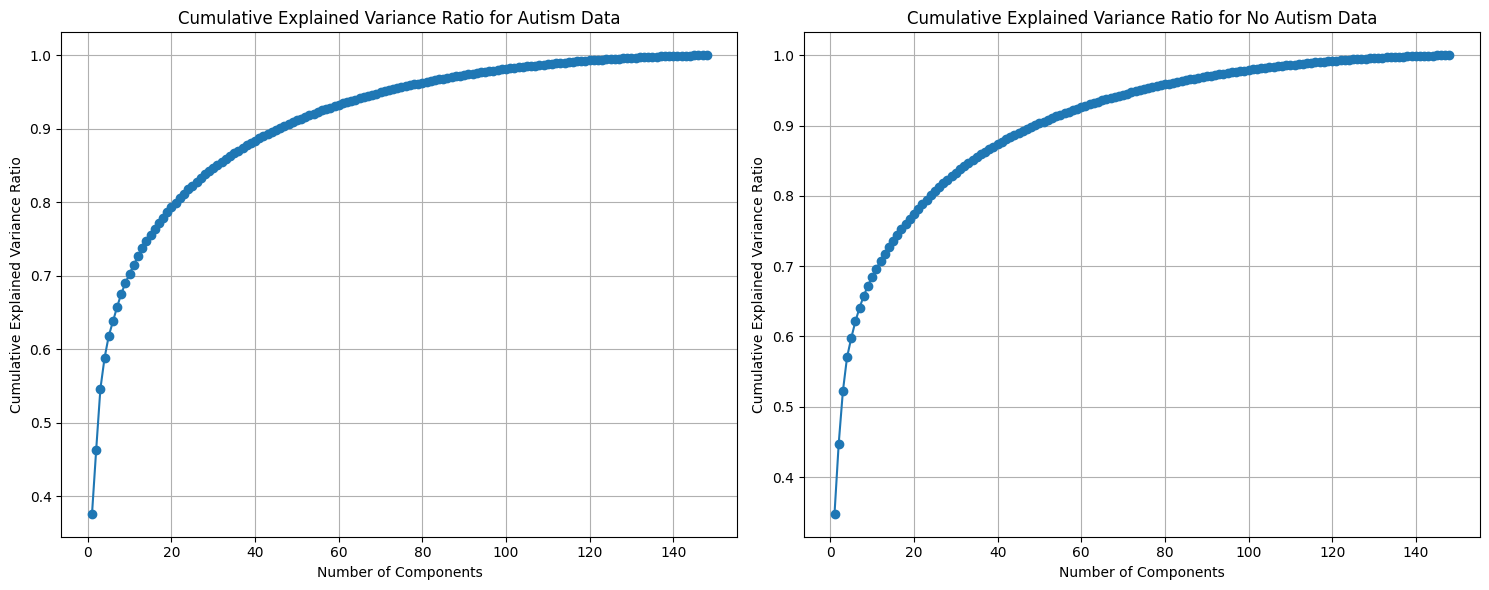

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Extract "data" arrays from data_info_dict_autism
autism_data_arrays = [entry["data"] for entry in data_info_dict_autism.values()]

# Extract "data" arrays from data_info_dict_no_autism
no_autism_data_arrays = [entry["data"] for entry in data_info_dict_no_autism.values()]

# Create a matrix by stacking the arrays for both groups
autism_data_matrix = np.vstack(autism_data_arrays)
no_autism_data_matrix = np.vstack(no_autism_data_arrays)

# Fit PCA for autism data
pca_autism = PCA()
pca_autism.fit(autism_data_matrix)

# Fit PCA for non autism data
pca_no_autism = PCA()
pca_no_autism.fit(no_autism_data_matrix)

# Calculate cumulative explained variance ratio for autism data
cumulative_explained_variance_autism = np.cumsum(pca_autism.explained_variance_ratio_)

# Calculate cumulative explained variance ratio for non autism data
cumulative_explained_variance_no_autism = np.cumsum(pca_no_autism.explained_variance_ratio_)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot cumulative explained variance ratio for autism data
axs[0].plot(range(1, len(cumulative_explained_variance_autism) + 1), cumulative_explained_variance_autism, marker='o')
axs[0].set_xlabel('Number of Components')
axs[0].set_ylabel('Cumulative Explained Variance Ratio')
axs[0].set_title('Cumulative Explained Variance Ratio for Autism Data')
axs[0].grid()

# Plot cumulative explained variance ratio for non autism data
axs[1].plot(range(1, len(cumulative_explained_variance_no_autism) + 1), cumulative_explained_variance_no_autism, marker='o')
axs[1].set_xlabel('Number of Components')
axs[1].set_ylabel('Cumulative Explained Variance Ratio')
axs[1].set_title('Cumulative Explained Variance Ratio for No Autism Data')
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()


We see somewhat and elbow following the 4th component. However, one could also argue in favor of three components, as there is a stark decrease following this component. Let's inspect the option with four components.

Let's zoom in a little.

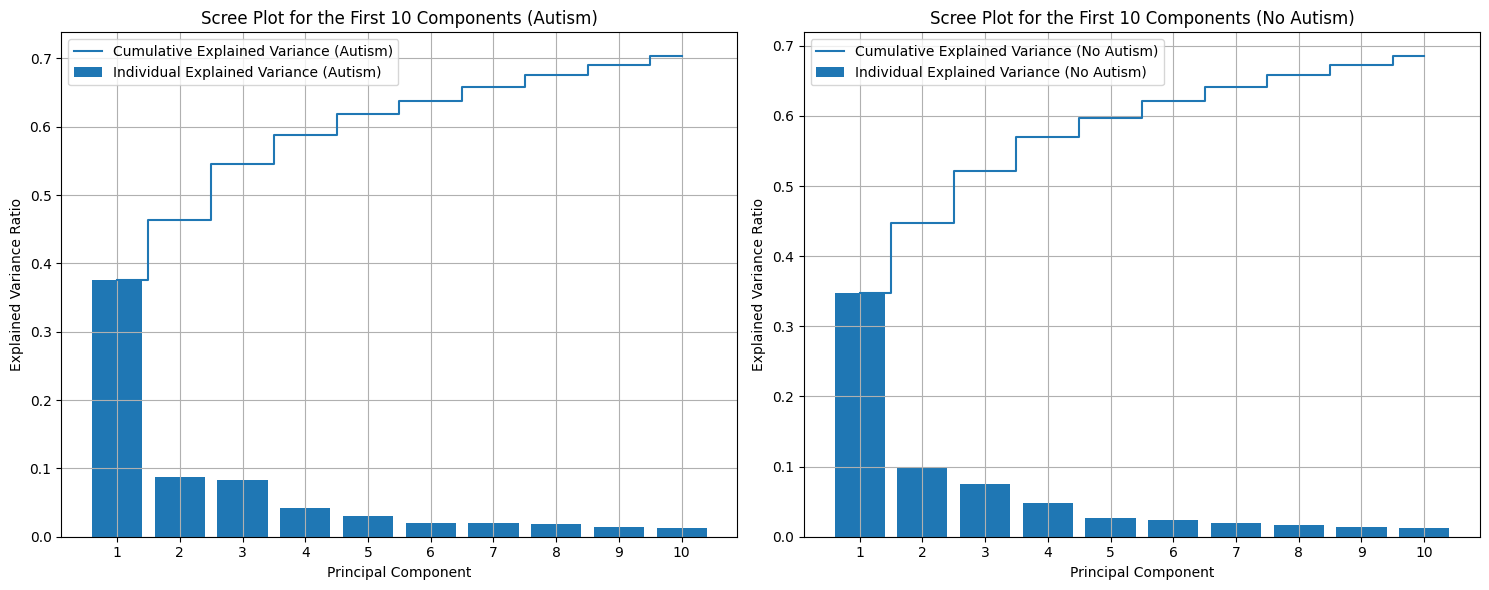

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# Extract "data" arrays from data_info_dict_autism
autism_data_arrays = [entry["data"] for entry in data_info_dict_autism.values()]

# Extract "data" arrays from data_info_dict_no_autism
no_autism_data_arrays = [entry["data"] for entry in data_info_dict_no_autism.values()]

# Create a matrix by stacking the arrays for autism and non autism groups
autism_data_matrix = np.vstack(autism_data_arrays)
no_autism_data_matrix = np.vstack(no_autism_data_arrays)

# Fit PCA with the first 10 components for autism data
n_components = 10
pca_autism = PCA(n_components=n_components)
pca_autism.fit(autism_data_matrix)

# Fit PCA with the first 10 components for non autism data
pca_no_autism = PCA(n_components=n_components)
pca_no_autism.fit(no_autism_data_matrix)

# Scree plot for the first 10 components side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Autism data scree plot
explained_variance_autism = pca_autism.explained_variance_ratio_
cumulative_explained_variance_autism = np.cumsum(explained_variance_autism)

axs[0].bar(range(1, n_components + 1), explained_variance_autism, align='center', label='Individual Explained Variance (Autism)')
axs[0].step(range(1, n_components + 1), cumulative_explained_variance_autism, where='mid', label='Cumulative Explained Variance (Autism)')
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Explained Variance Ratio')
axs[0].set_title('Scree Plot for the First 10 Components (Autism)')
axs[0].set_xticks(range(1, n_components + 1))
axs[0].legend()
axs[0].grid()

# No Autism data scree plot
explained_variance_no_autism = pca_no_autism.explained_variance_ratio_
cumulative_explained_variance_no_autism = np.cumsum(explained_variance_no_autism)

axs[1].bar(range(1, n_components + 1), explained_variance_no_autism, align='center', label='Individual Explained Variance (No Autism)')
axs[1].step(range(1, n_components + 1), cumulative_explained_variance_no_autism, where='mid', label='Cumulative Explained Variance (No Autism)')
axs[1].set_xlabel('Principal Component')
axs[1].set_ylabel('Explained Variance Ratio')
axs[1].set_title('Scree Plot for the First 10 Components (No Autism)')
axs[1].set_xticks(range(1, n_components + 1))
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


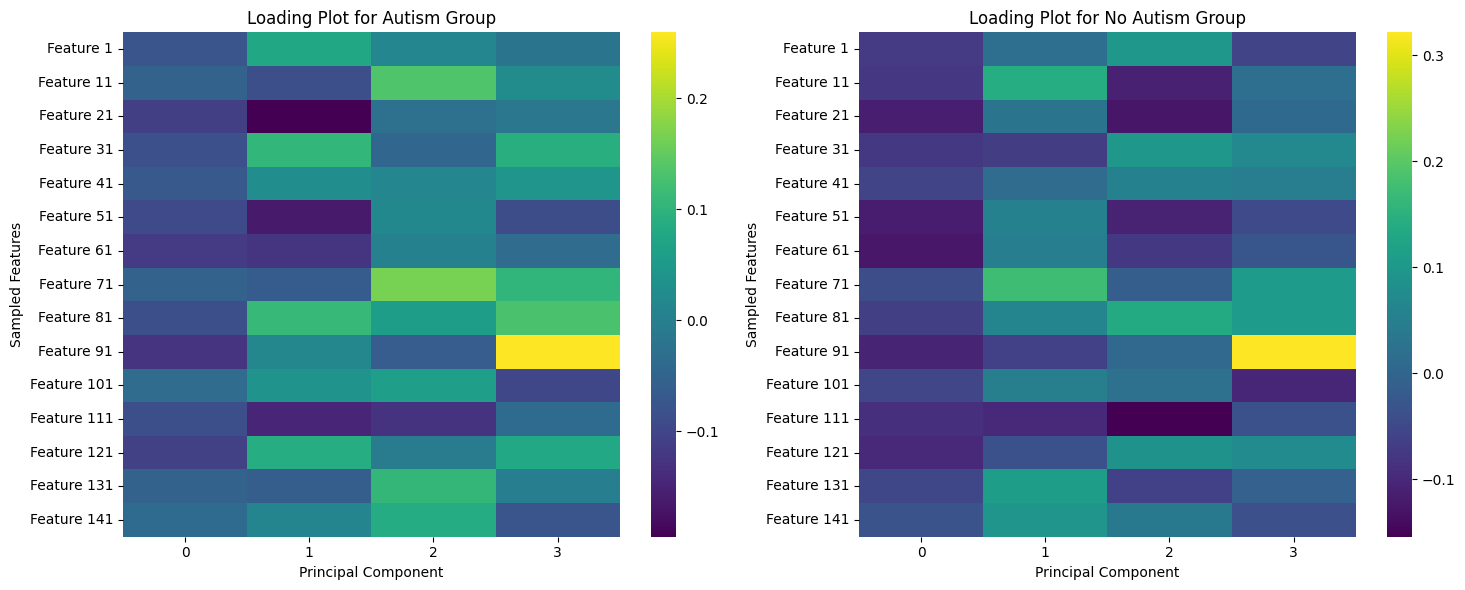

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Extract "data" arrays from dictionaries
autism_data_arrays = [entry["data"] for entry in data_info_dict_autism.values()]
no_autism_data_arrays = [entry["data"] for entry in data_info_dict_no_autism.values()]

# Convert arrays into matrices
autism_data_matrix = np.vstack(autism_data_arrays)
no_autism_data_matrix = np.vstack(no_autism_data_arrays)

# Specify the desired number of features
num_desired_features = 4  # You can adjust this number

# Create PCA instances for both groups
pca_autism = PCA(n_components=num_desired_features)
pca_no_autism = PCA(n_components=num_desired_features)

# Fit and transform "data" arrays for both groups
pca_autism_result = pca_autism.fit_transform(autism_data_matrix)
pca_no_autism_result = pca_no_autism.fit_transform(no_autism_data_matrix)

# Sample a subset of features for plotting (e.g., every 10th feature)
sampled_features_indices = np.arange(0, autism_data_matrix.shape[1], step=10)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Loading plot for autism group
sns.heatmap(pca_autism.components_.T[sampled_features_indices], cmap='viridis', yticklabels=['Feature {}'.format(i+1) for i in sampled_features_indices], ax=axs[0])
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Sampled Features')
axs[0].set_title('Loading Plot for Autism Group')

# Loading plot for no autism group
sns.heatmap(pca_no_autism.components_.T[sampled_features_indices], cmap='viridis', yticklabels=['Feature {}'.format(i+1) for i in sampled_features_indices], ax=axs[1])
axs[1].set_xlabel('Principal Component')
axs[1].set_ylabel('Sampled Features')
axs[1].set_title('Loading Plot for No Autism Group')

# Adjust layout
plt.tight_layout()
plt.show()


It is interesting to see that the second and third component have a different loading pattern.

In [ ]:
#Find the number of components where cumulative explained variance falls under 1
# Find the number of components to explain 80% of the variance
num_components_80_percent_autism = np.argmax(cumulative_explained_variance_autism >= 0.80) + 1
num_components_80_percent_no_autism = np.argmax(cumulative_explained_variance_no_autism >= 0.80) + 1

# Get the eigenvalues of the first 4 components for both groups
eigenvalues_autism = pca_autism.explained_variance_[:4]
eigenvalues_no_autism = pca_no_autism.explained_variance_[:4]

# Print the eigenvalues
print(f"Number of components for Autism Group where cumulative explained variance falls under 1: {num_components_80_percent_autism}")
print("Eigenvalues for Autism Group:")
for i, eigenvalue in enumerate(eigenvalues_autism):
    print(f"Component {i+1}: {eigenvalue:.4f}")


print(f"\nNumber of components for No Autism Group where cumulative explained variance falls under 1: {num_components_80_percent_no_autism}")
print("Eigenvalues for No Autism Group:")
for i, eigenvalue in enumerate(eigenvalues_no_autism):
    print(f"Component {i+1}: {eigenvalue:.4f}")


Number of components for Autism Group where cumulative explained variance falls under 1: 46
Eigenvalues for Autism Group:
Component 1: 11.2743
Component 2: 2.6192
Component 3: 2.4748
Component 4: 1.2665

Number of components for No Autism Group where cumulative explained variance falls under 1: 49
Eigenvalues for No Autism Group:
Component 1: 8.8548
Component 2: 2.5343
Component 3: 1.9057
Component 4: 1.2358


Based on this, the eigenvalues for the 4th component are still above 1 in both groups. According to Kaiser's criterium, one could already choose at least 4. The screeplot suggests 3 or 4 components. The original publication used 2 components, I am going to use 4 components per sample. Here is the reasoning:

I expect the non-linear nature of the model to work better with less dimensions. Introducing an additional classifier and more information later however, will likely benefit from more latent variables.

In particular, the introduction of gender and age may lead to two of the latent variables to be optimized to represent information of this nature. As to not underfit, I am therefore chosing 4 components for each of the autoencoders.

Number of components to explain 80% of the variance: 24


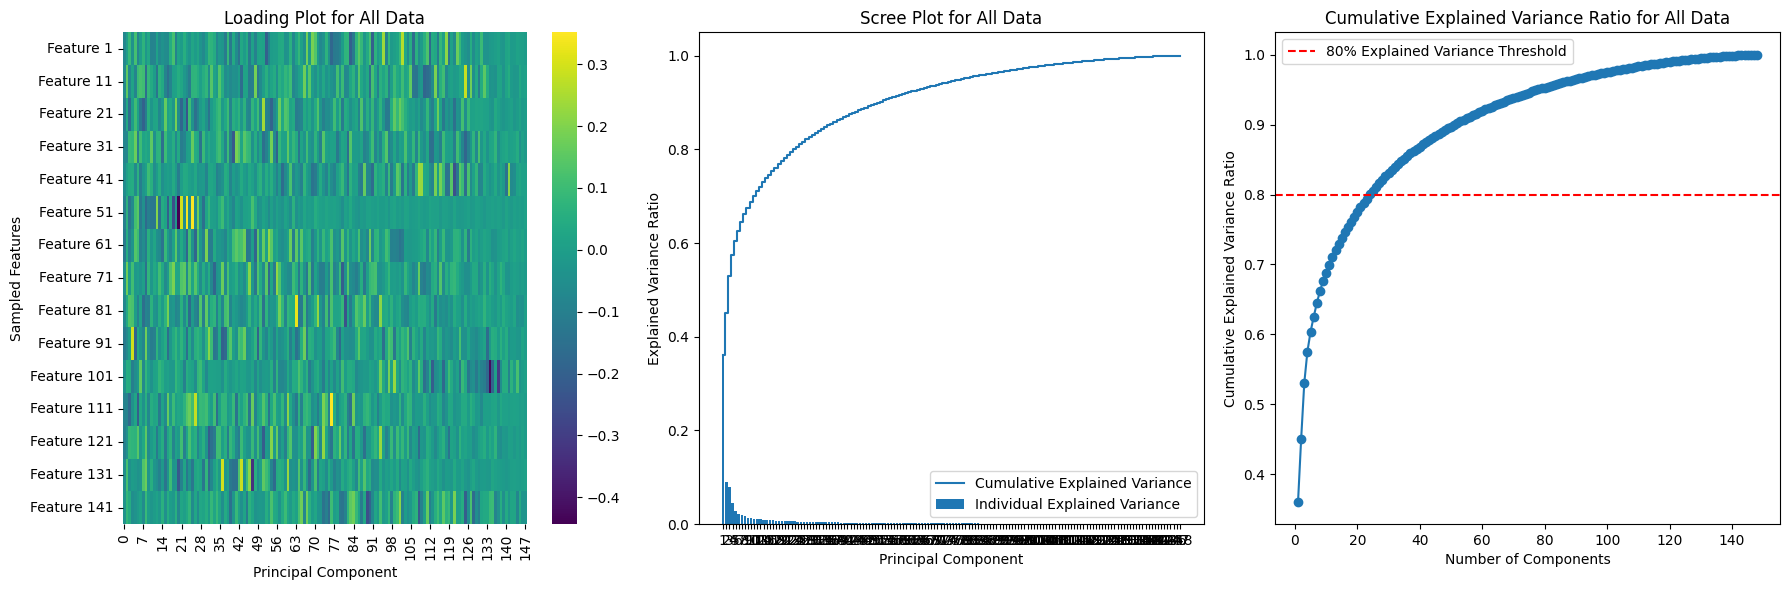

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Extract "data" arrays from dictionaries
autism_data_arrays = [entry["data"] for entry in data_info_dict_autism.values()]
no_autism_data_arrays = [entry["data"] for entry in data_info_dict_no_autism.values()]

# Convert arrays into matrices for both groups
autism_data_matrix = np.vstack(autism_data_arrays)
no_autism_data_matrix = np.vstack(no_autism_data_arrays)

# Concatenate data matrices for both groups
all_data_matrix = np.vstack((autism_data_matrix, no_autism_data_matrix))

# Create PCA instance for the whole dataset
pca_all = PCA()
pca_all.fit(all_data_matrix)

# Calculate cumulative explained variance ratio
cumulative_explained_variance_all = np.cumsum(pca_all.explained_variance_ratio_)

# Find the number of components to explain 80% of the variance
num_components_80_percent_all = np.argmax(cumulative_explained_variance_all >= 0.80) + 1

print(f"Number of components to explain 80% of the variance: {num_components_80_percent_all}")

# Sample a subset of features for loading plots (e.g., every 10th feature)
sampled_features_indices = np.arange(0, all_data_matrix.shape[1], step=10)

# Create subplots for loading plots and scree plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Loading plot for all data
sns.heatmap(pca_all.components_.T[sampled_features_indices], cmap='viridis', yticklabels=['Feature {}'.format(i+1) for i in sampled_features_indices], ax=axs[0])
axs[0].set_xlabel('Principal Component')
axs[0].set_ylabel('Sampled Features')
axs[0].set_title('Loading Plot for All Data')

# Scree plot
explained_variance = pca_all.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
axs[1].bar(range(1, len(explained_variance) + 1), explained_variance, align='center', label='Individual Explained Variance')
axs[1].step(range(1, len(explained_variance) + 1), cumulative_explained_variance, where='mid', label='Cumulative Explained Variance')
axs[1].set_xlabel('Principal Component')
axs[1].set_ylabel('Explained Variance Ratio')
axs[1].set_title('Scree Plot for All Data')
axs[1].set_xticks(range(1, len(explained_variance) + 1))
axs[1].legend()

# Cumulative explained variance plot
axs[2].plot(range(1, len(cumulative_explained_variance_all) + 1), cumulative_explained_variance_all, marker='o')
axs[2].axhline(y=0.8, color='r', linestyle='--', label='80% Explained Variance Threshold')
axs[2].set_xlabel('Number of Components')
axs[2].set_ylabel('Cumulative Explained Variance Ratio')
axs[2].set_title('Cumulative Explained Variance Ratio for All Data')
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()


## Model specifications

In the following I am specifiying the model. I am roughly orienting myself around a paper from Anglinkas, Hartshorne & Anzellotti (2022).

### Defining utility functions

Firstly, I am defining the loss function.
The loss will be computed as the sum of the BCE-Loss, as well as the KL-divergence terms.

* MSE loss: Incoming

* Cross Entropy: Incoming

* Kullback-Leibler divergence (Kullback & Leibler, 1951) This is a measure for the difference between two distributions. I.e. "how much do they diverge" from each other, how much are they different to each other. The introduction of this term into the final loss leads my model to optimize not only if the precited categories are correct and so on, but also how high the difference between the prior distribution and teh latent variables are. The prior distribution in my case is an isotropic gaussian.
  * Why is this desirable? The latent variables and the sampling process should be somewhat controlled. This divergence regulates this.


I have also attempted to regulate that a loss is only completed with the KL divergence from the second encoder if that encoder was used.

In [10]:
def final_loss(MSE, CE, MSE_age, z_mu, z_logvar, s_mu, s_logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: reconstruction loss
    :param z_mu: mean from the latent vector of encoder_z
    :param z_logvar: log variance from the latent vector of encoder_z
    :param s_mu: mean from the latent vector of encoder_s (optional)
    :param s_logvar: log variance from the latent vector of encoder_s (optional)
    """
    mse_loss = MSE
    mse_age = MSE_age
    cross_entropy = CE
    KLD_z = -0.5 * torch.sum(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())
    if s_mu is not None and s_logvar is not None:
        KLD_s = -0.5 * torch.sum(1 + s_logvar - s_mu.pow(2) - s_logvar.exp())
        return mse_loss + KLD_z + KLD_s + cross_entropy + mse_age
    else:
        return mse_loss + KLD_z + cross_entropy + mse_age


Here is the training loop. This model is supposed to achieve multiple things:

* Train the cVAE using the MSE loss.
* Incoming.


In [73]:
from tqdm import tqdm

def train(model, dataloader, dataset, device, optimizer, criterion, criterion_classifier):
    model.train()
    running_loss_autism = 0.0
    running_loss_no_autism = 0.0
    running_age_loss_autism = 0.0
    running_gender_loss_autism = 0.0
    running_age_loss_no_autism = 0.0
    running_gender_loss_no_autism = 0.0
    counter = 0

    total_batches = len(dataset) // dataloader.batch_size

    for i, ((autism_data, autism_age, autism_gender, autism_diag_group), (no_autism_data, no_autism_age, no_autism_gender,  no_autism_diag_group)) in tqdm(enumerate(dataloader), total=total_batches):
        autism_data = autism_data.to(device)
        no_autism_data = no_autism_data.to(device)

        autism_age = autism_age.to(device)
        autism_gender = autism_gender.to(device)

        no_autism_age = no_autism_age.to(device)
        no_autism_gender = no_autism_gender.to(device)

        optimizer.zero_grad()

        # Get the model outputs
        z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, class_autism_age, class_autism_gender, class_no_autism_age, class_no_autism_gender = model(autism_data, no_autism_data)

        # Print the range of gender predictions
        print(f"Gender predictions range: {class_autism_gender.min().item()}, {class_autism_gender.max().item()}")

        if torch.isnan(class_autism_gender).any() or torch.isnan(autism_gender.unsqueeze(1)).any():
          print("NaN values found in gender predictions")
          print("class_autism_gender:", class_autism_gender)
          print("autism_gender.unsqueeze(1):", autism_gender.unsqueeze(1))


        # Calculate classifier losses for age and gender predictions
        age_loss_autism = criterion(class_autism_age, autism_age.unsqueeze(1))
        gender_loss_autism = criterion_classifier(class_autism_gender, autism_gender.unsqueeze(1).float())

        age_loss_no_autism = criterion(class_no_autism_age, no_autism_age.unsqueeze(1))
        gender_loss_no_autism = criterion_classifier(class_no_autism_gender, no_autism_gender.unsqueeze(1).float())


        # Section for the autism images
        bce_loss_autism = criterion(reconstructed_data_autism, autism_data)
        loss_autism = final_loss(bce_loss_autism,  gender_loss_autism, age_loss_autism, z_mean, z_log_var, s_mean, s_log_var)
        running_loss_autism += loss_autism.item()
        running_age_loss_autism += age_loss_autism.item()
        running_gender_loss_autism += gender_loss_autism.item()

        # Section for the no_autism images
        bce_loss_no_autism = criterion(reconstructed_data_no_autism, no_autism_data)
        s_mean_no_autism, s_log_var_no_autism = None, None
        loss_no_autism = final_loss(bce_loss_no_autism,  gender_loss_no_autism, age_loss_no_autism, z_mean_no_autism, z_log_var_no_autism, s_mean_no_autism, s_log_var_no_autism)
        running_loss_no_autism += loss_no_autism.item()
        running_age_loss_no_autism += age_loss_no_autism.item()
        running_gender_loss_no_autism += gender_loss_no_autism.item()

        # Total loss
        loss_no_autism.backward()
        loss_autism.backward()

        optimizer.step()
        counter += len(autism_data) + len(no_autism_data)

    train_loss_autism = running_loss_autism / counter
    train_loss_no_autism = running_loss_no_autism / counter
    train_age_loss_autism = running_age_loss_autism / counter
    train_gender_loss_autism = running_gender_loss_autism / counter
    train_age_loss_no_autism = running_age_loss_no_autism / counter
    train_gender_loss_no_autism = running_gender_loss_no_autism / counter

    return train_loss_autism, train_loss_no_autism, train_age_loss_autism, train_gender_loss_autism, train_age_loss_no_autism, train_gender_loss_no_autism


And of course the corresponding validation function


In [71]:
def validate(model, dataloader, dataset, device, criterion, criterion_classifier):
    model.eval()  # Set the model to evaluation mode
    running_loss_autism = 0.0
    running_loss_no_autism = 0.0
    running_age_loss_autism = 0.0
    running_gender_loss_autism = 0.0
    running_age_loss_no_autism = 0.0
    running_gender_loss_no_autism = 0.0
    counter = 0

    total_batches = len(dataset) // dataloader.batch_size

    with torch.no_grad():  # Disable gradient calculation during validation
        for i, ((autism_data, autism_age, autism_gender, autism_diag_group), (no_autism_data, no_autism_age, no_autism_gender, no_autism_diag_group)) in tqdm(enumerate(dataloader), total=total_batches):
            autism_data = autism_data.to(device)
            no_autism_data = no_autism_data.to(device)

            autism_age = autism_age.to(device)
            autism_gender = autism_gender.to(device)

            no_autism_age = no_autism_age.to(device)
            no_autism_gender = no_autism_gender.to(device)

            # Get the model outputs
            z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, class_autism_age, class_autism_gender, class_no_autism_age, class_no_autism_gender = model(autism_data, no_autism_data)

            # Calculate classifier losses for age and gender predictions
            age_loss_autism = criterion(class_autism_age, autism_age.unsqueeze(1))
            gender_loss_autism = criterion_classifier(class_autism_gender, autism_gender.unsqueeze(1).float())

            age_loss_no_autism = criterion(class_no_autism_age, no_autism_age.unsqueeze(1))
            gender_loss_no_autism = criterion_classifier(class_no_autism_gender, no_autism_gender.unsqueeze(1).float())

            # Section for the autism images
            bce_loss_autism = criterion(reconstructed_data_autism, autism_data)
            loss_autism = final_loss(bce_loss_autism, gender_loss_autism, age_loss_autism, z_mean, z_log_var, s_mean, s_log_var)
            running_loss_autism += loss_autism.item()
            running_age_loss_autism += age_loss_autism.item()
            running_gender_loss_autism += gender_loss_autism.item()

            # Section for the no_autism images
            bce_loss_no_autism = criterion(reconstructed_data_no_autism, no_autism_data)
            s_mean_no_autism, s_log_var_no_autism = None, None
            loss_no_autism = final_loss(bce_loss_no_autism, gender_loss_no_autism, age_loss_no_autism, z_mean_no_autism, z_log_var_no_autism, s_mean_no_autism, s_log_var_no_autism)
            running_loss_no_autism += loss_no_autism.item()
            running_age_loss_no_autism += age_loss_no_autism.item()
            running_gender_loss_no_autism += gender_loss_no_autism.item()

            counter += len(autism_data) + len(no_autism_data)

    val_loss_autism = running_loss_autism / counter
    val_loss_no_autism = running_loss_no_autism / counter
    val_age_loss_autism = running_age_loss_autism / counter
    val_gender_loss_autism = running_gender_loss_autism / counter
    val_age_loss_no_autism = running_age_loss_no_autism / counter
    val_gender_loss_no_autism = running_gender_loss_no_autism / counter

    return (
        val_loss_autism, val_loss_no_autism,
        val_age_loss_autism, val_gender_loss_autism,
        val_age_loss_no_autism, val_gender_loss_no_autism
    )


## Model specification
Next I want to define the contrastive variational autoencoder. While doing so, I am defining seperate encoders, to make it easier to later introduce other encoders. I am orienting myself on an cVAE I have written in the past.

As the paper from Aglinskas, Hartshorne and Anzellotti (2022) I mentioned, the network will have only a few layers.

A few things I will probably have to change - I do not know how many channels the data will end up having. therefore I am using one, assuming it only has one.

In [91]:
class EncoderNS(nn.Module):
    def __init__(self, input_dimension, latent_dim):
        super(EncoderNS, self).__init__()
        self.linear1 = nn.Linear(input_dimension, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 4)
        self.ns_fc_mean = nn.Linear(latent_dim, latent_dim)
        self.ns_fc_log_var = nn.Linear(latent_dim, latent_dim)

    def forward(self, x, batch_size):
        h = F.relu(self.linear1(x))
        h = F.relu(self.linear2(h))
        h = F.relu(self.linear3(h))
        ns_mean = self.ns_fc_mean(h)
        ns_log_var = self.ns_fc_log_var(h)
        return ns_mean, ns_log_var


class EncoderS(nn.Module):
    def __init__(self, input_dimension, latent_dim):
        super(EncoderS, self).__init__()
        self.linear1 = nn.Linear(input_dimension, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 4)
        self.s_fc_mean = nn.Linear(latent_dim, latent_dim)
        self.s_fc_log_var = nn.Linear(latent_dim, latent_dim)

    def forward(self, x, batch_size):
        h = F.relu(self.linear1(x))
        h = F.relu(self.linear2(h))
        h = F.relu(self.linear3(h))
        s_mean = self.s_fc_mean(h)
        s_log_var = self.s_fc_log_var(h)
        return s_mean, s_log_var

class Decoder(nn.Module):
    def __init__(self, input_dimension, latent_dim):
        super(Decoder, self).__init__()
        self.linear_decoder_1 = nn.Linear(latent_dim*2, 32)
        self.linear_decoder_2 = nn.Linear(32,64)
        self.linear_decoder_3 = nn.Linear(64, input_dimension)

    def forward(self, zs, batch_size):
        h_output = F.relu(self.linear_decoder_1(zs))
        h_output = F.relu(self.linear_decoder_2(h_output))
        output = F.relu(self.linear_decoder_3(h_output))
        return output

class Classifier(nn.Module):
    def __init__(self, latent_dim):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(latent_dim*2, latent_dim // 2)
        self.fc_age = nn.Linear(latent_dim // 2, 1)
        self.fc_gender = nn.Linear(latent_dim // 2, 1)

    def forward(self, z):
        x = self.fc1(z)
        print(x)
        age_prediction = self.fc_age(x)
        gender_prediction = torch.sigmoid(self.fc_gender(x))  # Apply sigmoid activation for binary gender prediction
        print(gender_prediction.shape)
        return age_prediction, gender_prediction

class cVAE_classifier(nn.Module):
    def __init__(self, input_dimension, latent_dim):
        super(cVAE_classifier, self).__init__()
        self.encoder_z = EncoderNS(input_dimension, latent_dim)
        self.encoder_s = EncoderS(input_dimension, latent_dim)
        self.decoder = Decoder(input_dimension, latent_dim)
        self.classifier = Classifier(latent_dim)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mean + epsilon * std

    def forward(self, autism, no_autism):
        batch_size = autism.size(0)
        z_mean, z_log_var = self.encoder_z(autism, batch_size)
        z = self.reparameterize(z_mean, z_log_var)
        s_mean, s_log_var = self.encoder_s(autism, batch_size)
        s = self.reparameterize(s_mean, s_log_var)
        zs = torch.cat([z, s], dim=1)

        reconstructed_data_autism = self.decoder(zs, batch_size)

        z_mean_no_autism, z_log_var_no_autism = self.encoder_z(no_autism, batch_size)
        z_no_autism = self.reparameterize(z_mean_no_autism, z_log_var_no_autism)
        z_empty = torch.zeros(z_no_autism.shape)
        model_device = z_no_autism.device
        z_empty = z_empty.to(model_device)
        z_no_autism_0 = torch.cat([z_no_autism, z_empty], dim=1)


        reconstructed_data_no_autism = self.decoder(z_no_autism_0, batch_size)

        class_autism_age, class_autism_gender = self.classifier(zs)  # Assuming z is the latent variable after concatenating s and z
        class_no_autism_age, class_no_autism_gender = self.classifier(z_no_autism_0)  # Using the version with 0s to have equal lengths of the latent vectors.

        return z_mean, z_log_var, s_mean, s_log_var, z_mean_no_autism, z_log_var_no_autism, reconstructed_data_autism, reconstructed_data_no_autism, class_autism_age, class_autism_gender, class_no_autism_age, class_no_autism_gender

And finally the training loop - note that I have yet to define the validation function:

In [85]:
lr = .05

Epoch 1 of 100


 50%|█████     | 3/6 [00:00<00:00, 29.11it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.5194699764251709, 0.5556011199951172
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.3911321461200714, 0.6806665062904358
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.4560384750366211, 0.5977693200111389
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.43816542625427246, 0.5461801886558533
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.42733097076416016, 0.534288227558136
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.43024787306785583, 0.5127992033958435


7it [00:00, 27.69it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.42335087060928345, 0.4841625988483429


2it [00:00, 48.70it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 14.2163, Train Loss Non-Autism: 2.2468, Train Age Loss Autism: 2.0876, Train Gender Loss Autism: 0.0058, Train Age Loss Non-Autism: 2.1775, Train Gender Loss Non-Autism: 0.0058
Val Loss Autism: 5.7063, Val Loss Non-Autism: 6.8145, Val Age Loss Autism: 5.6044, Val Gender Loss Autism: 0.0059, Val Age Loss Non-Autism: 6.7949, Val Gender Loss Non-Autism: 0.0059
Epoch 2 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.40145769715309143, 0.4755653738975525
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.38131481409072876, 0.4615826904773712
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.30866342782974243, 0.4636087417602539
torch.Size([64, 1])


 67%|██████▋   | 4/6 [00:00<00:00, 34.68it/s]

torch.Size([64, 1])
Gender predictions range: 0.2873617708683014, 0.492801308631897
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.2694723904132843, 0.5020253658294678
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.2301034778356552, 0.4531896710395813
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.18724757432937622, 0.49132052063941956


7it [00:00, 31.88it/s]                       
2it [00:00, 71.28it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 2.0384, Train Loss Non-Autism: 1.9918, Train Age Loss Autism: 1.9417, Train Gender Loss Autism: 0.0047, Train Age Loss Non-Autism: 1.9720, Train Gender Loss Non-Autism: 0.0048
Val Loss Autism: 5.3089, Val Loss Non-Autism: 6.4438, Val Age Loss Autism: 5.2162, Val Gender Loss Autism: 0.0046, Val Age Loss Non-Autism: 6.4216, Val Gender Loss Non-Autism: 0.0049
Epoch 3 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.112132728099823, 0.5735301375389099
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11261042207479477, 0.4461432695388794


 50%|█████     | 3/6 [00:00<00:00, 20.16it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.10747454315423965, 0.5238118767738342
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.08469733595848083, 0.6376166939735413
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.06769345700740814, 0.48962855339050293
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.0603550560772419, 0.4705822169780731


100%|██████████| 6/6 [00:00<00:00, 18.29it/s]

torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.038918111473321915, 0.4644257426261902


7it [00:00, 16.33it/s]                       
2it [00:00, 28.77it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 1.7744, Train Loss Non-Autism: 1.7819, Train Age Loss Autism: 1.6818, Train Gender Loss Autism: 0.0040, Train Age Loss Non-Autism: 1.7575, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 4.7982, Val Loss Non-Autism: 5.7277, Val Age Loss Autism: 4.6912, Val Gender Loss Autism: 0.0041, Val Age Loss Non-Autism: 5.6845, Val Gender Loss Non-Autism: 0.0044
Epoch 4 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.009903555735945702, 0.37448036670684814
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.02372574247419834, 0.46642646193504333


 33%|███▎      | 2/6 [00:00<00:00, 13.05it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.013295489363372326, 0.7511402368545532


 67%|██████▋   | 4/6 [00:00<00:00, 13.79it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.011177483946084976, 0.45163270831108093
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.019560739398002625, 0.4436051845550537
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.005510400049388409, 0.4019754230976105


100%|██████████| 6/6 [00:00<00:00, 11.92it/s]

torch.Size([32, 1])

7it [00:00, 11.87it/s]                       



torch.Size([32, 1])
Gender predictions range: 0.015837593004107475, 0.2465127855539322


2it [00:00, 21.42it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 1.2944, Train Loss Non-Autism: 1.3324, Train Age Loss Autism: 1.1485, Train Gender Loss Autism: 0.0043, Train Age Loss Non-Autism: 1.2489, Train Gender Loss Non-Autism: 0.0047
Val Loss Autism: 3.3733, Val Loss Non-Autism: 4.4210, Val Age Loss Autism: 3.1406, Val Gender Loss Autism: 0.0040, Val Age Loss Non-Autism: 4.2515, Val Gender Loss Non-Autism: 0.0039
Epoch 5 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.014914676547050476, 0.349979966878891
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.01919332891702652, 0.32089748978614807


 33%|███▎      | 2/6 [00:00<00:00, 10.51it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.03424972668290138, 0.3543114960193634


 67%|██████▋   | 4/6 [00:00<00:00, 11.93it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.04340548813343048, 0.33804938197135925
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.0996578112244606, 0.3680589497089386
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15336215496063232, 0.33261755108833313


7it [00:00, 11.51it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.23359543085098267, 0.38389188051223755


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])

2it [00:00, 19.48it/s]               



torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.9184, Train Loss Non-Autism: 0.9113, Train Age Loss Autism: 0.6437, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.7030, Train Gender Loss Non-Autism: 0.0045
Val Loss Autism: 2.2044, Val Loss Non-Autism: 3.0365, Val Age Loss Autism: 1.9166, Val Gender Loss Autism: 0.0044, Val Age Loss Non-Autism: 2.8229, Val Gender Loss Non-Autism: 0.0046
Epoch 6 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17882579565048218, 0.3710142970085144


 33%|███▎      | 2/6 [00:00<00:00,  9.90it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.22113017737865448, 0.40355950593948364


 50%|█████     | 3/6 [00:00<00:00,  9.65it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18633344769477844, 0.3507455289363861


 67%|██████▋   | 4/6 [00:00<00:00,  9.69it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1717022806406021, 0.32634833455085754
torch.Size([64, 1])

 83%|████████▎ | 5/6 [00:00<00:00,  9.65it/s]


torch.Size([64, 1])
Gender predictions range: 0.16980206966400146, 0.31690362095832825
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1337539702653885, 0.3285812437534332
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.11244828999042511, 0.28763461112976074


7it [00:00,  9.75it/s]
2it [00:00, 16.74it/s]


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.9235, Train Loss Non-Autism: 0.7201, Train Age Loss Autism: 0.6714, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.5390, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 2.6967, Val Loss Non-Autism: 3.1140, Val Age Loss Autism: 2.4998, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.9771, Val Gender Loss Non-Autism: 0.0041
Epoch 7 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.08981528133153915, 0.2625288665294647
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.06897994875907898, 0.26083093881607056


 83%|████████▎ | 5/6 [00:00<00:00, 23.24it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.05599182844161987, 0.3134841322898865
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.04348677396774292, 0.2225394994020462
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.05181775614619255, 0.289684534072876


7it [00:00, 22.50it/s]                       


torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.05221318081021309, 0.342542439699173
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.05818470939993858, 0.22568081319332123


2it [00:00, 81.91it/s]               

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.6747, Train Loss Non-Autism: 0.5817, Train Age Loss Autism: 0.5081, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.4643, Train Gender Loss Non-Autism: 0.0046
Val Loss Autism: 2.2993, Val Loss Non-Autism: 3.0081, Val Age Loss Autism: 2.1842, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.9281, Val Gender Loss Non-Autism: 0.0039
Epoch 8 of 100



  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.06372354179620743, 0.2784743010997772
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.0652286559343338, 0.2641465961933136
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.07805868983268738, 0.20369397103786469


 67%|██████▋   | 4/6 [00:00<00:00, 35.71it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.09215518087148666, 0.20881977677345276
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11844435334205627, 0.2198207527399063
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14564844965934753, 0.2140244096517563
torch.Size([32, 1])
torch.Size([32, 1])

7it [00:00, 36.51it/s]                       



Gender predictions range: 0.1492011696100235, 0.20906217396259308


2it [00:00, 79.27it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.5445, Train Loss Non-Autism: 0.4497, Train Age Loss Autism: 0.4555, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.3887, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 1.9403, Val Loss Non-Autism: 2.6371, Val Age Loss Autism: 1.8807, Val Gender Loss Autism: 0.0039, Val Age Loss Non-Autism: 2.5985, Val Gender Loss Non-Autism: 0.0040
Epoch 9 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17345981299877167, 0.2360759675502777
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17829084396362305, 0.2272060364484787
torch.Size([64, 1])
torch.Size([64, 1])

 83%|████████▎ | 5/6 [00:00<00:00, 44.74it/s]


Gender predictions range: 0.1935521811246872, 0.2280193567276001
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.19688287377357483, 0.22557991743087769
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1867060512304306, 0.22663897275924683
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1745978444814682, 0.21865659952163696


7it [00:00, 42.01it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.17562709748744965, 0.2044004201889038


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 52.76it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3753, Train Loss Non-Autism: 0.3460, Train Age Loss Autism: 0.3296, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.3186, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.7196, Val Loss Non-Autism: 2.2212, Val Age Loss Autism: 1.6911, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.2088, Val Gender Loss Non-Autism: 0.0040
Epoch 10 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16563741862773895, 0.2057383805513382
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16343119740486145, 0.1938749998807907
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15976017713546753, 0.18985073268413544
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13993413746356964, 0.18372009694576263


 67%|██████▋   | 4/6 [00:00<00:00, 32.23it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13354313373565674, 0.16978192329406738
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1261271834373474, 0.17280635237693787


7it [00:00, 36.57it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.12498795986175537, 0.16244719922542572


2it [00:00, 116.30it/s]              


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3319, Train Loss Non-Autism: 0.2808, Train Age Loss Autism: 0.3082, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2711, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.5744, Val Loss Non-Autism: 2.0410, Val Age Loss Autism: 1.5527, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.0318, Val Gender Loss Non-Autism: 0.0040
Epoch 11 of 100


7it [00:00, 64.64it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.10999526083469391, 0.17284329235553741
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.10834476351737976, 0.16755102574825287
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11333584785461426, 0.17689946293830872
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1107897162437439, 0.17268335819244385
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11202766001224518, 0.21852818131446838
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13056880235671997, 0.19081705808639526
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.14298805594444275, 0.19690099358558655



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 75.71it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3247, Train Loss Non-Autism: 0.2804, Train Age Loss Autism: 0.3042, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2703, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.4952, Val Loss Non-Autism: 1.9653, Val Age Loss Autism: 1.4779, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 1.9570, Val Gender Loss Non-Autism: 0.0040
Epoch 12 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15172897279262543, 0.2043587565422058
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1496618390083313, 0.19851817190647125
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15109480917453766, 0.19843995571136475


7it [00:00, 59.96it/s]


torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15918448567390442, 0.19420291483402252
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16914068162441254, 0.20434799790382385
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17189878225326538, 0.2003316432237625
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.17272169888019562, 0.19370435178279877


2it [00:00, 84.62it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3008, Train Loss Non-Autism: 0.2655, Train Age Loss Autism: 0.2856, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2581, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6043, Val Loss Non-Autism: 2.1103, Val Age Loss Autism: 1.5900, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1033, Val Gender Loss Non-Autism: 0.0040
Epoch 13 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17722460627555847, 0.19281701743602753
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.178578719496727, 0.19485309720039368
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17453406751155853, 0.18714280426502228
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16888578236103058, 0.18534353375434875
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16965194046497345, 0.1819169968366623
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1662466824054718, 0.17931000888347626


7it [00:00, 54.17it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.16365478932857513, 0.17919908463954926


2it [00:00, 74.06it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2964, Train Loss Non-Autism: 0.2714, Train Age Loss Autism: 0.2826, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2640, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6612, Val Loss Non-Autism: 2.1833, Val Age Loss Autism: 1.6474, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1761, Val Gender Loss Non-Autism: 0.0039
Epoch 14 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15556643903255463, 0.17017343640327454
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14720013737678528, 0.16505196690559387
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.138860821723938, 0.15880638360977173
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13738979399204254, 0.15865260362625122


 67%|██████▋   | 4/6 [00:00<00:00, 35.03it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1377009004354477, 0.16618207097053528
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14329013228416443, 0.16870105266571045
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1489577442407608, 0.17165790498256683


7it [00:00, 37.49it/s]                       
2it [00:00, 89.73it/s]               

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


Train Loss Autism: 0.2975, Train Loss Non-Autism: 0.2736, Train Age Loss Autism: 0.2848, Train Gender Loss Autism: 0.0033, Train Age Loss Non-Autism: 0.2666, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6452, Val Loss Non-Autism: 2.1782, Val Age Loss Autism: 1.6330, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1718, Val Gender Loss Non-Autism: 0.0040
Epoch 15 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.147693932056427, 0.17233522236347198
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14720453321933746, 0.17305423319339752
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1505831927061081, 0.17045851051807404
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15025906264781952, 0.17027707397937775


 67%|██████▋   | 4/6 [00:00<00:00, 37.40it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15472373366355896, 0.17855122685432434


7it [00:00, 39.61it/s]                       

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16080349683761597, 0.18154162168502808
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1664116382598877, 0.18036262691020966



  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 60.94it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3073, Train Loss Non-Autism: 0.2702, Train Age Loss Autism: 0.2955, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2636, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6165, Val Loss Non-Autism: 2.1298, Val Age Loss Autism: 1.6047, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1236, Val Gender Loss Non-Autism: 0.0040
Epoch 16 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17213155329227448, 0.18360352516174316
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17894503474235535, 0.1863044649362564
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18461497128009796, 0.19263750314712524
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17884600162506104, 0.18993578851222992


 83%|████████▎ | 5/6 [00:00<00:00, 44.85it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1727752387523651, 0.1875542402267456


7it [00:00, 45.91it/s]                       


torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16534467041492462, 0.18335945904254913
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.16439814865589142, 0.17829889059066772


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


2it [00:00, 87.84it/s]               


Train Loss Autism: 0.3134, Train Loss Non-Autism: 0.2823, Train Age Loss Autism: 0.3021, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2757, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6148, Val Loss Non-Autism: 2.1383, Val Age Loss Autism: 1.6035, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1322, Val Gender Loss Non-Autism: 0.0040
Epoch 17 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1605062037706375, 0.17968492209911346
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1654205322265625, 0.17980900406837463
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1688283532857895, 0.18545320630073547
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.170767679810524, 0.1854974329471588
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17138276994228363, 0.18105901777744293


 83%|████████▎ | 5/6 [00:00<00:00, 44.47it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1694101244211197, 0.1799629032611847


7it [00:00, 43.55it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1628732830286026, 0.18017451465129852


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


2it [00:00, 79.78it/s]               


Train Loss Autism: 0.3054, Train Loss Non-Autism: 0.2711, Train Age Loss Autism: 0.2945, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2646, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6256, Val Loss Non-Autism: 2.1240, Val Age Loss Autism: 1.6146, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1179, Val Gender Loss Non-Autism: 0.0040
Epoch 18 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15794157981872559, 0.17113250494003296
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1562865823507309, 0.1765342652797699
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15385937690734863, 0.1688867062330246
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15115730464458466, 0.16414429247379303


 83%|████████▎ | 5/6 [00:00<00:00, 44.64it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14589722454547882, 0.1617097705602646
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14292900264263153, 0.16172100603580475
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.14406748116016388, 0.1603700965642929


7it [00:00, 44.65it/s]                       
2it [00:00, 82.46it/s]               

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


Train Loss Autism: 0.3318, Train Loss Non-Autism: 0.2652, Train Age Loss Autism: 0.3213, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.2586, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6242, Val Loss Non-Autism: 2.1290, Val Age Loss Autism: 1.6137, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1228, Val Gender Loss Non-Autism: 0.0039
Epoch 19 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1502695530653, 0.17088595032691956
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15351495146751404, 0.17510958015918732
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15361261367797852, 0.18374374508857727
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1556440144777298, 0.18884752690792084
torch.Size([64, 1])
torch.Size([64, 1])

 83%|████████▎ | 5/6 [00:00<00:00, 46.44it/s]


Gender predictions range: 0.15667250752449036, 0.19093996286392212
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15993008017539978, 0.19313786923885345

7it [00:00, 47.31it/s]                       



torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1665901392698288, 0.1920432597398758


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])


2it [00:00, 92.47it/s]               


torch.Size([40, 1])
Train Loss Autism: 0.3052, Train Loss Non-Autism: 0.2753, Train Age Loss Autism: 0.2951, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.2688, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6169, Val Loss Non-Autism: 2.1589, Val Age Loss Autism: 1.6067, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1527, Val Gender Loss Non-Autism: 0.0040
Epoch 20 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16314846277236938, 0.2010873407125473
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17326532304286957, 0.20622847974300385


 83%|████████▎ | 5/6 [00:00<00:00, 45.94it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17184902727603912, 0.20603646337985992
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1787400245666504, 0.2081766128540039
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18177685141563416, 0.2066817730665207
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17536260187625885, 0.20932480692863464


7it [00:00, 43.28it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.17293962836265564, 0.18981966376304626


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])

2it [00:00, 71.55it/s]               



torch.Size([40, 1])
Train Loss Autism: 0.2995, Train Loss Non-Autism: 0.2809, Train Age Loss Autism: 0.2896, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.2744, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6155, Val Loss Non-Autism: 2.1468, Val Age Loss Autism: 1.6057, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1406, Val Gender Loss Non-Autism: 0.0040
Epoch 21 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1651313155889511, 0.1870388239622116
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15592347085475922, 0.18251550197601318


 83%|████████▎ | 5/6 [00:00<00:00, 44.63it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1561989188194275, 0.1752881407737732
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1529076248407364, 0.17303778231143951
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14866402745246887, 0.169622540473938
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14970946311950684, 0.17033696174621582
torch.Size([32, 1])
torch.Size([32, 1])

7it [00:00, 44.91it/s]                       



Gender predictions range: 0.14921216666698456, 0.16269077360630035


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


2it [00:00, 87.75it/s]               


Train Loss Autism: 0.3017, Train Loss Non-Autism: 0.2651, Train Age Loss Autism: 0.2922, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2586, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.5881, Val Loss Non-Autism: 2.1027, Val Age Loss Autism: 1.5787, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.0966, Val Gender Loss Non-Autism: 0.0039
Epoch 22 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1499713957309723, 0.16750037670135498
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15160728991031647, 0.16536040604114532
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1491325944662094, 0.16751308739185333


 83%|████████▎ | 5/6 [00:00<00:00, 48.39it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14967703819274902, 0.16888342797756195
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14834406971931458, 0.1794947385787964
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15454716980457306, 0.2039939910173416


7it [00:00, 48.58it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.16072656214237213, 0.19945402443408966


2it [00:00, 96.68it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2965, Train Loss Non-Autism: 0.2664, Train Age Loss Autism: 0.2874, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2599, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6095, Val Loss Non-Autism: 2.1251, Val Age Loss Autism: 1.6001, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1189, Val Gender Loss Non-Autism: 0.0040
Epoch 23 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15736551582813263, 0.19411426782608032
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16761381924152374, 0.23103129863739014
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16333159804344177, 0.21281452476978302
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15432649850845337, 0.21447832882404327


 83%|████████▎ | 5/6 [00:00<00:00, 43.99it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.164409339427948, 0.20621007680892944
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17241270840168, 0.2081661969423294
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.16252145171165466, 0.20226071774959564


7it [00:00, 43.33it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 92.77it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2945, Train Loss Non-Autism: 0.2652, Train Age Loss Autism: 0.2857, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2588, Train Gender Loss Non-Autism: 0.0041
Val Loss Autism: 1.6211, Val Loss Non-Autism: 2.1362, Val Age Loss Autism: 1.6121, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1297, Val Gender Loss Non-Autism: 0.0040
Epoch 24 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15740567445755005, 0.18489386141300201
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1406490057706833, 0.16568365693092346
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13948844373226166, 0.1528232842683792
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13319611549377441, 0.14795047044754028
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12624646723270416, 0.14345420897006989


7it [00:00, 46.12it/s]                       


torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12539483606815338, 0.1415257304906845
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.12632261216640472, 0.14045511186122894


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


2it [00:00, 90.86it/s]               


Train Loss Autism: 0.2978, Train Loss Non-Autism: 0.2626, Train Age Loss Autism: 0.2893, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2560, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 1.6092, Val Loss Non-Autism: 2.1431, Val Age Loss Autism: 1.6005, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1368, Val Gender Loss Non-Autism: 0.0039
Epoch 25 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13034866750240326, 0.15532340109348297
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13758447766304016, 0.16283181309700012
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13873101770877838, 0.1666344404220581
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1515691727399826, 0.1729758232831955


 83%|████████▎ | 5/6 [00:00<00:00, 45.19it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1550053209066391, 0.18561020493507385
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1643858551979065, 0.18821561336517334


7it [00:00, 45.02it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1774228811264038, 0.19784019887447357


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 92.77it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2989, Train Loss Non-Autism: 0.2808, Train Age Loss Autism: 0.2906, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2743, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6507, Val Loss Non-Autism: 2.1145, Val Age Loss Autism: 1.6419, Val Gender Loss Autism: 0.0039, Val Age Loss Non-Autism: 2.1079, Val Gender Loss Non-Autism: 0.0040
Epoch 26 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1824602335691452, 0.20499025285243988
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1897539347410202, 0.21162599325180054
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.185552716255188, 0.20360635221004486


 67%|██████▋   | 4/6 [00:00<00:00, 39.78it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18205875158309937, 0.2017023265361786
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1870785504579544, 0.20222066342830658
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17857472598552704, 0.19648566842079163


7it [00:00, 39.84it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.17532293498516083, 0.18860436975955963


2it [00:00, 89.43it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2959, Train Loss Non-Autism: 0.2692, Train Age Loss Autism: 0.2878, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2627, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6162, Val Loss Non-Autism: 2.1423, Val Age Loss Autism: 1.6077, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1358, Val Gender Loss Non-Autism: 0.0040
Epoch 27 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16109831631183624, 0.18500109016895294
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14584678411483765, 0.1690416783094406
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13276958465576172, 0.1753418743610382
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1350412666797638, 0.1684664934873581


 83%|████████▎ | 5/6 [00:00<00:00, 44.78it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13523797690868378, 0.15900227427482605
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1359427571296692, 0.15958258509635925
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1398402601480484, 0.15929962694644928


7it [00:00, 45.69it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])

2it [00:00, 88.37it/s]               



Train Loss Autism: 0.2912, Train Loss Non-Autism: 0.2685, Train Age Loss Autism: 0.2834, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2620, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6004, Val Loss Non-Autism: 2.1365, Val Age Loss Autism: 1.5923, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1301, Val Gender Loss Non-Autism: 0.0039
Epoch 28 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14266003668308258, 0.16209357976913452
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14869022369384766, 0.16803286969661713
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16413304209709167, 0.17819009721279144
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18102237582206726, 0.19607363641262054
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18878448009490967, 0.20441101491451263


7it [00:00, 43.59it/s]                       


torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18881554901599884, 0.208126962184906
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1850428283214569, 0.20420898497104645


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


2it [00:00, 85.63it/s]               


Train Loss Autism: 0.2995, Train Loss Non-Autism: 0.2704, Train Age Loss Autism: 0.2917, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2638, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6460, Val Loss Non-Autism: 2.1693, Val Age Loss Autism: 1.6381, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1632, Val Gender Loss Non-Autism: 0.0040
Epoch 29 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17165984213352203, 0.19928771257400513
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1605493724346161, 0.19046452641487122
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14899542927742004, 0.17776384949684143
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13994808495044708, 0.16664095222949982
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13597425818443298, 0.16477830708026886


 83%|████████▎ | 5/6 [00:00<00:00, 45.48it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11930078268051147, 0.1721734255552292


7it [00:00, 45.55it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.13326404988765717, 0.16461841762065887


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 75.95it/s]               

torch.Size([40, 1])
torch.Size([40, 1])


Train Loss Autism: 0.2986, Train Loss Non-Autism: 0.2618, Train Age Loss Autism: 0.2911, Train Gender Loss Autism: 0.0033, Train Age Loss Non-Autism: 0.2552, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6161, Val Loss Non-Autism: 2.1602, Val Age Loss Autism: 1.6084, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1541, Val Gender Loss Non-Autism: 0.0039
Epoch 30 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1302529275417328, 0.1693202704191208
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12958431243896484, 0.1710910052061081
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13803677260875702, 0.17965896427631378
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13273194432258606, 0.1942732334136963
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14559359848499298, 0.21934548020362854


 83%|████████▎ | 5/6 [00:00<00:00, 46.95it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14817014336585999, 0.21007685363292694
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.15592534840106964, 0.2057616114616394


7it [00:00, 46.24it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 94.29it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2963, Train Loss Non-Autism: 0.2705, Train Age Loss Autism: 0.2889, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2640, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6139, Val Loss Non-Autism: 2.1474, Val Age Loss Autism: 1.6062, Val Gender Loss Autism: 0.0039, Val Age Loss Non-Autism: 2.1411, Val Gender Loss Non-Autism: 0.0040
Epoch 31 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15384064614772797, 0.2250758558511734
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15066489577293396, 0.2046903818845749
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14359939098358154, 0.20972904562950134


 83%|████████▎ | 5/6 [00:00<00:00, 48.20it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13942226767539978, 0.19193245470523834
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12660664319992065, 0.20608127117156982
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12294819951057434, 0.20287255942821503
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.12449721246957779, 0.1943332701921463


7it [00:00, 44.34it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 72.45it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2948, Train Loss Non-Autism: 0.2733, Train Age Loss Autism: 0.2875, Train Gender Loss Autism: 0.0036, Train Age Loss Non-Autism: 0.2668, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6205, Val Loss Non-Autism: 2.1572, Val Age Loss Autism: 1.6129, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1510, Val Gender Loss Non-Autism: 0.0039
Epoch 32 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13712023198604584, 0.21165941655635834
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13479840755462646, 0.23069588840007782
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1469414085149765, 0.24437081813812256


 83%|████████▎ | 5/6 [00:00<00:00, 47.34it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15565922856330872, 0.25476303696632385
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15605951845645905, 0.24924711883068085
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14097382128238678, 0.23194022476673126
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.15451954305171967, 0.23895718157291412


7it [00:00, 47.90it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


2it [00:00, 95.27it/s]               


Train Loss Autism: 0.3064, Train Loss Non-Autism: 0.2703, Train Age Loss Autism: 0.2995, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2638, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6300, Val Loss Non-Autism: 2.1476, Val Age Loss Autism: 1.6228, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1414, Val Gender Loss Non-Autism: 0.0040
Epoch 33 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13352325558662415, 0.2152627855539322
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13376900553703308, 0.21990421414375305
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13168871402740479, 0.21564429998397827
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12757715582847595, 0.20893052220344543
torch.Size([64, 1])

7it [00:00, 48.20it/s]                       



torch.Size([64, 1])
Gender predictions range: 0.11867095530033112, 0.20569740235805511
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13199888169765472, 0.18313054740428925
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1335054636001587, 0.18049366772174835


2it [00:00, 97.76it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2953, Train Loss Non-Autism: 0.2654, Train Age Loss Autism: 0.2884, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2589, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.5935, Val Loss Non-Autism: 2.1269, Val Age Loss Autism: 1.5863, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1207, Val Gender Loss Non-Autism: 0.0039
Epoch 34 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12553934752941132, 0.17566746473312378
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12548072636127472, 0.1676686555147171
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11590138077735901, 0.1575876772403717
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12352048605680466, 0.16012778878211975
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12652546167373657, 0.1560848206281662


7it [00:00, 41.44it/s]                       


torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13843466341495514, 0.17794866859912872
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.14262564480304718, 0.19020190834999084


2it [00:00, 86.67it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2825, Train Loss Non-Autism: 0.2696, Train Age Loss Autism: 0.2757, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2631, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.5952, Val Loss Non-Autism: 2.1210, Val Age Loss Autism: 1.5882, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1149, Val Gender Loss Non-Autism: 0.0040
Epoch 35 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15603341162204742, 0.2022237628698349
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16352079808712006, 0.21282261610031128
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16412454843521118, 0.21630233526229858
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1699836403131485, 0.21624639630317688


 67%|██████▋   | 4/6 [00:00<00:00, 37.46it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17288947105407715, 0.2232867032289505
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16415764391422272, 0.20516368746757507
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.16243883967399597, 0.20709654688835144


7it [00:00, 36.30it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])

2it [00:00, 92.97it/s]               



torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2856, Train Loss Non-Autism: 0.2762, Train Age Loss Autism: 0.2788, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.2698, Train Gender Loss Non-Autism: 0.0041
Val Loss Autism: 1.6373, Val Loss Non-Autism: 2.1634, Val Age Loss Autism: 1.6303, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1573, Val Gender Loss Non-Autism: 0.0040
Epoch 36 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1607968509197235, 0.19577454030513763
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1435505449771881, 0.20455263555049896
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13810892403125763, 0.19369381666183472
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13629169762134552, 0.1737983226776123


 83%|████████▎ | 5/6 [00:00<00:00, 45.27it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13529689610004425, 0.17702975869178772
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1235164925456047, 0.17586806416511536
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1228274405002594, 0.17680899798870087


7it [00:00, 45.40it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])

2it [00:00, 93.55it/s]               



torch.Size([40, 1])
Train Loss Autism: 0.2891, Train Loss Non-Autism: 0.2705, Train Age Loss Autism: 0.2825, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2639, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6127, Val Loss Non-Autism: 2.1425, Val Age Loss Autism: 1.6059, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1364, Val Gender Loss Non-Autism: 0.0040
Epoch 37 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13438665866851807, 0.1877707988023758
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13449308276176453, 0.19061794877052307
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12665125727653503, 0.18341197073459625
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13405078649520874, 0.1867874562740326
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13895189762115479, 0.18748590350151062


 83%|████████▎ | 5/6 [00:00<00:00, 42.22it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1390247792005539, 0.1915731430053711


7it [00:00, 43.87it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.14862287044525146, 0.18864409625530243


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


2it [00:00, 87.59it/s]               


Train Loss Autism: 0.3054, Train Loss Non-Autism: 0.2730, Train Age Loss Autism: 0.2988, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.2665, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.5733, Val Loss Non-Autism: 2.1433, Val Age Loss Autism: 1.5665, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1372, Val Gender Loss Non-Autism: 0.0040
Epoch 38 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16453252732753754, 0.19629959762096405
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.168243408203125, 0.19881197810173035
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17839394509792328, 0.19714820384979248
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18073509633541107, 0.20166943967342377


 83%|████████▎ | 5/6 [00:00<00:00, 48.03it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1848045438528061, 0.19712530076503754
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18869392573833466, 0.19806720316410065


7it [00:00, 47.67it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.18752731382846832, 0.19731460511684418


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


2it [00:00, 83.24it/s]               


Train Loss Autism: 0.2936, Train Loss Non-Autism: 0.2733, Train Age Loss Autism: 0.2872, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2669, Train Gender Loss Non-Autism: 0.0041
Val Loss Autism: 1.6301, Val Loss Non-Autism: 2.0983, Val Age Loss Autism: 1.6234, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.0922, Val Gender Loss Non-Autism: 0.0040
Epoch 39 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17411883175373077, 0.18678103387355804
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16214951872825623, 0.18226157128810883
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15862047672271729, 0.1801714152097702
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15355518460273743, 0.18226489424705505
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14987705647945404, 0.18189361691474915


 83%|████████▎ | 5/6 [00:00<00:00, 46.26it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14224699139595032, 0.18819878995418549
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1366509348154068, 0.17132321000099182


7it [00:00, 47.41it/s]                       
2it [00:00, 99.32it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2920, Train Loss Non-Autism: 0.2630, Train Age Loss Autism: 0.2857, Train Gender Loss Autism: 0.0033, Train Age Loss Non-Autism: 0.2565, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6206, Val Loss Non-Autism: 2.1554, Val Age Loss Autism: 1.6140, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1492, Val Gender Loss Non-Autism: 0.0039
Epoch 40 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12683819234371185, 0.17078275978565216
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11785233020782471, 0.16538205742835999
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11221709102392197, 0.16385643184185028
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12266284972429276, 0.1709664762020111


 83%|████████▎ | 5/6 [00:00<00:00, 46.11it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.10926325619220734, 0.17546267807483673
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11535466462373734, 0.18734432756900787


7it [00:00, 46.32it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.13233189284801483, 0.19341808557510376


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


2it [00:00, 82.03it/s]               


Train Loss Autism: 0.3153, Train Loss Non-Autism: 0.2715, Train Age Loss Autism: 0.3091, Train Gender Loss Autism: 0.0033, Train Age Loss Non-Autism: 0.2649, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 1.5893, Val Loss Non-Autism: 2.1321, Val Age Loss Autism: 1.5828, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1258, Val Gender Loss Non-Autism: 0.0040
Epoch 41 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13372479379177094, 0.20795245468616486
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15194475650787354, 0.22646525502204895
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17513129115104675, 0.23722317814826965
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18947573006153107, 0.2504313290119171
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18471010029315948, 0.2471315562725067


 83%|████████▎ | 5/6 [00:00<00:00, 47.40it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18267638981342316, 0.2410389631986618


7it [00:00, 47.98it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.16084715723991394, 0.23013831675052643


2it [00:00, 93.30it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3024, Train Loss Non-Autism: 0.2603, Train Age Loss Autism: 0.2961, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.2539, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6044, Val Loss Non-Autism: 2.0942, Val Age Loss Autism: 1.5978, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.0878, Val Gender Loss Non-Autism: 0.0040
Epoch 42 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15365272760391235, 0.22778700292110443
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13068273663520813, 0.19041778147220612
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13100534677505493, 0.2014848291873932
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1164097934961319, 0.17682698369026184
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11441163718700409, 0.18177101016044617


 83%|████████▎ | 5/6 [00:00<00:00, 45.93it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.10591184347867966, 0.15920934081077576
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.11610791087150574, 0.15691611170768738


7it [00:00, 43.05it/s]                       
2it [00:00, 90.98it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3029, Train Loss Non-Autism: 0.2720, Train Age Loss Autism: 0.2967, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2654, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6317, Val Loss Non-Autism: 2.1601, Val Age Loss Autism: 1.6252, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1537, Val Gender Loss Non-Autism: 0.0040
Epoch 43 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1135624572634697, 0.15479649603366852
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11993449181318283, 0.15952914953231812
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1272701621055603, 0.1540393829345703
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13125400245189667, 0.16447041928768158


 83%|████████▎ | 5/6 [00:00<00:00, 41.72it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14972592890262604, 0.1722307950258255
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1602858603000641, 0.18742437660694122


7it [00:00, 43.51it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.17636844515800476, 0.1963094025850296


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])

2it [00:00, 80.88it/s]               



torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3018, Train Loss Non-Autism: 0.2670, Train Age Loss Autism: 0.2958, Train Gender Loss Autism: 0.0033, Train Age Loss Non-Autism: 0.2605, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6550, Val Loss Non-Autism: 2.1681, Val Age Loss Autism: 1.6484, Val Gender Loss Autism: 0.0039, Val Age Loss Non-Autism: 2.1615, Val Gender Loss Non-Autism: 0.0040
Epoch 44 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18482066690921783, 0.20119743049144745
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1862335503101349, 0.20077212154865265
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18338453769683838, 0.20264233648777008
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17333875596523285, 0.19263996183872223
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16639964282512665, 0.18517489731311798


 83%|████████▎ | 5/6 [00:00<00:00, 46.02it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15599393844604492, 0.1828659176826477
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.15440741181373596, 0.17952857911586761


7it [00:00, 45.44it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 70.14it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2935, Train Loss Non-Autism: 0.2732, Train Age Loss Autism: 0.2872, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.2668, Train Gender Loss Non-Autism: 0.0041
Val Loss Autism: 1.6092, Val Loss Non-Autism: 2.1177, Val Age Loss Autism: 1.6028, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1114, Val Gender Loss Non-Autism: 0.0040
Epoch 45 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15553593635559082, 0.1804167926311493
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14386990666389465, 0.1819579005241394
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15170428156852722, 0.18474805355072021
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15180155634880066, 0.18363280594348907


 83%|████████▎ | 5/6 [00:00<00:00, 46.11it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15095552802085876, 0.1816084086894989
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14870499074459076, 0.1748623251914978
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.15048463642597198, 0.17714044451713562

7it [00:00, 44.44it/s]                       


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 67.57it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2925, Train Loss Non-Autism: 0.2662, Train Age Loss Autism: 0.2864, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2597, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.5991, Val Loss Non-Autism: 2.1171, Val Age Loss Autism: 1.5926, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1108, Val Gender Loss Non-Autism: 0.0039
Epoch 46 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14797861874103546, 0.17957191169261932
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14882740378379822, 0.17856968939304352
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14192447066307068, 0.17792578041553497
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14149455726146698, 0.18296678364276886


 67%|██████▋   | 4/6 [00:00<00:00, 34.89it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15099284052848816, 0.17884767055511475
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.158184215426445, 0.18331094086170197
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1638708859682083, 0.19135795533657074


7it [00:00, 36.17it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 88.10it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3046, Train Loss Non-Autism: 0.2680, Train Age Loss Autism: 0.2985, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2615, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6376, Val Loss Non-Autism: 2.1591, Val Age Loss Autism: 1.6312, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1530, Val Gender Loss Non-Autism: 0.0040
Epoch 47 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16522982716560364, 0.18304204940795898
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17312496900558472, 0.18611764907836914
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17093266546726227, 0.18659134209156036
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1777273267507553, 0.1868889331817627
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1754976063966751, 0.18446923792362213


7it [00:00, 48.88it/s]                       


torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16916850209236145, 0.1810155212879181
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.16644874215126038, 0.17652589082717896


2it [00:00, 101.35it/s]              


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2949, Train Loss Non-Autism: 0.2618, Train Age Loss Autism: 0.2889, Train Gender Loss Autism: 0.0033, Train Age Loss Non-Autism: 0.2553, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.5897, Val Loss Non-Autism: 2.1324, Val Age Loss Autism: 1.5832, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1257, Val Gender Loss Non-Autism: 0.0039
Epoch 48 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1528235375881195, 0.16810248792171478
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1407601684331894, 0.1617499738931656
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13528107106685638, 0.15855461359024048
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13491833209991455, 0.15758292376995087


 83%|████████▎ | 5/6 [00:00<00:00, 43.00it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14317898452281952, 0.1617787480354309
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1481945514678955, 0.16328808665275574


7it [00:00, 44.12it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.15611934661865234, 0.16685174405574799


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 87.22it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2853, Train Loss Non-Autism: 0.2707, Train Age Loss Autism: 0.2793, Train Gender Loss Autism: 0.0033, Train Age Loss Non-Autism: 0.2641, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6418, Val Loss Non-Autism: 2.1405, Val Age Loss Autism: 1.6353, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1341, Val Gender Loss Non-Autism: 0.0039
Epoch 49 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16016264259815216, 0.17058609426021576
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15943250060081482, 0.1657143384218216
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1558685153722763, 0.16338738799095154
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15766528248786926, 0.16472288966178894
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1619599163532257, 0.17160163819789886


 83%|████████▎ | 5/6 [00:00<00:00, 44.25it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16550762951374054, 0.18536385893821716
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1635640263557434, 0.18479607999324799


7it [00:00, 45.13it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 91.05it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2874, Train Loss Non-Autism: 0.2695, Train Age Loss Autism: 0.2814, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2629, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6400, Val Loss Non-Autism: 2.1842, Val Age Loss Autism: 1.6337, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1781, Val Gender Loss Non-Autism: 0.0040
Epoch 50 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1674007773399353, 0.19680017232894897
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17006243765354156, 0.19719469547271729
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16517095267772675, 0.1977836936712265


 83%|████████▎ | 5/6 [00:00<00:00, 47.81it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15698783099651337, 0.1930805742740631
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15850679576396942, 0.18794798851013184
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15979190170764923, 0.1861499696969986


7it [00:00, 47.70it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1582195907831192, 0.1981412172317505


2it [00:00, 85.79it/s]               

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


Train Loss Autism: 0.3019, Train Loss Non-Autism: 0.2725, Train Age Loss Autism: 0.2958, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.2661, Train Gender Loss Non-Autism: 0.0041
Val Loss Autism: 1.6573, Val Loss Non-Autism: 2.1943, Val Age Loss Autism: 1.6510, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1883, Val Gender Loss Non-Autism: 0.0040
Epoch 51 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15528613328933716, 0.18536004424095154
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15274979174137115, 0.17834222316741943
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.153658926486969, 0.17818869650363922
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15018129348754883, 0.1766211837530136


 83%|████████▎ | 5/6 [00:00<00:00, 48.37it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1548963338136673, 0.17820684611797333
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16029518842697144, 0.17895415425300598


7it [00:00, 48.49it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1560419350862503, 0.18388862907886505


2it [00:00, 97.20it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3012, Train Loss Non-Autism: 0.2616, Train Age Loss Autism: 0.2952, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2551, Train Gender Loss Non-Autism: 0.0041
Val Loss Autism: 1.5814, Val Loss Non-Autism: 2.1127, Val Age Loss Autism: 1.5750, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1062, Val Gender Loss Non-Autism: 0.0040
Epoch 52 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1543828248977661, 0.18236395716667175
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15237006545066833, 0.17845605313777924
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14808209240436554, 0.1696750372648239
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1491335928440094, 0.16846825182437897
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1481090784072876, 0.16669760644435883


 83%|████████▎ | 5/6 [00:00<00:00, 41.67it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15522579848766327, 0.1793087124824524


7it [00:00, 42.22it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.15641789138317108, 0.18169137835502625


2it [00:00, 97.68it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3111, Train Loss Non-Autism: 0.2871, Train Age Loss Autism: 0.3052, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2806, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6085, Val Loss Non-Autism: 2.1186, Val Age Loss Autism: 1.6022, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1122, Val Gender Loss Non-Autism: 0.0039
Epoch 53 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14894945919513702, 0.18021096289157867
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15447500348091125, 0.1760607808828354
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14297617971897125, 0.17656312882900238
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14493000507354736, 0.1755058318376541
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1383223980665207, 0.17327475547790527


 83%|████████▎ | 5/6 [00:00<00:00, 45.76it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13485294580459595, 0.164470836520195
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.13596345484256744, 0.16752885282039642


7it [00:00, 44.72it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 84.27it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2830, Train Loss Non-Autism: 0.2633, Train Age Loss Autism: 0.2769, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.2566, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 1.6104, Val Loss Non-Autism: 2.1253, Val Age Loss Autism: 1.6040, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1189, Val Gender Loss Non-Autism: 0.0040
Epoch 54 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15052679181098938, 0.18341326713562012
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16480481624603271, 0.2010909765958786
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17421354353427887, 0.20130488276481628
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1822129786014557, 0.2146056592464447
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.19217565655708313, 0.225725457072258


 83%|████████▎ | 5/6 [00:00<00:00, 41.27it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1879858523607254, 0.24455219507217407


7it [00:00, 41.30it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.19419564306735992, 0.2365715056657791


2it [00:00, 96.43it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3061, Train Loss Non-Autism: 0.2665, Train Age Loss Autism: 0.2999, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.2601, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6516, Val Loss Non-Autism: 2.1724, Val Age Loss Autism: 1.6452, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1662, Val Gender Loss Non-Autism: 0.0040
Epoch 55 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18033656477928162, 0.21008418500423431
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1657736897468567, 0.19053752720355988
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1602659970521927, 0.1821211725473404
torch.Size([64, 1])
torch.Size([64, 1])

 67%|██████▋   | 4/6 [00:00<00:00, 37.94it/s]


Gender predictions range: 0.1568012237548828, 0.17134664952754974
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15464086830615997, 0.16724924743175507


7it [00:00, 41.79it/s]                       


torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1487681120634079, 0.1606195569038391
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.14462672173976898, 0.15166711807250977


2it [00:00, 97.75it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2972, Train Loss Non-Autism: 0.2716, Train Age Loss Autism: 0.2913, Train Gender Loss Autism: 0.0033, Train Age Loss Non-Autism: 0.2651, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6169, Val Loss Non-Autism: 2.1397, Val Age Loss Autism: 1.6107, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1336, Val Gender Loss Non-Autism: 0.0039
Epoch 56 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14242669939994812, 0.15421932935714722
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14510755240917206, 0.15618076920509338
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14678311347961426, 0.16003914177417755


 67%|██████▋   | 4/6 [00:00<00:00, 35.81it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1557757407426834, 0.16881465911865234
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1645703911781311, 0.17970898747444153
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17020080983638763, 0.1866895854473114


7it [00:00, 34.47it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.17574948072433472, 0.18893496692180634


2it [00:00, 92.40it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2986, Train Loss Non-Autism: 0.2930, Train Age Loss Autism: 0.2927, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2866, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6316, Val Loss Non-Autism: 2.1458, Val Age Loss Autism: 1.6254, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1398, Val Gender Loss Non-Autism: 0.0040
Epoch 57 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17344945669174194, 0.185257688164711
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1755945384502411, 0.18404385447502136
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16671545803546906, 0.18278327584266663
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15933857858181, 0.18088915944099426
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15769943594932556, 0.17497286200523376


 83%|████████▎ | 5/6 [00:00<00:00, 39.90it/s]

torch.Size([64, 1])

7it [00:00, 39.50it/s]                       



torch.Size([64, 1])
Gender predictions range: 0.1573372483253479, 0.1775057315826416
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.15779146552085876, 0.1771080195903778


2it [00:00, 92.16it/s]               

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2879, Train Loss Non-Autism: 0.2700, Train Age Loss Autism: 0.2819, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2636, Train Gender Loss Non-Autism: 0.0041
Val Loss Autism: 1.5457, Val Loss Non-Autism: 2.0710, Val Age Loss Autism: 1.5394, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.0646, Val Gender Loss Non-Autism: 0.0040


Epoch 58 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15024606883525848, 0.1778188794851303
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14745622873306274, 0.1722140610218048


 67%|██████▋   | 4/6 [00:00<00:00, 39.36it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1432119458913803, 0.17182014882564545
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14304223656654358, 0.16595685482025146
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1418301910161972, 0.16300037503242493
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14125920832157135, 0.16607975959777832
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1489642858505249, 0.16940602660179138


7it [00:00, 37.08it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 82.16it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3068, Train Loss Non-Autism: 0.2691, Train Age Loss Autism: 0.3008, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2627, Train Gender Loss Non-Autism: 0.0041
Val Loss Autism: 1.6363, Val Loss Non-Autism: 2.1772, Val Age Loss Autism: 1.6301, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1711, Val Gender Loss Non-Autism: 0.0039
Epoch 59 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14783969521522522, 0.17298033833503723
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15583215653896332, 0.17570112645626068
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15420222282409668, 0.17698067426681519
torch.Size([64, 1])


 67%|██████▋   | 4/6 [00:00<00:00, 35.21it/s]

torch.Size([64, 1])
Gender predictions range: 0.15036465227603912, 0.17366738617420197
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.147891566157341, 0.17836742103099823
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14437969028949738, 0.1786009520292282
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.15163232386112213, 0.18318399786949158


7it [00:00, 37.69it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 65.54it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2965, Train Loss Non-Autism: 0.2607, Train Age Loss Autism: 0.2906, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2542, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6286, Val Loss Non-Autism: 2.1193, Val Age Loss Autism: 1.6224, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1132, Val Gender Loss Non-Autism: 0.0040
Epoch 60 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15406247973442078, 0.18500441312789917
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15396235883235931, 0.18661196529865265


 67%|██████▋   | 4/6 [00:00<00:00, 34.39it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1620752513408661, 0.18523864448070526
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1598435789346695, 0.18173743784427643
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15514150261878967, 0.17816272377967834
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15701307356357574, 0.1754239797592163
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1589009314775467, 0.17898917198181152


7it [00:00, 35.73it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])

2it [00:00, 79.09it/s]               



torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3030, Train Loss Non-Autism: 0.2578, Train Age Loss Autism: 0.2970, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2513, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6072, Val Loss Non-Autism: 2.0796, Val Age Loss Autism: 1.6009, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.0733, Val Gender Loss Non-Autism: 0.0040
Epoch 61 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16632096469402313, 0.18159130215644836
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16734807193279266, 0.18519271910190582
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1750696450471878, 0.19082482159137726
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18683280050754547, 0.1990114450454712
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18398401141166687, 0.20409004390239716


 83%|████████▎ | 5/6 [00:00<00:00, 41.20it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17386764287948608, 0.19345751404762268


7it [00:00, 43.00it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.170903742313385, 0.18275196850299835


2it [00:00, 93.22it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3142, Train Loss Non-Autism: 0.2706, Train Age Loss Autism: 0.3082, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2642, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6022, Val Loss Non-Autism: 2.1450, Val Age Loss Autism: 1.5959, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1388, Val Gender Loss Non-Autism: 0.0040
Epoch 62 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16194599866867065, 0.17974744737148285


 67%|██████▋   | 4/6 [00:00<00:00, 39.83it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15705858170986176, 0.17828021943569183
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15254728496074677, 0.17672888934612274
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14148691296577454, 0.16838906705379486
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13958217203617096, 0.16293850541114807
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1387641876935959, 0.16806970536708832


7it [00:00, 42.27it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.14396114647388458, 0.16571299731731415


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])

2it [00:00, 100.19it/s]              



torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3011, Train Loss Non-Autism: 0.2724, Train Age Loss Autism: 0.2951, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.2659, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6280, Val Loss Non-Autism: 2.1430, Val Age Loss Autism: 1.6218, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1367, Val Gender Loss Non-Autism: 0.0039
Epoch 63 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14272120594978333, 0.171552836894989
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14013123512268066, 0.17947179079055786


 83%|████████▎ | 5/6 [00:00<00:00, 46.79it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.140145942568779, 0.1719253659248352
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13213224709033966, 0.18368485569953918
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1599060297012329, 0.18941190838813782
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17137601971626282, 0.1944776475429535
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.17564038932323456, 0.19664612412452698


7it [00:00, 43.57it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 88.18it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2921, Train Loss Non-Autism: 0.2664, Train Age Loss Autism: 0.2862, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.2600, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6177, Val Loss Non-Autism: 2.1238, Val Age Loss Autism: 1.6114, Val Gender Loss Autism: 0.0039, Val Age Loss Non-Autism: 2.1175, Val Gender Loss Non-Autism: 0.0040
Epoch 64 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18727515637874603, 0.20487326383590698
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.19444487988948822, 0.20908714830875397


7it [00:00, 47.96it/s]                       

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.2008553147315979, 0.21016457676887512
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.2025250792503357, 0.21119621396064758
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1948075294494629, 0.2047550082206726
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18363994359970093, 0.19472713768482208
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.17036284506320953, 0.18142277002334595



2it [00:00, 94.56it/s]               

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


Train Loss Autism: 0.3026, Train Loss Non-Autism: 0.2700, Train Age Loss Autism: 0.2967, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2636, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6166, Val Loss Non-Autism: 2.1441, Val Age Loss Autism: 1.6104, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1378, Val Gender Loss Non-Autism: 0.0039
Epoch 65 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15385766327381134, 0.16210432350635529
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1403483748435974, 0.15052887797355652


 67%|██████▋   | 4/6 [00:00<00:00, 36.30it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12426512688398361, 0.1440625786781311
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11552885919809341, 0.13100093603134155
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.10665806382894516, 0.12337753176689148
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.10825107991695404, 0.12660948932170868
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.11993590742349625, 0.14042356610298157


7it [00:00, 36.69it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


2it [00:00, 78.38it/s]               


Train Loss Autism: 0.2844, Train Loss Non-Autism: 0.2709, Train Age Loss Autism: 0.2786, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2644, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6301, Val Loss Non-Autism: 2.1476, Val Age Loss Autism: 1.6239, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1415, Val Gender Loss Non-Autism: 0.0039
Epoch 66 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1297355592250824, 0.15385784208774567


 67%|██████▋   | 4/6 [00:00<00:00, 37.35it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14248710870742798, 0.16236945986747742
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15119647979736328, 0.1718820184469223
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1671960949897766, 0.1904160976409912
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17863517999649048, 0.20195642113685608
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.19086934626102448, 0.215230792760849
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.19980840384960175, 0.22242890298366547


7it [00:00, 39.04it/s]                       
2it [00:00, 91.67it/s]               

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2945, Train Loss Non-Autism: 0.2809, Train Age Loss Autism: 0.2886, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2745, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6318, Val Loss Non-Autism: 2.1385, Val Age Loss Autism: 1.6254, Val Gender Loss Autism: 0.0039, Val Age Loss Non-Autism: 2.1323, Val Gender Loss Non-Autism: 0.0041
Epoch 67 of 100



  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.19804300367832184, 0.22474169731140137


 83%|████████▎ | 5/6 [00:00<00:00, 46.32it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.19049885869026184, 0.22239691019058228
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17701180279254913, 0.21369974315166473
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16655388474464417, 0.19640867412090302
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15715785324573517, 0.18698906898498535
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13908199965953827, 0.1681244820356369


7it [00:00, 46.02it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1336718648672104, 0.15676532685756683


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 72.22it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2880, Train Loss Non-Autism: 0.2755, Train Age Loss Autism: 0.2820, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2689, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.5343, Val Loss Non-Autism: 2.0625, Val Age Loss Autism: 1.5279, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.0558, Val Gender Loss Non-Autism: 0.0040
Epoch 68 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12932327389717102, 0.1605236977338791
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1346369981765747, 0.16171696782112122


 83%|████████▎ | 5/6 [00:00<00:00, 46.74it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13868480920791626, 0.16398492455482483
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13977168500423431, 0.16543897986412048
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.136409193277359, 0.16140075027942657
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13610871136188507, 0.1775698959827423
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.15058772265911102, 0.18288742005825043


7it [00:00, 46.43it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])


2it [00:00, 91.45it/s]               


torch.Size([40, 1])
Train Loss Autism: 0.3032, Train Loss Non-Autism: 0.2599, Train Age Loss Autism: 0.2973, Train Gender Loss Autism: 0.0033, Train Age Loss Non-Autism: 0.2532, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 1.6476, Val Loss Non-Autism: 2.1760, Val Age Loss Autism: 1.6413, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1696, Val Gender Loss Non-Autism: 0.0040
Epoch 69 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15485994517803192, 0.19275489449501038
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16900022327899933, 0.20987504720687866
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17118284106254578, 0.2136954963207245


7it [00:00, 48.41it/s]                       


torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18373875319957733, 0.21657343208789825
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17914019525051117, 0.21501292288303375
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18029479682445526, 0.21169517934322357
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.17896457016468048, 0.1952720433473587


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


2it [00:00, 84.10it/s]               


Train Loss Autism: 0.2840, Train Loss Non-Autism: 0.2720, Train Age Loss Autism: 0.2779, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2655, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6357, Val Loss Non-Autism: 2.2096, Val Age Loss Autism: 1.6294, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.2036, Val Gender Loss Non-Autism: 0.0040
Epoch 70 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16691148281097412, 0.18666236102581024
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1518378108739853, 0.17495933175086975
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13374528288841248, 0.1623314917087555
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12029483169317245, 0.15404461324214935


7it [00:00, 48.55it/s]                       


torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.10852517932653427, 0.14810355007648468
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11199010163545609, 0.1476362943649292
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.12309236824512482, 0.15901584923267365


2it [00:00, 95.84it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2923, Train Loss Non-Autism: 0.2764, Train Age Loss Autism: 0.2864, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2696, Train Gender Loss Non-Autism: 0.0045
Val Loss Autism: 1.6212, Val Loss Non-Autism: 2.1591, Val Age Loss Autism: 1.6150, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1530, Val Gender Loss Non-Autism: 0.0039
Epoch 71 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12802498042583466, 0.1687742918729782
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16046737134456635, 0.18367817997932434
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18346622586250305, 0.20096664130687714
torch.Size([64, 1])


 67%|██████▋   | 4/6 [00:00<00:00, 37.95it/s]

torch.Size([64, 1])
Gender predictions range: 0.1955665498971939, 0.21740156412124634


7it [00:00, 41.11it/s]                       


torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.2052781730890274, 0.23246261477470398
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.20608918368816376, 0.24311944842338562
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.19463492929935455, 0.2295072078704834


2it [00:00, 80.64it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3000, Train Loss Non-Autism: 0.2725, Train Age Loss Autism: 0.2939, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.2659, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.5743, Val Loss Non-Autism: 2.0965, Val Age Loss Autism: 1.5680, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.0902, Val Gender Loss Non-Autism: 0.0040
Epoch 72 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1823899745941162, 0.21768836677074432
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1635284572839737, 0.2099374383687973
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15264524519443512, 0.1958792358636856
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1434560865163803, 0.1770322471857071
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1297650933265686, 0.16431750357151031


7it [00:00, 46.87it/s]                       


torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11109001934528351, 0.16697369515895844
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.10676642507314682, 0.15184766054153442


2it [00:00, 93.65it/s]               

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


Train Loss Autism: 0.2949, Train Loss Non-Autism: 0.2607, Train Age Loss Autism: 0.2891, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2541, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6117, Val Loss Non-Autism: 2.1200, Val Age Loss Autism: 1.6054, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1137, Val Gender Loss Non-Autism: 0.0039
Epoch 73 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11261753737926483, 0.16327479481697083
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.10791413486003876, 0.17065098881721497
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11162444949150085, 0.17773185670375824
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12561139464378357, 0.19426366686820984


 83%|████████▎ | 5/6 [00:00<00:00, 47.73it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13098011910915375, 0.20474018156528473
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1494024097919464, 0.22453077137470245


7it [00:00, 47.12it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.17099134624004364, 0.22062794864177704


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


2it [00:00, 79.56it/s]               


Train Loss Autism: 0.2977, Train Loss Non-Autism: 0.2640, Train Age Loss Autism: 0.2919, Train Gender Loss Autism: 0.0033, Train Age Loss Non-Autism: 0.2574, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6370, Val Loss Non-Autism: 2.1577, Val Age Loss Autism: 1.6308, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1516, Val Gender Loss Non-Autism: 0.0040
Epoch 74 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15117605030536652, 0.21453887224197388
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15829090774059296, 0.2090229094028473
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14423741400241852, 0.17845891416072845
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.138615220785141, 0.17011311650276184
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1385497897863388, 0.1600840836763382


 83%|████████▎ | 5/6 [00:00<00:00, 44.01it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13844344019889832, 0.15425224602222443
torch.Size([32, 1])


7it [00:00, 44.16it/s]                       


torch.Size([32, 1])
Gender predictions range: 0.1406414806842804, 0.15132036805152893


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])

2it [00:00, 88.52it/s]               



torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3088, Train Loss Non-Autism: 0.2647, Train Age Loss Autism: 0.3028, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2580, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 1.6593, Val Loss Non-Autism: 2.1721, Val Age Loss Autism: 1.6531, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1661, Val Gender Loss Non-Autism: 0.0039
Epoch 75 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14302760362625122, 0.16068662703037262
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1562170535326004, 0.17299140989780426
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16559964418411255, 0.18080879747867584


 83%|████████▎ | 5/6 [00:00<00:00, 43.12it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17638465762138367, 0.19062305986881256
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17297811806201935, 0.18912778794765472
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16667190194129944, 0.184326171875
torch.Size([32, 1])

7it [00:00, 44.29it/s]                       



torch.Size([32, 1])
Gender predictions range: 0.16696780920028687, 0.19090113043785095


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])

2it [00:00, 86.97it/s]               



torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2992, Train Loss Non-Autism: 0.2685, Train Age Loss Autism: 0.2932, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.2619, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6193, Val Loss Non-Autism: 2.1029, Val Age Loss Autism: 1.6129, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.0965, Val Gender Loss Non-Autism: 0.0040
Epoch 76 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.167362242937088, 0.1962815672159195
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17644906044006348, 0.20705083012580872
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17956200242042542, 0.21704740822315216
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1802911013364792, 0.220794677734375


 83%|████████▎ | 5/6 [00:00<00:00, 47.77it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16408281028270721, 0.21615168452262878
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14868491888046265, 0.19047291576862335
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1421818733215332, 0.17333467304706573


7it [00:00, 47.69it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


2it [00:00, 92.20it/s]               


Train Loss Autism: 0.3103, Train Loss Non-Autism: 0.2676, Train Age Loss Autism: 0.3044, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2610, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6152, Val Loss Non-Autism: 2.1264, Val Age Loss Autism: 1.6089, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1202, Val Gender Loss Non-Autism: 0.0039
Epoch 77 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13195842504501343, 0.18688519299030304
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12432975322008133, 0.17879168689250946
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12664520740509033, 0.18417395651340485
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12253003567457199, 0.1759013533592224


 83%|████████▎ | 5/6 [00:00<00:00, 47.73it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11736027151346207, 0.1630689948797226


7it [00:00, 48.19it/s]                       


torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12438499927520752, 0.17379891872406006
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.14488263428211212, 0.18969856202602386


2it [00:00, 93.64it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2941, Train Loss Non-Autism: 0.2708, Train Age Loss Autism: 0.2882, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2642, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.5976, Val Loss Non-Autism: 2.1232, Val Age Loss Autism: 1.5914, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1171, Val Gender Loss Non-Autism: 0.0040
Epoch 78 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14778167009353638, 0.1959310919046402
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15426525473594666, 0.21874357759952545
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16539418697357178, 0.21763290464878082
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1685124635696411, 0.21491137146949768
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16444851458072662, 0.22184760868549347


 83%|████████▎ | 5/6 [00:00<00:00, 44.92it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16761283576488495, 0.2256762981414795


7it [00:00, 45.21it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.16392168402671814, 0.21340207755565643


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 73.11it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2910, Train Loss Non-Autism: 0.2702, Train Age Loss Autism: 0.2850, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.2638, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6445, Val Loss Non-Autism: 2.1422, Val Age Loss Autism: 1.6382, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1358, Val Gender Loss Non-Autism: 0.0040
Epoch 79 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15517787635326385, 0.21160724759101868
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14273737370967865, 0.1983354240655899
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14542733132839203, 0.19648800790309906
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13834506273269653, 0.17582722008228302


 67%|██████▋   | 4/6 [00:00<00:00, 39.16it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12211336940526962, 0.1789126843214035
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1341688632965088, 0.1785060316324234

7it [00:00, 42.17it/s]                       



torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1403479278087616, 0.16850222647190094


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 85.73it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3120, Train Loss Non-Autism: 0.2722, Train Age Loss Autism: 0.3061, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2658, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6387, Val Loss Non-Autism: 2.1447, Val Age Loss Autism: 1.6325, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1385, Val Gender Loss Non-Autism: 0.0040
Epoch 80 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14539900422096252, 0.17818887531757355
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.155011847615242, 0.1759786754846573
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15522050857543945, 0.17527639865875244
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16276931762695312, 0.1781158298254013
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1664581447839737, 0.1790771633386612


 83%|████████▎ | 5/6 [00:00<00:00, 44.39it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17037111520767212, 0.18212531507015228


7it [00:00, 44.99it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.17035068571567535, 0.18305440247058868


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 87.82it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2935, Train Loss Non-Autism: 0.2659, Train Age Loss Autism: 0.2876, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2595, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6036, Val Loss Non-Autism: 2.1366, Val Age Loss Autism: 1.5974, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1304, Val Gender Loss Non-Autism: 0.0040
Epoch 81 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16573038697242737, 0.18775279819965363
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17277084290981293, 0.1915789693593979
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17816095054149628, 0.19890011847019196


 83%|████████▎ | 5/6 [00:00<00:00, 45.26it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17521147429943085, 0.18623189628124237
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16934460401535034, 0.1828749179840088
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16500283777713776, 0.17977777123451233
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.15926490724086761, 0.17975620925426483


7it [00:00, 41.63it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 75.84it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2890, Train Loss Non-Autism: 0.2705, Train Age Loss Autism: 0.2831, Train Gender Loss Autism: 0.0033, Train Age Loss Non-Autism: 0.2641, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6307, Val Loss Non-Autism: 2.1365, Val Age Loss Autism: 1.6245, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1303, Val Gender Loss Non-Autism: 0.0039
Epoch 82 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13990557193756104, 0.1718796342611313
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12189088761806488, 0.16569650173187256
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.10691175609827042, 0.15413989126682281


 83%|████████▎ | 5/6 [00:00<00:00, 42.76it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.10630636662244797, 0.14766092598438263
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.10489699244499207, 0.15684068202972412
torch.Size([64, 1])


7it [00:00, 41.80it/s]                       


torch.Size([64, 1])
Gender predictions range: 0.11586835980415344, 0.15620748698711395
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.11942819505929947, 0.16453728079795837


2it [00:00, 81.35it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2929, Train Loss Non-Autism: 0.2901, Train Age Loss Autism: 0.2871, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2834, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 1.6436, Val Loss Non-Autism: 2.1529, Val Age Loss Autism: 1.6374, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1469, Val Gender Loss Non-Autism: 0.0040
Epoch 83 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13956259191036224, 0.1841922402381897
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1677766740322113, 0.2011827975511551
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1906314194202423, 0.21725152432918549
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.21068927645683289, 0.23391306400299072
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.21989580988883972, 0.23777182400226593


7it [00:00, 40.75it/s]                       


torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.21640083193778992, 0.2327398806810379
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.20129692554473877, 0.2118636667728424


2it [00:00, 90.44it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3002, Train Loss Non-Autism: 0.2803, Train Age Loss Autism: 0.2942, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2737, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.5693, Val Loss Non-Autism: 2.0824, Val Age Loss Autism: 1.5630, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.0760, Val Gender Loss Non-Autism: 0.0040
Epoch 84 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17501841485500336, 0.1930200159549713
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15490685403347015, 0.1746903955936432
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13760395348072052, 0.1589946448802948
torch.Size([64, 1])
torch.Size([64, 1])

 83%|████████▎ | 5/6 [00:00<00:00, 46.14it/s]


Gender predictions range: 0.12904411554336548, 0.14808696508407593
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12151254713535309, 0.14033587276935577
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1138228327035904, 0.1414763331413269


7it [00:00, 45.88it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1227472797036171, 0.1426306515932083


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 71.90it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3015, Train Loss Non-Autism: 0.2695, Train Age Loss Autism: 0.2957, Train Gender Loss Autism: 0.0033, Train Age Loss Non-Autism: 0.2630, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6189, Val Loss Non-Autism: 2.1567, Val Age Loss Autism: 1.6126, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1504, Val Gender Loss Non-Autism: 0.0039
Epoch 85 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11596860736608505, 0.15790939331054688
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12110299617052078, 0.15098729729652405
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12252064049243927, 0.16714802384376526


 67%|██████▋   | 4/6 [00:00<00:00, 39.54it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1296916902065277, 0.16345004737377167
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12963785231113434, 0.18107835948467255
torch.Size([64, 1])


7it [00:00, 41.78it/s]                       

torch.Size([64, 1])
Gender predictions range: 0.14409568905830383, 0.18767623603343964
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.16133549809455872, 0.2191448211669922



2it [00:00, 91.52it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3001, Train Loss Non-Autism: 0.2736, Train Age Loss Autism: 0.2942, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2671, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6724, Val Loss Non-Autism: 2.2382, Val Age Loss Autism: 1.6661, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.2320, Val Gender Loss Non-Autism: 0.0040
Epoch 86 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16204018890857697, 0.20949377119541168
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15462106466293335, 0.2149483561515808
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16210149228572845, 0.2153187245130539
torch.Size([64, 1])

 83%|████████▎ | 5/6 [00:00<00:00, 44.52it/s]


torch.Size([64, 1])
Gender predictions range: 0.1679575890302658, 0.22003215551376343
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16412220895290375, 0.21688875555992126
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14765338599681854, 0.20827241241931915


7it [00:00, 45.25it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.14811971783638, 0.2184220254421234


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 84.93it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3076, Train Loss Non-Autism: 0.2749, Train Age Loss Autism: 0.3015, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2682, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6177, Val Loss Non-Autism: 2.1294, Val Age Loss Autism: 1.6115, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1232, Val Gender Loss Non-Autism: 0.0039
Epoch 87 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14164187014102936, 0.18857133388519287
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1374143660068512, 0.18702413141727448
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12623471021652222, 0.20232942700386047
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13208669424057007, 0.18757252395153046


 83%|████████▎ | 5/6 [00:00<00:00, 45.96it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13123425841331482, 0.1920897215604782
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14602236449718475, 0.1959467977285385
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.15705552697181702, 0.18966807425022125


7it [00:00, 45.06it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


2it [00:00, 73.65it/s]               


Train Loss Autism: 0.3023, Train Loss Non-Autism: 0.2853, Train Age Loss Autism: 0.2965, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2788, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6107, Val Loss Non-Autism: 2.1055, Val Age Loss Autism: 1.6043, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.0991, Val Gender Loss Non-Autism: 0.0040
Epoch 88 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14650383591651917, 0.1887238472700119
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1381388157606125, 0.17598183453083038
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14895449578762054, 0.1715036928653717
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15401345491409302, 0.17050911486148834


7it [00:00, 42.64it/s]                       


torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15888462960720062, 0.17242403328418732
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1629759967327118, 0.17132149636745453
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.16462275385856628, 0.17249974608421326


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])

2it [00:00, 79.96it/s]               



torch.Size([40, 1])
Train Loss Autism: 0.3012, Train Loss Non-Autism: 0.2685, Train Age Loss Autism: 0.2953, Train Gender Loss Autism: 0.0033, Train Age Loss Non-Autism: 0.2618, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6321, Val Loss Non-Autism: 2.1447, Val Age Loss Autism: 1.6258, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1384, Val Gender Loss Non-Autism: 0.0040
Epoch 89 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1628274917602539, 0.1714562475681305
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16396701335906982, 0.17418113350868225
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16142210364341736, 0.17306651175022125
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15820710361003876, 0.17042973637580872
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16279111802577972, 0.17628486454486847


7it [00:00, 43.36it/s]                       


torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16170182824134827, 0.1751505434513092
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.162580206990242, 0.17528988420963287


2it [00:00, 70.46it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.3057, Train Loss Non-Autism: 0.2749, Train Age Loss Autism: 0.2998, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2683, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6252, Val Loss Non-Autism: 2.1413, Val Age Loss Autism: 1.6188, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1350, Val Gender Loss Non-Autism: 0.0040
Epoch 90 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16235290467739105, 0.1738867461681366
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1584850400686264, 0.1720656454563141
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15747050940990448, 0.17123794555664062


 83%|████████▎ | 5/6 [00:00<00:00, 48.10it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15140298008918762, 0.1691577434539795
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15495474636554718, 0.1722545325756073


7it [00:00, 48.26it/s]                       


torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1556161493062973, 0.17033901810646057
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.16060781478881836, 0.1721268892288208


2it [00:00, 103.43it/s]              


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2962, Train Loss Non-Autism: 0.2643, Train Age Loss Autism: 0.2903, Train Gender Loss Autism: 0.0033, Train Age Loss Non-Autism: 0.2577, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6179, Val Loss Non-Autism: 2.1441, Val Age Loss Autism: 1.6117, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1379, Val Gender Loss Non-Autism: 0.0040
Epoch 91 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15784989297389984, 0.17366506159305573
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15691997110843658, 0.1739875227212906
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15337403118610382, 0.17729783058166504
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15870295464992523, 0.1754276603460312


 83%|████████▎ | 5/6 [00:00<00:00, 46.01it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16128110885620117, 0.18434199690818787
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16032961010932922, 0.18606959283351898
torch.Size([32, 1])

7it [00:00, 46.60it/s]                       



torch.Size([32, 1])
Gender predictions range: 0.15689967572689056, 0.18117918074131012


2it [00:00, 90.17it/s]               

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


Train Loss Autism: 0.2965, Train Loss Non-Autism: 0.2671, Train Age Loss Autism: 0.2906, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2605, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6171, Val Loss Non-Autism: 2.1429, Val Age Loss Autism: 1.6109, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1368, Val Gender Loss Non-Autism: 0.0039
Epoch 92 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15755225718021393, 0.18564428389072418
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15029560029506683, 0.17486777901649475
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14211750030517578, 0.17096132040023804
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1294143795967102, 0.1708376407623291
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12919005751609802, 0.16522692143917084


 83%|████████▎ | 5/6 [00:00<00:00, 43.25it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13149096071720123, 0.1648952066898346
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.14398641884326935, 0.1633918583393097


7it [00:00, 43.25it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 58.16it/s]               


torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2990, Train Loss Non-Autism: 0.2657, Train Age Loss Autism: 0.2932, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2590, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 1.5610, Val Loss Non-Autism: 2.0827, Val Age Loss Autism: 1.5547, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.0765, Val Gender Loss Non-Autism: 0.0040
Epoch 93 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16048789024353027, 0.18782946467399597
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16967470943927765, 0.19360341131687164
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.19185256958007812, 0.2103864997625351


 67%|██████▋   | 4/6 [00:00<00:00, 38.36it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.2149631232023239, 0.22897611558437347
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.21828247606754303, 0.23187342286109924
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.21061813831329346, 0.22991538047790527
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.193417489528656, 0.21877171099185944


7it [00:00, 39.70it/s]                       
2it [00:00, 87.23it/s]               


torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2960, Train Loss Non-Autism: 0.2618, Train Age Loss Autism: 0.2900, Train Gender Loss Autism: 0.0035, Train Age Loss Non-Autism: 0.2554, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6167, Val Loss Non-Autism: 2.1552, Val Age Loss Autism: 1.6104, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1490, Val Gender Loss Non-Autism: 0.0040
Epoch 94 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17369870841503143, 0.19354254007339478
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14301487803459167, 0.17031173408031464
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.125604048371315, 0.15303164720535278
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11707177013158798, 0.14520925283432007
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1069360300898552, 0.13387612998485565


7it [00:00, 46.78it/s]                       


torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1055736243724823, 0.1327899992465973
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1208280473947525, 0.13714146614074707


2it [00:00, 94.59it/s]               

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


Train Loss Autism: 0.2824, Train Loss Non-Autism: 0.2624, Train Age Loss Autism: 0.2767, Train Gender Loss Autism: 0.0033, Train Age Loss Non-Autism: 0.2558, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 1.6464, Val Loss Non-Autism: 2.1721, Val Age Loss Autism: 1.6403, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1659, Val Gender Loss Non-Autism: 0.0039
Epoch 95 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12028827518224716, 0.14434769749641418
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.130995973944664, 0.15825600922107697
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13983958959579468, 0.16335193812847137
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1521482765674591, 0.1712888777256012


 67%|██████▋   | 4/6 [00:00<00:00, 39.40it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.15828031301498413, 0.18339981138706207


7it [00:00, 42.91it/s]                       


torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17104090750217438, 0.20012493431568146
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1793706864118576, 0.20981717109680176


2it [00:00, 95.00it/s]               

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


Train Loss Autism: 0.3007, Train Loss Non-Autism: 0.2668, Train Age Loss Autism: 0.2948, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2603, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6131, Val Loss Non-Autism: 2.1518, Val Age Loss Autism: 1.6067, Val Gender Loss Autism: 0.0039, Val Age Loss Non-Autism: 2.1455, Val Gender Loss Non-Autism: 0.0041
Epoch 96 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1761682778596878, 0.2209397405385971
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1868358701467514, 0.23843641579151154
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1913406252861023, 0.21699188649654388
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1874649077653885, 0.2154468446969986


 83%|████████▎ | 5/6 [00:00<00:00, 46.65it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.17765940725803375, 0.20420999825000763
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16496263444423676, 0.18675418198108673


7it [00:00, 46.59it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.15717029571533203, 0.17163842916488647


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


2it [00:00, 92.19it/s]               


Train Loss Autism: 0.2879, Train Loss Non-Autism: 0.2641, Train Age Loss Autism: 0.2820, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2576, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.5973, Val Loss Non-Autism: 2.1261, Val Age Loss Autism: 1.5911, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1198, Val Gender Loss Non-Autism: 0.0039
Epoch 97 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14675800502300262, 0.16459259390830994
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13251496851444244, 0.15295429527759552
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.12587867677211761, 0.14504653215408325
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11231781542301178, 0.1367698460817337


 83%|████████▎ | 5/6 [00:00<00:00, 47.02it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.10815504938364029, 0.1357070356607437
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.11191873252391815, 0.1381835788488388


7it [00:00, 47.12it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.1302412748336792, 0.15095876157283783


2it [00:00, 92.10it/s]               

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


Train Loss Autism: 0.3101, Train Loss Non-Autism: 0.2711, Train Age Loss Autism: 0.3043, Train Gender Loss Autism: 0.0033, Train Age Loss Non-Autism: 0.2645, Train Gender Loss Non-Autism: 0.0044
Val Loss Autism: 1.6354, Val Loss Non-Autism: 2.1511, Val Age Loss Autism: 1.6290, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.1447, Val Gender Loss Non-Autism: 0.0039
Epoch 98 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14603076875209808, 0.168162539601326
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1750316321849823, 0.18685178458690643
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.19497771561145782, 0.2053719311952591
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.2023938000202179, 0.21229010820388794
torch.Size([64, 1])

 83%|████████▎ | 5/6 [00:00<00:00, 41.87it/s]


torch.Size([64, 1])
Gender predictions range: 0.20600953698158264, 0.21500565111637115
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.2043546438217163, 0.21549002826213837
torch.Size([32, 1])

7it [00:00, 43.06it/s]                       



torch.Size([32, 1])
Gender predictions range: 0.19696056842803955, 0.20419125258922577


2it [00:00, 92.30it/s]               

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


Train Loss Autism: 0.2990, Train Loss Non-Autism: 0.2934, Train Age Loss Autism: 0.2927, Train Gender Loss Autism: 0.0036, Train Age Loss Non-Autism: 0.2869, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.6335, Val Loss Non-Autism: 2.1433, Val Age Loss Autism: 1.6271, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1372, Val Gender Loss Non-Autism: 0.0040
Epoch 99 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.18543794751167297, 0.20163577795028687
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.176679790019989, 0.1925678253173828
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.16143131256103516, 0.17757916450500488
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14762692153453827, 0.17274752259254456
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1353265643119812, 0.16083255410194397


 83%|████████▎ | 5/6 [00:00<00:00, 46.25it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1360885351896286, 0.16271868348121643
torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.13947062194347382, 0.16678117215633392


7it [00:00, 46.44it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
torch.Size([40, 1])
torch.Size([40, 1])


2it [00:00, 79.86it/s]               


Train Loss Autism: 0.2950, Train Loss Non-Autism: 0.2646, Train Age Loss Autism: 0.2890, Train Gender Loss Autism: 0.0034, Train Age Loss Non-Autism: 0.2581, Train Gender Loss Non-Autism: 0.0042
Val Loss Autism: 1.5557, Val Loss Non-Autism: 2.0878, Val Age Loss Autism: 1.5495, Val Gender Loss Autism: 0.0037, Val Age Loss Non-Autism: 2.0817, Val Gender Loss Non-Autism: 0.0039
Epoch 100 of 100


  0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.13637788593769073, 0.17028310894966125
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1351984590291977, 0.17052233219146729
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.14789894223213196, 0.18359415233135223
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1445542722940445, 0.18894782662391663


 83%|████████▎ | 5/6 [00:00<00:00, 44.15it/s]

torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1553564965724945, 0.18784555792808533
torch.Size([64, 1])
torch.Size([64, 1])
Gender predictions range: 0.1577739119529724, 0.19621248543262482


7it [00:00, 41.49it/s]                       


torch.Size([32, 1])
torch.Size([32, 1])
Gender predictions range: 0.16171473264694214, 0.1838809996843338


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([64, 1])
torch.Size([64, 1])


2it [00:00, 83.38it/s]               

torch.Size([40, 1])
torch.Size([40, 1])
Train Loss Autism: 0.2950, Train Loss Non-Autism: 0.2679, Train Age Loss Autism: 0.2891, Train Gender Loss Autism: 0.0033, Train Age Loss Non-Autism: 0.2613, Train Gender Loss Non-Autism: 0.0043
Val Loss Autism: 1.6625, Val Loss Non-Autism: 2.1871, Val Age Loss Autism: 1.6562, Val Gender Loss Autism: 0.0038, Val Age Loss Non-Autism: 2.1806, Val Gender Loss Non-Autism: 0.0040
TRAINING COMPLETE


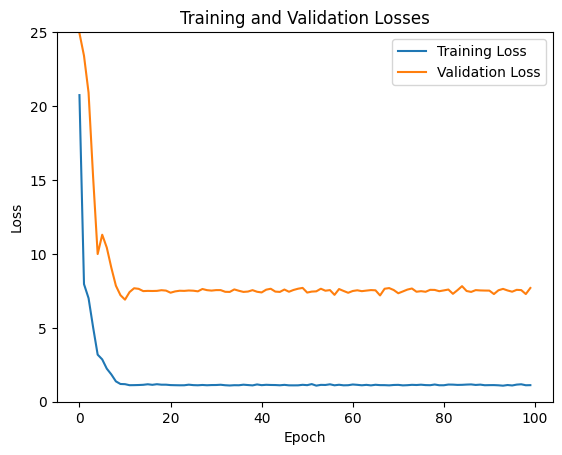

In [90]:
model = cVAE_classifier(input_dimension = 148, latent_dim= 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
classifier_criterion = nn.BCELoss()

train_loss_list = []  # List to store train losses
val_loss_list = []  # List to store validation losses

num_epochs = 100
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    # Train the model
    (   train_loss_autism,
        train_loss_no_autism,
        train_age_loss_autism,
        train_gender_loss_autism,
        train_age_loss_no_autism,
        train_gender_loss_no_autism) = train(
        model,
        train_dataloader,
        train_dataset,
        device,
        optimizer,
        criterion,
        classifier_criterion,
    )

    # Validate the model
    val_loss_autism, val_loss_no_autism, val_age_loss_autism, val_gender_loss_autism, val_age_loss_no_autism, val_gender_loss_no_autism = validate(model, val_dataloader, val_dataset, device, criterion, classifier_criterion)

    # Appending the loss values to a list to allow for visualizations:
    train_loss_list.append(
        train_loss_autism
        + train_loss_no_autism
        + train_age_loss_autism
        + train_gender_loss_autism
        + train_age_loss_no_autism
        + train_gender_loss_no_autism)

    val_loss_list.append(
    val_loss_autism
    + val_loss_no_autism
    + val_age_loss_autism
    + val_gender_loss_autism
    + val_age_loss_no_autism
    + val_gender_loss_no_autism)



    print(f"Train Loss Autism: {train_loss_autism:.4f}, Train Loss Non-Autism: {train_loss_no_autism:.4f}, "
    f"Train Age Loss Autism: {train_age_loss_autism:.4f}, Train Gender Loss Autism: {train_gender_loss_autism:.4f}, "
    f"Train Age Loss Non-Autism: {train_age_loss_no_autism:.4f}, Train Gender Loss Non-Autism: {train_gender_loss_no_autism:.4f}")

    print(f"Val Loss Autism: {val_loss_autism:.4f}, Val Loss Non-Autism: {val_loss_no_autism:.4f}, "
    f"Val Age Loss Autism: {val_age_loss_autism:.4f}, Val Gender Loss Autism: {val_gender_loss_autism:.4f}, "
    f"Val Age Loss Non-Autism: {val_age_loss_no_autism:.4f}, Val Gender Loss Non-Autism: {val_gender_loss_no_autism:.4f}")


print("TRAINING COMPLETE")


# Plot the training and validation losses
plt.figure()
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.ylim(0, 25)  # Set y-axis limits
plt.legend()
plt.show()


Here is a loop that is supposed to help me find the optimal learning rate.

In [94]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Define a list of learning rates to experiment with
learning_rates = [0.001, 0.01, 0.5]

# Lists to store train and validation losses for each learning rate
train_loss_per_lr = []
val_loss_per_lr = []

# Rest of your code remains the same
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cVAE_classifier(input_dimension=148, latent_dim=4).to(device)

# Colors for lines
train_colors = ['dodgerblue', 'green', 'red']  # Shades of blue for training
val_colors = ['lightsteelblue', 'lightgreen', 'lightcoral']  # Lighter shades for validation

# Iterate through different learning rates
for lr_idx, lr in enumerate(learning_rates):
    print(f"Training with learning rate: {lr}")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_loss_list = []  # List to store train losses
    val_loss_list = []  # List to store validation losses

    model = cVAE_classifier(input_dimension=148, latent_dim=4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    classifier_criterion = nn.BCELoss()

    num_epochs = 10
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1} of {num_epochs}")
        # Train the model
        (train_loss_autism,
         train_loss_no_autism,
         train_age_loss_autism,
         train_gender_loss_autism,
         train_age_loss_no_autism,
         train_gender_loss_no_autism) = train(
            model,
            train_dataloader,
            train_dataset,
            device,
            optimizer,
            criterion,
            classifier_criterion,
        )

        # Validate the model
        (val_loss_autism, val_loss_no_autism,
         val_age_loss_autism, val_gender_loss_autism,
         val_age_loss_no_autism, val_gender_loss_no_autism) = validate(model, val_dataloader, val_dataset, device, criterion, classifier_criterion)

        # Appending the loss values to a list to allow for visualizations:
        train_loss_list.append(
            train_loss_autism
            + train_loss_no_autism
            + train_age_loss_autism
            + train_gender_loss_autism
            + train_age_loss_no_autism
            + train_gender_loss_no_autism
        )
        val_loss_list.append(
            val_loss_autism
            + val_loss_no_autism
            + val_age_loss_autism
            + val_gender_loss_autism
            + val_age_loss_no_autism
            + val_gender_loss_no_autism
        )

        # Print the losses
        print(
            f"Train Loss Autism: {train_loss_autism:.4f}, Train Loss Non-Autism: {train_loss_no_autism:.4f}, "
            f"Train Age Loss Autism: {train_age_loss_autism:.4f}, Train Gender Loss Autism: {train_gender_loss_autism:.4f}, "
            f"Train Age Loss Non-Autism: {train_age_loss_no_autism:.4f}, Train Gender Loss Non-Autism: {train_gender_loss_no_autism:.4f}"
        )

    # Store train and validation losses for this learning rate
    train_loss_per_lr.append(train_loss_list)
    val_loss_per_lr.append(val_loss_list)

# Plot the training and validation losses for each learning rate
plt.figure(figsize=(10, 6))
for i, lr in enumerate(learning_rates):
    plt.plot(train_loss_per_lr[i], label=f"Train Loss (LR={lr})", color=train_colors[i])
    plt.plot(val_loss_per_lr[i], label=f"Validation Loss (LR={lr})", color=val_colors[i])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for Different Learning Rates')
plt.legend()
plt.show()


Training with learning rate: 0.001
Epoch 1 of 10


7it [00:00, 44.98it/s]                       


tensor([[-1.0968,  0.3101],
        [-0.1578, -0.1486],
        [ 0.8532, -0.4929],
        [ 1.7099, -0.2640],
        [-0.4778,  0.3343],
        [ 0.4717, -0.6800],
        [-0.9301,  0.6704],
        [-0.0263, -0.4952],
        [-0.2106, -0.8728],
        [ 0.2835, -0.7968],
        [ 0.3323, -0.5805],
        [-0.7513,  0.1047],
        [-0.1865,  0.7880],
        [-0.2956, -0.1572],
        [-0.1672, -0.1642],
        [ 0.4460, -0.7075],
        [-1.9274,  1.8830],
        [ 0.4156, -0.0532],
        [ 0.5883, -1.5669],
        [-0.5483, -0.3687],
        [-0.3489,  0.0971],
        [ 0.6111, -0.6893],
        [ 0.3918, -0.2397],
        [ 0.0777, -0.5593],
        [-0.5321,  0.8609],
        [ 1.9703, -1.3435],
        [ 1.5961, -1.1250],
        [ 0.6524,  0.8268],
        [ 0.6889, -0.8604],
        [ 0.7349, -1.0559],
        [-0.2121, -0.2108],
        [-0.5711,  0.0803],
        [-0.2747, -0.0807],
        [-0.9534,  0.3189],
        [ 0.5196, -0.4297],
        [ 0.0526, -0

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[-1.1285e-01, -6.3985e-01],
        [-2.7678e-01,  5.2873e-01],
        [-8.3634e-01,  4.6596e-01],
        [-6.2774e-01,  1.6587e-01],
        [-4.1745e-01, -2.7812e-01],
        [-2.1834e-01,  2.1793e-01],
        [-2.9022e-01, -2.7696e-01],
        [-3.9160e-01,  2.8724e-01],
        [-9.4997e-02, -3.2855e-01],
        [-1.7967e-01, -2.0027e-01],
        [-4.3317e-01, -8.3950e-02],
        [-2.4304e-01,  4.4968e-02],
        [ 6.2799e-01, -1.0495e+00],
        [ 7.0461e-01, -4.7484e-01],
        [-2.2022e+00,  1.4649e+00],
        [-6.9173e-01, -4.8279e-01],
        [-8.1702e-01, -5.2258e-01],
        [ 1.6720e-01,  6.7391e-02],
        [ 1.8999e-01, -2.9532e-01],
        [-1.3843e-01,  2.4680e-01],
        [-1.0319e-01, -2.3240e-01],
        [-1.1464e+00, -6.4629e-01],
        [-8.0757e-01,  5.7708e-01],
        [-1.0003e+00, -8.1764e-01],
        [ 4.7357e-01, -7.7072e-01],
        [ 7.0016e-01, -2.1003e-01],
        [-2.2835e-02, -6.9339e-01],
        [ 9.0442e-01, -9.840

2it [00:00, 46.71it/s]               


Train Loss Autism: 2.5521, Train Loss Non-Autism: 2.5313, Train Age Loss Autism: 2.2472, Train Gender Loss Autism: 0.0054, Train Age Loss Non-Autism: 2.3640, Train Gender Loss Non-Autism: 0.0057
Epoch 2 of 10


7it [00:00, 47.40it/s]                       


tensor([[-8.9400e-01, -1.6071e-01],
        [-5.7098e-02,  1.0003e-02],
        [ 7.5475e-01, -8.4012e-01],
        [ 2.7475e-01, -8.3683e-01],
        [ 1.0606e+00, -1.1005e+00],
        [ 3.6966e-01, -7.1842e-01],
        [ 5.7197e-02, -3.7416e-01],
        [ 4.9468e-01,  1.9465e-01],
        [ 9.2331e-03, -3.6029e-02],
        [ 2.2343e-01,  8.1928e-03],
        [-5.0841e-01, -1.0393e+00],
        [-7.9328e-01, -7.5868e-02],
        [ 7.4647e-02, -5.5700e-02],
        [ 3.8098e-01,  3.9044e-01],
        [-6.7823e-01,  1.1375e-01],
        [ 2.1412e-01, -5.7453e-01],
        [-1.2786e+00,  1.8309e-01],
        [-1.3422e+00,  9.7094e-01],
        [ 2.4189e-02, -4.9098e-01],
        [ 8.9763e-01,  2.6691e-01],
        [ 5.8060e-02, -3.9069e-01],
        [-4.5780e-01, -5.0110e-01],
        [ 1.0376e+00, -8.4375e-01],
        [-1.5101e+00,  5.3846e-01],
        [-6.1835e-01,  5.1200e-01],
        [ 6.7424e-02,  1.1620e-01],
        [-9.1769e-01,  3.4164e-02],
        [ 3.2911e-01,  1.039

2it [00:00, 62.04it/s]               

tensor([[ 2.1474, -1.2169],
        [-0.6691, -0.4899],
        [-1.4265,  0.3908],
        [ 0.2062, -0.6157],
        [-0.4792, -0.4060],
        [ 0.5771, -0.7568],
        [-2.0180,  0.1697],
        [ 0.1959, -0.3023],
        [-0.5738, -0.1110],
        [-0.4652, -0.4028],
        [ 0.6758, -1.5290],
        [-0.3414, -0.2776],
        [ 1.3977, -0.9482],
        [-0.2265, -0.2316],
        [-0.7651,  0.1699],
        [ 1.1576, -0.9117],
        [ 0.9944, -0.6670],
        [-0.0791, -0.3592],
        [-1.0397,  1.0535],
        [ 0.6871, -0.5882],
        [-0.2931, -0.4495],
        [-0.0842, -0.4481],
        [ 1.5472, -0.9140],
        [ 0.8154, -0.0133],
        [ 0.5752, -0.3835],
        [-0.8507, -0.0968],
        [-0.1331,  0.7338],
        [-0.8530,  0.6451],
        [ 0.3798, -0.7601],
        [-1.8878,  0.4683],
        [ 0.3180,  0.3553],
        [-0.1782,  0.3387],
        [-0.1467,  0.4643],
        [ 0.5004, -0.2728],
        [-0.1101, -0.3854],
        [ 0.5114, -1

Train Loss Autism: 2.5074, Train Loss Non-Autism: 2.4405, Train Age Loss Autism: 2.2465, Train Gender Loss Autism: 0.0053, Train Age Loss Non-Autism: 2.2976, Train Gender Loss Non-Autism: 0.0056
Epoch 3 of 10


7it [00:00, 47.16it/s]                       


tensor([[ 0.6927, -0.8465],
        [-0.5323, -0.6311],
        [-0.1490, -0.7511],
        [ 1.4330, -0.8791],
        [-0.1888,  0.0940],
        [ 0.2345, -0.4338],
        [ 1.1047, -0.2573],
        [-0.2860, -0.5659],
        [-0.1369, -1.0854],
        [ 0.1451, -1.5246],
        [ 0.0313, -0.4662],
        [ 0.0460, -0.6039],
        [-0.2451,  0.5279],
        [ 0.3155, -0.0156],
        [-0.4784,  0.5930],
        [-1.3472,  0.3510],
        [ 0.1452,  0.0032],
        [-1.1181,  0.2913],
        [ 0.0750, -0.0585],
        [ 0.4741, -0.0662],
        [-0.1475, -0.1710],
        [-0.4129, -0.3659],
        [ 0.4014, -0.5573],
        [-0.2126,  0.6330],
        [ 0.1362, -0.4595],
        [ 0.3883, -0.5325],
        [ 1.0959, -0.7973],
        [-0.6955, -0.2679],
        [-0.8189, -0.2490],
        [-0.3383, -0.2692],
        [-0.5658,  0.2758],
        [-1.1336,  0.4089],
        [-0.8209,  0.1544],
        [-1.8812,  0.3919],
        [ 0.5726,  0.5737],
        [-0.2067,  0

2it [00:00, 74.85it/s]               

tensor([[ 8.7568e-02, -5.2815e-01],
        [-7.7333e-01, -9.8880e-02],
        [-6.1681e-01,  5.9010e-01],
        [ 5.6329e-01, -1.5831e-02],
        [-7.9087e-01,  1.7514e-01],
        [-1.4462e+00,  8.1919e-01],
        [ 6.8880e-01, -1.5889e+00],
        [ 2.4447e-01, -2.1539e-01],
        [ 5.2036e-01, -9.0033e-01],
        [ 4.0271e-01, -6.7840e-01],
        [-5.9365e-01,  1.6649e-01],
        [ 7.9860e-01, -4.3586e-03],
        [-5.1063e-01, -3.7273e-01],
        [-1.2926e-01,  3.3401e-02],
        [ 1.2087e+00, -3.5334e-01],
        [-6.2947e-01,  7.2705e-01],
        [ 1.8552e-01, -5.8513e-01],
        [ 8.4775e-01, -4.0558e-01],
        [-1.1448e+00, -2.8899e-02],
        [ 5.8658e-01, -5.4758e-01],
        [-4.1944e-01, -4.5644e-01],
        [-8.2713e-01,  2.7204e-01],
        [-1.2937e-01, -2.8151e-01],
        [-1.3973e+00,  7.1207e-01],
        [-3.6761e-01, -2.4164e-01],
        [ 5.1585e-01, -9.3390e-02],
        [ 1.0148e-01, -2.0538e-01],
        [-1.3511e+00, -5.278

Train Loss Autism: 2.5056, Train Loss Non-Autism: 2.4117, Train Age Loss Autism: 2.2713, Train Gender Loss Autism: 0.0055, Train Age Loss Non-Autism: 2.2879, Train Gender Loss Non-Autism: 0.0055
Epoch 4 of 10


7it [00:00, 43.53it/s]                       

tensor([[ 0.4102, -0.6923],
        [ 0.4541, -0.7387],
        [-0.1697, -0.8029],
        [-0.4938, -0.0550],
        [ 0.2051, -0.6582],
        [ 0.3184, -0.4867],
        [ 1.5178, -1.5610],
        [-0.6822,  0.3476],
        [ 0.5433,  0.5641],
        [ 1.3964, -1.8339],
        [ 0.1052, -0.0446],
        [ 2.3362, -1.6302],
        [-1.1166, -0.0834],
        [-0.1148,  0.2231],
        [ 0.1545,  0.1135],
        [ 0.8828, -0.7906],
        [-0.6171, -0.3963],
        [ 0.7946, -0.5604],
        [ 0.5033, -0.5771],
        [-0.7856, -0.5078],
        [-1.2764, -0.1480],
        [ 0.4172, -0.6037],
        [-0.0496, -0.3607],
        [-0.2137, -0.4579],
        [-0.5553,  0.0553],
        [ 0.9470, -0.3321],
        [-0.5615, -0.3050],
        [-0.3530, -0.3674],
        [ 0.1419, -0.2124],
        [ 0.6008,  0.6183],
        [-1.5876, -0.1687],
        [-1.2715,  0.2382],
        [ 1.5010, -0.7151],
        [-0.2259, -0.3353],
        [ 0.2815, -0.8303],
        [-0.3385,  0


2it [00:00, 58.58it/s]               


tensor([[ 0.9395, -0.0930],
        [ 0.3172, -0.2661],
        [ 0.3766, -0.8809],
        [-0.9053,  0.1213],
        [-0.4638, -0.1708],
        [ 0.8330,  0.3104],
        [ 0.7973, -1.0990],
        [-0.6003, -0.2219],
        [-1.0908, -0.1917],
        [-0.9907, -0.0029],
        [-0.2255, -1.3790],
        [ 0.1922, -0.8470],
        [-1.3984,  1.1032],
        [ 0.4384, -0.3891],
        [-1.5267, -0.0585],
        [ 0.7460, -0.7962],
        [-0.7428,  0.3178],
        [ 0.5930, -0.9760],
        [ 0.8794, -1.2566],
        [-0.9914, -0.7442],
        [-0.5810, -0.3845],
        [-1.0236, -0.4421],
        [ 1.4239, -0.9498],
        [-0.2633, -0.6585],
        [-0.5363, -0.8421],
        [ 0.0213, -0.6911],
        [ 1.0235, -0.2805],
        [-0.1868, -0.6009],
        [-0.4711,  0.3168],
        [-0.2069,  0.1063],
        [ 0.7627, -1.3996],
        [-0.0786,  0.4268],
        [-0.9634, -0.0751],
        [-1.1845,  0.2651],
        [ 0.4982,  0.1128],
        [-0.0051, -0

 67%|██████▋   | 4/6 [00:00<00:00, 32.08it/s]

tensor([[-0.4835, -0.3447],
        [ 0.0706, -0.2275],
        [-0.7175, -0.5272],
        [ 0.4593,  0.0876],
        [ 0.8109, -0.1700],
        [-0.5215, -0.5517],
        [-0.8497,  0.3531],
        [ 0.1650, -0.9582],
        [-1.1951,  0.0195],
        [-0.9191,  0.5776],
        [ 0.1602, -0.3021],
        [ 0.0951, -0.2383],
        [ 1.0170, -0.9656],
        [ 1.2010, -0.6931],
        [-0.1766, -0.2092],
        [-0.8051, -0.0081],
        [ 0.1817, -0.6825],
        [ 0.0042, -0.6660],
        [ 0.0518, -0.2526],
        [-1.2319,  0.5606],
        [-0.4529, -0.4579],
        [-0.5454, -1.1046],
        [-1.2572,  0.3074],
        [-0.1717,  0.1888],
        [ 0.1159, -0.5586],
        [-0.9249,  0.0665],
        [ 1.7343, -1.2640],
        [-0.0266, -0.3408],
        [-1.7907,  0.5837],
        [-0.1630,  0.1639],
        [-0.1968,  0.3518],
        [ 1.8530, -0.4619],
        [-0.8550,  0.0665],
        [-1.4678, -0.1519],
        [-0.9006,  0.3043],
        [-0.4078, -0

7it [00:00, 32.33it/s]                       


tensor([[-0.4730, -0.1215],
        [-0.2162, -0.7398],
        [ 0.4172, -0.0215],
        [-0.3426, -0.9846],
        [ 0.2964, -0.9401],
        [ 0.8298, -1.5786],
        [-0.5430,  0.6247],
        [ 0.0581, -0.8368],
        [-0.2267,  0.1478],
        [-1.3019,  0.3105],
        [ 0.8985, -0.4165],
        [ 0.3907, -0.0598],
        [-0.0618,  0.5624],
        [ 1.1297, -0.4855],
        [ 0.7168, -1.4588],
        [ 0.7519, -0.8665],
        [-0.9553,  0.4493],
        [ 0.2836, -0.1647],
        [-0.3286, -0.3344],
        [ 0.9683, -0.2563],
        [-1.6104, -0.3152],
        [-0.4196, -0.6242],
        [-1.6487,  0.0276],
        [-0.2596,  0.2010],
        [ 0.7974, -1.3037],
        [-1.0248,  0.4614],
        [ 0.9445, -0.0289],
        [ 0.1964, -1.7798],
        [-0.5323, -0.3380],
        [-0.4214, -0.7271],
        [-0.4509, -0.0262],
        [ 1.3864, -0.3357],
        [-0.3792, -1.1975],
        [-0.7293,  0.4481],
        [-0.2063,  0.0279],
        [ 0.1616,  0

2it [00:00, 55.56it/s]               


tensor([[-8.5393e-01,  7.2580e-01],
        [-1.8702e+00,  3.4177e-01],
        [-1.5924e+00,  8.9899e-01],
        [-5.8188e-03, -1.9888e-01],
        [ 8.0359e-01, -1.4667e-01],
        [-3.3111e-01, -5.1680e-01],
        [-1.7123e+00,  1.2925e-01],
        [-4.7185e-01, -2.4063e-01],
        [ 1.4200e-01, -5.2729e-01],
        [ 3.2800e-01, -9.8300e-01],
        [ 2.1346e-01, -7.4986e-01],
        [ 5.4863e-01, -5.8316e-01],
        [-1.5870e-01, -9.0498e-01],
        [ 5.4002e-01, -7.4470e-01],
        [ 4.9562e-01, -9.1400e-01],
        [-2.1067e-01, -1.2456e-01],
        [-2.1813e-01, -4.4593e-01],
        [ 2.5169e-01, -4.8226e-01],
        [-2.5378e-01, -2.7514e-02],
        [-8.5122e-01,  6.3171e-01],
        [-6.7132e-01,  7.3242e-01],
        [ 1.4165e+00, -2.2678e-01],
        [-3.9595e-01,  4.5482e-01],
        [-2.9631e-02, -5.4345e-01],
        [-6.6362e-01, -6.2477e-01],
        [ 1.9963e-01,  1.7108e-03],
        [-1.6179e-01,  2.0232e-01],
        [-5.1255e-01, -5.600

  0%|          | 0/6 [00:00<?, ?it/s]

tensor([[-0.3643, -0.1544],
        [-0.3138,  0.1616],
        [-0.2930,  0.0563],
        [-0.2126,  0.2892],
        [-0.9340, -0.6875],
        [ 0.2596, -1.0664],
        [ 0.1779, -0.5496],
        [ 0.1421, -0.0456],
        [-0.1833, -0.0263],
        [-0.9258, -0.4390],
        [-0.2064, -0.3296],
        [ 0.9690,  0.0113],
        [-1.6824,  0.0610],
        [ 1.2796, -0.9260],
        [-1.4416, -0.0551],
        [ 0.1873,  0.1266],
        [ 0.1422, -0.0651],
        [ 0.3745, -0.4367],
        [ 0.3138, -0.2278],
        [ 0.4174,  0.0284],
        [-0.8964,  0.1559],
        [ 0.1959, -0.6304],
        [-0.4678, -0.4020],
        [ 0.7045,  0.0548],
        [ 0.2737, -0.0695],
        [ 0.3452, -0.6827],
        [-0.1150,  0.1641],
        [ 1.5085, -0.7685],
        [ 1.2551, -0.7815],
        [ 0.2388, -0.5157],
        [-1.6223,  0.2801],
        [-0.3222, -0.0564],
        [ 0.2245, -1.0851],
        [-0.9473,  0.3045],
        [-1.0122,  0.2370],
        [ 0.8475, -0

 67%|██████▋   | 4/6 [00:00<00:00, 34.40it/s]

tensor([[-3.2689e-01, -6.6300e-01],
        [ 5.8851e-01, -1.9544e-01],
        [-9.8494e-01, -8.1692e-01],
        [-5.7548e-01,  7.7889e-02],
        [-7.7725e-01, -1.3721e-02],
        [ 2.9133e-01, -5.2700e-01],
        [ 1.3225e-02, -5.7392e-01],
        [-2.4959e-03,  1.0542e-01],
        [-1.7905e-01,  1.0122e-02],
        [-3.0923e-01, -2.3686e-01],
        [ 3.1436e-01, -9.6202e-03],
        [-5.0168e-01, -3.7839e-03],
        [-2.5172e-01, -4.6393e-01],
        [-9.9447e-01, -1.3453e-01],
        [-1.4500e-01,  9.0901e-03],
        [-8.8873e-01, -9.9711e-03],
        [-1.0120e+00,  2.9373e-01],
        [ 3.7786e-01, -3.4987e-01],
        [ 7.9176e-01, -3.2748e-01],
        [ 4.5852e-01, -6.5842e-01],
        [ 4.9354e-01, -1.0591e+00],
        [-6.7553e-01, -3.5330e-01],
        [-5.4193e-01,  2.4406e-03],
        [-9.7926e-01, -5.5884e-01],
        [ 1.6775e-01, -5.5554e-01],
        [ 9.3316e-02, -1.0439e+00],
        [-8.9810e-01, -3.0638e-03],
        [-3.7306e-01, -4.917

7it [00:00, 34.85it/s]                       


tensor([[-0.5705,  0.1498],
        [-0.6487,  0.2343],
        [ 0.0172, -0.7411],
        [ 0.0950, -0.6868],
        [ 1.0438, -0.4152],
        [-2.3620,  0.7804],
        [-1.0938,  0.5636],
        [-0.9083,  0.4183],
        [ 0.3484, -1.2635],
        [ 0.8308, -0.1529],
        [-1.2951,  0.5318],
        [-0.6467, -0.1044],
        [ 0.9892, -0.6639],
        [ 1.3149, -0.4031],
        [-1.0192,  0.0815],
        [-0.2658, -0.6693],
        [-0.3681, -0.2753],
        [-0.3421, -0.7878],
        [-0.2316, -0.3533],
        [ 0.6718, -0.6718],
        [-0.5034, -0.0185],
        [-0.8878, -0.7542],
        [-0.1611,  0.5008],
        [-0.0164, -0.5284],
        [ 0.3436, -0.7307],
        [-0.4226, -0.2912],
        [-0.6117, -0.7552],
        [ 0.1072, -1.0086],
        [-0.1331,  0.1206],
        [-0.2865, -0.4624],
        [ 0.2038, -0.5796],
        [ 0.3879, -0.2757]], grad_fn=<AddmmBackward0>)
torch.Size([32, 1])
tensor([[ 1.0824e+00, -1.0631e+00],
        [ 6.7871e-01,

2it [00:00, 51.99it/s]               


tensor([[ 0.4085, -0.7560],
        [ 0.8498, -0.9378],
        [-0.6877, -0.6535],
        [ 0.5344,  0.0407],
        [ 0.5662, -0.6555],
        [ 0.2274, -0.1104],
        [-0.1114, -0.1017],
        [ 0.3285, -0.1730],
        [ 0.5517, -0.2259],
        [ 0.1459, -0.5257],
        [-0.2959, -0.8012],
        [ 0.1056, -0.9698],
        [-0.7151,  0.0787],
        [ 1.0943, -0.0237],
        [ 1.0429, -0.2129],
        [ 0.2444, -1.0198],
        [-1.3177,  0.1458],
        [ 0.4122, -0.7362],
        [-0.2189,  0.1075],
        [-1.1290,  0.4751],
        [-0.5469, -0.5550],
        [-0.6159, -0.3138],
        [-0.6277,  0.5708],
        [ 0.3871,  0.2424],
        [-1.1032, -0.4839],
        [-0.0529,  0.6861],
        [-0.1610, -1.2808],
        [ 0.5979, -0.3938],
        [ 0.5324, -0.1281],
        [-0.4051,  0.1038],
        [-0.7645,  0.4445],
        [-0.6176,  0.1943],
        [ 0.5145,  0.0799],
        [-1.1403,  0.2042],
        [-1.7535, -0.3334],
        [ 0.0853, -0

  0%|          | 0/6 [00:00<?, ?it/s]

tensor([[-0.4838, -0.1019],
        [-0.6418,  0.0342],
        [-0.3829, -0.2900],
        [ 0.0209, -0.6083],
        [-1.8115, -1.0488],
        [ 0.6983, -0.9046],
        [-1.2011,  0.5289],
        [-0.8291, -0.6618],
        [ 0.2116, -0.6680],
        [-0.6238,  1.2281],
        [ 1.0253, -0.2057],
        [ 0.2022, -0.3140],
        [ 0.0798,  0.2439],
        [-0.4680, -0.2795],
        [ 0.5922, -0.0158],
        [ 1.4046, -0.6940],
        [ 1.8551, -0.4623],
        [-0.3310, -0.0270],
        [ 0.3112, -0.5398],
        [-0.9080, -1.0246],
        [-0.0213, -0.6947],
        [-0.8010, -0.5948],
        [-0.0917, -0.6467],
        [-1.1567, -0.4972],
        [-0.1843, -0.1086],
        [ 0.7639, -0.8710],
        [-0.4228, -0.3858],
        [-0.2318, -0.4321],
        [ 0.6226, -0.9458],
        [ 0.2821, -0.6552],
        [ 0.0705, -0.2617],
        [-1.4877,  0.0209],
        [-0.1026, -0.6511],
        [ 0.0368, -0.3414],
        [-0.7359, -0.1308],
        [-1.1225, -0

 67%|██████▋   | 4/6 [00:00<00:00, 30.46it/s]

tensor([[-1.0589,  0.9096],
        [ 0.5300, -0.6898],
        [ 0.3872, -0.8239],
        [ 0.2183, -0.7396],
        [ 1.0105, -1.2285],
        [-0.3895, -0.0922],
        [-1.3818, -0.4724],
        [-0.7064, -0.8314],
        [-0.2106,  0.7263],
        [-0.6551,  0.2050],
        [ 0.1490, -0.7052],
        [-0.2480, -0.2316],
        [-1.3316, -0.2256],
        [ 0.5779, -0.3308],
        [-0.5544,  0.3011],
        [-0.8767, -0.3257],
        [-0.6846, -0.6419],
        [-0.6066, -0.0489],
        [ 0.7602, -0.2731],
        [ 1.3142, -0.3711],
        [-0.1562,  0.4406],
        [-1.8689,  1.0317],
        [-0.0486, -0.1119],
        [ 0.6043, -1.5334],
        [-0.7242, -0.2681],
        [ 0.3207, -0.7633],
        [-0.5404, -0.9164],
        [ 1.4864, -0.6306],
        [-0.1853, -0.6161],
        [-1.2850, -0.2332],
        [-0.0576, -0.0672],
        [-0.7842, -0.1429],
        [-0.4857, -0.6739],
        [-0.1986, -0.1897],
        [-1.6024,  0.1457],
        [-0.7289, -0

7it [00:00, 31.31it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[-1.3460, -0.4941],
        [-1.1671,  0.4385],
        [ 0.8249, -0.0345],
        [ 0.2544, -0.4150],
        [ 0.2116, -0.0358],
        [-0.1326, -0.1241],
        [-0.8296, -0.4386],
        [ 0.0713,  0.0776],
        [ 1.6281, -1.2303],
        [ 0.5681,  0.1415],
        [-0.1241, -0.3724],
        [-1.0749, -0.1699],
        [ 1.4171, -0.5373],
        [-1.2030, -0.4112],
        [-0.2591, -0.9711],
        [-0.7600, -0.4914],
        [-0.1996, -0.4157],
        [-0.5767, -0.1783],
        [-0.3617, -0.2407],
        [ 0.6224, -0.4010],
        [ 1.0058, -0.7094],
        [ 0.4259, -0.2904],
        [-0.1820, -1.0599],
        [-0.5001, -0.1778],
        [ 0.1711, -0.3928],
        [ 0.2368, -0.3515],
        [-1.3399,  0.8440],
        [-0.5294, -0.1829],
        [-1.2008, -0.1052],
        [ 0.6172, -0.4573],
        [-0.6729, -0.0172],
        [-1.7330,  0.5882],
        [-0.6837, -0.0860],
        [ 0.1203, -0.4265],
        [-1.3323,  0.6608],
        [ 0.2506,  0

2it [00:00, 56.08it/s]               


tensor([[-0.3267, -0.3423],
        [-1.1250, -0.4544],
        [-0.2391, -0.6215],
        [-0.2036, -0.2502],
        [ 0.1725, -0.6500],
        [-0.4081, -0.1207],
        [-0.7506, -0.6705],
        [-0.0927, -1.0660],
        [-0.3783, -0.2376],
        [-0.1233, -0.2381],
        [-1.1798, -0.8456],
        [-0.6278,  0.0057],
        [-0.6502,  0.3360],
        [ 0.3267, -0.8831],
        [ 1.0284, -0.9112],
        [-0.3995, -0.7968],
        [-0.0569, -0.3667],
        [ 0.2041, -0.2409],
        [-1.4882, -0.4248],
        [-0.7961,  1.0734],
        [-0.0552, -0.1153],
        [ 0.4833,  0.6684],
        [ 0.1611, -0.5915],
        [-1.3838,  0.3342],
        [ 0.8831, -0.9786],
        [-0.1029, -1.1174],
        [ 1.2147, -0.9849],
        [ 0.8239, -0.0088],
        [-0.6738, -0.3822],
        [-1.3348,  0.4313],
        [ 0.4634, -0.5197],
        [ 0.1420, -0.2849],
        [-0.1260,  0.0926],
        [ 0.1644, -0.9140],
        [ 0.8887, -0.8812],
        [ 1.1000, -0

  0%|          | 0/6 [00:00<?, ?it/s]

tensor([[ 1.0846e-01, -9.8808e-01],
        [-1.2937e-01,  1.0523e-01],
        [-8.9749e-01, -1.1488e+00],
        [ 9.3588e-01, -4.2348e-01],
        [ 9.8652e-01, -3.7253e-02],
        [ 1.0744e+00, -4.1766e-01],
        [-2.4914e-01, -1.3305e-01],
        [-8.1346e-01,  7.3973e-02],
        [-6.9615e-01, -2.1040e-02],
        [-5.3997e-01, -7.6604e-01],
        [ 5.2349e-01, -9.5512e-01],
        [-1.0494e+00,  1.0002e+00],
        [-1.7281e+00,  8.6069e-01],
        [ 5.4901e-02, -6.3757e-01],
        [-1.2524e+00,  8.1173e-03],
        [-1.2332e+00, -3.8269e-01],
        [-7.6948e-01,  6.1027e-01],
        [ 4.8661e-02, -4.0387e-01],
        [-8.3903e-01,  4.7520e-02],
        [-3.3147e-01, -3.1417e-01],
        [-9.5837e-01, -1.6618e-02],
        [ 3.4684e-01, -1.8206e-01],
        [ 8.2904e-01,  3.7391e-01],
        [ 1.1970e-01,  2.7585e-01],
        [ 1.1455e-01,  2.9627e-02],
        [-2.7693e-01, -1.1626e+00],
        [-2.2171e-01, -1.2937e+00],
        [ 3.2698e-01,  6.914

 50%|█████     | 3/6 [00:00<00:00, 25.05it/s]


torch.Size([64, 1])
Gender predictions range: 0.14713311195373535, 0.7632840275764465
tensor([[ 1.4063e-01, -1.3614e+00],
        [-3.5192e-01, -6.7104e-01],
        [-1.7082e+00, -3.5820e-01],
        [-1.9762e+00,  3.1566e-01],
        [ 3.5076e-01, -5.1757e-01],
        [-8.5983e-01,  4.8870e-01],
        [-7.7463e-01,  1.9707e-01],
        [-6.2095e-01, -4.3949e-01],
        [-6.5958e-01, -6.6814e-02],
        [ 3.8001e-01, -3.2633e-01],
        [ 6.5095e-01, -5.9319e-01],
        [-5.9331e-01, -3.5175e-01],
        [-1.9917e+00,  5.8879e-01],
        [-4.4405e-01, -6.8346e-01],
        [-7.5396e-01,  2.5425e-01],
        [ 2.5498e-01, -4.8893e-01],
        [ 1.4624e+00, -1.1712e+00],
        [ 2.4973e-01, -4.3792e-01],
        [-7.3930e-01, -1.1920e+00],
        [ 1.3151e+00, -5.6996e-01],
        [-1.0523e-01, -7.8666e-01],
        [ 2.8105e-01, -2.2757e-01],
        [ 5.3405e-01, -9.5889e-01],
        [-8.9474e-01, -5.7859e-01],
        [ 1.2397e+00, -7.8809e-01],
        [ 1.2

7it [00:00, 26.03it/s]                       


tensor([[-0.6265, -0.1708],
        [ 0.2836, -0.2989],
        [ 0.1250, -0.2455],
        [ 0.8212, -0.9440],
        [ 0.0201, -0.5462],
        [-0.0475, -0.9009],
        [-0.6570,  0.2502],
        [ 0.1388, -0.8506],
        [ 0.1161,  0.0289],
        [ 0.1614, -0.3225],
        [-0.0043, -0.7672],
        [ 0.2367,  0.1129],
        [-0.1914, -0.8349],
        [-2.2857,  0.9869],
        [ 1.3506, -0.5835],
        [ 0.3449,  0.0269],
        [-0.3581, -0.7569],
        [-1.1548,  0.1221],
        [-1.3150, -0.0251],
        [ 0.4930, -0.8146],
        [ 0.6216, -0.9599],
        [ 0.4783,  0.1531],
        [-0.1304, -0.2826],
        [-0.9879, -0.0110],
        [ 0.8486, -1.0654],
        [-1.8263,  0.3911],
        [ 0.2844, -0.3182],
        [ 0.2772, -0.6087],
        [-0.2281,  0.0510],
        [-1.6158,  0.0825],
        [-0.0323, -0.5599],
        [-0.1156, -0.6691],
        [-0.2771,  0.0616],
        [-0.7072, -0.1870],
        [ 0.3689, -0.6244],
        [-0.7051, -0

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[-0.1821, -0.6303],
        [-0.3356, -0.0132],
        [ 0.8710, -0.7098],
        [-1.0971,  0.3421],
        [-0.8730,  0.2490],
        [-1.5905, -0.0631],
        [-1.6498,  0.1173],
        [-0.3078, -0.3845],
        [-0.0364,  0.1686],
        [-1.1043,  0.6262],
        [ 0.6152, -1.2120],
        [-0.0329, -0.1823],
        [-1.2098,  0.1977],
        [-0.3583, -0.3583],
        [-1.4926,  0.0709],
        [-1.2364,  0.2137],
        [ 0.4466, -0.4956],
        [-0.2374, -0.4636],
        [ 0.4350, -0.1544],
        [-0.4797, -0.0447],
        [-1.1286, -0.3276],
        [ 0.2420, -0.1908],
        [-0.0032, -0.4600],
        [ 0.6543, -0.7213],
        [-0.6800, -0.6049],
        [ 0.4026, -0.4747],
        [-0.6813, -0.6119],
        [-0.5349,  0.1473],
        [ 1.2639,  0.1463],
        [ 0.5892,  1.0021],
        [ 0.2647, -0.3707],
        [-0.1728, -0.3845],
        [-0.2440, -0.1934],
        [ 2.3188, -0.3590],
        [ 0.4085, -1.0827],
        [ 0.3682, -0

2it [00:00, 55.25it/s]               



Train Loss Autism: 2.4024, Train Loss Non-Autism: 2.3708, Train Age Loss Autism: 2.2422, Train Gender Loss Autism: 0.0054, Train Age Loss Non-Autism: 2.2914, Train Gender Loss Non-Autism: 0.0056
Epoch 9 of 10


  0%|          | 0/6 [00:00<?, ?it/s]

tensor([[ 0.5645, -0.1564],
        [-0.1218,  0.3872],
        [ 0.3650, -0.8039],
        [ 0.1527, -0.6834],
        [ 1.4020, -1.3113],
        [-0.6051, -0.0123],
        [-0.8277,  0.8828],
        [-0.7503, -0.5833],
        [-0.0937,  0.1685],
        [-0.0947, -0.4091],
        [-0.1577, -1.4911],
        [ 0.3913, -0.6317],
        [-0.2781, -0.6269],
        [-0.7054,  0.6292],
        [ 0.4982,  0.0551],
        [-0.3774,  0.4158],
        [-0.6325, -0.3485],
        [-0.1567, -0.2567],
        [-0.7666, -0.2095],
        [-1.0726,  0.3523],
        [-1.0709, -0.5730],
        [ 1.2335, -0.9780],
        [-0.2866, -0.3671],
        [-0.0832, -0.7386],
        [-1.1136, -0.5628],
        [-0.2052,  0.1571],
        [-2.1667,  0.0226],
        [ 0.7938, -0.6058],
        [-0.0589,  0.0581],
        [-0.0863, -0.3167],
        [-0.1441, -0.4641],
        [-0.5507, -0.3745],
        [ 0.5750, -1.7732],
        [ 0.4562, -0.9712],
        [ 0.3806, -0.2403],
        [ 1.5459, -0

 67%|██████▋   | 4/6 [00:00<00:00, 35.64it/s]

tensor([[ 0.2381, -0.2787],
        [ 0.7269, -0.9464],
        [ 1.3576, -1.2688],
        [-0.5781, -0.0243],
        [ 0.4468, -0.2233],
        [ 0.0672, -1.3102],
        [ 0.7356, -1.0513],
        [ 0.1981, -1.1663],
        [-1.4116,  0.2033],
        [-1.1748,  0.6726],
        [-0.7791,  0.1524],
        [ 0.0624, -0.4001],
        [ 0.9699, -0.6114],
        [-0.1118, -1.1512],
        [-0.1002, -0.1938],
        [ 1.2496, -0.9684],
        [-0.7833, -0.4696],
        [-1.7750,  0.5486],
        [-1.3023,  0.7549],
        [-0.9065, -0.7261],
        [-0.7758,  0.5473],
        [-0.9461,  0.7199],
        [-0.7755, -0.0589],
        [-0.9913, -0.1965],
        [-0.7359, -0.5962],
        [-0.1481, -0.8044],
        [-0.2515, -0.7624],
        [-0.2556, -0.5617],
        [ 0.1993, -0.2497],
        [-0.0724,  0.1081],
        [ 0.0656, -0.2530],
        [ 0.6049, -0.0777],
        [-0.3631, -0.1248],
        [ 0.1522,  0.7478],
        [ 0.2601,  0.5082],
        [-0.0413,  0

7it [00:00, 36.40it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[ 0.5422, -0.1977],
        [-0.1126, -0.2847],
        [-0.7865, -0.3652],
        [-1.2940,  0.5765],
        [ 0.8340, -0.6714],
        [ 0.6255, -1.1874],
        [ 0.6231, -0.2292],
        [-0.8680, -0.4520],
        [ 1.1435, -0.8013],
        [ 0.1869,  0.5098],
        [ 0.0689, -0.2752],
        [-0.2058, -0.3347],
        [ 0.0348, -0.2637],
        [-0.6393, -0.4568],
        [-0.8132,  0.5421],
        [-0.9233, -0.0750],
        [-1.0538,  0.0652],
        [ 0.2986, -0.8135],
        [-0.6074, -0.1849],
        [-0.2645,  0.2125],
        [ 0.8401,  0.0824],
        [-0.3192, -0.8275],
        [ 1.4374, -0.9181],
        [-0.9344,  0.0337],
        [-0.5051, -0.4468],
        [ 0.4692, -0.6174],
        [ 0.4998, -0.4036],
        [-0.7713, -0.3438],
        [-0.1536, -0.0765],
        [-0.9593,  0.0811],
        [-1.0527,  0.6188],
        [ 0.0401, -0.3161],
        [-1.2174, -0.2978],
        [-0.4735,  0.2296],
        [ 0.4837, -0.6103],
        [-0.7445, -0

2it [00:00, 57.88it/s]               


tensor([[ 0.1602, -0.7841],
        [-0.2237, -0.5683],
        [ 0.5218, -1.2419],
        [ 0.4540, -0.8328],
        [ 0.6506, -0.3189],
        [ 0.1101, -1.0279],
        [ 0.1168, -0.7154],
        [-0.2452, -0.1278],
        [-1.2666,  0.0976],
        [ 0.1796, -0.0827],
        [-0.2068, -0.6819],
        [ 0.9801, -1.1691],
        [ 0.3284, -0.0732],
        [-0.6486, -0.3328],
        [-0.2615, -0.4286],
        [ 0.2391, -0.9831],
        [-0.2621,  0.0157],
        [-0.8062, -0.0761],
        [-0.8419, -0.6814],
        [ 0.5631, -0.6242],
        [ 0.4072, -1.2647],
        [-0.7614, -0.3781],
        [-0.9173,  0.1707],
        [-0.1802, -1.4092],
        [ 0.0478, -0.0038],
        [ 0.1486, -0.5435],
        [ 0.7328, -0.2393],
        [-0.2851, -0.2178],
        [ 0.2700, -0.7314],
        [ 0.1742, -1.0128],
        [ 0.3329, -0.7906],
        [ 0.9911, -0.9280],
        [ 0.1146, -0.6303],
        [-0.9722, -0.6661],
        [ 0.1245, -0.1466],
        [-0.8804, -0

  0%|          | 0/6 [00:00<?, ?it/s]

tensor([[ 0.6366, -1.3494],
        [ 0.0739, -1.2065],
        [-1.0839,  0.8711],
        [ 1.6383, -1.3018],
        [ 1.2670,  0.1582],
        [ 0.5132, -0.2996],
        [-0.8310, -0.0034],
        [-0.0841, -0.0238],
        [-0.5466, -0.3646],
        [ 1.0496, -1.7856],
        [-0.7387,  0.0860],
        [-1.0556,  0.0366],
        [ 0.4289, -0.1120],
        [-0.2434, -0.2226],
        [ 0.2645,  0.2474],
        [ 0.3991,  0.4379],
        [-1.5438, -0.3911],
        [-0.4248,  0.3724],
        [ 0.0724,  0.1479],
        [ 0.0622, -1.6316],
        [ 0.3867, -0.8072],
        [-1.0497,  0.4634],
        [ 0.3983, -0.1809],
        [-0.2435, -0.3222],
        [ 0.1072, -1.1243],
        [-0.0380, -0.4240],
        [ 0.2056,  0.2260],
        [-1.1745, -0.6417],
        [-2.1801, -0.2504],
        [-0.4733, -0.2176],
        [-0.7982, -0.1318],
        [-0.4670, -0.8622],
        [-1.0788, -0.4017],
        [ 0.5009, -0.0651],
        [-0.1251,  0.2384],
        [-1.0173,  0

 50%|█████     | 3/6 [00:00<00:00, 26.79it/s]

tensor([[-0.8807,  0.2604],
        [ 0.6274, -0.9167],
        [-0.5722, -0.0587],
        [ 0.0026,  0.1993],
        [-0.0286, -0.6471],
        [ 0.5861, -0.2173],
        [-0.5614, -0.2519],
        [-1.3633, -0.0094],
        [ 0.2545, -0.5363],
        [-0.2821,  0.0983],
        [ 0.1657, -0.0965],
        [-0.2471, -0.0437],
        [ 0.3161, -0.7501],
        [-0.3994,  0.5274],
        [ 0.6601, -0.8494],
        [-0.8341,  0.3677],
        [-0.7784, -0.0071],
        [ 0.1229, -0.4561],
        [ 0.0419, -0.5481],
        [-0.9100, -0.7381],
        [ 0.3415, -1.2873],
        [ 0.6388, -0.3208],
        [ 0.1199, -0.1084],
        [ 1.2690, -1.0163],
        [ 1.5134, -1.2107],
        [-0.2961,  0.3587],
        [-0.4908, -0.5781],
        [-0.4959, -0.2594],
        [ 1.8851, -0.8986],
        [ 1.4046,  0.2471],
        [-0.9781,  0.1295],
        [-0.6316,  0.3275],
        [-0.8145, -0.3947],
        [-0.9214,  0.0359],
        [-0.6889,  0.2697],
        [-0.3736, -0

100%|██████████| 6/6 [00:00<00:00, 25.15it/s]

torch.Size([64, 1])
tensor([[ 0.3135, -0.6720],
        [ 0.7819, -0.7760],
        [ 0.2716, -0.7652],
        [ 0.5177, -0.7683],
        [ 0.7797, -0.8324],
        [ 0.3213, -1.2447],
        [ 1.2258, -0.5240],
        [-0.7931, -0.1298],
        [ 0.1376, -0.6346],
        [-1.2275, -0.6489],
        [ 0.3140, -0.9278],
        [-0.2264, -0.2345],
        [ 0.9318, -0.3355],
        [ 0.6519, -0.6940],
        [-0.8277,  0.6810],
        [-0.4466,  0.2871],
        [-0.1133, -0.9009],
        [ 0.1767,  0.4208],
        [ 0.6996, -1.1197],
        [ 0.6258, -0.7684],
        [ 0.3479, -0.1554],
        [-0.4609, -0.2470],
        [-0.4255,  0.0300],
        [ 0.6288, -0.5074],
        [-0.7863,  0.1554],
        [ 0.1983, -0.4417],
        [-0.8609, -0.1419],
        [-0.7780, -0.3862],
        [ 0.6963, -0.3231],
        [-1.0537, -0.8569],
        [-0.6667, -0.2869],
        [-1.0629, -0.5827],
        [-0.4307,  0.0159],
        [-0.3526, -0.6185],
        [ 0.8887, -1.3151],


7it [00:00, 25.85it/s]                       


tensor([[-0.3924,  0.5736],
        [-1.0116,  0.2089],
        [ 0.1177, -0.4841],
        [-1.2641, -0.2654],
        [-0.1835, -0.1942],
        [-0.7388, -0.4004],
        [-0.0691, -0.3894],
        [-0.8185, -0.0865],
        [ 0.4015, -0.9939],
        [-0.1750, -1.4291],
        [ 0.6425, -0.4147],
        [-0.6553,  0.2758],
        [-1.4511,  0.2113],
        [ 0.9091, -0.9630],
        [-0.5914, -1.2468],
        [ 0.8417, -0.6913],
        [-0.2228, -1.1400],
        [-0.3631,  0.1620],
        [-1.3960,  0.4843],
        [ 0.1104, -0.6589],
        [-0.3648,  0.6949],
        [-0.7839, -0.5675],
        [-1.8123, -0.1138],
        [-0.3630, -0.5022],
        [-0.6890,  0.4562],
        [-0.0110,  0.2126],
        [ 0.0333, -0.7315],
        [-0.1894, -0.2433],
        [ 1.1452, -1.2358],
        [-1.7040, -0.0216],
        [-0.4855, -0.4498],
        [-0.3885, -0.9641]], grad_fn=<AddmmBackward0>)
torch.Size([32, 1])
tensor([[-2.9074e-01, -6.9937e-01],
        [-4.5316e-01,

2it [00:00, 37.66it/s]               

tensor([[-0.5367, -0.2377],
        [ 0.0781, -0.5052],
        [-0.8314, -0.1815],
        [-1.1924, -0.1512],
        [-1.0332, -0.1270],
        [-0.4687,  0.9189],
        [ 0.3772, -0.5904],
        [ 0.4486, -0.7458],
        [-0.6590, -0.0939],
        [ 0.6494, -1.2904],
        [-2.1442,  0.6568],
        [ 0.5507, -1.0870],
        [ 0.0687, -1.1189],
        [-0.2755, -0.9304],
        [ 0.1939, -1.0730],
        [-0.7660, -0.2488],
        [ 0.2820, -0.2534],
        [-0.8449, -0.7054],
        [ 0.7177, -1.0106],
        [ 0.3475, -0.2525],
        [ 0.0383,  0.0740],
        [-0.1917, -0.5658],
        [-1.2719,  0.2962],
        [ 1.2797, -1.3600],
        [ 0.7917, -0.7844],
        [ 1.1362, -0.2407],
        [-1.5556,  0.1477],
        [ 0.7827, -1.2318],
        [-0.0931,  0.0230],
        [-0.0754, -1.2509],
        [ 0.2088,  0.0855],
        [-1.4085, -0.6005],
        [ 0.5244, -1.1748],
        [-0.3627, -0.2940],
        [ 0.0438, -0.2389],
        [ 0.2127, -0

Epoch 1 of 10


  0%|          | 0/6 [00:00<?, ?it/s]

tensor([[ 7.6752e-01,  1.1595e+00],
        [-3.0473e-01,  1.6702e+00],
        [-1.0051e+00,  4.6276e-02],
        [-1.2617e+00,  6.7251e-01],
        [-6.0334e-01,  7.6049e-02],
        [ 5.2493e-01,  1.3478e+00],
        [ 5.5010e-01, -1.9129e-02],
        [-8.3160e-01, -7.3991e-02],
        [-6.5138e-01, -1.0928e-01],
        [ 1.0270e-01,  2.7160e-01],
        [-8.8739e-01,  1.8728e-01],
        [ 6.8946e-01,  5.7991e-01],
        [-2.4368e-02,  1.0403e-01],
        [-7.1057e-01,  5.3547e-01],
        [-8.6178e-02,  7.6744e-04],
        [-4.2289e-02,  4.5771e-01],
        [ 1.1587e-01,  5.5539e-01],
        [-2.2797e-01,  1.0225e+00],
        [-1.0206e+00,  6.5795e-02],
        [-1.6623e-01, -8.6876e-01],
        [-2.9957e-01,  9.4506e-02],
        [-1.4630e+00,  1.0333e+00],
        [-7.2548e-01, -5.4513e-02],
        [-1.0238e-01, -2.8734e-01],
        [ 1.9949e-01,  8.7737e-01],
        [-3.7560e-01,  2.9743e-01],
        [-2.5581e+00,  1.3053e+00],
        [ 5.7953e-01,  1.990

 50%|█████     | 3/6 [00:00<00:00, 23.70it/s]

tensor([[-0.8806,  0.1004],
        [-2.3270, -0.3249],
        [-1.9738,  0.8790],
        [-0.1147,  0.2184],
        [-0.5308,  0.8709],
        [ 0.2502,  1.6850],
        [-0.9019, -0.0501],
        [ 0.5918,  0.0695],
        [ 0.0401, -1.1861],
        [-0.8432,  0.3236],
        [-0.9703,  1.0346],
        [ 0.2716, -1.1181],
        [-1.1090, -0.0758],
        [ 0.5803, -0.4078],
        [ 0.2505,  0.1506],
        [ 0.2186,  0.0036],
        [-1.4718,  0.4688],
        [-1.1743,  0.2824],
        [ 0.1738, -1.1029],
        [-1.3955,  1.4809],
        [ 0.6263,  0.9270],
        [ 0.2686,  0.4117],
        [-0.4088,  0.6790],
        [-0.1416,  0.2025],
        [ 0.0223, -0.1105],
        [-1.3714,  0.9804],
        [-0.4089,  0.1323],
        [-1.2922, -0.8126],
        [ 0.1441,  1.0277],
        [-2.0093,  0.7080],
        [-0.7693,  0.4033],
        [-0.6864,  0.6866],
        [-1.4045,  0.8155],
        [-0.1893,  1.5157],
        [-1.0934, -0.9480],
        [ 0.0097,  0

100%|██████████| 6/6 [00:00<00:00, 23.55it/s]

tensor([[-0.1763,  0.7639],
        [-0.3755, -0.5551],
        [-1.6258, -1.5418],
        [ 0.7133,  0.0934],
        [-0.2785,  0.1188],
        [-1.1158, -0.1253],
        [-0.3568,  0.5849],
        [-0.2438,  0.9154],
        [ 0.0361,  0.1194],
        [ 0.5419,  0.0404],
        [-0.4394, -0.3087],
        [-0.1025,  0.3147],
        [-1.0450,  1.0164],
        [-0.8631,  0.6766],
        [-1.2585,  0.1286],
        [-0.2081,  0.0426],
        [-0.7743,  0.4944],
        [-0.4825, -0.1293],
        [-0.7570, -0.4609],
        [-0.1994,  0.5844],
        [-1.3862,  0.5547],
        [-1.0866, -0.0503],
        [-1.7361, -0.0469],
        [-0.3817,  1.5416],
        [-0.4102,  0.4624],
        [-0.4977,  0.6023],
        [ 0.7223,  0.9930],
        [-0.4806,  0.5468],
        [ 1.0347,  0.8586],
        [-0.5720, -0.8311],
        [-0.1831,  0.6668],
        [-0.1557, -0.6257],
        [-0.3005,  0.9576],
        [-0.8273,  0.4928],
        [-1.2259,  0.8082],
        [-1.2386,  1

7it [00:00, 24.28it/s]                       


tensor([[ 1.5176e-02,  5.1295e-01],
        [-5.7220e-01, -4.8877e-01],
        [ 1.5815e-01, -1.7616e-01],
        [ 3.7763e-01,  7.1636e-01],
        [-2.6311e+00, -5.5811e-01],
        [-4.5416e-01, -6.0279e-02],
        [ 1.1718e-01,  5.3827e-01],
        [-7.9312e-01,  6.8340e-01],
        [ 2.4062e-01, -6.6215e-01],
        [-1.1783e+00,  3.3421e-01],
        [-9.2590e-02,  1.1509e+00],
        [-1.4337e+00, -2.5311e-04],
        [-4.5791e-01, -7.8652e-01],
        [ 2.0557e-01,  1.0194e+00],
        [-6.4896e-01, -5.2721e-01],
        [-5.0021e-01, -6.8029e-01],
        [ 7.2021e-02,  6.1436e-01],
        [-4.9162e-01,  9.4900e-01],
        [-4.0072e-01, -1.4787e-01],
        [ 5.5976e-02,  4.3533e-01],
        [-1.1748e+00, -1.9945e-01],
        [-3.4426e-01,  6.3303e-02],
        [-7.5698e-01, -2.4469e-01],
        [-1.0497e+00,  1.7803e-01],
        [-5.4238e-01,  3.1793e-01],
        [ 1.5756e+00,  3.4725e-01],
        [-1.9731e-01, -4.3719e-01],
        [-8.5906e-01,  2.780

2it [00:00, 49.59it/s]               


tensor([[-2.6716, -0.4912],
        [-0.4080,  0.8401],
        [-0.2586,  0.7189],
        [-1.2124,  0.6534],
        [-1.0596,  0.7431],
        [-0.2245,  0.0716],
        [-0.4221, -0.1715],
        [-0.0597, -1.1071],
        [-0.4035,  0.0196],
        [ 0.3507, -0.0199],
        [ 0.1402, -0.0854],
        [ 0.7525,  1.1577],
        [-1.6482,  0.6341],
        [-0.5671,  0.5044],
        [-1.2162,  2.3163],
        [-1.0915, -0.0225],
        [-0.3569,  0.4292],
        [-1.3778, -0.0979],
        [-0.2652,  0.6896],
        [-2.4107, -0.9229],
        [ 0.0116,  1.0630],
        [-0.0956,  0.6615],
        [-1.2196,  0.2310],
        [-0.5657,  0.7942],
        [-1.2694, -1.3965],
        [-0.4641, -0.3750],
        [ 0.0309,  0.7156],
        [-0.0809,  0.9289],
        [ 1.0489,  0.6142],
        [-1.5426, -0.7679],
        [-0.7429, -1.1369],
        [-1.1873,  0.6219],
        [-0.3902, -0.0617],
        [-0.8955,  0.9290],
        [-0.1666, -0.1286],
        [ 0.2351, -0

  0%|          | 0/6 [00:00<?, ?it/s]

tensor([[-1.7581e+00,  2.8580e-01],
        [-3.0543e-01, -5.2558e-01],
        [-8.4788e-01, -5.9589e-01],
        [-1.6359e+00, -9.1749e-01],
        [-1.0510e+00,  1.2466e+00],
        [-1.4060e+00,  2.3418e-01],
        [-6.7787e-02,  5.9934e-02],
        [ 7.2780e-01,  3.1466e-01],
        [-6.2461e-01,  1.0285e-01],
        [-9.3289e-01,  5.3753e-01],
        [-1.4335e-01,  5.1282e-01],
        [-1.2899e+00,  1.5164e-01],
        [-9.2616e-01,  5.1197e-01],
        [-7.4802e-01,  7.1596e-01],
        [-1.0066e-01,  4.1468e-01],
        [ 4.6710e-02,  1.0418e+00],
        [-8.4944e-01,  1.5168e-03],
        [-9.0686e-02,  5.9816e-01],
        [-8.1835e-01,  3.8370e-01],
        [ 5.8049e-02, -8.1300e-01],
        [-9.1141e-01, -8.7436e-01],
        [-1.0485e+00,  6.7903e-01],
        [ 4.9055e-01, -8.7697e-01],
        [-7.4083e-01, -6.2061e-01],
        [-1.4140e+00, -1.4675e+00],
        [ 3.2123e-01,  6.4427e-01],
        [ 1.4837e-01,  6.6021e-01],
        [-5.7082e-01,  3.532

 67%|██████▋   | 4/6 [00:00<00:00, 29.08it/s]


torch.Size([64, 1])
Gender predictions range: 0.2062162458896637, 0.594333827495575
tensor([[-1.3139, -1.2423],
        [-0.3703, -0.5060],
        [ 0.3466,  0.0856],
        [-0.1073,  0.5084],
        [-0.4037, -0.4295],
        [-1.7266, -0.0720],
        [ 0.0516, -0.5881],
        [-1.9350,  0.0964],
        [ 0.1772, -0.1420],
        [-0.2117,  0.1822],
        [ 0.4951, -0.0906],
        [-1.5396,  0.2033],
        [-2.0294, -0.5929],
        [-0.9298, -0.9525],
        [-0.3976, -1.0119],
        [-0.9672, -0.3717],
        [-1.1586,  0.3255],
        [-1.2663, -0.0362],
        [-1.6321,  0.2263],
        [-0.9878, -0.4393],
        [-0.6719,  0.6234],
        [-0.3596,  0.0100],
        [-1.7799, -0.9482],
        [-0.5415,  0.8589],
        [-1.4815,  0.9440],
        [-0.6207,  0.1267],
        [-0.3671, -0.0042],
        [-0.3814,  1.1740],
        [-1.2461,  0.4070],
        [-0.1001, -0.4986],
        [-0.2832, -0.0571],
        [-0.7728,  0.4373],
        [-2.3820,  

7it [00:00, 31.16it/s]                       
  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[-7.7243e-01,  4.8403e-01],
        [-1.5957e-01, -7.6057e-01],
        [ 3.4359e-03, -2.8225e-01],
        [-8.0338e-01,  1.3535e-01],
        [ 1.3220e-01, -5.3213e-02],
        [ 2.4254e-01,  8.4098e-01],
        [-1.6821e+00,  2.9253e-01],
        [-1.4692e+00,  1.5017e-01],
        [ 7.3316e-01,  9.6783e-02],
        [-4.1390e-01,  3.8009e-01],
        [ 2.7457e-01,  6.5954e-01],
        [ 7.3849e-01,  1.7524e+00],
        [ 9.2098e-04, -4.0122e-02],
        [-9.9067e-01,  1.2230e-01],
        [-4.2482e-01, -7.3662e-01],
        [-5.5053e-01, -4.8778e-03],
        [-5.0958e-01, -4.3986e-01],
        [-3.4377e-01,  1.1256e+00],
        [-1.7948e+00, -9.2670e-01],
        [-7.5947e-01, -1.1501e+00],
        [-1.1414e+00, -3.8354e-01],
        [-6.3589e-01,  4.7595e-02],
        [-7.7310e-01, -2.2655e-01],
        [-6.2456e-01,  5.2871e-01],
        [-2.3977e+00, -4.1815e-01],
        [ 4.9049e-01,  8.9302e-01],
        [ 3.7037e-01,  3.7770e-01],
        [-2.2164e-01,  3.401

2it [00:00, 58.61it/s]               


tensor([[ 0.1564, -0.0304],
        [-0.4924,  0.5944],
        [-0.6479,  0.1193],
        [-0.2458,  0.1176],
        [-0.2327,  0.1815],
        [-0.9000, -0.2662],
        [-1.1793,  0.9314],
        [ 0.5741, -0.1000],
        [-1.0549,  0.3281],
        [-0.2893, -0.3179],
        [ 0.5285, -0.0526],
        [-0.7952, -0.4714],
        [ 0.5965, -0.2822],
        [-0.3513,  0.5136],
        [-0.7192,  0.2567],
        [-0.5058,  0.5907],
        [ 0.4859,  0.0581],
        [ 0.3353, -0.3341],
        [-0.6534,  0.3296],
        [-0.7788,  0.9358],
        [-0.5076, -0.0962],
        [ 0.9769, -0.2188],
        [-0.3226,  0.2493],
        [-0.6050, -0.0902],
        [ 0.3757, -0.1110],
        [-0.3520,  0.3803],
        [ 0.2140, -0.3270],
        [-0.5717,  0.6515],
        [-0.1042, -0.3549],
        [-0.1761,  0.4269],
        [-0.0997,  0.3423],
        [ 0.5292, -0.5901],
        [-0.3105, -0.9756],
        [-1.1157,  0.4993],
        [ 0.3731, -0.0318],
        [ 0.0499, -0

  0%|          | 0/6 [00:00<?, ?it/s]

tensor([[-0.8414, -0.2299],
        [-1.4746,  0.6942],
        [-0.6029,  0.3212],
        [-2.2097, -1.2027],
        [-0.1426, -0.0914],
        [ 0.7538,  0.7157],
        [-1.4438, -0.4964],
        [ 0.2468, -0.1906],
        [ 0.2098,  0.3173],
        [ 0.4020,  0.5018],
        [-2.0364, -0.0232],
        [-0.2598,  0.9323],
        [ 0.1424,  0.0241],
        [-0.8646,  0.6318],
        [-0.3108,  0.4817],
        [-0.7312, -0.2493],
        [ 1.1761, -1.4140],
        [-0.2980,  1.6728],
        [ 0.5175,  0.5520],
        [-1.3705,  1.0226],
        [-0.7435,  0.3223],
        [ 1.1075,  0.3259],
        [-0.6156,  0.4174],
        [-1.3284, -0.0700],
        [ 0.3832,  0.5918],
        [-1.4300, -0.0301],
        [-0.5704,  0.6012],
        [-0.7207, -0.7433],
        [-0.2311,  0.1435],
        [-0.3196, -0.3339],
        [-0.1060,  0.0765],
        [-1.4967, -1.2835],
        [-0.3852,  0.8507],
        [-0.7754,  1.0892],
        [-0.6878, -0.6780],
        [-0.3828, -0

 50%|█████     | 3/6 [00:00<00:00, 29.34it/s]

tensor([[-9.2878e-01,  1.6856e-01],
        [-7.8320e-01, -4.7490e-01],
        [-1.0241e+00, -1.8675e-02],
        [-8.2273e-01,  2.8210e-01],
        [-1.2978e+00,  2.0972e+00],
        [-2.3829e-01,  5.8384e-01],
        [-1.2507e-01, -2.9112e-01],
        [-7.6434e-02, -3.6779e-02],
        [-6.2393e-01, -1.8012e-01],
        [-8.4073e-02, -7.5342e-02],
        [-9.4728e-01,  4.4628e-01],
        [ 2.2460e-02,  3.9330e-01],
        [ 5.3115e-03, -3.2387e-01],
        [-6.1719e-01,  8.2681e-01],
        [-6.5315e-01,  5.5496e-01],
        [-1.5990e-01,  3.8290e-01],
        [ 3.1053e-02,  2.5079e-01],
        [-5.2170e-02,  6.8065e-02],
        [-4.9714e-01,  6.1731e-01],
        [-4.7867e-01,  3.0074e-01],
        [-8.7072e-01, -9.8867e-03],
        [ 1.5356e-01, -7.4273e-01],
        [-1.5645e-01, -1.5056e-01],
        [-2.0930e-01, -5.8752e-01],
        [-5.4812e-01,  6.2138e-01],
        [-4.1245e-01,  1.4946e-01],
        [-2.1782e-01,  7.5785e-02],
        [ 1.2499e-01, -5.015

100%|██████████| 6/6 [00:00<00:00, 29.40it/s]

tensor([[-4.4316e-01,  8.9523e-01],
        [-6.3568e-01, -8.1248e-01],
        [-1.2697e+00, -4.2129e-01],
        [-1.2157e+00,  1.6656e-01],
        [-1.4376e+00, -2.8597e-01],
        [ 8.8385e-01,  9.0318e-01],
        [-1.2210e+00, -1.5088e-01],
        [ 3.7136e-01, -4.3371e-02],
        [-1.7347e+00,  1.3627e-01],
        [-1.1438e+00,  6.8599e-01],
        [-1.1035e+00,  3.4166e-01],
        [-1.7933e-01,  2.2807e-01],
        [ 2.6021e-02, -3.6847e-01],
        [-3.2298e-01, -1.8769e-01],
        [-1.2167e+00, -4.8874e-01],
        [-1.1829e-03,  7.2421e-01],
        [ 5.9315e-01,  4.8981e-01],
        [-6.0359e-01,  3.2334e-01],
        [-2.3005e+00, -3.2660e-01],
        [-8.5417e-01, -3.9296e-01],
        [-1.2204e+00, -5.1714e-01],
        [-9.3653e-01, -6.9904e-01],
        [-1.6307e+00, -1.8653e-01],
        [-4.1423e-01,  4.2168e-03],
        [-1.3699e+00, -9.3701e-01],
        [-8.5296e-01, -2.1017e-01],
        [-7.3057e-01, -3.6520e-01],
        [-1.8898e+00,  2.725

7it [00:00, 29.78it/s]                       


tensor([[-0.4828, -1.1534],
        [-2.6787,  0.0275],
        [ 0.6330,  0.3371],
        [-1.1553, -0.1404],
        [-2.2812,  0.9383],
        [-0.2672,  0.3660],
        [ 0.8274, -0.0512],
        [ 0.0564, -0.1012],
        [-0.1160,  1.1837],
        [-1.1272,  0.0068],
        [-2.2985, -1.1653],
        [-2.9084, -0.7266],
        [-0.4045,  0.8043],
        [ 0.7375,  0.1381],
        [-0.5584, -0.7886],
        [-1.9703, -0.3720],
        [-0.7476, -0.2538],
        [ 0.3645,  0.0959],
        [ 0.8281, -0.0667],
        [ 1.1177,  0.4139],
        [-1.6695,  2.0761],
        [-1.5160, -0.0877],
        [ 0.2980,  0.5764],
        [-0.1385,  0.9615],
        [-0.5224,  0.4910],
        [-0.6480,  0.5192],
        [ 0.8210,  0.7368],
        [-1.8044,  0.5577],
        [ 0.4823, -0.5195],
        [ 0.9180,  0.4967],
        [-0.5134, -0.4079],
        [ 0.3456,  0.2668]], grad_fn=<AddmmBackward0>)
torch.Size([32, 1])
tensor([[ 0.1144,  0.5776],
        [-0.4028, -0.1669],
 

2it [00:00, 48.14it/s]               


tensor([[-2.1653, -1.3485],
        [-1.4486, -0.1797],
        [-1.6112, -0.3283],
        [-1.4780,  0.0790],
        [-2.2242, -0.4751],
        [-0.5804, -0.8796],
        [-0.6585,  0.4683],
        [-0.9495, -0.0488],
        [ 0.1514, -0.8524],
        [-1.4067, -0.4345],
        [-0.3631, -0.6323],
        [-0.5594, -0.1577],
        [-2.1506, -0.0689],
        [ 0.9089,  0.9556],
        [-1.9287, -0.2911],
        [-0.3070, -0.4601],
        [ 0.5685,  1.1159],
        [-0.3979,  0.2693],
        [-0.5985,  0.2493],
        [-1.9192, -0.1493],
        [-1.1859,  0.4396],
        [ 0.8211, -0.3976],
        [-2.0150, -2.0144],
        [-1.6442, -0.2415],
        [-1.9332,  0.6146],
        [-0.5441, -0.0039],
        [-0.8750,  0.0934],
        [ 0.8027,  0.1106],
        [-1.2734,  0.2117],
        [-1.2137,  0.6870],
        [-0.3408,  0.2715],
        [-0.2093, -0.0858],
        [ 2.0738,  0.5869],
        [-1.3290, -0.4560],
        [-0.1748,  0.4998],
        [ 0.7631,  1

  0%|          | 0/6 [00:00<?, ?it/s]

tensor([[-1.5461, -0.0366],
        [-0.7661,  1.0998],
        [-2.0238, -0.2293],
        [ 0.1753, -0.7011],
        [ 0.3116,  0.7031],
        [-0.5575,  1.3517],
        [-1.8582, -0.1429],
        [-1.7591, -0.7355],
        [-0.6773,  0.0412],
        [-0.8725, -1.0337],
        [-1.0947,  0.4595],
        [-0.8189, -0.2519],
        [-1.0591, -0.4749],
        [-0.0997,  0.5632],
        [-1.5680,  0.5904],
        [-0.2642,  0.4291],
        [-2.4545, -0.4601],
        [ 1.0740,  0.9939],
        [-1.3459, -0.0210],
        [ 0.1750,  0.5912],
        [-0.5793,  0.8111],
        [-1.1795,  0.7161],
        [-0.4587,  0.4806],
        [ 0.8734,  1.7459],
        [-1.2818, -0.0076],
        [ 0.2615,  0.7138],
        [-0.7052, -0.0469],
        [-1.8809, -0.5391],
        [-0.2731,  0.8510],
        [-0.7702,  0.4325],
        [-1.5277, -1.0502],
        [-1.4024, -0.2970],
        [-1.4073,  0.5323],
        [-0.9583,  0.4284],
        [-1.3213,  0.6699],
        [-0.6736, -0

 50%|█████     | 3/6 [00:00<00:00, 28.02it/s]

tensor([[-1.1846, -0.4806],
        [-1.8677, -0.2646],
        [-1.1457, -1.2748],
        [-1.3496, -1.0426],
        [-0.0355,  1.5138],
        [-1.5983, -0.5938],
        [-3.1907,  0.5273],
        [ 0.1685,  0.8636],
        [ 0.2051,  0.6375],
        [-0.3416,  0.2895],
        [-0.3995,  1.2343],
        [-1.6255, -0.9411],
        [-0.4559,  0.1339],
        [-0.3691,  0.8568],
        [ 0.4745,  0.0657],
        [ 0.2040, -0.6349],
        [-1.2320, -1.0865],
        [ 1.2318,  1.0968],
        [-0.1440,  0.0269],
        [ 0.8548,  0.8014],
        [-1.8106, -0.8316],
        [-2.0313, -0.3630],
        [-1.4528, -0.3135],
        [-1.6998,  0.2946],
        [-1.7687,  0.1407],
        [-1.0073,  0.3025],
        [-0.5857, -0.3880],
        [-1.1758,  0.1297],
        [-2.7008,  0.4288],
        [ 0.7905,  0.8730],
        [-2.6033, -0.4059],
        [-0.4796,  0.1741],
        [-1.1365,  1.1964],
        [ 0.5160, -0.4337],
        [-0.4606, -0.4986],
        [-1.9914, -0

100%|██████████| 6/6 [00:00<00:00, 28.21it/s]

tensor([[-2.1615e+00, -9.4589e-01],
        [-1.0538e+00, -3.8707e-01],
        [-1.5300e+00, -1.7383e-01],
        [-1.0896e+00,  3.4927e-01],
        [ 1.9137e-01,  2.2375e-01],
        [-3.3461e-01, -7.7884e-01],
        [-6.2942e-01,  1.2154e+00],
        [-2.8164e-01,  2.6810e-01],
        [-8.3013e-01,  1.1736e+00],
        [-1.6207e+00, -5.6023e-01],
        [-1.2811e+00, -5.8498e-01],
        [-3.0714e+00, -8.4233e-01],
        [-1.6529e+00,  8.1892e-01],
        [-1.1656e-01,  2.6856e-03],
        [ 1.2433e+00,  1.5468e-01],
        [-8.7449e-01,  3.6608e-01],
        [ 1.1049e-01,  7.0290e-01],
        [-2.0302e-01,  7.8968e-01],
        [-4.7632e-02,  4.5769e-01],
        [-4.9713e-01,  9.6736e-01],
        [-1.4621e+00, -1.0511e+00],
        [ 1.0239e+00,  9.1034e-01],
        [-8.6725e-01, -5.0468e-01],
        [-1.2869e+00,  7.1909e-01],
        [-7.3291e-01, -2.3274e-02],
        [-5.8897e-01,  2.7434e-02],
        [-4.0484e-01, -4.7759e-01],
        [-3.5459e-01,  8.883

7it [00:00, 28.01it/s]                       


tensor([[-0.9498, -0.4548],
        [-1.8776, -0.3387],
        [-2.8902, -0.4912],
        [ 0.5343,  1.0774],
        [-1.5922,  0.9901],
        [-0.9794,  0.6993],
        [-0.0496,  0.2889],
        [-1.5400,  0.7862],
        [-1.5208, -0.4908],
        [-0.7751, -0.2360],
        [-1.3248,  0.7091],
        [-2.1272,  0.4668],
        [-0.7642,  0.3654],
        [-1.5532,  0.7778],
        [-1.2532, -0.4513],
        [-0.5727,  1.5053],
        [-1.5471,  0.0833],
        [ 0.0055,  0.6672],
        [ 0.1606, -0.4350],
        [-1.8970, -0.4424],
        [-1.4608,  0.2219],
        [ 0.0699,  1.0176],
        [-2.0812, -0.8404],
        [ 2.2035,  0.3765],
        [ 0.7607,  0.5482],
        [-2.5984,  0.7699],
        [-1.0041, -0.7896],
        [-0.1387, -0.9199],
        [ 0.2769,  1.5046],
        [-0.0106,  0.9087],
        [-1.0918,  0.2019],
        [-1.1937, -0.6662]], grad_fn=<AddmmBackward0>)
torch.Size([32, 1])
tensor([[-3.2632e-01,  2.2892e-01],
        [-8.4571e-01,

2it [00:00, 40.25it/s]               


tensor([[-1.5350, -0.0853],
        [ 0.1693,  1.1711],
        [ 0.4357, -0.2613],
        [ 0.7617,  1.8192],
        [ 1.2651, -0.5654],
        [ 0.7801,  1.3332],
        [-0.0071,  0.5303],
        [-1.1098, -1.1806],
        [-2.2667, -0.5658],
        [-0.6440, -0.6392],
        [-1.0948, -0.4476],
        [ 0.2594, -0.1465],
        [-0.8492, -1.1098],
        [-1.4060,  1.0997],
        [-2.2644, -0.4357],
        [-1.4542,  1.6224],
        [-0.6289,  1.0975],
        [-1.9994, -0.0555],
        [-2.2242, -0.1454],
        [-0.2906,  0.4875],
        [-2.4562,  0.2768],
        [ 0.7689,  1.5154],
        [-0.7318, -0.0791],
        [ 0.2256,  0.9469],
        [-2.8793,  0.6963],
        [-1.6288,  0.5468],
        [-0.6956, -0.5190],
        [-0.9231, -0.0525],
        [ 0.6066,  0.5422],
        [ 0.5490, -0.3091],
        [ 0.4361,  1.6630],
        [-2.7843, -0.0855],
        [ 1.6177,  1.0880],
        [-2.9419, -0.4409],
        [-1.5412,  0.6600],
        [-1.5605, -0

  0%|          | 0/6 [00:00<?, ?it/s]

tensor([[-2.0837,  0.1476],
        [ 0.7957,  0.2556],
        [-0.7695,  1.5325],
        [-2.1084,  0.0214],
        [-0.7255,  0.3443],
        [-0.0865,  0.1991],
        [-2.4642,  0.3585],
        [ 0.0256,  0.0126],
        [-2.8943, -1.3085],
        [-0.8202, -0.4769],
        [-1.8352, -2.5367],
        [-1.5168,  0.1698],
        [-1.3289, -0.5430],
        [ 0.3576,  0.8685],
        [-0.9511,  0.6459],
        [-1.7626,  0.5090],
        [-0.9328,  0.1859],
        [-1.3579,  0.1825],
        [ 0.0787,  0.7480],
        [-0.4141,  1.1297],
        [-0.8779,  1.2320],
        [-0.2145,  0.6974],
        [-0.0235, -0.7895],
        [-1.0090, -0.2256],
        [-0.5643,  0.7903],
        [-1.1647,  0.5145],
        [-2.1109,  0.1154],
        [-2.0717,  0.9033],
        [-1.1845,  0.5644],
        [-1.7214, -0.1276],
        [-1.6220, -0.3453],
        [-1.0874, -0.9035],
        [-2.0803,  0.0604],
        [-1.1053, -0.5395],
        [-1.8654,  0.4824],
        [-1.1841, -0

 50%|█████     | 3/6 [00:00<00:00, 28.03it/s]

tensor([[-0.6930,  1.5040],
        [-1.4265,  0.8906],
        [-0.7353, -0.5651],
        [-1.5780,  0.0711],
        [-1.9944,  0.1371],
        [ 0.0982, -0.2374],
        [ 0.5351,  0.1421],
        [ 0.1009,  0.5179],
        [-1.5032,  0.2657],
        [ 0.5240, -0.4042],
        [-1.4404,  0.1115],
        [-1.3946,  0.5156],
        [ 0.9011,  0.0950],
        [-1.1137, -0.9862],
        [-2.2086, -0.9124],
        [-0.2662,  0.3190],
        [ 0.5160, -0.6811],
        [-0.6469,  0.6248],
        [-1.3821,  0.2323],
        [-0.2715,  0.4480],
        [ 0.9077,  0.5563],
        [-1.4290, -1.1535],
        [-0.7305, -1.2898],
        [-2.8559,  0.7555],
        [-0.9221, -0.4414],
        [-0.2352,  0.8093],
        [ 0.8645,  0.0740],
        [-0.0648,  0.9601],
        [-0.0134,  0.4418],
        [-1.3488, -0.0073],
        [-1.0128,  0.2979],
        [-1.4418, -0.3299],
        [-1.7802,  0.9316],
        [-0.6338,  0.3036],
        [-0.0728,  0.7706],
        [-0.1440,  0

100%|██████████| 6/6 [00:00<00:00, 28.18it/s]


tensor([[ 1.1488,  1.1277],
        [-1.5005, -0.7019],
        [ 0.6736,  0.1158],
        [-1.3025, -0.4717],
        [ 0.7329,  0.2002],
        [-1.1005,  0.3764],
        [ 1.0069, -0.2186],
        [ 0.6116,  0.1246],
        [-2.8252,  0.1167],
        [-0.2072,  0.7034],
        [ 1.3406,  0.0417],
        [-0.4446,  0.7441],
        [-1.3505,  0.3070],
        [-1.0681, -0.0723],
        [-1.4931,  0.2282],
        [-1.4438,  0.2985],
        [-0.5022, -0.2394],
        [-0.4772, -0.3174],
        [ 0.8418, -0.6972],
        [-0.0305, -0.0557],
        [-0.0548, -0.7008],
        [-0.1389,  0.6623],
        [-2.0500,  0.5035],
        [-0.4980,  0.8094],
        [-0.1035, -0.8319],
        [-1.3575,  0.4700],
        [-1.5581, -0.0918],
        [ 2.0615,  0.0257],
        [-1.8456,  0.5374],
        [-2.8597, -0.1443],
        [-0.9144,  1.1261],
        [-0.8093,  0.8012],
        [-2.1459,  0.2307],
        [-0.3335, -0.3189],
        [ 0.7708,  1.2359],
        [-0.0272, -

7it [00:00, 28.26it/s]                       


tensor([[-0.6556,  0.4089],
        [-1.3149, -0.1271],
        [-0.0894, -0.3350],
        [ 0.7937, -0.2606],
        [-0.6410,  0.8826],
        [-1.5344,  0.1020],
        [-0.5200,  0.9417],
        [-1.7747, -0.7038],
        [-1.7225,  1.0547],
        [-1.3734,  0.9911],
        [-1.1141,  1.4975],
        [-0.8033,  1.2298],
        [-0.8331,  0.5955],
        [ 1.3760, -0.9867],
        [-1.0486,  0.1346],
        [ 1.1094,  0.1628],
        [-2.4664, -0.1536],
        [-1.1511, -0.0204],
        [-1.6034, -0.4954],
        [ 0.0366,  0.7865],
        [-1.0452,  0.9621],
        [-0.6758, -0.0344],
        [-2.1505, -0.5892],
        [-0.6780,  0.6403],
        [-2.1851, -0.5237],
        [-1.1063,  0.5092],
        [-2.0914, -0.1788],
        [-2.0829,  0.1629],
        [-2.3195, -1.4348],
        [ 1.7981,  0.3820],
        [-0.7020,  1.6150],
        [-0.4369,  0.2106]], grad_fn=<AddmmBackward0>)
torch.Size([32, 1])
tensor([[-0.1859,  0.2867],
        [-0.4301,  0.7126],
 

2it [00:00, 57.88it/s]               


tensor([[-0.8942,  0.4548],
        [-1.9591, -0.0677],
        [-1.7983,  0.5140],
        [-0.2223, -0.5253],
        [-0.4480,  0.0433],
        [-1.1853,  0.3124],
        [ 0.5408,  0.7732],
        [ 0.7604, -0.0800],
        [-2.6786, -0.3212],
        [-0.8155,  0.1097],
        [ 0.5323, -1.3160],
        [-0.9314,  0.5021],
        [ 1.3897,  1.7719],
        [-1.6096,  0.0812],
        [ 0.5480,  0.1347],
        [-1.0811,  1.0540],
        [-2.7443, -0.3251],
        [-1.9208, -1.1444],
        [-0.1471, -0.2663],
        [-0.0923, -0.0841],
        [ 0.3224, -1.3088],
        [ 1.0799,  0.6025],
        [-1.4382,  0.1985],
        [-0.9435,  0.7192],
        [ 0.2789,  0.8105],
        [ 0.2508, -0.4540],
        [-0.3474, -0.1249],
        [-0.3534,  0.7924],
        [-2.6426,  1.8454],
        [-0.4554,  0.3523],
        [-1.1155, -0.4084],
        [-1.2152, -0.9927],
        [-0.9345,  0.9047],
        [-1.7557,  0.1871],
        [-1.0283,  0.1772],
        [-3.0924, -1

  0%|          | 0/6 [00:00<?, ?it/s]

tensor([[-6.5314e-01,  1.8592e+00],
        [-7.9217e-01,  1.3323e+00],
        [-2.1228e+00, -6.2309e-01],
        [ 7.2121e-01,  1.1365e+00],
        [-2.8406e+00, -5.3620e-01],
        [ 3.7489e-01,  7.6349e-01],
        [ 3.6817e-01,  1.0340e+00],
        [-1.6222e+00,  8.1057e-02],
        [-2.6376e+00, -3.9418e-02],
        [-7.2978e-01,  7.8811e-02],
        [ 1.0452e+00, -4.3873e-01],
        [-1.9898e-01, -3.8470e-01],
        [-3.9893e-01, -3.4554e-01],
        [-7.4969e-01,  6.8189e-01],
        [-3.2132e-01,  6.6770e-01],
        [-1.1338e+00,  6.7523e-01],
        [-2.4640e+00,  6.3261e-01],
        [ 5.9598e-01, -4.8122e-04],
        [-7.1512e-01,  1.0715e-01],
        [-2.4934e+00, -6.0645e-01],
        [-1.2200e+00, -7.9085e-01],
        [-1.2812e+00,  5.1115e-01],
        [ 2.3148e-01, -2.9706e-01],
        [-2.8529e+00, -9.8646e-01],
        [-2.2831e+00, -1.6195e-01],
        [-1.2218e+00,  3.3264e-01],
        [ 8.8931e-01, -5.9045e-01],
        [-2.3567e+00, -1.962

 67%|██████▋   | 4/6 [00:00<00:00, 35.46it/s]

tensor([[-2.2073e+00, -4.9853e-01],
        [-8.6495e-01,  6.7389e-01],
        [-2.3573e+00,  4.4513e-01],
        [ 4.1815e-01,  4.8885e-01],
        [-4.3964e+00, -7.4618e-01],
        [ 5.3635e-02,  1.5670e+00],
        [-4.1382e-02, -1.8715e-03],
        [-1.1875e-01,  6.3191e-01],
        [ 6.0050e-01, -1.3502e-02],
        [-2.1371e+00, -5.4018e-01],
        [-1.2706e+00,  9.4597e-03],
        [-2.5130e+00,  4.5120e-01],
        [-3.2140e-01,  6.0218e-01],
        [-1.5629e+00, -4.7680e-01],
        [-2.8030e+00, -1.2374e+00],
        [-2.1557e-01,  8.5031e-01],
        [ 2.2829e-01,  8.0908e-01],
        [-3.7577e-01, -1.2242e+00],
        [ 3.6588e-01,  5.5928e-01],
        [ 5.4903e-01,  1.0139e-01],
        [-4.3040e-01,  2.9416e-01],
        [-3.3736e+00,  9.6481e-01],
        [-1.6847e+00,  1.5561e+00],
        [-6.2619e-01,  1.1043e-01],
        [-1.2681e+00,  6.2616e-01],
        [ 1.5635e+00,  1.0196e+00],
        [-3.1028e-01, -7.3811e-01],
        [-1.7113e+00,  3.589

7it [00:00, 35.18it/s]                       


tensor([[-0.5633,  0.0982],
        [ 0.5619,  0.6537],
        [-0.5869, -0.6040],
        [-1.1252, -0.6905],
        [-1.5052,  1.4682],
        [-3.0399,  1.2124],
        [-1.5025,  1.1033],
        [ 0.9928,  0.1257],
        [-3.1536, -0.4975],
        [ 2.1080, -0.3582],
        [-1.4076, -0.6114],
        [-0.3357,  1.9752],
        [-0.9777,  0.1655],
        [-3.7680, -0.4166],
        [-0.7309, -0.2423],
        [-0.4808,  1.1306],
        [-1.3584,  1.0332],
        [-2.3346, -0.1290],
        [-1.0987, -0.8119],
        [-0.5730,  0.9154],
        [-1.8605,  1.0211],
        [-0.3907, -1.4996],
        [-0.4708, -0.0864],
        [ 0.6229,  1.7542],
        [-2.4527,  0.9300],
        [-1.4237, -0.7728],
        [-0.9823,  0.3395],
        [-1.1785,  0.7956],
        [-2.1662,  0.8803],
        [-2.7999,  0.2384],
        [-3.1379,  1.2354],
        [-0.8965,  0.7525]], grad_fn=<AddmmBackward0>)
torch.Size([32, 1])
tensor([[-1.2881,  1.2111],
        [-0.2584,  0.3944],
 

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[-2.1002,  0.8006],
        [-1.2392,  1.2297],
        [-1.7862,  0.9242],
        [-2.6444, -0.9682],
        [ 0.9233,  0.5029],
        [-2.7505, -0.6639],
        [-2.9413,  0.7002],
        [-1.2448,  0.9715],
        [-1.4053,  0.1403],
        [ 1.1277,  0.5161],
        [-0.8335, -0.3807],
        [-1.6355,  0.5003],
        [-2.0911,  0.2402],
        [-0.1826,  1.6024],
        [-0.1009, -0.1414],
        [ 0.1153,  1.2836],
        [-0.5502, -0.8274],
        [-1.2668,  0.4788],
        [-2.1621,  0.2507],
        [ 0.0958,  1.3561],
        [-0.3294, -0.1099],
        [-2.3573,  0.6703],
        [ 0.5684,  0.5610],
        [-2.9944,  0.0728],
        [ 0.4104,  0.4205],
        [-0.2509,  0.7600],
        [-1.4645,  0.9940],
        [ 0.2569, -0.7824],
        [ 0.5051,  0.4630],
        [-1.5117,  0.7171],
        [-0.9616,  0.6102],
        [-1.6976,  1.1413],
        [ 0.9243,  0.4385],
        [ 1.0798,  1.7055],
        [-0.6966, -0.3651],
        [-4.9249,  0

2it [00:00, 51.88it/s]               



Train Loss Autism: 1.7956, Train Loss Non-Autism: 1.8854, Train Age Loss Autism: 1.7732, Train Gender Loss Autism: 0.0041, Train Age Loss Non-Autism: 1.8688, Train Gender Loss Non-Autism: 0.0046
Epoch 7 of 10


  0%|          | 0/6 [00:00<?, ?it/s]

tensor([[-1.6466, -0.1800],
        [ 0.1627,  1.0626],
        [-1.9279,  0.9397],
        [-1.0222,  0.9855],
        [-1.6854, -0.8268],
        [-0.0409,  0.1474],
        [-2.9614,  1.1609],
        [-0.7408,  0.5692],
        [ 0.1082, -0.4860],
        [-0.1714,  1.3089],
        [-2.6524,  0.5584],
        [-0.1224, -1.1244],
        [ 0.1642,  1.1275],
        [ 1.5339,  0.0325],
        [-0.5511,  0.4019],
        [-0.6812,  0.3743],
        [-2.0534,  2.6180],
        [-1.8841, -1.1456],
        [-1.2226,  0.5739],
        [-2.4627,  0.2092],
        [ 0.1159,  0.0697],
        [-0.9010, -0.0728],
        [ 0.4995,  1.2904],
        [-1.6442, -0.0923],
        [ 0.6651,  0.4232],
        [ 0.7052,  0.9136],
        [-3.4950, -0.1723],
        [ 2.0413,  1.4844],
        [-0.0777,  0.1101],
        [-2.8830,  1.6995],
        [ 3.1394, -0.5781],
        [-1.7850,  0.7331],
        [-2.4101,  1.1040],
        [-2.1864, -0.0181],
        [-0.1274, -0.7316],
        [-0.5344,  0

 67%|██████▋   | 4/6 [00:00<00:00, 29.53it/s]

tensor([[-0.9549, -1.0245],
        [-2.3391,  1.8413],
        [ 1.0070,  1.0612],
        [ 1.4167,  0.9687],
        [-2.2128, -0.2244],
        [-1.6503, -0.8220],
        [-1.8193,  0.2216],
        [-0.6925,  0.7102],
        [ 0.8478,  0.6103],
        [-1.2279,  1.8528],
        [-0.7178,  1.1190],
        [-1.6118,  0.8190],
        [-1.9713, -0.6352],
        [-2.1401, -0.0312],
        [ 0.5234,  1.9056],
        [-1.5389, -1.0626],
        [ 1.4846,  0.9200],
        [-0.3607,  0.6216],
        [-1.8689,  0.8050],
        [ 1.1518, -1.0886],
        [-0.6225, -0.1190],
        [-1.5978,  1.1662],
        [-1.1917, -0.8296],
        [ 1.6092,  1.3152],
        [-3.4981,  2.4331],
        [ 0.5164,  0.9340],
        [ 1.3531, -0.4375],
        [ 0.3253,  0.5765],
        [-2.2877,  0.5251],
        [-1.3992,  0.0482],
        [-1.9715,  0.9350],
        [-2.0937, -0.0478],
        [-0.8081, -0.3786],
        [-4.6965,  1.2103],
        [-1.9806,  1.2020],
        [ 0.4377,  0

7it [00:00, 31.21it/s]                       
2it [00:00, 54.57it/s]               


tensor([[-1.0365e+00,  6.9874e-01],
        [-1.0718e+00,  1.1140e+00],
        [-1.0025e+00, -2.4241e-02],
        [-2.8979e+00, -7.1931e-03],
        [-1.5464e+00, -2.3819e-01],
        [-1.7368e+00,  6.0855e-01],
        [-4.0330e-01, -1.0475e+00],
        [-1.5953e+00,  5.4413e-01],
        [ 2.8852e-01, -3.0044e-01],
        [-2.7541e+00,  4.3731e-01],
        [-4.7754e-02,  2.7741e-01],
        [-2.2972e+00,  6.0154e-01],
        [ 1.0499e+00, -9.9547e-02],
        [-9.5243e-01, -2.6618e-01],
        [-1.9416e+00,  3.1629e-01],
        [-3.2925e+00, -1.7015e-01],
        [-3.3204e-01,  4.9091e-01],
        [-2.9443e+00,  1.0778e+00],
        [-1.9948e+00,  2.9896e-01],
        [ 2.2758e-01,  7.6346e-01],
        [-4.0677e-01, -2.0110e-02],
        [-1.7458e+00,  2.0547e+00],
        [-2.4994e+00,  7.7999e-01],
        [-2.2055e+00,  9.6407e-02],
        [-1.6615e+00, -8.9451e-02],
        [-2.1763e+00, -8.5311e-01],
        [-3.6521e+00,  1.0089e+00],
        [-1.0567e+00,  1.381

  0%|          | 0/6 [00:00<?, ?it/s]

tensor([[ 1.0304e+00,  6.8594e-01],
        [-1.0440e+00,  7.3817e-01],
        [-2.2216e+00,  2.8010e+00],
        [ 3.4873e-02,  9.8503e-01],
        [-1.7902e+00,  2.5264e+00],
        [-1.2668e+00,  2.8546e+00],
        [-2.3479e+00, -5.1477e-03],
        [-2.2163e+00, -1.6658e-01],
        [ 1.5494e-01,  1.7137e-01],
        [ 1.8941e+00,  1.6280e+00],
        [-3.4772e+00,  2.3343e-01],
        [-2.9915e+00,  5.5442e-01],
        [-1.4622e+00,  2.7654e-01],
        [-3.3720e+00,  2.3311e+00],
        [-1.1301e-02,  1.3820e+00],
        [ 9.6036e-01,  8.9625e-01],
        [-8.0129e-01,  3.2519e-01],
        [-2.7254e-02,  5.9802e-02],
        [-1.4022e+00,  1.1700e+00],
        [-2.2275e-01,  7.7340e-01],
        [-4.4768e-01,  8.4890e-01],
        [-3.2367e-02, -2.9886e-03],
        [-2.1061e+00,  3.9913e-01],
        [ 3.8784e-01,  1.0282e+00],
        [-8.6961e-01,  1.5777e+00],
        [-1.3471e+00,  2.0587e+00],
        [ 1.4401e+00,  7.8148e-01],
        [-7.1570e-01,  6.702

 50%|█████     | 3/6 [00:00<00:00, 24.84it/s]

tensor([[-1.0022e+00,  8.9814e-01],
        [-1.3615e+00,  1.3142e+00],
        [-1.5243e+00,  1.2504e+00],
        [-1.2001e+00,  7.1082e-01],
        [-1.9032e+00,  1.5975e+00],
        [-1.6457e+00,  1.1051e+00],
        [-4.5232e-01,  3.2781e-01],
        [-9.9214e-01,  4.5595e-01],
        [ 1.5489e-01, -4.6026e-01],
        [-3.5433e-01,  4.0945e-01],
        [ 2.5855e-01, -2.0764e-01],
        [-7.7454e-01,  4.4913e-01],
        [-1.9365e+00,  7.1182e-01],
        [-3.3508e-02,  3.0786e-01],
        [-7.7781e-01,  4.7564e-01],
        [-1.2767e+00,  9.7143e-01],
        [-8.2618e-01,  7.4112e-02],
        [-1.1712e+00,  1.0140e-01],
        [-9.8312e-01,  3.4158e-01],
        [-7.7833e-01,  6.4341e-02],
        [-1.3807e+00,  1.1851e+00],
        [-8.9246e-01,  1.8156e-01],
        [-1.5975e+00,  4.5967e-04],
        [-1.6632e+00,  1.3783e+00],
        [ 6.8839e-01, -3.6897e-01],
        [-2.2100e+00,  2.2611e+00],
        [-9.8413e-01,  1.4933e-01],
        [-5.2398e-01,  4.892

7it [00:00, 27.93it/s]


tensor([[ 0.9449,  0.6445],
        [-3.3901,  1.1127],
        [-1.8774,  0.6212],
        [ 0.2884,  1.0262],
        [-2.9893,  0.9673],
        [-4.0131,  1.4860],
        [-0.9757,  1.0186],
        [-1.1963,  0.5405],
        [ 0.3043,  0.3778],
        [-1.3204,  0.4444],
        [-0.5016,  1.6030],
        [ 1.4001,  0.5068],
        [ 0.6353, -0.2618],
        [ 0.6686,  0.4676],
        [-2.6539,  0.9011],
        [-0.3697,  1.2020],
        [-2.5153,  0.6362],
        [-0.5195, -0.6679],
        [-1.3836,  0.5930],
        [-1.5221,  2.4502],
        [-2.4388, -0.4833],
        [-1.9374,  0.9876],
        [ 0.9317,  0.9409],
        [-1.0530,  1.7768],
        [-3.4539,  1.7175],
        [-0.7956, -0.2101],
        [-0.7848,  0.7691],
        [-1.9062, -0.9535],
        [-2.6310,  0.1603],
        [-0.4203,  0.4680],
        [-2.0210,  2.2032],
        [-2.1675,  2.8643]], grad_fn=<AddmmBackward0>)
torch.Size([32, 1])
tensor([[-0.8879,  0.9787],
        [-0.0569, -0.0996],
 

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[ 0.6130, -0.1535],
        [-2.9038,  0.2415],
        [ 0.6018, -0.0089],
        [-3.3906, -0.0583],
        [-1.0028,  1.3624],
        [-2.3899,  0.5088],
        [-3.2691,  0.8548],
        [-2.8249,  0.7915],
        [-3.4249,  1.7867],
        [-3.1993,  2.3733],
        [-0.4425,  0.6751],
        [-0.3632,  0.8148],
        [ 0.9620,  1.2469],
        [-1.1819,  1.5252],
        [-0.3921, -0.7931],
        [-1.1358, -0.2282],
        [-0.3645,  0.4031],
        [-3.3465,  1.4021],
        [-0.9537,  1.6348],
        [-3.1260,  0.4597],
        [-1.1973, -0.1101],
        [-0.4270, -0.1691],
        [-1.0700,  1.5799],
        [-1.3391,  0.8509],
        [-1.1271,  0.1316],
        [-2.4153,  0.6844],
        [-0.8332,  0.8736],
        [-0.1749,  0.9518],
        [-2.3909,  0.6940],
        [-1.0300, -0.6723],
        [-1.0954, -0.5940],
        [-1.7029,  0.2761],
        [-0.1727,  1.7918],
        [-0.9500,  0.5121],
        [-1.4257, -0.3782],
        [-4.4454,  3

2it [00:00, 49.75it/s]               


tensor([[-2.2178,  1.9143],
        [-1.4332,  1.5476],
        [ 0.4311, -1.2591],
        [-0.2760,  0.4766],
        [-1.3108,  0.7632],
        [-0.7173,  0.0800],
        [-0.6442,  0.4203],
        [-0.7006,  0.8341],
        [ 0.9237, -0.2050],
        [-0.6337,  0.4215],
        [-0.0247,  0.1090],
        [-1.3923,  1.1586],
        [-0.3587,  0.4137],
        [-1.0779,  1.0339],
        [-2.8974,  2.0138],
        [-1.4066,  1.4863],
        [-2.0029,  1.4604],
        [-0.6263, -0.0680],
        [-0.4303,  0.9796],
        [ 0.4417, -0.2110],
        [-0.7198,  0.4725],
        [-0.9077,  0.6963],
        [-1.3049,  0.5428],
        [-0.9717,  0.7636],
        [-0.9148,  0.4618],
        [ 0.5764, -0.6009],
        [-1.2402,  0.9517],
        [-0.4772,  0.5637],
        [-1.3003,  1.4385],
        [-0.6527,  0.7649],
        [-0.9027,  0.6642],
        [-0.6624,  0.5005],
        [-1.3199,  1.0464],
        [-1.5302,  0.7924],
        [ 0.3597, -0.5960],
        [-1.7326,  

Train Loss Autism: 1.7114, Train Loss Non-Autism: 1.7428, Train Age Loss Autism: 1.6824, Train Gender Loss Autism: 0.0037, Train Age Loss Non-Autism: 1.7241, Train Gender Loss Non-Autism: 0.0042
Epoch 9 of 10


  0%|          | 0/6 [00:00<?, ?it/s]

tensor([[-1.8725e+00,  2.0106e-01],
        [-1.0648e+00,  1.2674e+00],
        [-2.4713e+00, -9.0955e-01],
        [-3.3486e-01,  6.9528e-01],
        [-3.4468e-01, -2.0537e-03],
        [-1.8752e+00, -2.2267e-03],
        [-8.9116e-01,  7.5454e-01],
        [-2.1055e+00,  9.7077e-01],
        [-2.7968e-01, -1.3688e-01],
        [ 2.7333e-01,  3.1111e-01],
        [-4.2323e-01,  2.0410e+00],
        [-2.8259e+00,  4.4825e-01],
        [ 6.3128e-02, -4.4963e-01],
        [-2.2992e+00,  8.6975e-01],
        [-2.0701e+00,  1.5188e+00],
        [-4.0000e-01,  6.6445e-01],
        [-1.7607e-01,  7.6617e-01],
        [ 1.5465e+00,  4.6672e-01],
        [-2.3508e+00,  1.6284e+00],
        [ 1.0874e-01,  1.8873e+00],
        [-5.3034e+00,  6.4853e-01],
        [-6.3456e-01, -7.6609e-01],
        [-3.5145e+00,  9.1425e-01],
        [-9.2682e-01,  3.7792e-01],
        [-3.5222e+00,  1.1583e+00],
        [-1.3251e+00,  1.4229e+00],
        [-3.8759e-01, -3.2425e-04],
        [-5.9798e-01, -4.204

 50%|█████     | 3/6 [00:00<00:00, 25.75it/s]

tensor([[-1.6945,  1.4978],
        [-0.6983, -2.4139],
        [-2.4206,  3.2528],
        [-1.6006,  0.6722],
        [-1.5872,  0.1854],
        [-1.1961, -0.5824],
        [-2.1860,  2.0269],
        [-1.3923,  0.3306],
        [-1.6942,  0.3992],
        [-1.6634,  0.3703],
        [-1.5882,  0.8945],
        [-3.8966,  1.2606],
        [ 3.0222,  0.0467],
        [-0.7081,  0.2647],
        [-0.8451,  0.6661],
        [-0.1203, -0.8342],
        [-2.5337,  0.1470],
        [-1.4249, -0.1718],
        [ 0.1425,  0.6006],
        [-0.7870,  1.4417],
        [ 0.8835, -0.3869],
        [ 0.5835, -0.4910],
        [ 0.5387, -0.7400],
        [-2.0354,  0.9798],
        [-1.6252, -0.2501],
        [-4.5995,  2.0032],
        [-2.0696,  0.1186],
        [-3.0468,  0.8865],
        [-1.6728, -0.2940],
        [-3.6389,  1.0145],
        [-1.7599,  1.3310],
        [-2.2443,  0.3706],
        [-1.5672,  0.1091],
        [-2.7698,  1.4393],
        [-0.8337,  1.7574],
        [-2.0436, -0

100%|██████████| 6/6 [00:00<00:00, 25.96it/s]


tensor([[-1.3956,  1.3056],
        [-2.0574,  1.4973],
        [ 0.0238,  0.2685],
        [-1.2211,  0.7982],
        [-0.4455,  0.7018],
        [-1.7874,  0.9032],
        [-0.7363,  1.2416],
        [-0.3724, -0.3645],
        [-0.5957,  0.3488],
        [-1.8860,  1.4405],
        [-1.2392,  1.1027],
        [-0.5019,  0.2586],
        [-1.6048,  0.5930],
        [-0.6742, -0.3784],
        [-0.5665,  0.0075],
        [-0.6820,  1.3621],
        [-1.7066,  1.9180],
        [-0.0758,  0.3678],
        [-0.2246, -0.1922],
        [-1.8562,  2.1088],
        [-2.1582,  0.9543],
        [-0.4891,  0.4972],
        [-0.4949,  1.1043],
        [-2.9894,  1.3894],
        [-1.3822,  0.9617],
        [-1.1688,  0.2481],
        [-1.3050,  1.1467],
        [-2.9087,  1.0699],
        [-3.5224,  2.9307],
        [-0.8068,  0.0941],
        [-2.5358,  1.9896],
        [-0.3023, -0.2323],
        [-1.1337,  1.0737],
        [-0.3846,  0.2646],
        [-0.4323,  0.8632],
        [-1.2616,  

7it [00:00, 27.29it/s]                       
2it [00:00, 41.08it/s]               


tensor([[-0.1908,  0.9046],
        [-4.4584,  1.1426],
        [-3.6823,  0.8084],
        [-0.2259,  1.1215],
        [-2.4590,  1.4191],
        [ 0.3588, -0.0854],
        [ 0.6577,  0.3983],
        [-3.0801,  0.6797],
        [-0.8057,  0.1207],
        [-4.4919,  1.2702],
        [-2.6402, -0.7333],
        [-3.2945,  1.4319],
        [-2.7550,  1.7742],
        [-2.1234, -0.6856],
        [ 0.3668,  1.5868],
        [ 0.9926, -0.1441],
        [ 1.3498,  1.1780],
        [-1.8653,  1.4124],
        [-0.5145,  0.5212],
        [ 0.2539, -0.8939],
        [ 1.7045,  1.5753],
        [ 1.0464, -0.3516],
        [-2.9129,  1.0286],
        [-0.7549,  1.3064],
        [-1.0960,  1.2159],
        [ 0.8811,  2.6707],
        [-4.9056,  0.8654],
        [-1.6109,  0.0737],
        [-5.4395,  1.1539],
        [-1.3245,  2.0654],
        [-3.4391,  0.7190],
        [-0.7290,  0.4212],
        [-2.3710,  2.6358],
        [ 1.2592, -0.0826],
        [-1.7450,  2.1312],
        [-1.7363,  0

  0%|          | 0/6 [00:00<?, ?it/s]

tensor([[-2.7016,  0.2610],
        [-2.1387,  0.9297],
        [-0.0481,  1.4900],
        [ 0.0902, -0.3197],
        [-1.2615,  1.4864],
        [-0.7240,  0.0775],
        [ 0.2600,  0.0390],
        [-2.6067,  1.6155],
        [-2.1483,  1.1246],
        [-4.7426,  0.5613],
        [-2.9373,  2.2775],
        [-1.4135,  1.5274],
        [-1.9310, -0.9387],
        [-0.8638,  0.6914],
        [-1.4974, -0.9411],
        [-3.1031,  0.9350],
        [ 0.0364,  1.6767],
        [-1.9801,  1.9284],
        [-1.9560,  1.1422],
        [-2.1277,  2.1222],
        [-0.9207,  1.2991],
        [-2.2156,  2.0742],
        [-1.9081,  0.9949],
        [-1.7153,  2.0446],
        [-1.6406,  2.3334],
        [-2.1698,  1.7690],
        [ 0.7438, -0.0263],
        [-1.3206,  0.3295],
        [-1.3282,  0.5227],
        [-0.6723, -0.9515],
        [-1.2515,  0.1327],
        [-0.8866, -0.0762],
        [-1.8552,  0.0833],
        [-4.4390,  0.7850],
        [-0.9753,  1.3248],
        [-2.0862,  0

 50%|█████     | 3/6 [00:00<00:00, 28.92it/s]

tensor([[-3.7209,  2.5412],
        [-5.3675,  2.0990],
        [-2.8387,  1.7792],
        [-2.2091,  0.8162],
        [ 0.1244,  1.1848],
        [-2.7595,  1.2278],
        [-3.3745,  1.4911],
        [-3.7077,  1.0482],
        [-2.2721,  2.2053],
        [-0.8548,  0.7804],
        [-1.9235,  0.2068],
        [-2.4038,  0.3865],
        [-0.7602, -0.5691],
        [-0.7411, -0.2312],
        [-2.2142, -0.0162],
        [-0.1461,  0.4994],
        [ 1.0205,  0.2085],
        [-1.6842, -2.1843],
        [-0.9689,  2.2370],
        [-1.8145,  0.0343],
        [-3.7494,  0.7828],
        [-1.6793,  1.0782],
        [ 0.2703,  0.8336],
        [-4.3658,  3.2975],
        [-0.7857,  0.4670],
        [ 0.1953,  1.1415],
        [ 0.2297,  0.1976],
        [-0.2675,  0.0931],
        [ 0.8499, -0.5335],
        [ 0.2128, -0.2719],
        [-2.5960, -0.3707],
        [-2.2957,  0.2000],
        [-2.6248,  2.7324],
        [-1.2043,  0.0920],
        [-3.0226,  2.1591],
        [-1.2319,  0

7it [00:00, 32.61it/s]


tensor([[-1.5700,  1.5602],
        [-1.7900,  0.8827],
        [-2.4861,  1.8266],
        [-3.8116,  1.3526],
        [-3.0342,  2.5978],
        [-1.8430,  0.5234],
        [-2.2545,  1.7076],
        [-0.2811,  0.4810],
        [ 0.1946,  1.9166],
        [-1.7169,  0.8369],
        [-3.1005,  2.2835],
        [-1.0349, -0.0645],
        [-2.2645,  2.1869],
        [-2.5943,  0.9206],
        [-2.5040,  1.3347],
        [-0.9102,  1.0311],
        [-2.2960,  0.6637],
        [-0.7496,  0.1816],
        [-4.3961,  0.5607],
        [ 1.1357,  0.2459],
        [-3.3047,  2.5516],
        [-6.8410,  1.2580],
        [-2.2126,  0.6733],
        [-0.1221, -0.9769],
        [-3.4658,  1.7423],
        [ 2.2709,  0.1193],
        [ 1.4252,  0.6912],
        [-0.6541, -0.2466],
        [-3.2216,  1.6580],
        [-2.6164,  3.0728],
        [-0.9756,  1.6551],
        [-3.0628,  0.7601],
        [-1.2077,  1.4573],
        [-0.3009, -0.0309],
        [-2.9389,  1.8166],
        [-3.3097,  1

2it [00:00, 61.68it/s]               

tensor([[-1.5855,  0.6929],
        [ 1.0862,  0.8212],
        [-3.3103,  1.4069],
        [-5.1007,  1.5138],
        [-0.2238,  0.0939],
        [-4.2909,  1.7231],
        [-1.4678,  2.9770],
        [-0.9463, -0.1606],
        [-4.3598,  3.4248],
        [-1.0578,  0.8201],
        [-1.0343,  0.6925],
        [-5.4156,  2.3110],
        [-3.8971,  2.9110],
        [-0.0245,  0.1067],
        [-0.9223,  2.3479],
        [-2.3013,  1.9259],
        [-3.1609,  1.0483],
        [-0.0956, -0.2362],
        [-3.4523,  2.2576],
        [ 0.9683, -0.3686],
        [ 0.0949,  1.1265],
        [-1.0754,  0.2173],
        [ 0.8057, -0.6624],
        [-3.0584,  0.7956],
        [-3.4984,  0.9569],
        [-1.9249,  1.5114],
        [-1.9092,  0.2882],
        [-2.3789,  2.2269],
        [-2.7313,  0.6795],
        [-1.7909,  1.5202],
        [-1.0262,  0.3317],
        [ 0.3529, -0.0525],
        [-0.4508,  0.9330],
        [-2.6657,  1.1110],
        [ 0.0560,  0.5077],
        [-3.1998,  1

Epoch 1 of 10


  0%|          | 0/6 [00:00<?, ?it/s]

tensor([[-0.1595,  0.6750],
        [-0.4751,  1.5070],
        [ 0.1773, -0.2870],
        [-0.2570,  0.4184],
        [-0.3773,  0.8276],
        [-0.3905,  0.0105],
        [-0.6101,  1.1173],
        [-0.4825,  0.8016],
        [-1.0929,  1.3822],
        [-0.0556, -0.0959],
        [ 0.0900,  0.5461],
        [-0.6944,  1.0479],
        [-0.6278,  2.4680],
        [-0.3503,  0.5855],
        [-0.2578,  0.9509],
        [ 0.2235,  0.1242],
        [ 0.2578,  1.4588],
        [-0.4749,  1.5829],
        [-0.4668,  0.3085],
        [ 0.1857, -0.2207],
        [-0.2045, -0.0674],
        [-0.4963,  0.8353],
        [-0.5697,  0.5335],
        [-0.2549,  0.8504],
        [-0.5485,  1.5588],
        [ 0.2351,  0.6744],
        [-0.2215, -0.5779],
        [-1.0042,  0.6647],
        [-0.7694,  0.4876],
        [-0.0766,  0.7066],
        [-0.2631,  0.5664],
        [-0.4732,  0.0731],
        [-0.4294,  0.9486],
        [ 0.0093,  1.4916],
        [ 0.0800,  0.3272],
        [-0.3446,  1

 17%|█▋        | 1/6 [00:00<00:00, 13.58it/s]


autism_gender.unsqueeze(1): tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0]], dtype=torch.int32)


RuntimeError: ignored

In [ ]:
Sometimes the gender binary cross entropy isnt working. I attempted using BCEWithLogitsLoss and other approached to not run into the issue that too small values are achieved there.

In [ ]:
import math


# Check for NaN values in gender data
def check_gender_nan(data_info_dict):
    for file_id, data_info in data_info_dict.items():
        gender_value = data_info.get("gender")
        print(gender_value)

# Check for values outside [0, 1] range in gender data
def check_gender_range(data_info_dict):
    for file_id, data_info in data_info_dict.items():
        gender_value = data_info.get("gender")
        if gender_value is not None:
            if gender_value < 0 or gender_value > 1:
                print(f"Gender value outside [0, 1] range for file ID: {file_id}")

# Check gender data for autism data
check_gender_nan(data_info_dict_autism)
check_gender_range(data_info_dict_autism)

# Check gender data for no_autism data
check_gender_nan(data_info_dict_no_autism)
check_gender_range(data_info_dict_no_autism)


## Model Comparisons

Firstly, I want to derive why I am using 4 latent dimensions currently.

### Other models to compare:

Firstly, I will train a model without the classifier. Here is the corresponding model architecture: